## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 217)
Hypercube shape: (512, 217, 204)


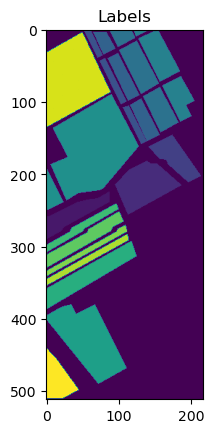

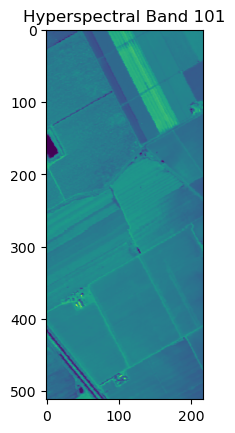

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Salinas_gt.mat'
data_files = 'Salinas_corrected.mat'
label_files = 'salinas_gt'
hypercube_files = 'salinas_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 54129
Extracted windows shape: (54129, 5, 5, 204)
Corresponding labels shape: (54129,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 2009 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 3726 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 1976 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 1394 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 2678 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 3959 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 3579 samples
Shuffled class indices fo


 -- Test set created with: 
	53409 samples
	shape (53409, 5, 5, 204) --




All datasets saved to the 'indices' folder.
(640, 5, 5, 204)
(80, 5, 5, 204)
(53409, 5, 5, 204)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 320
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (43303, 5, 5, 204)
Validation data shape: (10826, 5, 5, 204)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

204


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/677], Loss: 0.1578, PSNR: 7.0698


	 Training Batch [200/677], Loss: 0.0886, PSNR: 9.6555


	 Training Batch [400/677], Loss: 0.0440, PSNR: 12.7452


	 Training Batch [600/677], Loss: 0.0256, PSNR: 14.9846


Epoch [1/50] Training Loss: 0.0670, PSNR: 11.6394
	[Val]   Batch [1/170] Loss: 0.0211, PSNR: 15.8373
	[Val]   Batch [10/170] Loss: 0.0208, PSNR: 15.9988
	[Val]   Batch [20/170] Loss: 0.0209, PSNR: 15.9013
	[Val]   Batch [30/170] Loss: 0.0216, PSNR: 15.6967
	[Val]   Batch [40/170] Loss: 0.0217, PSNR: 15.7670


	[Val]   Batch [50/170] Loss: 0.0206, PSNR: 15.9744
	[Val]   Batch [60/170] Loss: 0.0215, PSNR: 15.8556
	[Val]   Batch [70/170] Loss: 0.0211, PSNR: 15.9421
	[Val]   Batch [80/170] Loss: 0.0214, PSNR: 15.7578


	[Val]   Batch [90/170] Loss: 0.0208, PSNR: 15.9942
	[Val]   Batch [100/170] Loss: 0.0208, PSNR: 15.9158
	[Val]   Batch [110/170] Loss: 0.0209, PSNR: 15.9049
	[Val]   Batch [120/170] Loss: 0.0197, PSNR: 14.2052
	[Val]   Batch [130/170] Loss: 0.0207, PSNR: 16.0056


	[Val]   Batch [140/170] Loss: 0.0204, PSNR: 16.0534
	[Val]   Batch [150/170] Loss: 0.0218, PSNR: 15.8062
	[Val]   Batch [160/170] Loss: 0.0214, PSNR: 15.8411
	[Val]   Batch [170/170] Loss: 0.0222, PSNR: 15.1363
Epoch [1/50] Validation Loss: 0.0211, PSNR: 15.8253

LOG: Epoch [2/50]
	 Training Batch [1/677], Loss: 0.0220, PSNR: 15.7607


	 Training Batch [200/677], Loss: 0.0142, PSNR: 17.5332


	 Training Batch [400/677], Loss: 0.0105, PSNR: 18.8671


	 Training Batch [600/677], Loss: 0.0090, PSNR: 19.6620


Epoch [2/50] Training Loss: 0.0130, PSNR: 18.0880
	[Val]   Batch [1/170] Loss: 0.0087, PSNR: 19.6874
	[Val]   Batch [10/170] Loss: 0.0082, PSNR: 20.0203
	[Val]   Batch [20/170] Loss: 0.0083, PSNR: 19.8932
	[Val]   Batch [30/170] Loss: 0.0090, PSNR: 19.5006
	[Val]   Batch [40/170] Loss: 0.0092, PSNR: 19.4947


	[Val]   Batch [50/170] Loss: 0.0081, PSNR: 20.0295
	[Val]   Batch [60/170] Loss: 0.0090, PSNR: 19.6418
	[Val]   Batch [70/170] Loss: 0.0088, PSNR: 19.7455
	[Val]   Batch [80/170] Loss: 0.0089, PSNR: 19.5991
	[Val]   Batch [90/170] Loss: 0.0085, PSNR: 19.8819


	[Val]   Batch [100/170] Loss: 0.0085, PSNR: 19.7967
	[Val]   Batch [110/170] Loss: 0.0084, PSNR: 19.8643
	[Val]   Batch [120/170] Loss: 0.0074, PSNR: 18.4712
	[Val]   Batch [130/170] Loss: 0.0085, PSNR: 19.8926
	[Val]   Batch [140/170] Loss: 0.0079, PSNR: 20.1625


	[Val]   Batch [150/170] Loss: 0.0092, PSNR: 19.5435
	[Val]   Batch [160/170] Loss: 0.0089, PSNR: 19.6387
	[Val]   Batch [170/170] Loss: 0.0092, PSNR: 18.9599
Epoch [2/50] Validation Loss: 0.0086, PSNR: 19.7291

LOG: Epoch [3/50]
	 Training Batch [1/677], Loss: 0.0090, PSNR: 19.5463


	 Training Batch [200/677], Loss: 0.0063, PSNR: 21.1607


	 Training Batch [400/677], Loss: 0.0056, PSNR: 21.5684


	 Training Batch [600/677], Loss: 0.0051, PSNR: 22.0759


Epoch [3/50] Training Loss: 0.0063, PSNR: 21.1897
	[Val]   Batch [1/170] Loss: 0.0043, PSNR: 22.7277
	[Val]   Batch [10/170] Loss: 0.0042, PSNR: 22.9887
	[Val]   Batch [20/170] Loss: 0.0042, PSNR: 22.8823
	[Val]   Batch [30/170] Loss: 0.0045, PSNR: 22.4685
	[Val]   Batch [40/170] Loss: 0.0045, PSNR: 22.5606


	[Val]   Batch [50/170] Loss: 0.0042, PSNR: 22.8998
	[Val]   Batch [60/170] Loss: 0.0045, PSNR: 22.6530
	[Val]   Batch [70/170] Loss: 0.0043, PSNR: 22.8263
	[Val]   Batch [80/170] Loss: 0.0044, PSNR: 22.6519
	[Val]   Batch [90/170] Loss: 0.0043, PSNR: 22.8640


	[Val]   Batch [100/170] Loss: 0.0044, PSNR: 22.7179
	[Val]   Batch [110/170] Loss: 0.0042, PSNR: 22.8389
	[Val]   Batch [120/170] Loss: 0.0039, PSNR: 21.2637
	[Val]   Batch [130/170] Loss: 0.0043, PSNR: 22.8157
	[Val]   Batch [140/170] Loss: 0.0040, PSNR: 23.1410


	[Val]   Batch [150/170] Loss: 0.0046, PSNR: 22.5955
	[Val]   Batch [160/170] Loss: 0.0044, PSNR: 22.6856
	[Val]   Batch [170/170] Loss: 0.0045, PSNR: 22.0195
Epoch [3/50] Validation Loss: 0.0043, PSNR: 22.7255

LOG: Epoch [4/50]
	 Training Batch [1/677], Loss: 0.0041, PSNR: 23.0125


	 Training Batch [200/677], Loss: 0.0038, PSNR: 23.3569


	 Training Batch [400/677], Loss: 0.0033, PSNR: 24.0287


	 Training Batch [600/677], Loss: 0.0028, PSNR: 24.6341


Epoch [4/50] Training Loss: 0.0034, PSNR: 23.7777
	[Val]   Batch [1/170] Loss: 0.0026, PSNR: 24.9605
	[Val]   Batch [10/170] Loss: 0.0025, PSNR: 25.1999
	[Val]   Batch [20/170] Loss: 0.0025, PSNR: 25.0494
	[Val]   Batch [30/170] Loss: 0.0028, PSNR: 24.5952
	[Val]   Batch [40/170] Loss: 0.0027, PSNR: 24.8847


	[Val]   Batch [50/170] Loss: 0.0026, PSNR: 25.0338
	[Val]   Batch [60/170] Loss: 0.0027, PSNR: 24.8443
	[Val]   Batch [70/170] Loss: 0.0025, PSNR: 25.1291
	[Val]   Batch [80/170] Loss: 0.0026, PSNR: 24.8904
	[Val]   Batch [90/170] Loss: 0.0026, PSNR: 25.0824


	[Val]   Batch [100/170] Loss: 0.0027, PSNR: 24.8047
	[Val]   Batch [110/170] Loss: 0.0025, PSNR: 25.1017
	[Val]   Batch [120/170] Loss: 0.0024, PSNR: 23.2905
	[Val]   Batch [130/170] Loss: 0.0027, PSNR: 24.8698
	[Val]   Batch [140/170] Loss: 0.0024, PSNR: 25.3503


	[Val]   Batch [150/170] Loss: 0.0027, PSNR: 24.8102
	[Val]   Batch [160/170] Loss: 0.0026, PSNR: 24.9201
	[Val]   Batch [170/170] Loss: 0.0028, PSNR: 24.1722
Epoch [4/50] Validation Loss: 0.0026, PSNR: 24.9102

LOG: Epoch [5/50]
	 Training Batch [1/677], Loss: 0.0027, PSNR: 24.7041


	 Training Batch [200/677], Loss: 0.0024, PSNR: 25.2337


	 Training Batch [400/677], Loss: 0.0024, PSNR: 25.2992


	 Training Batch [600/677], Loss: 0.0020, PSNR: 26.1933


Epoch [5/50] Training Loss: 0.0023, PSNR: 25.4593
	[Val]   Batch [1/170] Loss: 0.0018, PSNR: 26.5233
	[Val]   Batch [10/170] Loss: 0.0017, PSNR: 26.8004
	[Val]   Batch [20/170] Loss: 0.0018, PSNR: 26.5994
	[Val]   Batch [30/170] Loss: 0.0020, PSNR: 26.0907
	[Val]   Batch [40/170] Loss: 0.0018, PSNR: 26.5137
	[Val]   Batch [50/170] Loss: 0.0018, PSNR: 26.5495


	[Val]   Batch [60/170] Loss: 0.0019, PSNR: 26.3817
	[Val]   Batch [70/170] Loss: 0.0018, PSNR: 26.7321
	[Val]   Batch [80/170] Loss: 0.0018, PSNR: 26.4796
	[Val]   Batch [90/170] Loss: 0.0018, PSNR: 26.6370


	[Val]   Batch [100/170] Loss: 0.0019, PSNR: 26.2665
	[Val]   Batch [110/170] Loss: 0.0017, PSNR: 26.7885
	[Val]   Batch [120/170] Loss: 0.0017, PSNR: 24.7650
	[Val]   Batch [130/170] Loss: 0.0019, PSNR: 26.3295
	[Val]   Batch [140/170] Loss: 0.0017, PSNR: 26.9432


	[Val]   Batch [150/170] Loss: 0.0019, PSNR: 26.3546
	[Val]   Batch [160/170] Loss: 0.0018, PSNR: 26.4857
	[Val]   Batch [170/170] Loss: 0.0019, PSNR: 25.8079
Epoch [5/50] Validation Loss: 0.0018, PSNR: 26.4671

LOG: Epoch [6/50]
	 Training Batch [1/677], Loss: 0.0018, PSNR: 26.1030


	 Training Batch [200/677], Loss: 0.0019, PSNR: 26.3317


	 Training Batch [400/677], Loss: 0.0017, PSNR: 26.7092


	 Training Batch [600/677], Loss: 0.0016, PSNR: 26.8935


Epoch [6/50] Training Loss: 0.0018, PSNR: 26.6357
	[Val]   Batch [1/170] Loss: 0.0014, PSNR: 27.7107
	[Val]   Batch [10/170] Loss: 0.0013, PSNR: 27.9449
	[Val]   Batch [20/170] Loss: 0.0014, PSNR: 27.7011
	[Val]   Batch [30/170] Loss: 0.0015, PSNR: 27.1802
	[Val]   Batch [40/170] Loss: 0.0014, PSNR: 27.7333


	[Val]   Batch [50/170] Loss: 0.0014, PSNR: 27.6233
	[Val]   Batch [60/170] Loss: 0.0015, PSNR: 27.5151
	[Val]   Batch [70/170] Loss: 0.0013, PSNR: 27.9765
	[Val]   Batch [80/170] Loss: 0.0014, PSNR: 27.6403
	[Val]   Batch [90/170] Loss: 0.0014, PSNR: 27.8228


	[Val]   Batch [100/170] Loss: 0.0015, PSNR: 27.3741
	[Val]   Batch [110/170] Loss: 0.0013, PSNR: 28.0297
	[Val]   Batch [120/170] Loss: 0.0014, PSNR: 25.8119
	[Val]   Batch [130/170] Loss: 0.0015, PSNR: 27.4368
	[Val]   Batch [140/170] Loss: 0.0013, PSNR: 28.0989


	[Val]   Batch [150/170] Loss: 0.0015, PSNR: 27.4893
	[Val]   Batch [160/170] Loss: 0.0014, PSNR: 27.6615
	[Val]   Batch [170/170] Loss: 0.0015, PSNR: 26.9322
Epoch [6/50] Validation Loss: 0.0014, PSNR: 27.6058

LOG: Epoch [7/50]
	 Training Batch [1/677], Loss: 0.0016, PSNR: 27.0992


	 Training Batch [200/677], Loss: 0.0014, PSNR: 27.6735


	 Training Batch [400/677], Loss: 0.0015, PSNR: 27.5490


	 Training Batch [600/677], Loss: 0.0012, PSNR: 28.1690


Epoch [7/50] Training Loss: 0.0014, PSNR: 27.5357
	[Val]   Batch [1/170] Loss: 0.0011, PSNR: 28.5139
	[Val]   Batch [10/170] Loss: 0.0011, PSNR: 28.7485
	[Val]   Batch [20/170] Loss: 0.0012, PSNR: 28.4827
	[Val]   Batch [30/170] Loss: 0.0013, PSNR: 27.9499
	[Val]   Batch [40/170] Loss: 0.0011, PSNR: 28.5672


	[Val]   Batch [50/170] Loss: 0.0012, PSNR: 28.3746
	[Val]   Batch [60/170] Loss: 0.0012, PSNR: 28.3122
	[Val]   Batch [70/170] Loss: 0.0011, PSNR: 28.8236
	[Val]   Batch [80/170] Loss: 0.0012, PSNR: 28.4462
	[Val]   Batch [90/170] Loss: 0.0011, PSNR: 28.6444


	[Val]   Batch [100/170] Loss: 0.0012, PSNR: 28.1416
	[Val]   Batch [110/170] Loss: 0.0010, PSNR: 28.9031
	[Val]   Batch [120/170] Loss: 0.0011, PSNR: 26.5641
	[Val]   Batch [130/170] Loss: 0.0012, PSNR: 28.2114
	[Val]   Batch [140/170] Loss: 0.0011, PSNR: 28.9134


	[Val]   Batch [150/170] Loss: 0.0012, PSNR: 28.2644
	[Val]   Batch [160/170] Loss: 0.0012, PSNR: 28.4740
	[Val]   Batch [170/170] Loss: 0.0012, PSNR: 27.7740
Epoch [7/50] Validation Loss: 0.0012, PSNR: 28.3984

LOG: Epoch [8/50]
	 Training Batch [1/677], Loss: 0.0012, PSNR: 28.2628


	 Training Batch [200/677], Loss: 0.0013, PSNR: 27.8509


	 Training Batch [400/677], Loss: 0.0013, PSNR: 28.1018


	 Training Batch [600/677], Loss: 0.0013, PSNR: 27.8984


Epoch [8/50] Training Loss: 0.0012, PSNR: 28.3287
	[Val]   Batch [1/170] Loss: 0.0009, PSNR: 29.5608
	[Val]   Batch [10/170] Loss: 0.0009, PSNR: 29.8015
	[Val]   Batch [20/170] Loss: 0.0009, PSNR: 29.5167
	[Val]   Batch [30/170] Loss: 0.0010, PSNR: 28.9187
	[Val]   Batch [40/170] Loss: 0.0009, PSNR: 29.6292


	[Val]   Batch [50/170] Loss: 0.0009, PSNR: 29.3574
	[Val]   Batch [60/170] Loss: 0.0010, PSNR: 29.3103
	[Val]   Batch [70/170] Loss: 0.0008, PSNR: 29.8970
	[Val]   Batch [80/170] Loss: 0.0009, PSNR: 29.5015
	[Val]   Batch [90/170] Loss: 0.0009, PSNR: 29.6931


	[Val]   Batch [100/170] Loss: 0.0010, PSNR: 29.0972
	[Val]   Batch [110/170] Loss: 0.0008, PSNR: 30.0293
	[Val]   Batch [120/170] Loss: 0.0009, PSNR: 27.5165
	[Val]   Batch [130/170] Loss: 0.0010, PSNR: 29.1621
	[Val]   Batch [140/170] Loss: 0.0008, PSNR: 29.9916


	[Val]   Batch [150/170] Loss: 0.0010, PSNR: 29.2425
	[Val]   Batch [160/170] Loss: 0.0009, PSNR: 29.4954
	[Val]   Batch [170/170] Loss: 0.0010, PSNR: 28.8131
Epoch [8/50] Validation Loss: 0.0009, PSNR: 29.4160

LOG: Epoch [9/50]
	 Training Batch [1/677], Loss: 0.0011, PSNR: 28.5275


	 Training Batch [200/677], Loss: 0.0012, PSNR: 28.3388


	 Training Batch [400/677], Loss: 0.0010, PSNR: 29.2049


	 Training Batch [600/677], Loss: 0.0009, PSNR: 29.7621


Epoch [9/50] Training Loss: 0.0010, PSNR: 29.0058
	[Val]   Batch [1/170] Loss: 0.0007, PSNR: 30.5270
	[Val]   Batch [10/170] Loss: 0.0007, PSNR: 30.8006
	[Val]   Batch [20/170] Loss: 0.0007, PSNR: 30.4855
	[Val]   Batch [30/170] Loss: 0.0008, PSNR: 29.8619
	[Val]   Batch [40/170] Loss: 0.0007, PSNR: 30.6253


	[Val]   Batch [50/170] Loss: 0.0008, PSNR: 30.2535
	[Val]   Batch [60/170] Loss: 0.0008, PSNR: 30.2624
	[Val]   Batch [70/170] Loss: 0.0007, PSNR: 30.8573
	[Val]   Batch [80/170] Loss: 0.0007, PSNR: 30.5190
	[Val]   Batch [90/170] Loss: 0.0007, PSNR: 30.6675


	[Val]   Batch [100/170] Loss: 0.0008, PSNR: 30.0140
	[Val]   Batch [110/170] Loss: 0.0006, PSNR: 31.0645
	[Val]   Batch [120/170] Loss: 0.0008, PSNR: 28.3881
	[Val]   Batch [130/170] Loss: 0.0008, PSNR: 30.0891
	[Val]   Batch [140/170] Loss: 0.0007, PSNR: 30.9844


	[Val]   Batch [150/170] Loss: 0.0008, PSNR: 30.1859
	[Val]   Batch [160/170] Loss: 0.0007, PSNR: 30.4270
	[Val]   Batch [170/170] Loss: 0.0007, PSNR: 29.8887
Epoch [9/50] Validation Loss: 0.0007, PSNR: 30.3814

LOG: Epoch [10/50]
	 Training Batch [1/677], Loss: 0.0010, PSNR: 28.8512


	 Training Batch [200/677], Loss: 0.0008, PSNR: 30.0853


	 Training Batch [400/677], Loss: 0.0010, PSNR: 28.9696


	 Training Batch [600/677], Loss: 0.0009, PSNR: 29.4016


Epoch [10/50] Training Loss: 0.0009, PSNR: 29.6258
	[Val]   Batch [1/170] Loss: 0.0006, PSNR: 31.0485
	[Val]   Batch [10/170] Loss: 0.0006, PSNR: 31.3062
	[Val]   Batch [20/170] Loss: 0.0007, PSNR: 30.9451
	[Val]   Batch [30/170] Loss: 0.0007, PSNR: 30.3823
	[Val]   Batch [40/170] Loss: 0.0006, PSNR: 31.1646


	[Val]   Batch [50/170] Loss: 0.0007, PSNR: 30.7376
	[Val]   Batch [60/170] Loss: 0.0007, PSNR: 30.7944
	[Val]   Batch [70/170] Loss: 0.0006, PSNR: 31.4016
	[Val]   Batch [80/170] Loss: 0.0006, PSNR: 31.0444


	[Val]   Batch [90/170] Loss: 0.0006, PSNR: 31.2653
	[Val]   Batch [100/170] Loss: 0.0007, PSNR: 30.6068
	[Val]   Batch [110/170] Loss: 0.0006, PSNR: 31.5717
	[Val]   Batch [120/170] Loss: 0.0007, PSNR: 28.8968
	[Val]   Batch [130/170] Loss: 0.0007, PSNR: 30.6880


	[Val]   Batch [140/170] Loss: 0.0006, PSNR: 31.4885
	[Val]   Batch [150/170] Loss: 0.0007, PSNR: 30.7259
	[Val]   Batch [160/170] Loss: 0.0007, PSNR: 30.9354
	[Val]   Batch [170/170] Loss: 0.0007, PSNR: 30.4083
Epoch [10/50] Validation Loss: 0.0007, PSNR: 30.8931

LOG: Epoch [11/50]
	 Training Batch [1/677], Loss: 0.0008, PSNR: 30.1118


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.9426


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.8709


	 Training Batch [600/677], Loss: 0.0008, PSNR: 30.1024


Epoch [11/50] Training Loss: 0.0008, PSNR: 30.1711
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 31.8941
	[Val]   Batch [10/170] Loss: 0.0005, PSNR: 32.1899
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 31.7609
	[Val]   Batch [30/170] Loss: 0.0006, PSNR: 31.2559
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 32.0104


	[Val]   Batch [50/170] Loss: 0.0006, PSNR: 31.5232
	[Val]   Batch [60/170] Loss: 0.0006, PSNR: 31.6589
	[Val]   Batch [70/170] Loss: 0.0005, PSNR: 32.2168
	[Val]   Batch [80/170] Loss: 0.0005, PSNR: 31.9533
	[Val]   Batch [90/170] Loss: 0.0005, PSNR: 32.1487


	[Val]   Batch [100/170] Loss: 0.0006, PSNR: 31.4705
	[Val]   Batch [110/170] Loss: 0.0005, PSNR: 32.4819
	[Val]   Batch [120/170] Loss: 0.0006, PSNR: 29.6736
	[Val]   Batch [130/170] Loss: 0.0006, PSNR: 31.5545
	[Val]   Batch [140/170] Loss: 0.0005, PSNR: 32.3641


	[Val]   Batch [150/170] Loss: 0.0006, PSNR: 31.6019
	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 31.7428
	[Val]   Batch [170/170] Loss: 0.0005, PSNR: 31.4326
Epoch [11/50] Validation Loss: 0.0005, PSNR: 31.7532

LOG: Epoch [12/50]
	 Training Batch [1/677], Loss: 0.0009, PSNR: 29.2352


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.4628


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.1741


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.5795


Epoch [12/50] Training Loss: 0.0007, PSNR: 30.6756
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 32.2545
	[Val]   Batch [10/170] Loss: 0.0005, PSNR: 32.5786
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 32.1107
	[Val]   Batch [30/170] Loss: 0.0005, PSNR: 31.6555
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 32.3623
	[Val]   Batch [50/170] Loss: 0.0005, PSNR: 31.8647


	[Val]   Batch [60/170] Loss: 0.0005, PSNR: 32.0561
	[Val]   Batch [70/170] Loss: 0.0005, PSNR: 32.5853
	[Val]   Batch [80/170] Loss: 0.0005, PSNR: 32.3186
	[Val]   Batch [90/170] Loss: 0.0005, PSNR: 32.5919
	[Val]   Batch [100/170] Loss: 0.0005, PSNR: 31.9895


	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 32.8210
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 30.1565
	[Val]   Batch [130/170] Loss: 0.0005, PSNR: 32.0410
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 32.7467
	[Val]   Batch [150/170] Loss: 0.0005, PSNR: 32.0205


	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 32.0930
	[Val]   Batch [170/170] Loss: 0.0005, PSNR: 31.7853
Epoch [12/50] Validation Loss: 0.0005, PSNR: 32.1325

LOG: Epoch [13/50]
	 Training Batch [1/677], Loss: 0.0007, PSNR: 30.7218


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.2462


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.5031


	 Training Batch [600/677], Loss: 0.0006, PSNR: 30.9129


Epoch [13/50] Training Loss: 0.0006, PSNR: 31.1066
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.0316
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 33.3683
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 32.8331
	[Val]   Batch [30/170] Loss: 0.0005, PSNR: 32.4948
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 33.1285
	[Val]   Batch [50/170] Loss: 0.0005, PSNR: 32.5678


	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 32.8664
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 33.2504
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 33.1740
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 33.3901
	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 32.7641


	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 33.6287
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 30.8202
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 32.8318
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 33.5280
	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 32.8511


	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 32.7919
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 32.7165
Epoch [13/50] Validation Loss: 0.0004, PSNR: 32.9098

LOG: Epoch [14/50]
	 Training Batch [1/677], Loss: 0.0007, PSNR: 30.5859


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.2317


	 Training Batch [400/677], Loss: 0.0005, PSNR: 31.8976


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.2114


Epoch [14/50] Training Loss: 0.0006, PSNR: 31.5399
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.4911
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 33.8214
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 33.2694
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 32.9829
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 33.6013


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.0245
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 33.3560
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 33.6887
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 33.6189
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 33.9143


	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 33.2803
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.0602
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 31.3292
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 33.3874
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 33.9902


	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 33.3314
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.1982
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 33.3207
Epoch [14/50] Validation Loss: 0.0004, PSNR: 33.3751

LOG: Epoch [15/50]
	 Training Batch [1/677], Loss: 0.0007, PSNR: 30.8432


	 Training Batch [200/677], Loss: 0.0005, PSNR: 31.9426


	 Training Batch [400/677], Loss: 0.0005, PSNR: 32.5859


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.2157


Epoch [15/50] Training Loss: 0.0005, PSNR: 31.8863
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.0368
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.3845
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 33.7873
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 33.5979
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.1603


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.5233
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 33.9510
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.1842
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.2303
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.5181


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 33.9161
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.6127
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 31.8283
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.0203
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.5141


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 33.9452
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 33.7139
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 34.0478
Epoch [15/50] Validation Loss: 0.0003, PSNR: 33.9373

LOG: Epoch [16/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.5555


	 Training Batch [200/677], Loss: 0.0005, PSNR: 32.4854


	 Training Batch [400/677], Loss: 0.0005, PSNR: 32.5475


	 Training Batch [600/677], Loss: 0.0004, PSNR: 33.0826


Epoch [16/50] Training Loss: 0.0005, PSNR: 32.2117
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.5138
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.8754
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.2137
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.1196
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.6345


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 33.9522
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.4871
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.6174
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.7511
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 35.0504


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.4397
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 35.0977
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.2857
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.5596
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.9839


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.5090
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.1297
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 34.6743
Epoch [16/50] Validation Loss: 0.0003, PSNR: 34.4246

LOG: Epoch [17/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 32.8858


	 Training Batch [200/677], Loss: 0.0005, PSNR: 31.9951


	 Training Batch [400/677], Loss: 0.0004, PSNR: 33.2260


	 Training Batch [600/677], Loss: 0.0004, PSNR: 32.9181


Epoch [17/50] Training Loss: 0.0005, PSNR: 32.5245
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.9777
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.3512
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.6351
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.6270
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 35.0903


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.3972
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.9907
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 35.0237
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.2553
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.5622


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.9478
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.5669
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.7139
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 35.0580
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.4525


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.9867
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.5408
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.2347
Epoch [17/50] Validation Loss: 0.0003, PSNR: 34.8886

LOG: Epoch [18/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.1726


	 Training Batch [200/677], Loss: 0.0005, PSNR: 31.7820


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.1338


	 Training Batch [600/677], Loss: 0.0004, PSNR: 33.7016


Epoch [18/50] Training Loss: 0.0004, PSNR: 32.7736
	[Val]   Batch [1/170] Loss: 0.0002, PSNR: 35.4120
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.7197
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 35.0196
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 35.0491
	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 35.4785


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.7211
	[Val]   Batch [60/170] Loss: 0.0002, PSNR: 35.4260
	[Val]   Batch [70/170] Loss: 0.0002, PSNR: 35.4409
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.6941
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 36.0207


	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 35.4057
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 36.0014
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 33.1327
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 35.5242
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.8393


	[Val]   Batch [150/170] Loss: 0.0002, PSNR: 35.4574
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.9250
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.7669
Epoch [18/50] Validation Loss: 0.0002, PSNR: 35.3081

LOG: Epoch [19/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.0134


	 Training Batch [200/677], Loss: 0.0003, PSNR: 33.6927


	 Training Batch [400/677], Loss: 0.0004, PSNR: 32.8807


	 Training Batch [600/677], Loss: 0.0005, PSNR: 31.9594


Epoch [19/50] Training Loss: 0.0004, PSNR: 33.0623
	[Val]   Batch [1/170] Loss: 0.0002, PSNR: 35.6685
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 36.0345
	[Val]   Batch [20/170] Loss: 0.0002, PSNR: 35.2730
	[Val]   Batch [30/170] Loss: 0.0002, PSNR: 35.3937
	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 35.7840


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.9339
	[Val]   Batch [60/170] Loss: 0.0002, PSNR: 35.7687
	[Val]   Batch [70/170] Loss: 0.0002, PSNR: 35.7146
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 36.0212
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 36.3520


	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 35.8039
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 36.2336
	[Val]   Batch [120/170] Loss: 0.0002, PSNR: 33.4156
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 35.9465
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 36.1010


	[Val]   Batch [150/170] Loss: 0.0002, PSNR: 35.8438
	[Val]   Batch [160/170] Loss: 0.0002, PSNR: 35.2080
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 36.1248
Epoch [19/50] Validation Loss: 0.0002, PSNR: 35.6205
Early stopping triggered at epoch 19. No improvement for 3 epochs.


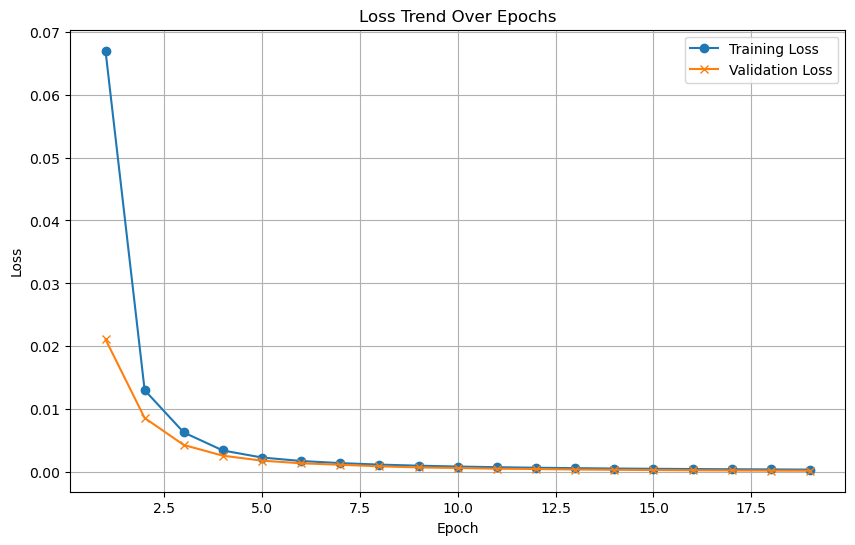

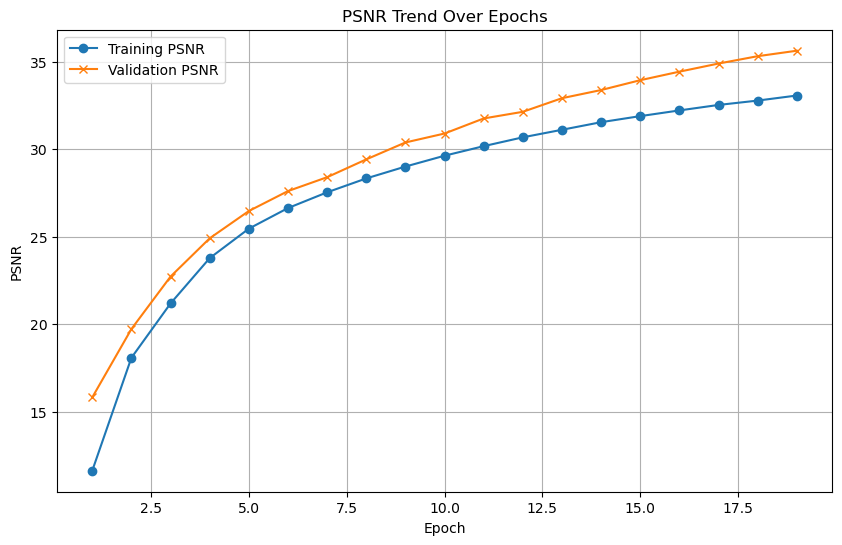

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/2 for train dataset.
    Processed batch 2/2 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/209 for test dataset.


    Processed batch 101/209 for test dataset.


    Processed batch 201/209 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7579
    Validation Batch [1/1], Loss: 2.7774
Validation Loss: 2.7774, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7774. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.6899
    Validation Batch [1/1], Loss: 2.7775
Validation Loss: 2.7775, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.6517
    Validation Batch [1/1], Loss: 2.7775
Validation Loss: 2.7775, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.6166
    Validation Batch [1/1], Loss: 2.7775
Validation Loss: 2.7775, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Tr

Epoch [9/1000] completed, Average Training Loss: 2.4722
    Validation Batch [1/1], Loss: 2.7767
Validation Loss: 2.7767, Validation Accuracy: 6.25%
Validation loss improved from 2.7770 to 2.7767. Saving model...

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 2.4490
    Validation Batch [1/1], Loss: 2.7760
Validation Loss: 2.7760, Validation Accuracy: 6.25%
Validation loss improved from 2.7767 to 2.7760. Saving model...

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.4437
    Validation Batch [1/1], Loss: 2.7754
Validation Loss: 2.7754, Validation Accuracy: 6.25%
Validation loss improved from 2.7760 to 2.7754. Saving model...

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 2.4243
    Validation Batch [1/1], Loss: 2.7743
Validation Loss: 2.7743, Validation Accuracy: 6.25%
Validation loss improved from 2.7754 to 2.7743. Saving model...

LOG: Epoch [13/1000] - Training
Epoch [13/100

Epoch [22/1000] completed, Average Training Loss: 2.2065
    Validation Batch [1/1], Loss: 2.6676
Validation Loss: 2.6676, Validation Accuracy: 20.00%
Validation loss improved from 2.6962 to 2.6676. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.2081
    Validation Batch [1/1], Loss: 2.6349
Validation Loss: 2.6349, Validation Accuracy: 26.25%
Validation loss improved from 2.6676 to 2.6349. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.1837
    Validation Batch [1/1], Loss: 2.6011
Validation Loss: 2.6011, Validation Accuracy: 33.75%
Validation loss improved from 2.6349 to 2.6011. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.1436
    Validation Batch [1/1], Loss: 2.5638
Validation Loss: 2.5638, Validation Accuracy: 35.00%
Validation loss improved from 2.6011 to 2.5638. Saving model...

LOG: Epoch [26/1000] - Training
Epoch [2

Epoch [35/1000] completed, Average Training Loss: 1.9878
    Validation Batch [1/1], Loss: 2.1027
Validation Loss: 2.1027, Validation Accuracy: 65.00%
Validation loss improved from 2.1380 to 2.1027. Saving model...

LOG: Epoch [36/1000] - Training
Epoch [36/1000] completed, Average Training Loss: 1.9683
    Validation Batch [1/1], Loss: 2.0424
Validation Loss: 2.0424, Validation Accuracy: 67.50%
Validation loss improved from 2.1027 to 2.0424. Saving model...

LOG: Epoch [37/1000] - Training
Epoch [37/1000] completed, Average Training Loss: 1.9622
    Validation Batch [1/1], Loss: 2.0188
Validation Loss: 2.0188, Validation Accuracy: 67.50%
Validation loss improved from 2.0424 to 2.0188. Saving model...

LOG: Epoch [38/1000] - Training
Epoch [38/1000] completed, Average Training Loss: 1.9471
    Validation Batch [1/1], Loss: 1.9801
Validation Loss: 1.9801, Validation Accuracy: 67.50%
Validation loss improved from 2.0188 to 1.9801. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [3

Epoch [42/1000] completed, Average Training Loss: 1.8522
    Validation Batch [1/1], Loss: 1.8420
Validation Loss: 1.8420, Validation Accuracy: 70.00%
Validation loss improved from 1.8970 to 1.8420. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [43/1000] completed, Average Training Loss: 1.8528
    Validation Batch [1/1], Loss: 1.8283
Validation Loss: 1.8283, Validation Accuracy: 70.00%
Validation loss improved from 1.8420 to 1.8283. Saving model...

LOG: Epoch [44/1000] - Training
Epoch [44/1000] completed, Average Training Loss: 1.8266
    Validation Batch [1/1], Loss: 1.8093
Validation Loss: 1.8093, Validation Accuracy: 70.00%
Validation loss improved from 1.8283 to 1.8093. Saving model...

LOG: Epoch [45/1000] - Training
Epoch [45/1000] completed, Average Training Loss: 1.8113
    Validation Batch [1/1], Loss: 1.7871
Validation Loss: 1.7871, Validation Accuracy: 70.00%
Validation loss improved from 1.8093 to 1.7871. Saving model...

LOG: Epoch [46/1000] - Training
Epoch [4

Epoch [55/1000] completed, Average Training Loss: 1.6599
    Validation Batch [1/1], Loss: 1.5898
Validation Loss: 1.5898, Validation Accuracy: 71.25%
Validation loss improved from 1.6030 to 1.5898. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 1.6374
    Validation Batch [1/1], Loss: 1.5589
Validation Loss: 1.5589, Validation Accuracy: 71.25%
Validation loss improved from 1.5898 to 1.5589. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [57/1000] completed, Average Training Loss: 1.6197
    Validation Batch [1/1], Loss: 1.5694
Validation Loss: 1.5694, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [58/1000] - Training
Epoch [58/1000] completed, Average Training Loss: 1.5947
    Validation Batch [1/1], Loss: 1.5333
Validation Loss: 1.5333, Validation Accuracy: 72.50%
Validation loss improved from 1.5589 to 1.5333. Saving model...

LOG: Epoch [59/1000] - Training
Epoch [59/1000] complet

Epoch [68/1000] completed, Average Training Loss: 1.4300
    Validation Batch [1/1], Loss: 1.3652
Validation Loss: 1.3652, Validation Accuracy: 76.25%
Validation loss improved from 1.3934 to 1.3652. Saving model...

LOG: Epoch [69/1000] - Training
Epoch [69/1000] completed, Average Training Loss: 1.4320
    Validation Batch [1/1], Loss: 1.3623
Validation Loss: 1.3623, Validation Accuracy: 81.25%
Validation loss improved from 1.3652 to 1.3623. Saving model...

LOG: Epoch [70/1000] - Training
Epoch [70/1000] completed, Average Training Loss: 1.4220
    Validation Batch [1/1], Loss: 1.3479
Validation Loss: 1.3479, Validation Accuracy: 80.00%
Validation loss improved from 1.3623 to 1.3479. Saving model...

LOG: Epoch [71/1000] - Training
Epoch [71/1000] completed, Average Training Loss: 1.4150
    Validation Batch [1/1], Loss: 1.3268
Validation Loss: 1.3268, Validation Accuracy: 80.00%
Validation loss improved from 1.3479 to 1.3268. Saving model...

LOG: Epoch [72/1000] - Training
Epoch [7

    Validation Batch [1/1], Loss: 1.1430
Validation Loss: 1.1430, Validation Accuracy: 86.25%
Validation loss improved from 1.1903 to 1.1430. Saving model...

LOG: Epoch [82/1000] - Training
Epoch [82/1000] completed, Average Training Loss: 1.2310
    Validation Batch [1/1], Loss: 1.1218
Validation Loss: 1.1218, Validation Accuracy: 87.50%
Validation loss improved from 1.1430 to 1.1218. Saving model...

LOG: Epoch [83/1000] - Training
Epoch [83/1000] completed, Average Training Loss: 1.1939
    Validation Batch [1/1], Loss: 1.1165
Validation Loss: 1.1165, Validation Accuracy: 82.50%
Validation loss improved from 1.1218 to 1.1165. Saving model...

LOG: Epoch [84/1000] - Training
Epoch [84/1000] completed, Average Training Loss: 1.1914
    Validation Batch [1/1], Loss: 1.1458
Validation Loss: 1.1458, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [85/1000] - Training
Epoch [85/1000] completed, Average Training Loss: 1.1678
    Validation Batch [1

Epoch [95/1000] completed, Average Training Loss: 1.0226
    Validation Batch [1/1], Loss: 0.9490
Validation Loss: 0.9490, Validation Accuracy: 90.00%
Validation loss improved from 0.9543 to 0.9490. Saving model...

LOG: Epoch [96/1000] - Training
Epoch [96/1000] completed, Average Training Loss: 0.9865
    Validation Batch [1/1], Loss: 0.9284
Validation Loss: 0.9284, Validation Accuracy: 88.75%
Validation loss improved from 0.9490 to 0.9284. Saving model...

LOG: Epoch [97/1000] - Training
Epoch [97/1000] completed, Average Training Loss: 1.0048
    Validation Batch [1/1], Loss: 0.9255
Validation Loss: 0.9255, Validation Accuracy: 88.75%
Validation loss improved from 0.9284 to 0.9255. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 0.9953
    Validation Batch [1/1], Loss: 0.8908
Validation Loss: 0.8908, Validation Accuracy: 88.75%
Validation loss improved from 0.9255 to 0.8908. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [9

    Validation Batch [1/1], Loss: 0.7848
Validation Loss: 0.7848, Validation Accuracy: 88.75%
Validation loss improved from 0.8110 to 0.7848. Saving model...

LOG: Epoch [108/1000] - Training
Epoch [108/1000] completed, Average Training Loss: 0.8451
    Validation Batch [1/1], Loss: 0.7585
Validation Loss: 0.7585, Validation Accuracy: 91.25%
Validation loss improved from 0.7848 to 0.7585. Saving model...

LOG: Epoch [109/1000] - Training
Epoch [109/1000] completed, Average Training Loss: 0.8195
    Validation Batch [1/1], Loss: 0.7431
Validation Loss: 0.7431, Validation Accuracy: 92.50%
Validation loss improved from 0.7585 to 0.7431. Saving model...

LOG: Epoch [110/1000] - Training
Epoch [110/1000] completed, Average Training Loss: 0.8199
    Validation Batch [1/1], Loss: 0.7621
Validation Loss: 0.7621, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 0.7863
    Validation 

Epoch [120/1000] completed, Average Training Loss: 0.7040
    Validation Batch [1/1], Loss: 0.6276
Validation Loss: 0.6276, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 0.6860
    Validation Batch [1/1], Loss: 0.6375
Validation Loss: 0.6375, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 0.6826
    Validation Batch [1/1], Loss: 0.5926
Validation Loss: 0.5926, Validation Accuracy: 96.25%
Validation loss improved from 0.6236 to 0.5926. Saving model...

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 0.6503
    Validation Batch [1/1], Loss: 0.5842
Validation Loss: 0.5842, Validation Accuracy: 93.75%
Validation loss improved from 0.5926 to 0.5842. Saving model...

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Av

Epoch [132/1000] completed, Average Training Loss: 0.5987
    Validation Batch [1/1], Loss: 0.4969
Validation Loss: 0.4969, Validation Accuracy: 96.25%
Validation loss improved from 0.4978 to 0.4969. Saving model...

LOG: Epoch [133/1000] - Training
Epoch [133/1000] completed, Average Training Loss: 0.5844
    Validation Batch [1/1], Loss: 0.4928
Validation Loss: 0.4928, Validation Accuracy: 96.25%
Validation loss improved from 0.4969 to 0.4928. Saving model...

LOG: Epoch [134/1000] - Training
Epoch [134/1000] completed, Average Training Loss: 0.5494
    Validation Batch [1/1], Loss: 0.4950
Validation Loss: 0.4950, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [135/1000] - Training
Epoch [135/1000] completed, Average Training Loss: 0.5638
    Validation Batch [1/1], Loss: 0.5103
Validation Loss: 0.5103, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [136/1000] - Training
Epoch [136/1000] completed, Av

Epoch [146/1000] completed, Average Training Loss: 0.4743
    Validation Batch [1/1], Loss: 0.4160
Validation Loss: 0.4160, Validation Accuracy: 95.00%
Validation loss improved from 0.4212 to 0.4160. Saving model...

LOG: Epoch [147/1000] - Training
Epoch [147/1000] completed, Average Training Loss: 0.4439
    Validation Batch [1/1], Loss: 0.4147
Validation Loss: 0.4147, Validation Accuracy: 95.00%
Validation loss improved from 0.4160 to 0.4147. Saving model...

LOG: Epoch [148/1000] - Training
Epoch [148/1000] completed, Average Training Loss: 0.4517
    Validation Batch [1/1], Loss: 0.4299
Validation Loss: 0.4299, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Average Training Loss: 0.4173
    Validation Batch [1/1], Loss: 0.4212
Validation Loss: 0.4212, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [150/1000] - Training
Epoch [150/1000] completed, Av

Epoch [159/1000] completed, Average Training Loss: 0.3987
    Validation Batch [1/1], Loss: 0.4025
Validation Loss: 0.4025, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [160/1000] - Training
Epoch [160/1000] completed, Average Training Loss: 0.3885
    Validation Batch [1/1], Loss: 0.3261
Validation Loss: 0.3261, Validation Accuracy: 95.00%
Validation loss improved from 0.3364 to 0.3261. Saving model...

LOG: Epoch [161/1000] - Training
Epoch [161/1000] completed, Average Training Loss: 0.3750
    Validation Batch [1/1], Loss: 0.3708
Validation Loss: 0.3708, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [162/1000] - Training
Epoch [162/1000] completed, Average Training Loss: 0.3569
    Validation Batch [1/1], Loss: 0.3476
Validation Loss: 0.3476, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [163/1000] - Training
Epoch [163/1000] completed, Average Training 

Epoch [172/1000] completed, Average Training Loss: 0.3114
    Validation Batch [1/1], Loss: 0.2828
Validation Loss: 0.2828, Validation Accuracy: 95.00%
Validation loss improved from 0.2856 to 0.2828. Saving model...

LOG: Epoch [173/1000] - Training
Epoch [173/1000] completed, Average Training Loss: 0.3200
    Validation Batch [1/1], Loss: 0.2708
Validation Loss: 0.2708, Validation Accuracy: 96.25%
Validation loss improved from 0.2828 to 0.2708. Saving model...

LOG: Epoch [174/1000] - Training
Epoch [174/1000] completed, Average Training Loss: 0.2950
    Validation Batch [1/1], Loss: 0.2763
Validation Loss: 0.2763, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [175/1000] - Training
Epoch [175/1000] completed, Average Training Loss: 0.2896
    Validation Batch [1/1], Loss: 0.2979
Validation Loss: 0.2979, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [176/1000] - Training
Epoch [176/1000] completed, Av

    Validation Batch [1/1], Loss: 0.2439
Validation Loss: 0.2439, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [186/1000] - Training
Epoch [186/1000] completed, Average Training Loss: 0.2409
    Validation Batch [1/1], Loss: 0.2676
Validation Loss: 0.2676, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 0.2650
    Validation Batch [1/1], Loss: 0.2590
Validation Loss: 0.2590, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training Loss: 0.2567
    Validation Batch [1/1], Loss: 0.2601
Validation Loss: 0.2601, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training Loss: 0.2415
    Validation Batch [1/1], Loss: 0.2305
Validation Loss: 0.

Epoch [199/1000] completed, Average Training Loss: 0.2007
    Validation Batch [1/1], Loss: 0.2874
Validation Loss: 0.2874, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [200/1000] - Training
Epoch [200/1000] completed, Average Training Loss: 0.2087
    Validation Batch [1/1], Loss: 0.2368
Validation Loss: 0.2368, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [201/1000] - Training
Epoch [201/1000] completed, Average Training Loss: 0.1979
    Validation Batch [1/1], Loss: 0.2383
Validation Loss: 0.2383, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [202/1000] - Training
Epoch [202/1000] completed, Average Training Loss: 0.2185
    Validation Batch [1/1], Loss: 0.2146
Validation Loss: 0.2146, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [203/1000] - Training
Epoch [203/1000] completed, Average Training Loss: 0.2090
  

Epoch [212/1000] completed, Average Training Loss: 0.2073
    Validation Batch [1/1], Loss: 0.2628
Validation Loss: 0.2628, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 0.2007
    Validation Batch [1/1], Loss: 0.2637
Validation Loss: 0.2637, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [214/1000] - Training
Epoch [214/1000] completed, Average Training Loss: 0.1963
    Validation Batch [1/1], Loss: 0.2121
Validation Loss: 0.2121, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [215/1000] - Training
Epoch [215/1000] completed, Average Training Loss: 0.1851
    Validation Batch [1/1], Loss: 0.2109
Validation Loss: 0.2109, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training Loss: 0.194


LOG: Epoch [226/1000] - Training
Epoch [226/1000] completed, Average Training Loss: 0.1549
    Validation Batch [1/1], Loss: 0.1773
Validation Loss: 0.1773, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [227/1000] - Training
Epoch [227/1000] completed, Average Training Loss: 0.1555
    Validation Batch [1/1], Loss: 0.1569
Validation Loss: 0.1569, Validation Accuracy: 96.25%
Validation loss improved from 0.1740 to 0.1569. Saving model...

LOG: Epoch [228/1000] - Training
Epoch [228/1000] completed, Average Training Loss: 0.1537
    Validation Batch [1/1], Loss: 0.1557
Validation Loss: 0.1557, Validation Accuracy: 96.25%
Validation loss improved from 0.1569 to 0.1557. Saving model...

LOG: Epoch [229/1000] - Training
Epoch [229/1000] completed, Average Training Loss: 0.1366
    Validation Batch [1/1], Loss: 0.1519
Validation Loss: 0.1519, Validation Accuracy: 96.25%
Validation loss improved from 0.1557 to 0.1519. Saving model...

LOG: Epoch [23

Epoch [237/1000] completed, Average Training Loss: 0.1287
    Validation Batch [1/1], Loss: 0.1525
Validation Loss: 0.1525, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [238/1000] - Training
Epoch [238/1000] completed, Average Training Loss: 0.1336
    Validation Batch [1/1], Loss: 0.1546
Validation Loss: 0.1546, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [239/1000] - Training
Epoch [239/1000] completed, Average Training Loss: 0.1254
    Validation Batch [1/1], Loss: 0.1463
Validation Loss: 0.1463, Validation Accuracy: 95.00%
Validation loss improved from 0.1470 to 0.1463. Saving model...

LOG: Epoch [240/1000] - Training
Epoch [240/1000] completed, Average Training Loss: 0.1282
    Validation Batch [1/1], Loss: 0.1508
Validation Loss: 0.1508, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [241/1000] - Training
Epoch [241/1000] completed, Average Training 

Epoch [251/1000] completed, Average Training Loss: 0.1175
    Validation Batch [1/1], Loss: 0.1423
Validation Loss: 0.1423, Validation Accuracy: 97.50%
Validation loss improved from 0.1462 to 0.1423. Saving model...

LOG: Epoch [252/1000] - Training
Epoch [252/1000] completed, Average Training Loss: 0.1073
    Validation Batch [1/1], Loss: 0.1432
Validation Loss: 0.1432, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [253/1000] - Training
Epoch [253/1000] completed, Average Training Loss: 0.1183
    Validation Batch [1/1], Loss: 0.1617
Validation Loss: 0.1617, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [254/1000] - Training
Epoch [254/1000] completed, Average Training Loss: 0.1093
    Validation Batch [1/1], Loss: 0.1382
Validation Loss: 0.1382, Validation Accuracy: 96.25%
Validation loss improved from 0.1423 to 0.1382. Saving model...

LOG: Epoch [255/1000] - Training
Epoch [255/1000] completed, Av

Epoch [265/1000] completed, Average Training Loss: 0.0993
    Validation Batch [1/1], Loss: 0.1565
Validation Loss: 0.1565, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [266/1000] - Training
Epoch [266/1000] completed, Average Training Loss: 0.0939
    Validation Batch [1/1], Loss: 0.1414
Validation Loss: 0.1414, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [267/1000] - Training
Epoch [267/1000] completed, Average Training Loss: 0.0950
    Validation Batch [1/1], Loss: 0.1903
Validation Loss: 0.1903, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [268/1000] - Training
Epoch [268/1000] completed, Average Training Loss: 0.0984
    Validation Batch [1/1], Loss: 0.1387
Validation Loss: 0.1387, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [269/1000] - Training
Epoch [269/1000] completed, Average Training Loss: 0.0996
 

Epoch [277/1000] completed, Average Training Loss: 0.0943
    Validation Batch [1/1], Loss: 0.1724
Validation Loss: 0.1724, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [278/1000] - Training
Epoch [278/1000] completed, Average Training Loss: 0.0827
    Validation Batch [1/1], Loss: 0.1831
Validation Loss: 0.1831, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [279/1000] - Training
Epoch [279/1000] completed, Average Training Loss: 0.0821
    Validation Batch [1/1], Loss: 0.1553
Validation Loss: 0.1553, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.0919
    Validation Batch [1/1], Loss: 0.1398
Validation Loss: 0.1398, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.086

    Validation Batch [1/1], Loss: 0.1362
Validation Loss: 0.1362, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [291/1000] - Training
Epoch [291/1000] completed, Average Training Loss: 0.0830
    Validation Batch [1/1], Loss: 0.1303
Validation Loss: 0.1303, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [292/1000] - Training
Epoch [292/1000] completed, Average Training Loss: 0.0730
    Validation Batch [1/1], Loss: 0.1389
Validation Loss: 0.1389, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [293/1000] - Training
Epoch [293/1000] completed, Average Training Loss: 0.0757
    Validation Batch [1/1], Loss: 0.1287
Validation Loss: 0.1287, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [294/1000] - Training
Epoch [294/1000] completed, Average Training Loss: 0.0761
    Validation Batch [1/1], Loss: 0.1212
Validation Loss

Epoch [304/1000] completed, Average Training Loss: 0.0710
    Validation Batch [1/1], Loss: 0.1537
Validation Loss: 0.1537, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training Loss: 0.0716
    Validation Batch [1/1], Loss: 0.2189
Validation Loss: 0.2189, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [306/1000] - Training
Epoch [306/1000] completed, Average Training Loss: 0.0789
    Validation Batch [1/1], Loss: 0.1969
Validation Loss: 0.1969, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [307/1000] - Training
Epoch [307/1000] completed, Average Training Loss: 0.0774
    Validation Batch [1/1], Loss: 0.1517
Validation Loss: 0.1517, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.067

Epoch [317/1000] completed, Average Training Loss: 0.0666
    Validation Batch [1/1], Loss: 0.1391
Validation Loss: 0.1391, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [318/1000] - Training
Epoch [318/1000] completed, Average Training Loss: 0.0788
    Validation Batch [1/1], Loss: 0.1701
Validation Loss: 0.1701, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [319/1000] - Training
Epoch [319/1000] completed, Average Training Loss: 0.0767
    Validation Batch [1/1], Loss: 0.1517
Validation Loss: 0.1517, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [320/1000] - Training
Epoch [320/1000] completed, Average Training Loss: 0.0659
    Validation Batch [1/1], Loss: 0.1367
Validation Loss: 0.1367, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [321/1000] - Training
Epoch [321/1000] completed, Average Training Loss: 0.0631


Epoch [331/1000] completed, Average Training Loss: 0.0564
    Validation Batch [1/1], Loss: 0.1082
Validation Loss: 0.1082, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training Loss: 0.0598
    Validation Batch [1/1], Loss: 0.1318
Validation Loss: 0.1318, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Training Loss: 0.0617
    Validation Batch [1/1], Loss: 0.1111
Validation Loss: 0.1111, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training Loss: 0.0620
    Validation Batch [1/1], Loss: 0.1087
Validation Loss: 0.1087, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [335/1000] - Training
Epoch [335/1000] completed, Average Training Loss: 0.0544
  

    Validation Batch [1/1], Loss: 0.1177
Validation Loss: 0.1177, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [345/1000] - Training
Epoch [345/1000] completed, Average Training Loss: 0.0551
    Validation Batch [1/1], Loss: 0.1215
Validation Loss: 0.1215, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [346/1000] - Training
Epoch [346/1000] completed, Average Training Loss: 0.0491
    Validation Batch [1/1], Loss: 0.1162
Validation Loss: 0.1162, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [347/1000] - Training
Epoch [347/1000] completed, Average Training Loss: 0.0481
    Validation Batch [1/1], Loss: 0.1297
Validation Loss: 0.1297, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [348/1000] - Training
Epoch [348/1000] completed, Average Training Loss: 0.0505
    Validation Batch [1/1], Loss: 0.1319
Validation Loss

Epoch [358/1000] completed, Average Training Loss: 0.0474
    Validation Batch [1/1], Loss: 0.1155
Validation Loss: 0.1155, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [359/1000] - Training
Epoch [359/1000] completed, Average Training Loss: 0.0477
    Validation Batch [1/1], Loss: 0.0908
Validation Loss: 0.0908, Validation Accuracy: 97.50%
Validation loss improved from 0.0996 to 0.0908. Saving model...

LOG: Epoch [360/1000] - Training
Epoch [360/1000] completed, Average Training Loss: 0.0461
    Validation Batch [1/1], Loss: 0.1032
Validation Loss: 0.1032, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [361/1000] - Training
Epoch [361/1000] completed, Average Training Loss: 0.0471
    Validation Batch [1/1], Loss: 0.1259
Validation Loss: 0.1259, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [362/1000] - Training
Epoch [362/1000] completed, Average Training

Epoch [371/1000] completed, Average Training Loss: 0.0450
    Validation Batch [1/1], Loss: 0.1463
Validation Loss: 0.1463, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [372/1000] - Training
Epoch [372/1000] completed, Average Training Loss: 0.0429
    Validation Batch [1/1], Loss: 0.1552
Validation Loss: 0.1552, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [373/1000] - Training
Epoch [373/1000] completed, Average Training Loss: 0.0420
    Validation Batch [1/1], Loss: 0.1483
Validation Loss: 0.1483, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Average Training Loss: 0.0388
    Validation Batch [1/1], Loss: 0.1441
Validation Loss: 0.1441, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [375/1000] - Training
Epoch [375/1000] completed, Average Training Loss: 0.037

    Validation Batch [1/1], Loss: 0.0993
Validation Loss: 0.0993, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [385/1000] - Training
Epoch [385/1000] completed, Average Training Loss: 0.0406
    Validation Batch [1/1], Loss: 0.1078
Validation Loss: 0.1078, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [386/1000] - Training
Epoch [386/1000] completed, Average Training Loss: 0.0419
    Validation Batch [1/1], Loss: 0.1099
Validation Loss: 0.1099, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [387/1000] - Training
Epoch [387/1000] completed, Average Training Loss: 0.0397
    Validation Batch [1/1], Loss: 0.1292
Validation Loss: 0.1292, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [388/1000] - Training
Epoch [388/1000] completed, Average Training Loss: 0.0335
    Validation Batch [1/1], Loss: 0.1253
Validation Loss

Epoch [398/1000] completed, Average Training Loss: 0.0403
    Validation Batch [1/1], Loss: 0.1187
Validation Loss: 0.1187, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.0335
    Validation Batch [1/1], Loss: 0.1048
Validation Loss: 0.1048, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.0398
    Validation Batch [1/1], Loss: 0.0896
Validation Loss: 0.0896, Validation Accuracy: 97.50%
Validation loss improved from 0.0908 to 0.0896. Saving model...

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.0357
    Validation Batch [1/1], Loss: 0.1042
Validation Loss: 0.1042, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Trainin

Epoch [411/1000] completed, Average Training Loss: 0.0360
    Validation Batch [1/1], Loss: 0.1697
Validation Loss: 0.1697, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [412/1000] - Training
Epoch [412/1000] completed, Average Training Loss: 0.0360
    Validation Batch [1/1], Loss: 0.1720
Validation Loss: 0.1720, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [413/1000] - Training
Epoch [413/1000] completed, Average Training Loss: 0.0361
    Validation Batch [1/1], Loss: 0.1274
Validation Loss: 0.1274, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [414/1000] - Training
Epoch [414/1000] completed, Average Training Loss: 0.0315
    Validation Batch [1/1], Loss: 0.1015
Validation Loss: 0.1015, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [415/1000] - Training
Epoch [415/1000] completed, Average Training Loss: 0.0320
  

    Validation Batch [1/1], Loss: 0.1262
Validation Loss: 0.1262, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.0346
    Validation Batch [1/1], Loss: 0.1590
Validation Loss: 0.1590, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.0339
    Validation Batch [1/1], Loss: 0.1555
Validation Loss: 0.1555, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [427/1000] - Training
Epoch [427/1000] completed, Average Training Loss: 0.0401
    Validation Batch [1/1], Loss: 0.1196
Validation Loss: 0.1196, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [428/1000] - Training
Epoch [428/1000] completed, Average Training Loss: 0.0312
    Validation Batch [1/1], Loss: 0.1949
Validation Loss

Epoch [438/1000] completed, Average Training Loss: 0.0293
    Validation Batch [1/1], Loss: 0.0992
Validation Loss: 0.0992, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [439/1000] - Training
Epoch [439/1000] completed, Average Training Loss: 0.0343
    Validation Batch [1/1], Loss: 0.0985
Validation Loss: 0.0985, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [440/1000] - Training
Epoch [440/1000] completed, Average Training Loss: 0.0312
    Validation Batch [1/1], Loss: 0.1218
Validation Loss: 0.1218, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [441/1000] - Training
Epoch [441/1000] completed, Average Training Loss: 0.0302
    Validation Batch [1/1], Loss: 0.1316
Validation Loss: 0.1316, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [442/1000] - Training
Epoch [442/1000] completed, Average Training Loss: 0.025

Epoch [451/1000] completed, Average Training Loss: 0.0275
    Validation Batch [1/1], Loss: 0.1375
Validation Loss: 0.1375, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [452/1000] - Training
Epoch [452/1000] completed, Average Training Loss: 0.0246
    Validation Batch [1/1], Loss: 0.1002
Validation Loss: 0.1002, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [453/1000] - Training
Epoch [453/1000] completed, Average Training Loss: 0.0243
    Validation Batch [1/1], Loss: 0.0829
Validation Loss: 0.0829, Validation Accuracy: 98.75%
Validation loss improved from 0.0883 to 0.0829. Saving model...

LOG: Epoch [454/1000] - Training
Epoch [454/1000] completed, Average Training Loss: 0.0251
    Validation Batch [1/1], Loss: 0.0869
Validation Loss: 0.0869, Validation Accuracy: 98.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [455/1000] - Training
Epoch [455/1000] completed, Average Trainin

Epoch [464/1000] completed, Average Training Loss: 0.0307
    Validation Batch [1/1], Loss: 0.1052
Validation Loss: 0.1052, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [465/1000] - Training
Epoch [465/1000] completed, Average Training Loss: 0.0269
    Validation Batch [1/1], Loss: 0.1800
Validation Loss: 0.1800, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [466/1000] - Training
Epoch [466/1000] completed, Average Training Loss: 0.0278
    Validation Batch [1/1], Loss: 0.1290
Validation Loss: 0.1290, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [467/1000] - Training
Epoch [467/1000] completed, Average Training Loss: 0.0246
    Validation Batch [1/1], Loss: 0.1112
Validation Loss: 0.1112, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Average Training Loss: 0.028

    Validation Batch [1/1], Loss: 0.1114
Validation Loss: 0.1114, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [478/1000] - Training
Epoch [478/1000] completed, Average Training Loss: 0.0217
    Validation Batch [1/1], Loss: 0.1095
Validation Loss: 0.1095, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [479/1000] - Training
Epoch [479/1000] completed, Average Training Loss: 0.0249
    Validation Batch [1/1], Loss: 0.1019
Validation Loss: 0.1019, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [480/1000] - Training
Epoch [480/1000] completed, Average Training Loss: 0.0205
    Validation Batch [1/1], Loss: 0.0947
Validation Loss: 0.0947, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [481/1000] - Training
Epoch [481/1000] completed, Average Training Loss: 0.0244
    Validation Batch [1/1], Loss: 0.0867
Validation Loss

Epoch [491/1000] completed, Average Training Loss: 0.0189
    Validation Batch [1/1], Loss: 0.0901
Validation Loss: 0.0901, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [492/1000] - Training
Epoch [492/1000] completed, Average Training Loss: 0.0263
    Validation Batch [1/1], Loss: 0.1069
Validation Loss: 0.1069, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.0222
    Validation Batch [1/1], Loss: 0.1061
Validation Loss: 0.1061, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.0240
    Validation Batch [1/1], Loss: 0.1074
Validation Loss: 0.1074, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [495/1000] - Training
Epoch [495/1000] completed, Average Training Loss: 0.0326
 

Epoch [500/1000] completed, Average Training Loss: 0.0197
    Validation Batch [1/1], Loss: 0.0989
Validation Loss: 0.0989, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [501/1000] - Training
Epoch [501/1000] completed, Average Training Loss: 0.0195
    Validation Batch [1/1], Loss: 0.1149
Validation Loss: 0.1149, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [502/1000] - Training
Epoch [502/1000] completed, Average Training Loss: 0.0247
    Validation Batch [1/1], Loss: 0.1418
Validation Loss: 0.1418, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [503/1000] - Training
Epoch [503/1000] completed, Average Training Loss: 0.0213
    Validation Batch [1/1], Loss: 0.1532
Validation Loss: 0.1532, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [504/1000] - Training
Epoch [504/1000] completed, Average Training Loss: 0.018

    Validation Batch [1/1], Loss: 0.1050
Validation Loss: 0.1050, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [514/1000] - Training
Epoch [514/1000] completed, Average Training Loss: 0.0234
    Validation Batch [1/1], Loss: 0.1091
Validation Loss: 0.1091, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [515/1000] - Training
Epoch [515/1000] completed, Average Training Loss: 0.0203
    Validation Batch [1/1], Loss: 0.1157
Validation Loss: 0.1157, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [516/1000] - Training
Epoch [516/1000] completed, Average Training Loss: 0.0230
    Validation Batch [1/1], Loss: 0.0894
Validation Loss: 0.0894, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [517/1000] - Training
Epoch [517/1000] completed, Average Training Loss: 0.0211
    Validation Batch [1/1], Loss: 0.0949
Validation Loss

Epoch [527/1000] completed, Average Training Loss: 0.0221
    Validation Batch [1/1], Loss: 0.0921
Validation Loss: 0.0921, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [528/1000] - Training
Epoch [528/1000] completed, Average Training Loss: 0.0234
    Validation Batch [1/1], Loss: 0.1023
Validation Loss: 0.1023, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [529/1000] - Training
Epoch [529/1000] completed, Average Training Loss: 0.0189
    Validation Batch [1/1], Loss: 0.1187
Validation Loss: 0.1187, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [530/1000] - Training
Epoch [530/1000] completed, Average Training Loss: 0.0164
    Validation Batch [1/1], Loss: 0.1170
Validation Loss: 0.1170, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [531/1000] - Training
Epoch [531/1000] completed, Average Training Loss: 0.021

Epoch [540/1000] completed, Average Training Loss: 0.0195
    Validation Batch [1/1], Loss: 0.1445
Validation Loss: 0.1445, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [541/1000] - Training
Epoch [541/1000] completed, Average Training Loss: 0.0159
    Validation Batch [1/1], Loss: 0.1167
Validation Loss: 0.1167, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [542/1000] - Training
Epoch [542/1000] completed, Average Training Loss: 0.0190
    Validation Batch [1/1], Loss: 0.1164
Validation Loss: 0.1164, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [543/1000] - Training
Epoch [543/1000] completed, Average Training Loss: 0.0158
    Validation Batch [1/1], Loss: 0.1832
Validation Loss: 0.1832, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [544/1000] - Training
Epoch [544/1000] completed, Average Training Loss: 0.019

Epoch [553/1000] completed, Average Training Loss: 0.0163
    Validation Batch [1/1], Loss: 0.1071
Validation Loss: 0.1071, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 69/100

LOG: Epoch [554/1000] - Training
Epoch [554/1000] completed, Average Training Loss: 0.0168
    Validation Batch [1/1], Loss: 0.1016
Validation Loss: 0.1016, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 70/100

LOG: Epoch [555/1000] - Training
Epoch [555/1000] completed, Average Training Loss: 0.0152
    Validation Batch [1/1], Loss: 0.1017
Validation Loss: 0.1017, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [556/1000] - Training
Epoch [556/1000] completed, Average Training Loss: 0.0162
    Validation Batch [1/1], Loss: 0.0999
Validation Loss: 0.0999, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [557/1000] - Training
Epoch [557/1000] completed, Average Training Loss: 0.016

Epoch [566/1000] completed, Average Training Loss: 0.0166
    Validation Batch [1/1], Loss: 0.1329
Validation Loss: 0.1329, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [567/1000] - Training
Epoch [567/1000] completed, Average Training Loss: 0.0164
    Validation Batch [1/1], Loss: 0.1336
Validation Loss: 0.1336, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 83/100

LOG: Epoch [568/1000] - Training
Epoch [568/1000] completed, Average Training Loss: 0.0171
    Validation Batch [1/1], Loss: 0.1323
Validation Loss: 0.1323, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [569/1000] - Training
Epoch [569/1000] completed, Average Training Loss: 0.0142
    Validation Batch [1/1], Loss: 0.1312
Validation Loss: 0.1312, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [570/1000] - Training
Epoch [570/1000] completed, Average Training Loss: 0.015

Epoch [577/1000] completed, Average Training Loss: 0.0148
    Validation Batch [1/1], Loss: 0.0917
Validation Loss: 0.0917, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 93/100

LOG: Epoch [578/1000] - Training
Epoch [578/1000] completed, Average Training Loss: 0.0146
    Validation Batch [1/1], Loss: 0.1120
Validation Loss: 0.1120, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 94/100

LOG: Epoch [579/1000] - Training
Epoch [579/1000] completed, Average Training Loss: 0.0170
    Validation Batch [1/1], Loss: 0.1170
Validation Loss: 0.1170, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 95/100

LOG: Epoch [580/1000] - Training
Epoch [580/1000] completed, Average Training Loss: 0.0160
    Validation Batch [1/1], Loss: 0.0894
Validation Loss: 0.0894, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 96/100

LOG: Epoch [581/1000] - Training
Epoch [581/1000] completed, Average Training Loss: 0.014

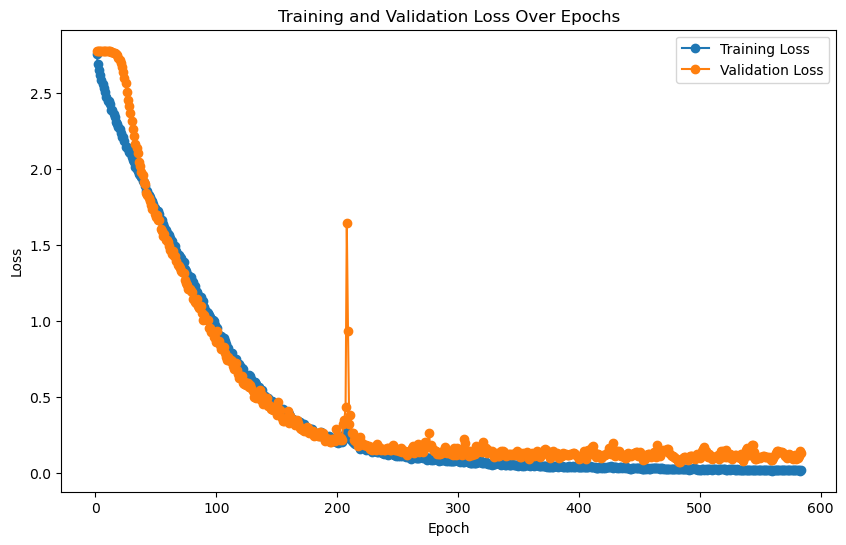

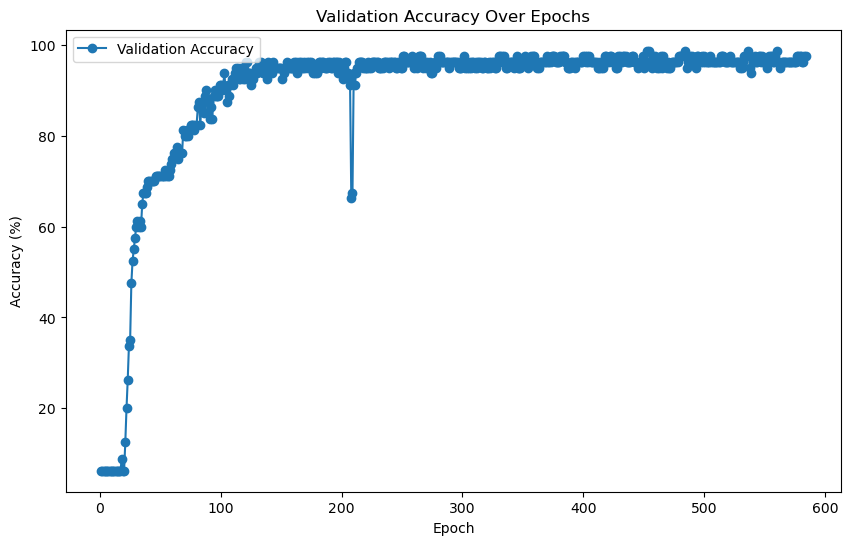


Evaluating on the test set...
    Test Batch [1/209], Loss: 0.0690



Final Test Loss: 0.3175, Test Accuracy: 92.31%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/209 for test dataset.
  Processed batch 20/209 for test dataset.
  Processed batch 30/209 for test dataset.


  Processed batch 40/209 for test dataset.
  Processed batch 50/209 for test dataset.
  Processed batch 60/209 for test dataset.
  Processed batch 70/209 for test dataset.


  Processed batch 80/209 for test dataset.
  Processed batch 90/209 for test dataset.
  Processed batch 100/209 for test dataset.
  Processed batch 110/209 for test dataset.
  Processed batch 120/209 for test dataset.


  Processed batch 130/209 for test dataset.
  Processed batch 140/209 for test dataset.
  Processed batch 150/209 for test dataset.
  Processed batch 160/209 for test dataset.
  Processed batch 170/209 for test dataset.


  Processed batch 180/209 for test dataset.
  Processed batch 190/209 for test dataset.
  Processed batch 200/209 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 640 samples with 64 features each
LOG: Labels shape: (640,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 53409 samples with 64 features each
LOG: Labels shape: (53409,)

LOG: Training features shape: (640, 64), Training labels shape: (640,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (53409, 64), Test labels shape: (53409,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 92.50%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       0.83      1.00      0.91         5
           7       0.67      0.80      0.73         5
           8       1.00      0.

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 640 samples with 64 features each
LOG: Labels shape: (640,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53409 samples with 64 features each
LOG: Labels shape: (53409,)
Train reps shape: (640, 64)
Train labels shape: (640,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (53409, 64)
Test labels shape: (53409,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8424  |  Val Loss: 2.6001
Validation loss improved from inf to 2.6001.
[Epoch 2/1000] Train Loss: 2.5343  |  Val Loss: 2.4088
Validation loss improved from 2.6001 to 2.4088.
[Epoch 3/1000] Train Loss: 2.3262  |  Val Loss: 2.2007
Validation loss improved from 2.4088 to 2.2007.
[Epoch 4/1000] Train Loss: 2.1094  |  Val Loss: 1.9651
Validation loss improved from 2.2007 to 1.9651.
[Epoch 5/1000] Train Loss: 1.8594  |  Val Loss: 1.7136
Validation loss improved from 1.9651 to 1.7136.
[Epoch 6/1000] Train Loss: 1.6100  |  Val Loss: 1.4608
Validation loss improved from 1.7136 to 1.4608.


[Epoch 7/1000] Train Loss: 1.3698  |  Val Loss: 1.2410
Validation loss improved from 1.4608 to 1.2410.
[Epoch 8/1000] Train Loss: 1.1429  |  Val Loss: 1.0218
Validation loss improved from 1.2410 to 1.0218.
[Epoch 9/1000] Train Loss: 0.9513  |  Val Loss: 0.8690
Validation loss improved from 1.0218 to 0.8690.
[Epoch 10/1000] Train Loss: 0.8113  |  Val Loss: 0.7490
Validation loss improved from 0.8690 to 0.7490.
[Epoch 11/1000] Train Loss: 0.6996  |  Val Loss: 0.6767
Validation loss improved from 0.7490 to 0.6767.


[Epoch 12/1000] Train Loss: 0.6291  |  Val Loss: 0.6283
Validation loss improved from 0.6767 to 0.6283.
[Epoch 13/1000] Train Loss: 0.5906  |  Val Loss: 0.6190
Validation loss improved from 0.6283 to 0.6190.
[Epoch 14/1000] Train Loss: 0.5430  |  Val Loss: 0.5720
Validation loss improved from 0.6190 to 0.5720.
[Epoch 15/1000] Train Loss: 0.5234  |  Val Loss: 0.5516
Validation loss improved from 0.5720 to 0.5516.
[Epoch 16/1000] Train Loss: 0.4815  |  Val Loss: 0.5271
Validation loss improved from 0.5516 to 0.5271.
[Epoch 17/1000] Train Loss: 0.4572  |  Val Loss: 0.5227
Validation loss improved from 0.5271 to 0.5227.


[Epoch 18/1000] Train Loss: 0.4486  |  Val Loss: 0.4823
Validation loss improved from 0.5227 to 0.4823.
[Epoch 19/1000] Train Loss: 0.4195  |  Val Loss: 0.4688
Validation loss improved from 0.4823 to 0.4688.
[Epoch 20/1000] Train Loss: 0.3953  |  Val Loss: 0.5071
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 21/1000] Train Loss: 0.3986  |  Val Loss: 0.4407
Validation loss improved from 0.4688 to 0.4407.
[Epoch 22/1000] Train Loss: 0.3799  |  Val Loss: 0.4381
Validation loss improved from 0.4407 to 0.4381.


[Epoch 23/1000] Train Loss: 0.3656  |  Val Loss: 0.4447
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 24/1000] Train Loss: 0.3391  |  Val Loss: 0.4051
Validation loss improved from 0.4381 to 0.4051.
[Epoch 25/1000] Train Loss: 0.3390  |  Val Loss: 0.4428
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 26/1000] Train Loss: 0.3259  |  Val Loss: 0.3975
Validation loss improved from 0.4051 to 0.3975.


[Epoch 27/1000] Train Loss: 0.3154  |  Val Loss: 0.4042
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 28/1000] Train Loss: 0.3180  |  Val Loss: 0.4210
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 29/1000] Train Loss: 0.3144  |  Val Loss: 0.4426
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 30/1000] Train Loss: 0.2982  |  Val Loss: 0.4012
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 31/1000] Train Loss: 0.2894  |  Val Loss: 0.4119
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 32/1000] Train Loss: 0.3006  |  Val Loss: 0.4119
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 33/1000] Train Loss: 0.2871  |  Val Loss: 0.3821
Validation loss improved from 0.3975 to 0.3821.
[Epoch 34/1000] Train Loss: 0.2714  |  Val Loss: 0.3847
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 35/1000] Train Loss: 0.2756  |  Val Loss: 0.3725
Validation loss improved from 0.3821 to 0.3725.
[Epoch 36/1000] Train Loss: 0.2600  |  Val Loss: 0.3909
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 37/1000] Train Loss: 0.2578  |  Val Loss: 0.3945
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 38/1000] Train Loss: 0.2731  |  Val Loss: 0.4202
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 39/1000] Train Loss: 0.2610  |  Val Loss: 0.4545
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 40/1000] Train Loss: 0.2512  |  Val Loss: 0.3546
Validation loss improved from 0.3725 to 0.3546.
[Epoch 41/1000] Train Loss: 0.2520  |  Val Loss: 0.3893
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 42/1000] Train Loss: 0.2360  |  Val Loss: 0.4053
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 43/1000] Train Loss: 0.2290  |  Val Loss: 0.3609
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 44/1000] Train Loss: 0.2275  |  Val Loss: 0.3654
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 45/1000] Train Loss: 0.2305  |  Val Loss: 0.3742
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 46/1000] Train Loss: 0.2315  |  Val Loss: 0.3872
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 47/1000] Train Loss: 0.2261  |  Val Loss: 0.3543
Validation loss improved from 0.3546 to 0.3543.


[Epoch 48/1000] Train Loss: 0.2213  |  Val Loss: 0.3575
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 49/1000] Train Loss: 0.2148  |  Val Loss: 0.4098
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 50/1000] Train Loss: 0.2224  |  Val Loss: 0.3771
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 51/1000] Train Loss: 0.2151  |  Val Loss: 0.3784
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 52/1000] Train Loss: 0.2001  |  Val Loss: 0.3612
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 53/1000] Train Loss: 0.1990  |  Val Loss: 0.3630
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 54/1000] Train Loss: 0.2075  |  Val Loss: 0.3597
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 55/1000] Train Loss: 0.2218  |  Val Loss: 0.4755
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 56/1000] Train Loss: 0.2419  |  Val Loss: 0.3540
Validation loss improved from 0.3543 to 0.3540.
[Epoch 57/1000] Train Loss: 0.2068  |  Val Loss: 0.3522
Validation loss improved from 0.3540 to 0.3522.
[Epoch 58/1000] Train Loss: 0.2248  |  Val Loss: 0.4826
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 59/1000] Train Loss: 0.2310  |  Val Loss: 0.3585
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 60/1000] Train Loss: 0.2083  |  Val Loss: 0.3547
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 61/1000] Train Loss: 0.2012  |  Val Loss: 0.3554
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 62/1000] Train Loss: 0.1891  |  Val Loss: 0.4132
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 63/1000] Train Loss: 0.1908  |  Val Loss: 0.3446
Validation loss improved from 0.3522 to 0.3446.


[Epoch 64/1000] Train Loss: 0.1846  |  Val Loss: 0.3481
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 65/1000] Train Loss: 0.1841  |  Val Loss: 0.3860
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 66/1000] Train Loss: 0.1761  |  Val Loss: 0.3583
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 67/1000] Train Loss: 0.1785  |  Val Loss: 0.4064
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 68/1000] Train Loss: 0.1904  |  Val Loss: 0.3878
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 69/1000] Train Loss: 0.1725  |  Val Loss: 0.3753
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 70/1000] Train Loss: 0.1758  |  Val Loss: 0.3408
Validation loss improved from 0.3446 to 0.3408.
[Epoch 71/1000] Train Loss: 0.1690  |  Val Loss: 0.3696
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 72/1000] Train Loss: 0.1894  |  Val Loss: 0.3854
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 73/1000] Train Loss: 0.1902  |  Val Loss: 0.4070
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 74/1000] Train Loss: 0.1802  |  Val Loss: 0.3516
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 75/1000] Train Loss: 0.1755  |  Val Loss: 0.3719
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 76/1000] Train Loss: 0.1784  |  Val Loss: 0.3750
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 77/1000] Train Loss: 0.1906  |  Val Loss: 0.3694
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 78/1000] Train Loss: 0.1852  |  Val Loss: 0.3561
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 79/1000] Train Loss: 0.1781  |  Val Loss: 0.3810
!! Validation loss did NOT improve !! Patience: 9/100


[Epoch 80/1000] Train Loss: 0.1791  |  Val Loss: 0.4349
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 81/1000] Train Loss: 0.1645  |  Val Loss: 0.3373
Validation loss improved from 0.3408 to 0.3373.
[Epoch 82/1000] Train Loss: 0.1734  |  Val Loss: 0.3709
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 83/1000] Train Loss: 0.1570  |  Val Loss: 0.3747
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 84/1000] Train Loss: 0.1564  |  Val Loss: 0.4107
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 85/1000] Train Loss: 0.1664  |  Val Loss: 0.3880
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 86/1000] Train Loss: 0.1576  |  Val Loss: 0.3973
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 87/1000] Train Loss: 0.1629  |  Val Loss: 0.3682
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 88/1000] Train Loss: 0.1676  |  Val Loss: 0.3443
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 89/1000] Train Loss: 0.1590  |  Val Loss: 0.3935
!! Validation loss did NOT improve !! Patience: 8/100


[Epoch 90/1000] Train Loss: 0.1632  |  Val Loss: 0.4350
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 91/1000] Train Loss: 0.1488  |  Val Loss: 0.3525
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 92/1000] Train Loss: 0.1464  |  Val Loss: 0.3895
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 93/1000] Train Loss: 0.1494  |  Val Loss: 0.4081
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 94/1000] Train Loss: 0.1473  |  Val Loss: 0.3602
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 95/1000] Train Loss: 0.1443  |  Val Loss: 0.3711
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 96/1000] Train Loss: 0.1552  |  Val Loss: 0.3956
!! Validation loss did NOT improve !! Patience: 15/100


[Epoch 97/1000] Train Loss: 0.1485  |  Val Loss: 0.3825
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 98/1000] Train Loss: 0.1462  |  Val Loss: 0.3970
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 99/1000] Train Loss: 0.1385  |  Val Loss: 0.3743
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 100/1000] Train Loss: 0.1407  |  Val Loss: 0.3729
!! Validation loss did NOT improve !! Patience: 19/100


[Epoch 101/1000] Train Loss: 0.1402  |  Val Loss: 0.3902
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 102/1000] Train Loss: 0.1441  |  Val Loss: 0.4127
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 103/1000] Train Loss: 0.1540  |  Val Loss: 0.4009
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 104/1000] Train Loss: 0.1461  |  Val Loss: 0.3920
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 105/1000] Train Loss: 0.1557  |  Val Loss: 0.4099
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 106/1000] Train Loss: 0.1628  |  Val Loss: 0.4094
!! Validation loss did NOT improve !! Patience: 25/100


[Epoch 107/1000] Train Loss: 0.1568  |  Val Loss: 0.4708
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 108/1000] Train Loss: 0.1489  |  Val Loss: 0.3693
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 109/1000] Train Loss: 0.1334  |  Val Loss: 0.4067
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 110/1000] Train Loss: 0.1717  |  Val Loss: 0.4594
!! Validation loss did NOT improve !! Patience: 29/100


[Epoch 111/1000] Train Loss: 0.1586  |  Val Loss: 0.3640
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 112/1000] Train Loss: 0.1388  |  Val Loss: 0.3905
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 113/1000] Train Loss: 0.1311  |  Val Loss: 0.4104
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 114/1000] Train Loss: 0.1478  |  Val Loss: 0.3847
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 115/1000] Train Loss: 0.1351  |  Val Loss: 0.4498
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 116/1000] Train Loss: 0.1364  |  Val Loss: 0.3545
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 117/1000] Train Loss: 0.1279  |  Val Loss: 0.4287
!! Validation loss did NOT improve !! Patience: 36/100


[Epoch 118/1000] Train Loss: 0.1282  |  Val Loss: 0.3973
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 119/1000] Train Loss: 0.1268  |  Val Loss: 0.4154
!! Validation loss did NOT improve !! Patience: 38/100


[Epoch 120/1000] Train Loss: 0.1221  |  Val Loss: 0.4222
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 121/1000] Train Loss: 0.1262  |  Val Loss: 0.4389
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 122/1000] Train Loss: 0.1233  |  Val Loss: 0.3996
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 123/1000] Train Loss: 0.1360  |  Val Loss: 0.3860
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 124/1000] Train Loss: 0.1273  |  Val Loss: 0.4415
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 125/1000] Train Loss: 0.1179  |  Val Loss: 0.3874
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 126/1000] Train Loss: 0.1226  |  Val Loss: 0.3970
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 127/1000] Train Loss: 0.1265  |  Val Loss: 0.4136
!! Validation loss did NOT improve !! Patience: 46/100


[Epoch 128/1000] Train Loss: 0.1306  |  Val Loss: 0.4085
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 129/1000] Train Loss: 0.1277  |  Val Loss: 0.4347
!! Validation loss did NOT improve !! Patience: 48/100


[Epoch 130/1000] Train Loss: 0.1335  |  Val Loss: 0.4008
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 131/1000] Train Loss: 0.1259  |  Val Loss: 0.3748
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 132/1000] Train Loss: 0.1213  |  Val Loss: 0.4634
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 133/1000] Train Loss: 0.1232  |  Val Loss: 0.4174
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 134/1000] Train Loss: 0.1247  |  Val Loss: 0.4119
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 135/1000] Train Loss: 0.1311  |  Val Loss: 0.3935
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 136/1000] Train Loss: 0.1360  |  Val Loss: 0.4091
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 137/1000] Train Loss: 0.1177  |  Val Loss: 0.4407
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 138/1000] Train Loss: 0.1119  |  Val Loss: 0.4296
!! Validation loss did NOT improve !! Patience:

[Epoch 139/1000] Train Loss: 0.1099  |  Val Loss: 0.4011
!! Validation loss did NOT improve !! Patience: 58/100


[Epoch 140/1000] Train Loss: 0.1091  |  Val Loss: 0.4784
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 141/1000] Train Loss: 0.1258  |  Val Loss: 0.4145
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 142/1000] Train Loss: 0.1121  |  Val Loss: 0.4174
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 143/1000] Train Loss: 0.1094  |  Val Loss: 0.4109
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 144/1000] Train Loss: 0.1108  |  Val Loss: 0.4672
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 145/1000] Train Loss: 0.1177  |  Val Loss: 0.4280
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 146/1000] Train Loss: 0.1111  |  Val Loss: 0.4275
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 147/1000] Train Loss: 0.1153  |  Val Loss: 0.4070
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 148/1000] Train Loss: 0.1042  |  Val Loss: 0.3958
!! Validation loss did NOT improve !! Patience:

[Epoch 149/1000] Train Loss: 0.1033  |  Val Loss: 0.4720
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 150/1000] Train Loss: 0.1099  |  Val Loss: 0.4417
!! Validation loss did NOT improve !! Patience: 69/100


[Epoch 151/1000] Train Loss: 0.1220  |  Val Loss: 0.4037
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 152/1000] Train Loss: 0.1284  |  Val Loss: 0.4440
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 153/1000] Train Loss: 0.0979  |  Val Loss: 0.4218
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 154/1000] Train Loss: 0.1003  |  Val Loss: 0.4757
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 155/1000] Train Loss: 0.1103  |  Val Loss: 0.4298
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 156/1000] Train Loss: 0.1061  |  Val Loss: 0.3783
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 157/1000] Train Loss: 0.1203  |  Val Loss: 0.4447
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 158/1000] Train Loss: 0.0983  |  Val Loss: 0.4246
!! Validation loss did NOT improve !! Patience: 77/100


[Epoch 159/1000] Train Loss: 0.0951  |  Val Loss: 0.4099
!! Validation loss did NOT improve !! Patience: 78/100


[Epoch 160/1000] Train Loss: 0.1032  |  Val Loss: 0.4082
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 161/1000] Train Loss: 0.0996  |  Val Loss: 0.4427
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 162/1000] Train Loss: 0.0877  |  Val Loss: 0.4042
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 163/1000] Train Loss: 0.0958  |  Val Loss: 0.4715
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 164/1000] Train Loss: 0.1216  |  Val Loss: 0.4812
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 165/1000] Train Loss: 0.1159  |  Val Loss: 0.4582
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 166/1000] Train Loss: 0.0931  |  Val Loss: 0.4291
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 167/1000] Train Loss: 0.0939  |  Val Loss: 0.4351
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 168/1000] Train Loss: 0.0881  |  Val Loss: 0.4784
!! Validation loss did NOT improve !! Patience:

[Epoch 169/1000] Train Loss: 0.0906  |  Val Loss: 0.4169
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 170/1000] Train Loss: 0.0986  |  Val Loss: 0.4346
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 171/1000] Train Loss: 0.0935  |  Val Loss: 0.4823
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 172/1000] Train Loss: 0.0950  |  Val Loss: 0.4638
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 173/1000] Train Loss: 0.1008  |  Val Loss: 0.4562
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 174/1000] Train Loss: 0.0861  |  Val Loss: 0.4489
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 175/1000] Train Loss: 0.0902  |  Val Loss: 0.4890
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 176/1000] Train Loss: 0.1072  |  Val Loss: 0.4626
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 177/1000] Train Loss: 0.0917  |  Val Loss: 0.4400
!! Validation loss did NOT improve !! Patience:

[Epoch 179/1000] Train Loss: 0.1109  |  Val Loss: 0.4310
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 180/1000] Train Loss: 0.0942  |  Val Loss: 0.4471
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 181/1000] Train Loss: 0.0864  |  Val Loss: 0.4388
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 181 !!
No improvement for 100 epochs.


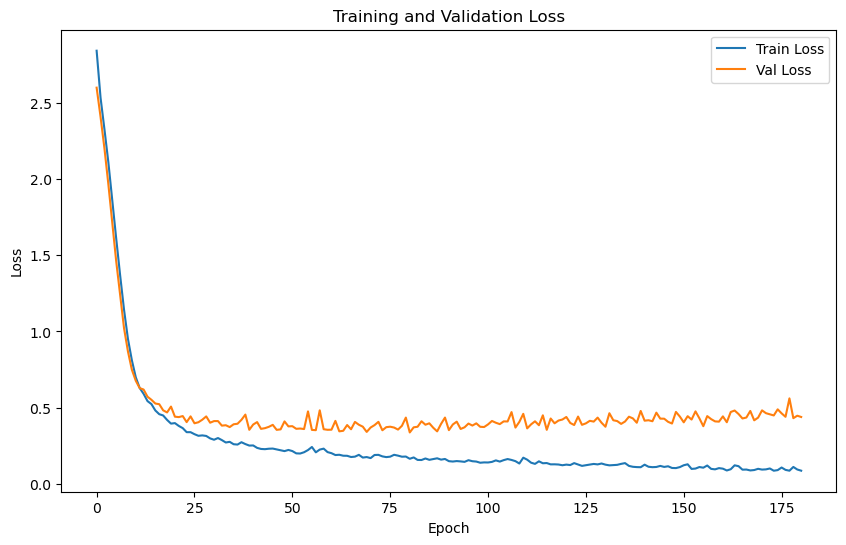

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.5025 | Test Accuracy: 86.29%


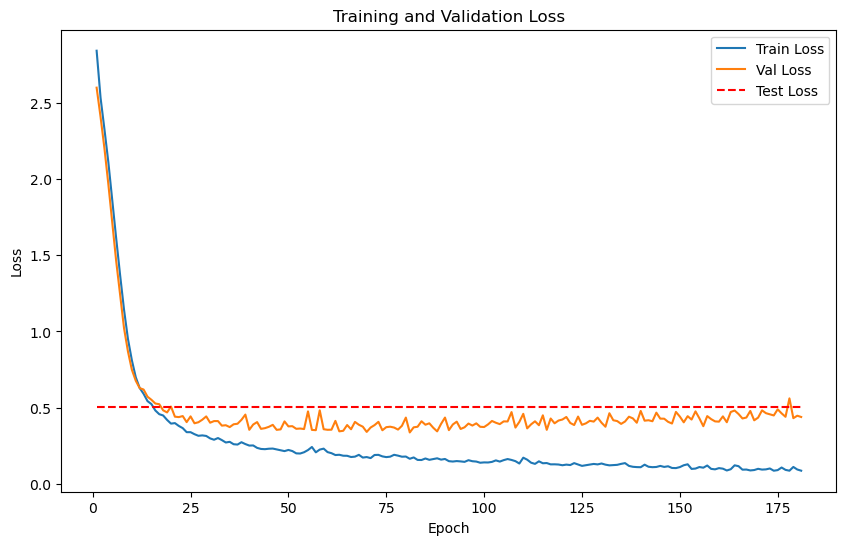

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 640 samples with 64 features each
LOG: Labels shape: (640,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53409 samples with 64 features each
LOG: Labels shape: (53409,)


Train embeddings shape: (640, 64), 
Train labels shape: (640,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53409, 64), 
Test labels shape: (53409,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/2], Train Loss: 7.7985
    Batch [2/2], Train Loss: 7.8495
Epoch [1/2000], Avg Train Loss: 7.8240
Epoch [1/2000], Avg Val Loss: 3.2525
Validation loss improved from inf to 3.2525. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 7.8892
    Batch [2/2], Train Loss: 7.7216
Epoch [2/2000], Avg Train Loss: 7.8054
Epoch [2/2000], Avg Val Loss: 3.2246
Validation loss improved from 3.2525 to 3.2246. Saving model...

LOG: Epoch [3/2000] - Training


    Batch [1/2], Train Loss: 7.6653
    Batch [2/2], Train Loss: 7.5886
Epoch [3/2000], Avg Train Loss: 7.6269
Epoch [3/2000], Avg Val Loss: 3.1991
Validation loss improved from 3.2246 to 3.1991. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 7.3338
    Batch [2/2], Train Loss: 7.3476
Epoch [4/2000], Avg Train Loss: 7.3407
Epoch [4/2000], Avg Val Loss: 3.1756
Validation loss improved from 3.1991 to 3.1756. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss: 7.2876
    Batch [2/2], Train Loss: 7.3180
Epoch [5/2000], Avg Train Loss: 7.3028
Epoch [5/2000], Avg Val Loss: 3.1538
Validation loss improved from 3.1756 to 3.1538. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/2], Train Loss: 7.3206
    Batch [2/2], Train Loss: 7.1505
Epoch [6/2000], Avg Train Loss: 7.2356
Epoch [6/2000], Avg Val Loss: 3.1335
Validation loss improved from 3.1538 to 3.1335. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/2], Train L

    Batch [1/2], Train Loss: 6.4634
    Batch [2/2], Train Loss: 6.5769
Epoch [12/2000], Avg Train Loss: 6.5201
Epoch [12/2000], Avg Val Loss: 3.0399
Validation loss improved from 3.0523 to 3.0399. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 6.6156
    Batch [2/2], Train Loss: 6.3464
Epoch [13/2000], Avg Train Loss: 6.4810
Epoch [13/2000], Avg Val Loss: 3.0286
Validation loss improved from 3.0399 to 3.0286. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/2], Train Loss: 6.3955
    Batch [2/2], Train Loss: 6.3854
Epoch [14/2000], Avg Train Loss: 6.3905
Epoch [14/2000], Avg Val Loss: 3.0183
Validation loss improved from 3.0286 to 3.0183. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 6.3728
    Batch [2/2], Train Loss: 6.3833
Epoch [15/2000], Avg Train Loss: 6.3781
Epoch [15/2000], Avg Val Loss: 3.0088
Validation loss improved from 3.0183 to 3.0088. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 5.7207
    Batch [2/2], Train Loss: 5.6804
Epoch [23/2000], Avg Train Loss: 5.7006
Epoch [23/2000], Avg Val Loss: 2.9568
Validation loss improved from 2.9615 to 2.9568. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/2], Train Loss: 5.6020
    Batch [2/2], Train Loss: 5.6892
Epoch [24/2000], Avg Train Loss: 5.6456
Epoch [24/2000], Avg Val Loss: 2.9525
Validation loss improved from 2.9568 to 2.9525. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/2], Train Loss: 5.7294
    Batch [2/2], Train Loss: 5.6452
Epoch [25/2000], Avg Train Loss: 5.6873
Epoch [25/2000], Avg Val Loss: 2.9484
Validation loss improved from 2.9525 to 2.9484. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/2], Train Loss: 5.6248
    Batch [2/2], Train Loss: 5.6229
Epoch [26/2000], Avg Train Loss: 5.6239
Epoch [26/2000], Avg Val Loss: 2.9445
Validation loss improved from 2.9484 to 2.9445. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 5.3908
Epoch [31/2000], Avg Train Loss: 5.4026
Epoch [31/2000], Avg Val Loss: 2.9282
Validation loss improved from 2.9312 to 2.9282. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/2], Train Loss: 5.2867
    Batch [2/2], Train Loss: 5.3806
Epoch [32/2000], Avg Train Loss: 5.3337
Epoch [32/2000], Avg Val Loss: 2.9254
Validation loss improved from 2.9282 to 2.9254. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/2], Train Loss: 5.2703
    Batch [2/2], Train Loss: 5.3126
Epoch [33/2000], Avg Train Loss: 5.2915
Epoch [33/2000], Avg Val Loss: 2.9226
Validation loss improved from 2.9254 to 2.9226. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/2], Train Loss: 5.4150
    Batch [2/2], Train Loss: 5.3607
Epoch [34/2000], Avg Train Loss: 5.3878
Epoch [34/2000], Avg Val Loss: 2.9199
Validation loss improved from 2.9226 to 2.9199. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/2], Train Loss: 5.2815
    Batch [2

    Batch [2/2], Train Loss: 5.0770
Epoch [43/2000], Avg Train Loss: 5.0501
Epoch [43/2000], Avg Val Loss: 2.8974
Validation loss improved from 2.8998 to 2.8974. Saving model...

LOG: Epoch [44/2000] - Training
    Batch [1/2], Train Loss: 4.9945
    Batch [2/2], Train Loss: 4.9928
Epoch [44/2000], Avg Train Loss: 4.9936
Epoch [44/2000], Avg Val Loss: 2.8949
Validation loss improved from 2.8974 to 2.8949. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1/2], Train Loss: 5.1666
    Batch [2/2], Train Loss: 5.0662
Epoch [45/2000], Avg Train Loss: 5.1164
Epoch [45/2000], Avg Val Loss: 2.8925
Validation loss improved from 2.8949 to 2.8925. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/2], Train Loss: 5.0246
    Batch [2/2], Train Loss: 4.9819
Epoch [46/2000], Avg Train Loss: 5.0033
Epoch [46/2000], Avg Val Loss: 2.8901
Validation loss improved from 2.8925 to 2.8901. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/2], Train Loss: 5.0826
    Batch [2

    Batch [1/2], Train Loss: 4.8501
    Batch [2/2], Train Loss: 4.9466
Epoch [52/2000], Avg Train Loss: 4.8984
Epoch [52/2000], Avg Val Loss: 2.8742
Validation loss improved from 2.8769 to 2.8742. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/2], Train Loss: 4.9372
    Batch [2/2], Train Loss: 4.9612
Epoch [53/2000], Avg Train Loss: 4.9492
Epoch [53/2000], Avg Val Loss: 2.8714
Validation loss improved from 2.8742 to 2.8714. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/2], Train Loss: 4.9312
    Batch [2/2], Train Loss: 4.9406
Epoch [54/2000], Avg Train Loss: 4.9359
Epoch [54/2000], Avg Val Loss: 2.8688
Validation loss improved from 2.8714 to 2.8688. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 4.9155
    Batch [2/2], Train Loss: 4.8386
Epoch [55/2000], Avg Train Loss: 4.8770
Epoch [55/2000], Avg Val Loss: 2.8662
Validation loss improved from 2.8688 to 2.8662. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1

Epoch [63/2000], Avg Val Loss: 2.8451
Validation loss improved from 2.8477 to 2.8451. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/2], Train Loss: 4.8291
    Batch [2/2], Train Loss: 4.7620
Epoch [64/2000], Avg Train Loss: 4.7955
Epoch [64/2000], Avg Val Loss: 2.8425
Validation loss improved from 2.8451 to 2.8425. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/2], Train Loss: 4.8350
    Batch [2/2], Train Loss: 4.8528
Epoch [65/2000], Avg Train Loss: 4.8439
Epoch [65/2000], Avg Val Loss: 2.8399
Validation loss improved from 2.8425 to 2.8399. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/2], Train Loss: 4.7634
    Batch [2/2], Train Loss: 4.7850
Epoch [66/2000], Avg Train Loss: 4.7742
Epoch [66/2000], Avg Val Loss: 2.8373
Validation loss improved from 2.8399 to 2.8373. Saving model...

LOG: Epoch [67/2000] - Training
    Batch [1/2], Train Loss: 4.7680
    Batch [2/2], Train Loss: 4.7883
Epoch [67/2000], Avg Train Loss: 4.7781
Epoch [67/20

    Batch [2/2], Train Loss: 4.7592
Epoch [72/2000], Avg Train Loss: 4.7286
Epoch [72/2000], Avg Val Loss: 2.8215
Validation loss improved from 2.8241 to 2.8215. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/2], Train Loss: 4.6725
    Batch [2/2], Train Loss: 4.7233
Epoch [73/2000], Avg Train Loss: 4.6979
Epoch [73/2000], Avg Val Loss: 2.8188
Validation loss improved from 2.8215 to 2.8188. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/2], Train Loss: 4.6650
    Batch [2/2], Train Loss: 4.7869
Epoch [74/2000], Avg Train Loss: 4.7259
Epoch [74/2000], Avg Val Loss: 2.8163
Validation loss improved from 2.8188 to 2.8163. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/2], Train Loss: 4.7349
    Batch [2/2], Train Loss: 4.6803
Epoch [75/2000], Avg Train Loss: 4.7076
Epoch [75/2000], Avg Val Loss: 2.8138
Validation loss improved from 2.8163 to 2.8138. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/2], Train Loss: 4.6854
    Batch [2

    Batch [1/2], Train Loss: 4.6305
    Batch [2/2], Train Loss: 4.5760
Epoch [86/2000], Avg Train Loss: 4.6032
Epoch [86/2000], Avg Val Loss: 2.7856
Validation loss improved from 2.7881 to 2.7856. Saving model...

LOG: Epoch [87/2000] - Training
    Batch [1/2], Train Loss: 4.5907
    Batch [2/2], Train Loss: 4.6501
Epoch [87/2000], Avg Train Loss: 4.6204
Epoch [87/2000], Avg Val Loss: 2.7830
Validation loss improved from 2.7856 to 2.7830. Saving model...

LOG: Epoch [88/2000] - Training
    Batch [1/2], Train Loss: 4.6381
    Batch [2/2], Train Loss: 4.5800
Epoch [88/2000], Avg Train Loss: 4.6091
Epoch [88/2000], Avg Val Loss: 2.7806
Validation loss improved from 2.7830 to 2.7806. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/2], Train Loss: 4.6013
    Batch [2/2], Train Loss: 4.6201
Epoch [89/2000], Avg Train Loss: 4.6107
Epoch [89/2000], Avg Val Loss: 2.7781
Validation loss improved from 2.7806 to 2.7781. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 4.5752
    Batch [2/2], Train Loss: 4.6073
Epoch [93/2000], Avg Train Loss: 4.5913
Epoch [93/2000], Avg Val Loss: 2.7685
Validation loss improved from 2.7709 to 2.7685. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/2], Train Loss: 4.5428
    Batch [2/2], Train Loss: 4.5860
Epoch [94/2000], Avg Train Loss: 4.5644
Epoch [94/2000], Avg Val Loss: 2.7661
Validation loss improved from 2.7685 to 2.7661. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/2], Train Loss: 4.5317
    Batch [2/2], Train Loss: 4.5890
Epoch [95/2000], Avg Train Loss: 4.5603
Epoch [95/2000], Avg Val Loss: 2.7638
Validation loss improved from 2.7661 to 2.7638. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/2], Train Loss: 4.5351
    Batch [2/2], Train Loss: 4.5214
Epoch [96/2000], Avg Train Loss: 4.5282
Epoch [96/2000], Avg Val Loss: 2.7614
Validation loss improved from 2.7638 to 2.7614. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 4.5498
Epoch [104/2000], Avg Train Loss: 4.5308
Epoch [104/2000], Avg Val Loss: 2.7422
Validation loss improved from 2.7446 to 2.7422. Saving model...

LOG: Epoch [105/2000] - Training
    Batch [1/2], Train Loss: 4.5264
    Batch [2/2], Train Loss: 4.4881
Epoch [105/2000], Avg Train Loss: 4.5072
Epoch [105/2000], Avg Val Loss: 2.7398
Validation loss improved from 2.7422 to 2.7398. Saving model...

LOG: Epoch [106/2000] - Training
    Batch [1/2], Train Loss: 4.5312
    Batch [2/2], Train Loss: 4.5171
Epoch [106/2000], Avg Train Loss: 4.5242
Epoch [106/2000], Avg Val Loss: 2.7374
Validation loss improved from 2.7398 to 2.7374. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/2], Train Loss: 4.5380
    Batch [2/2], Train Loss: 4.4568
Epoch [107/2000], Avg Train Loss: 4.4974
Epoch [107/2000], Avg Val Loss: 2.7350
Validation loss improved from 2.7374 to 2.7350. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/2], Train Loss: 4.4704


    Batch [1/2], Train Loss: 4.4734
    Batch [2/2], Train Loss: 4.4994
Epoch [115/2000], Avg Train Loss: 4.4864
Epoch [115/2000], Avg Val Loss: 2.7167
Validation loss improved from 2.7191 to 2.7167. Saving model...

LOG: Epoch [116/2000] - Training
    Batch [1/2], Train Loss: 4.4675
    Batch [2/2], Train Loss: 4.4940
Epoch [116/2000], Avg Train Loss: 4.4808
Epoch [116/2000], Avg Val Loss: 2.7144
Validation loss improved from 2.7167 to 2.7144. Saving model...

LOG: Epoch [117/2000] - Training
    Batch [1/2], Train Loss: 4.5034
    Batch [2/2], Train Loss: 4.4520
Epoch [117/2000], Avg Train Loss: 4.4777
Epoch [117/2000], Avg Val Loss: 2.7121
Validation loss improved from 2.7144 to 2.7121. Saving model...

LOG: Epoch [118/2000] - Training
    Batch [1/2], Train Loss: 4.4025
    Batch [2/2], Train Loss: 4.4232
Epoch [118/2000], Avg Train Loss: 4.4128
Epoch [118/2000], Avg Val Loss: 2.7097
Validation loss improved from 2.7121 to 2.7097. Saving model...

LOG: Epoch [119/2000] - Training


    Batch [2/2], Train Loss: 4.4232
Epoch [125/2000], Avg Train Loss: 4.4149
Epoch [125/2000], Avg Val Loss: 2.6942
Validation loss improved from 2.6963 to 2.6942. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/2], Train Loss: 4.4459
    Batch [2/2], Train Loss: 4.4508
Epoch [126/2000], Avg Train Loss: 4.4483
Epoch [126/2000], Avg Val Loss: 2.6922
Validation loss improved from 2.6942 to 2.6922. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/2], Train Loss: 4.4188
    Batch [2/2], Train Loss: 4.3950
Epoch [127/2000], Avg Train Loss: 4.4069
Epoch [127/2000], Avg Val Loss: 2.6900
Validation loss improved from 2.6922 to 2.6900. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/2], Train Loss: 4.3954
    Batch [2/2], Train Loss: 4.3579
Epoch [128/2000], Avg Train Loss: 4.3766
Epoch [128/2000], Avg Val Loss: 2.6879
Validation loss improved from 2.6900 to 2.6879. Saving model...

LOG: Epoch [129/2000] - Training
    Batch [1/2], Train Loss: 4.3412


    Batch [1/2], Train Loss: 4.3796
    Batch [2/2], Train Loss: 4.4024
Epoch [135/2000], Avg Train Loss: 4.3910
Epoch [135/2000], Avg Val Loss: 2.6730
Validation loss improved from 2.6751 to 2.6730. Saving model...

LOG: Epoch [136/2000] - Training
    Batch [1/2], Train Loss: 4.3582
    Batch [2/2], Train Loss: 4.3740
Epoch [136/2000], Avg Train Loss: 4.3661
Epoch [136/2000], Avg Val Loss: 2.6710
Validation loss improved from 2.6730 to 2.6710. Saving model...

LOG: Epoch [137/2000] - Training
    Batch [1/2], Train Loss: 4.3849
    Batch [2/2], Train Loss: 4.3328
Epoch [137/2000], Avg Train Loss: 4.3588
Epoch [137/2000], Avg Val Loss: 2.6689
Validation loss improved from 2.6710 to 2.6689. Saving model...

LOG: Epoch [138/2000] - Training
    Batch [1/2], Train Loss: 4.3063
    Batch [2/2], Train Loss: 4.3662
Epoch [138/2000], Avg Train Loss: 4.3363
Epoch [138/2000], Avg Val Loss: 2.6668
Validation loss improved from 2.6689 to 2.6668. Saving model...

LOG: Epoch [139/2000] - Training


    Batch [1/2], Train Loss: 4.2962
    Batch [2/2], Train Loss: 4.3214
Epoch [145/2000], Avg Train Loss: 4.3088
Epoch [145/2000], Avg Val Loss: 2.6521
Validation loss improved from 2.6543 to 2.6521. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/2], Train Loss: 4.3399
    Batch [2/2], Train Loss: 4.2896
Epoch [146/2000], Avg Train Loss: 4.3147
Epoch [146/2000], Avg Val Loss: 2.6500
Validation loss improved from 2.6521 to 2.6500. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/2], Train Loss: 4.3489
    Batch [2/2], Train Loss: 4.3539
Epoch [147/2000], Avg Train Loss: 4.3514
Epoch [147/2000], Avg Val Loss: 2.6478
Validation loss improved from 2.6500 to 2.6478. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/2], Train Loss: 4.3356
    Batch [2/2], Train Loss: 4.3361
Epoch [148/2000], Avg Train Loss: 4.3359
Epoch [148/2000], Avg Val Loss: 2.6457
Validation loss improved from 2.6478 to 2.6457. Saving model...

LOG: Epoch [149/2000] - Training


    Batch [2/2], Train Loss: 4.3111
Epoch [155/2000], Avg Train Loss: 4.3119
Epoch [155/2000], Avg Val Loss: 2.6317
Validation loss improved from 2.6337 to 2.6317. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/2], Train Loss: 4.3205
    Batch [2/2], Train Loss: 4.2658
Epoch [156/2000], Avg Train Loss: 4.2931
Epoch [156/2000], Avg Val Loss: 2.6297
Validation loss improved from 2.6317 to 2.6297. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/2], Train Loss: 4.3090
    Batch [2/2], Train Loss: 4.2687
Epoch [157/2000], Avg Train Loss: 4.2889
Epoch [157/2000], Avg Val Loss: 2.6276
Validation loss improved from 2.6297 to 2.6276. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/2], Train Loss: 4.2828
    Batch [2/2], Train Loss: 4.3185
Epoch [158/2000], Avg Train Loss: 4.3007
Epoch [158/2000], Avg Val Loss: 2.6254
Validation loss improved from 2.6276 to 2.6254. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/2], Train Loss: 4.3310


    Batch [1/2], Train Loss: 4.3166
    Batch [2/2], Train Loss: 4.2826
Epoch [165/2000], Avg Train Loss: 4.2996
Epoch [165/2000], Avg Val Loss: 2.6094
Validation loss improved from 2.6116 to 2.6094. Saving model...

LOG: Epoch [166/2000] - Training
    Batch [1/2], Train Loss: 4.2900
    Batch [2/2], Train Loss: 4.2758
Epoch [166/2000], Avg Train Loss: 4.2829
Epoch [166/2000], Avg Val Loss: 2.6072
Validation loss improved from 2.6094 to 2.6072. Saving model...

LOG: Epoch [167/2000] - Training
    Batch [1/2], Train Loss: 4.2614
    Batch [2/2], Train Loss: 4.3115
Epoch [167/2000], Avg Train Loss: 4.2864
Epoch [167/2000], Avg Val Loss: 2.6051
Validation loss improved from 2.6072 to 2.6051. Saving model...

LOG: Epoch [168/2000] - Training
    Batch [1/2], Train Loss: 4.2929
    Batch [2/2], Train Loss: 4.2595
Epoch [168/2000], Avg Train Loss: 4.2762
Epoch [168/2000], Avg Val Loss: 2.6032
Validation loss improved from 2.6051 to 2.6032. Saving model...

LOG: Epoch [169/2000] - Training


    Batch [1/2], Train Loss: 4.2778
    Batch [2/2], Train Loss: 4.2819
Epoch [175/2000], Avg Train Loss: 4.2798
Epoch [175/2000], Avg Val Loss: 2.5897
Validation loss improved from 2.5916 to 2.5897. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/2], Train Loss: 4.2713
    Batch [2/2], Train Loss: 4.2479
Epoch [176/2000], Avg Train Loss: 4.2596
Epoch [176/2000], Avg Val Loss: 2.5878
Validation loss improved from 2.5897 to 2.5878. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/2], Train Loss: 4.2562
    Batch [2/2], Train Loss: 4.2239
Epoch [177/2000], Avg Train Loss: 4.2401
Epoch [177/2000], Avg Val Loss: 2.5858
Validation loss improved from 2.5878 to 2.5858. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/2], Train Loss: 4.1601
    Batch [2/2], Train Loss: 4.2159
Epoch [178/2000], Avg Train Loss: 4.1880
Epoch [178/2000], Avg Val Loss: 2.5839
Validation loss improved from 2.5858 to 2.5839. Saving model...

LOG: Epoch [179/2000] - Training


Epoch [184/2000], Avg Val Loss: 2.5730
Validation loss improved from 2.5748 to 2.5730. Saving model...

LOG: Epoch [185/2000] - Training
    Batch [1/2], Train Loss: 4.2277
    Batch [2/2], Train Loss: 4.2381
Epoch [185/2000], Avg Train Loss: 4.2329
Epoch [185/2000], Avg Val Loss: 2.5714
Validation loss improved from 2.5730 to 2.5714. Saving model...

LOG: Epoch [186/2000] - Training
    Batch [1/2], Train Loss: 4.1838
    Batch [2/2], Train Loss: 4.1904
Epoch [186/2000], Avg Train Loss: 4.1871
Epoch [186/2000], Avg Val Loss: 2.5696
Validation loss improved from 2.5714 to 2.5696. Saving model...

LOG: Epoch [187/2000] - Training
    Batch [1/2], Train Loss: 4.2218
    Batch [2/2], Train Loss: 4.2268
Epoch [187/2000], Avg Train Loss: 4.2243
Epoch [187/2000], Avg Val Loss: 2.5679
Validation loss improved from 2.5696 to 2.5679. Saving model...

LOG: Epoch [188/2000] - Training
    Batch [1/2], Train Loss: 4.1978
    Batch [2/2], Train Loss: 4.2157
Epoch [188/2000], Avg Train Loss: 4.2067


Epoch [195/2000], Avg Val Loss: 2.5541
Validation loss improved from 2.5559 to 2.5541. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/2], Train Loss: 4.1713
    Batch [2/2], Train Loss: 4.2215
Epoch [196/2000], Avg Train Loss: 4.1964
Epoch [196/2000], Avg Val Loss: 2.5523
Validation loss improved from 2.5541 to 2.5523. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/2], Train Loss: 4.1612
    Batch [2/2], Train Loss: 4.1528
Epoch [197/2000], Avg Train Loss: 4.1570
Epoch [197/2000], Avg Val Loss: 2.5505
Validation loss improved from 2.5523 to 2.5505. Saving model...

LOG: Epoch [198/2000] - Training
    Batch [1/2], Train Loss: 4.1836
    Batch [2/2], Train Loss: 4.1669
Epoch [198/2000], Avg Train Loss: 4.1752
Epoch [198/2000], Avg Val Loss: 2.5486
Validation loss improved from 2.5505 to 2.5486. Saving model...

LOG: Epoch [199/2000] - Training
    Batch [1/2], Train Loss: 4.2351
    Batch [2/2], Train Loss: 4.1267
Epoch [199/2000], Avg Train Loss: 4.1809


    Batch [1/2], Train Loss: 4.2138
    Batch [2/2], Train Loss: 4.2156
Epoch [206/2000], Avg Train Loss: 4.2147
Epoch [206/2000], Avg Val Loss: 2.5329
Validation loss improved from 2.5349 to 2.5329. Saving model...

LOG: Epoch [207/2000] - Training
    Batch [1/2], Train Loss: 4.1780
    Batch [2/2], Train Loss: 4.1249
Epoch [207/2000], Avg Train Loss: 4.1515
Epoch [207/2000], Avg Val Loss: 2.5310
Validation loss improved from 2.5329 to 2.5310. Saving model...

LOG: Epoch [208/2000] - Training
    Batch [1/2], Train Loss: 4.0933
    Batch [2/2], Train Loss: 4.1559
Epoch [208/2000], Avg Train Loss: 4.1246
Epoch [208/2000], Avg Val Loss: 2.5291
Validation loss improved from 2.5310 to 2.5291. Saving model...

LOG: Epoch [209/2000] - Training
    Batch [1/2], Train Loss: 4.1286
    Batch [2/2], Train Loss: 4.1798
Epoch [209/2000], Avg Train Loss: 4.1542
Epoch [209/2000], Avg Val Loss: 2.5272
Validation loss improved from 2.5291 to 2.5272. Saving model...

LOG: Epoch [210/2000] - Training


    Batch [1/2], Train Loss: 4.1005
    Batch [2/2], Train Loss: 4.1456
Epoch [215/2000], Avg Train Loss: 4.1231
Epoch [215/2000], Avg Val Loss: 2.5158
Validation loss improved from 2.5178 to 2.5158. Saving model...

LOG: Epoch [216/2000] - Training
    Batch [1/2], Train Loss: 4.1832
    Batch [2/2], Train Loss: 4.1233
Epoch [216/2000], Avg Train Loss: 4.1533
Epoch [216/2000], Avg Val Loss: 2.5138
Validation loss improved from 2.5158 to 2.5138. Saving model...

LOG: Epoch [217/2000] - Training
    Batch [1/2], Train Loss: 4.1285
    Batch [2/2], Train Loss: 4.1163
Epoch [217/2000], Avg Train Loss: 4.1224
Epoch [217/2000], Avg Val Loss: 2.5119
Validation loss improved from 2.5138 to 2.5119. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/2], Train Loss: 4.1031
    Batch [2/2], Train Loss: 4.0905
Epoch [218/2000], Avg Train Loss: 4.0968
Epoch [218/2000], Avg Val Loss: 2.5100
Validation loss improved from 2.5119 to 2.5100. Saving model...

LOG: Epoch [219/2000] - Training


    Batch [2/2], Train Loss: 4.1708
Epoch [228/2000], Avg Train Loss: 4.1455
Epoch [228/2000], Avg Val Loss: 2.4914
Validation loss improved from 2.4930 to 2.4914. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/2], Train Loss: 4.1251
    Batch [2/2], Train Loss: 4.0944
Epoch [229/2000], Avg Train Loss: 4.1098
Epoch [229/2000], Avg Val Loss: 2.4898
Validation loss improved from 2.4914 to 2.4898. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/2], Train Loss: 4.0913
    Batch [2/2], Train Loss: 4.1534
Epoch [230/2000], Avg Train Loss: 4.1223
Epoch [230/2000], Avg Val Loss: 2.4880
Validation loss improved from 2.4898 to 2.4880. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/2], Train Loss: 4.0943
    Batch [2/2], Train Loss: 4.0998
Epoch [231/2000], Avg Train Loss: 4.0971
Epoch [231/2000], Avg Val Loss: 2.4864
Validation loss improved from 2.4880 to 2.4864. Saving model...

LOG: Epoch [232/2000] - Training
    Batch [1/2], Train Loss: 4.2165


    Batch [2/2], Train Loss: 4.0700
Epoch [235/2000], Avg Train Loss: 4.0854
Epoch [235/2000], Avg Val Loss: 2.4795
Validation loss improved from 2.4813 to 2.4795. Saving model...

LOG: Epoch [236/2000] - Training
    Batch [1/2], Train Loss: 4.0918
    Batch [2/2], Train Loss: 4.0797
Epoch [236/2000], Avg Train Loss: 4.0857
Epoch [236/2000], Avg Val Loss: 2.4778
Validation loss improved from 2.4795 to 2.4778. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/2], Train Loss: 4.1220
    Batch [2/2], Train Loss: 4.1004
Epoch [237/2000], Avg Train Loss: 4.1112
Epoch [237/2000], Avg Val Loss: 2.4762
Validation loss improved from 2.4778 to 2.4762. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/2], Train Loss: 4.1071
    Batch [2/2], Train Loss: 4.1168
Epoch [238/2000], Avg Train Loss: 4.1120
Epoch [238/2000], Avg Val Loss: 2.4744
Validation loss improved from 2.4762 to 2.4744. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/2], Train Loss: 4.0970


    Batch [2/2], Train Loss: 4.0527
Epoch [248/2000], Avg Train Loss: 4.0659
Epoch [248/2000], Avg Val Loss: 2.4563
Validation loss improved from 2.4581 to 2.4563. Saving model...

LOG: Epoch [249/2000] - Training
    Batch [1/2], Train Loss: 4.0414
    Batch [2/2], Train Loss: 4.0936
Epoch [249/2000], Avg Train Loss: 4.0675
Epoch [249/2000], Avg Val Loss: 2.4545
Validation loss improved from 2.4563 to 2.4545. Saving model...

LOG: Epoch [250/2000] - Training
    Batch [1/2], Train Loss: 3.9859
    Batch [2/2], Train Loss: 4.0705
Epoch [250/2000], Avg Train Loss: 4.0282
Epoch [250/2000], Avg Val Loss: 2.4527
Validation loss improved from 2.4545 to 2.4527. Saving model...

LOG: Epoch [251/2000] - Training
    Batch [1/2], Train Loss: 4.0044
    Batch [2/2], Train Loss: 4.0360
Epoch [251/2000], Avg Train Loss: 4.0202
Epoch [251/2000], Avg Val Loss: 2.4510
Validation loss improved from 2.4527 to 2.4510. Saving model...

LOG: Epoch [252/2000] - Training
    Batch [1/2], Train Loss: 4.0390


Epoch [255/2000], Avg Val Loss: 2.4446
Validation loss improved from 2.4462 to 2.4446. Saving model...

LOG: Epoch [256/2000] - Training
    Batch [1/2], Train Loss: 4.0673
    Batch [2/2], Train Loss: 4.0541
Epoch [256/2000], Avg Train Loss: 4.0607
Epoch [256/2000], Avg Val Loss: 2.4431
Validation loss improved from 2.4446 to 2.4431. Saving model...

LOG: Epoch [257/2000] - Training
    Batch [1/2], Train Loss: 3.9922
    Batch [2/2], Train Loss: 4.0812
Epoch [257/2000], Avg Train Loss: 4.0367
Epoch [257/2000], Avg Val Loss: 2.4415
Validation loss improved from 2.4431 to 2.4415. Saving model...

LOG: Epoch [258/2000] - Training
    Batch [1/2], Train Loss: 4.0338
    Batch [2/2], Train Loss: 4.0175
Epoch [258/2000], Avg Train Loss: 4.0257
Epoch [258/2000], Avg Val Loss: 2.4400
Validation loss improved from 2.4415 to 2.4400. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/2], Train Loss: 4.0412
    Batch [2/2], Train Loss: 4.0485
Epoch [259/2000], Avg Train Loss: 4.0448


    Batch [1/2], Train Loss: 4.0361
    Batch [2/2], Train Loss: 4.0735
Epoch [265/2000], Avg Train Loss: 4.0548
Epoch [265/2000], Avg Val Loss: 2.4306
Validation loss improved from 2.4319 to 2.4306. Saving model...

LOG: Epoch [266/2000] - Training
    Batch [1/2], Train Loss: 4.0760
    Batch [2/2], Train Loss: 4.0324
Epoch [266/2000], Avg Train Loss: 4.0542
Epoch [266/2000], Avg Val Loss: 2.4293
Validation loss improved from 2.4306 to 2.4293. Saving model...

LOG: Epoch [267/2000] - Training
    Batch [1/2], Train Loss: 4.0479
    Batch [2/2], Train Loss: 4.0615
Epoch [267/2000], Avg Train Loss: 4.0547
Epoch [267/2000], Avg Val Loss: 2.4279
Validation loss improved from 2.4293 to 2.4279. Saving model...

LOG: Epoch [268/2000] - Training
    Batch [1/2], Train Loss: 4.0358
    Batch [2/2], Train Loss: 4.0151
Epoch [268/2000], Avg Train Loss: 4.0254
Epoch [268/2000], Avg Val Loss: 2.4265
Validation loss improved from 2.4279 to 2.4265. Saving model...

LOG: Epoch [269/2000] - Training


    Batch [2/2], Train Loss: 3.9494
Epoch [284/2000], Avg Train Loss: 3.9966
Epoch [284/2000], Avg Val Loss: 2.4046
Validation loss improved from 2.4057 to 2.4046. Saving model...

LOG: Epoch [285/2000] - Training
    Batch [1/2], Train Loss: 4.0030
    Batch [2/2], Train Loss: 4.0385
Epoch [285/2000], Avg Train Loss: 4.0207
Epoch [285/2000], Avg Val Loss: 2.4035
Validation loss improved from 2.4046 to 2.4035. Saving model...

LOG: Epoch [286/2000] - Training
    Batch [1/2], Train Loss: 4.0175
    Batch [2/2], Train Loss: 4.0081
Epoch [286/2000], Avg Train Loss: 4.0128
Epoch [286/2000], Avg Val Loss: 2.4024
Validation loss improved from 2.4035 to 2.4024. Saving model...

LOG: Epoch [287/2000] - Training
    Batch [1/2], Train Loss: 4.0251
    Batch [2/2], Train Loss: 3.9962
Epoch [287/2000], Avg Train Loss: 4.0106
Epoch [287/2000], Avg Val Loss: 2.4011
Validation loss improved from 2.4024 to 2.4011. Saving model...

LOG: Epoch [288/2000] - Training
    Batch [1/2], Train Loss: 3.9930


    Batch [1/2], Train Loss: 3.9865
    Batch [2/2], Train Loss: 3.9869
Epoch [304/2000], Avg Train Loss: 3.9867
Epoch [304/2000], Avg Val Loss: 2.3809
Validation loss improved from 2.3818 to 2.3809. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/2], Train Loss: 3.9554
    Batch [2/2], Train Loss: 3.9228
Epoch [305/2000], Avg Train Loss: 3.9391
Epoch [305/2000], Avg Val Loss: 2.3799
Validation loss improved from 2.3809 to 2.3799. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/2], Train Loss: 3.9453
    Batch [2/2], Train Loss: 3.9296
Epoch [306/2000], Avg Train Loss: 3.9374
Epoch [306/2000], Avg Val Loss: 2.3788
Validation loss improved from 2.3799 to 2.3788. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/2], Train Loss: 3.9756
    Batch [2/2], Train Loss: 3.9649
Epoch [307/2000], Avg Train Loss: 3.9703
Epoch [307/2000], Avg Val Loss: 2.3777
Validation loss improved from 2.3788 to 2.3777. Saving model...

LOG: Epoch [308/2000] - Training


    Batch [2/2], Train Loss: 3.9168
Epoch [325/2000], Avg Train Loss: 3.9177
Epoch [325/2000], Avg Val Loss: 2.3568
Validation loss improved from 2.3582 to 2.3568. Saving model...

LOG: Epoch [326/2000] - Training
    Batch [1/2], Train Loss: 3.9803
    Batch [2/2], Train Loss: 3.9215
Epoch [326/2000], Avg Train Loss: 3.9509
Epoch [326/2000], Avg Val Loss: 2.3554
Validation loss improved from 2.3568 to 2.3554. Saving model...

LOG: Epoch [327/2000] - Training
    Batch [1/2], Train Loss: 4.0108
    Batch [2/2], Train Loss: 3.9415
Epoch [327/2000], Avg Train Loss: 3.9762
Epoch [327/2000], Avg Val Loss: 2.3541
Validation loss improved from 2.3554 to 2.3541. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/2], Train Loss: 3.9697
    Batch [2/2], Train Loss: 3.9254
Epoch [328/2000], Avg Train Loss: 3.9476
Epoch [328/2000], Avg Val Loss: 2.3528
Validation loss improved from 2.3541 to 2.3528. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/2], Train Loss: 3.9190


    Batch [1/2], Train Loss: 3.9098
    Batch [2/2], Train Loss: 3.9418
Epoch [346/2000], Avg Train Loss: 3.9258
Epoch [346/2000], Avg Val Loss: 2.3367
Validation loss improved from 2.3378 to 2.3367. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/2], Train Loss: 3.8846
    Batch [2/2], Train Loss: 3.9134
Epoch [347/2000], Avg Train Loss: 3.8990
Epoch [347/2000], Avg Val Loss: 2.3358
Validation loss improved from 2.3367 to 2.3358. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/2], Train Loss: 3.9425
    Batch [2/2], Train Loss: 3.8898
Epoch [348/2000], Avg Train Loss: 3.9161
Epoch [348/2000], Avg Val Loss: 2.3348
Validation loss improved from 2.3358 to 2.3348. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/2], Train Loss: 3.8740
    Batch [2/2], Train Loss: 3.8975
Epoch [349/2000], Avg Train Loss: 3.8858
Epoch [349/2000], Avg Val Loss: 2.3337
Validation loss improved from 2.3348 to 2.3337. Saving model...

LOG: Epoch [350/2000] - Training


Epoch [367/2000], Avg Val Loss: 2.3191
Validation loss improved from 2.3200 to 2.3191. Saving model...

LOG: Epoch [368/2000] - Training
    Batch [1/2], Train Loss: 3.8541
    Batch [2/2], Train Loss: 3.8972
Epoch [368/2000], Avg Train Loss: 3.8757
Epoch [368/2000], Avg Val Loss: 2.3182
Validation loss improved from 2.3191 to 2.3182. Saving model...

LOG: Epoch [369/2000] - Training
    Batch [1/2], Train Loss: 3.9271
    Batch [2/2], Train Loss: 3.8660
Epoch [369/2000], Avg Train Loss: 3.8966
Epoch [369/2000], Avg Val Loss: 2.3172
Validation loss improved from 2.3182 to 2.3172. Saving model...

LOG: Epoch [370/2000] - Training
    Batch [1/2], Train Loss: 3.9249
    Batch [2/2], Train Loss: 3.8953
Epoch [370/2000], Avg Train Loss: 3.9101
Epoch [370/2000], Avg Val Loss: 2.3162
Validation loss improved from 2.3172 to 2.3162. Saving model...

LOG: Epoch [371/2000] - Training
    Batch [1/2], Train Loss: 3.9354
    Batch [2/2], Train Loss: 3.9186
Epoch [371/2000], Avg Train Loss: 3.9270


    Batch [1/2], Train Loss: 3.8697
    Batch [2/2], Train Loss: 3.8716
Epoch [387/2000], Avg Train Loss: 3.8706
Epoch [387/2000], Avg Val Loss: 2.3033
Validation loss improved from 2.3042 to 2.3033. Saving model...

LOG: Epoch [388/2000] - Training
    Batch [1/2], Train Loss: 3.8489
    Batch [2/2], Train Loss: 3.8364
Epoch [388/2000], Avg Train Loss: 3.8426
Epoch [388/2000], Avg Val Loss: 2.3023
Validation loss improved from 2.3033 to 2.3023. Saving model...

LOG: Epoch [389/2000] - Training
    Batch [1/2], Train Loss: 3.8969
    Batch [2/2], Train Loss: 3.9174
Epoch [389/2000], Avg Train Loss: 3.9071
Epoch [389/2000], Avg Val Loss: 2.3014
Validation loss improved from 2.3023 to 2.3014. Saving model...

LOG: Epoch [390/2000] - Training
    Batch [1/2], Train Loss: 3.8535
    Batch [2/2], Train Loss: 3.8445
Epoch [390/2000], Avg Train Loss: 3.8490
Epoch [390/2000], Avg Val Loss: 2.3004
Validation loss improved from 2.3014 to 2.3004. Saving model...

LOG: Epoch [391/2000] - Training


Epoch [408/2000], Avg Val Loss: 2.2859
Validation loss improved from 2.2866 to 2.2859. Saving model...

LOG: Epoch [409/2000] - Training
    Batch [1/2], Train Loss: 3.7975
    Batch [2/2], Train Loss: 3.8411
Epoch [409/2000], Avg Train Loss: 3.8193
Epoch [409/2000], Avg Val Loss: 2.2853
Validation loss improved from 2.2859 to 2.2853. Saving model...

LOG: Epoch [410/2000] - Training
    Batch [1/2], Train Loss: 3.8395
    Batch [2/2], Train Loss: 3.8260
Epoch [410/2000], Avg Train Loss: 3.8328
Epoch [410/2000], Avg Val Loss: 2.2846
Validation loss improved from 2.2853 to 2.2846. Saving model...

LOG: Epoch [411/2000] - Training
    Batch [1/2], Train Loss: 3.8160
    Batch [2/2], Train Loss: 3.8422
Epoch [411/2000], Avg Train Loss: 3.8291
Epoch [411/2000], Avg Val Loss: 2.2840
Validation loss improved from 2.2846 to 2.2840. Saving model...

LOG: Epoch [412/2000] - Training
    Batch [1/2], Train Loss: 3.8631
    Batch [2/2], Train Loss: 3.7952
Epoch [412/2000], Avg Train Loss: 3.8292


    Batch [2/2], Train Loss: 3.8310
Epoch [429/2000], Avg Train Loss: 3.8118
Epoch [429/2000], Avg Val Loss: 2.2753
Validation loss improved from 2.2760 to 2.2753. Saving model...

LOG: Epoch [430/2000] - Training
    Batch [1/2], Train Loss: 3.8335
    Batch [2/2], Train Loss: 3.8397
Epoch [430/2000], Avg Train Loss: 3.8366
Epoch [430/2000], Avg Val Loss: 2.2747
Validation loss improved from 2.2753 to 2.2747. Saving model...

LOG: Epoch [431/2000] - Training
    Batch [1/2], Train Loss: 3.8051
    Batch [2/2], Train Loss: 3.8820
Epoch [431/2000], Avg Train Loss: 3.8436
Epoch [431/2000], Avg Val Loss: 2.2742
Validation loss improved from 2.2747 to 2.2742. Saving model...

LOG: Epoch [432/2000] - Training
    Batch [1/2], Train Loss: 3.8645
    Batch [2/2], Train Loss: 3.7719
Epoch [432/2000], Avg Train Loss: 3.8182
Epoch [432/2000], Avg Val Loss: 2.2738
Validation loss improved from 2.2742 to 2.2738. Saving model...

LOG: Epoch [433/2000] - Training
    Batch [1/2], Train Loss: 3.8288


    Batch [1/2], Train Loss: 3.8133
    Batch [2/2], Train Loss: 3.8344
Epoch [451/2000], Avg Train Loss: 3.8239
Epoch [451/2000], Avg Val Loss: 2.2599
Validation loss improved from 2.2608 to 2.2599. Saving model...

LOG: Epoch [452/2000] - Training
    Batch [1/2], Train Loss: 3.8674
    Batch [2/2], Train Loss: 3.7902
Epoch [452/2000], Avg Train Loss: 3.8288
Epoch [452/2000], Avg Val Loss: 2.2590
Validation loss improved from 2.2599 to 2.2590. Saving model...

LOG: Epoch [453/2000] - Training
    Batch [1/2], Train Loss: 3.7601
    Batch [2/2], Train Loss: 3.8005
Epoch [453/2000], Avg Train Loss: 3.7803
Epoch [453/2000], Avg Val Loss: 2.2583
Validation loss improved from 2.2590 to 2.2583. Saving model...

LOG: Epoch [454/2000] - Training
    Batch [1/2], Train Loss: 3.7920
    Batch [2/2], Train Loss: 3.8010
Epoch [454/2000], Avg Train Loss: 3.7965
Epoch [454/2000], Avg Val Loss: 2.2576
Validation loss improved from 2.2583 to 2.2576. Saving model...

LOG: Epoch [455/2000] - Training


    Batch [1/2], Train Loss: 3.7845
    Batch [2/2], Train Loss: 3.7299
Epoch [472/2000], Avg Train Loss: 3.7572
Epoch [472/2000], Avg Val Loss: 2.2484
Validation loss improved from 2.2485 to 2.2484. Saving model...

LOG: Epoch [473/2000] - Training
    Batch [1/2], Train Loss: 3.7815
    Batch [2/2], Train Loss: 3.7872
Epoch [473/2000], Avg Train Loss: 3.7844
Epoch [473/2000], Avg Val Loss: 2.2482
Validation loss improved from 2.2484 to 2.2482. Saving model...

LOG: Epoch [474/2000] - Training
    Batch [1/2], Train Loss: 3.7270
    Batch [2/2], Train Loss: 3.7684
Epoch [474/2000], Avg Train Loss: 3.7477
Epoch [474/2000], Avg Val Loss: 2.2479
Validation loss improved from 2.2482 to 2.2479. Saving model...

LOG: Epoch [475/2000] - Training
    Batch [1/2], Train Loss: 3.7454
    Batch [2/2], Train Loss: 3.7305
Epoch [475/2000], Avg Train Loss: 3.7380
Epoch [475/2000], Avg Val Loss: 2.2477
Validation loss improved from 2.2479 to 2.2477. Saving model...

LOG: Epoch [476/2000] - Training


    Batch [2/2], Train Loss: 3.7628
Epoch [493/2000], Avg Train Loss: 3.7624
Epoch [493/2000], Avg Val Loss: 2.2394
Validation loss improved from 2.2399 to 2.2394. Saving model...

LOG: Epoch [494/2000] - Training
    Batch [1/2], Train Loss: 3.7735
    Batch [2/2], Train Loss: 3.7959
Epoch [494/2000], Avg Train Loss: 3.7847
Epoch [494/2000], Avg Val Loss: 2.2391
Validation loss improved from 2.2394 to 2.2391. Saving model...

LOG: Epoch [495/2000] - Training
    Batch [1/2], Train Loss: 3.7333
    Batch [2/2], Train Loss: 3.7664
Epoch [495/2000], Avg Train Loss: 3.7498
Epoch [495/2000], Avg Val Loss: 2.2389
Validation loss improved from 2.2391 to 2.2389. Saving model...

LOG: Epoch [496/2000] - Training
    Batch [1/2], Train Loss: 3.7696
    Batch [2/2], Train Loss: 3.7606
Epoch [496/2000], Avg Train Loss: 3.7651
Epoch [496/2000], Avg Val Loss: 2.2387
Validation loss improved from 2.2389 to 2.2387. Saving model...

LOG: Epoch [497/2000] - Training
    Batch [1/2], Train Loss: 3.7931


    Batch [2/2], Train Loss: 3.7404
Epoch [515/2000], Avg Train Loss: 3.7372
Epoch [515/2000], Avg Val Loss: 2.2336
Validation loss improved from 2.2340 to 2.2336. Saving model...

LOG: Epoch [516/2000] - Training
    Batch [1/2], Train Loss: 3.7731
    Batch [2/2], Train Loss: 3.7506
Epoch [516/2000], Avg Train Loss: 3.7619
Epoch [516/2000], Avg Val Loss: 2.2333
Validation loss improved from 2.2336 to 2.2333. Saving model...

LOG: Epoch [517/2000] - Training
    Batch [1/2], Train Loss: 3.7577
    Batch [2/2], Train Loss: 3.7020
Epoch [517/2000], Avg Train Loss: 3.7298
Epoch [517/2000], Avg Val Loss: 2.2331
Validation loss improved from 2.2333 to 2.2331. Saving model...

LOG: Epoch [518/2000] - Training
    Batch [1/2], Train Loss: 3.7157
    Batch [2/2], Train Loss: 3.7205
Epoch [518/2000], Avg Train Loss: 3.7181
Epoch [518/2000], Avg Val Loss: 2.2326
Validation loss improved from 2.2331 to 2.2326. Saving model...

LOG: Epoch [519/2000] - Training
    Batch [1/2], Train Loss: 3.7267


Epoch [533/2000], Avg Val Loss: 2.2277
Validation loss did not improve. Patience: 1/100

LOG: Epoch [534/2000] - Training
    Batch [1/2], Train Loss: 3.7274
    Batch [2/2], Train Loss: 3.7477
Epoch [534/2000], Avg Train Loss: 3.7375
Epoch [534/2000], Avg Val Loss: 2.2276
Validation loss did not improve. Patience: 2/100

LOG: Epoch [535/2000] - Training
    Batch [1/2], Train Loss: 3.7378
    Batch [2/2], Train Loss: 3.7411
Epoch [535/2000], Avg Train Loss: 3.7394
Epoch [535/2000], Avg Val Loss: 2.2274
Validation loss improved from 2.2275 to 2.2274. Saving model...

LOG: Epoch [536/2000] - Training
    Batch [1/2], Train Loss: 3.7183
    Batch [2/2], Train Loss: 3.7205
Epoch [536/2000], Avg Train Loss: 3.7194
Epoch [536/2000], Avg Val Loss: 2.2271
Validation loss improved from 2.2274 to 2.2271. Saving model...

LOG: Epoch [537/2000] - Training
    Batch [1/2], Train Loss: 3.7105
    Batch [2/2], Train Loss: 3.6869
Epoch [537/2000], Avg Train Loss: 3.6987
Epoch [537/2000], Avg Val Loss

    Batch [1/2], Train Loss: 3.6809
    Batch [2/2], Train Loss: 3.7197
Epoch [554/2000], Avg Train Loss: 3.7003
Epoch [554/2000], Avg Val Loss: 2.2185
Validation loss improved from 2.2190 to 2.2185. Saving model...

LOG: Epoch [555/2000] - Training
    Batch [1/2], Train Loss: 3.7521
    Batch [2/2], Train Loss: 3.6602
Epoch [555/2000], Avg Train Loss: 3.7061
Epoch [555/2000], Avg Val Loss: 2.2179
Validation loss improved from 2.2185 to 2.2179. Saving model...

LOG: Epoch [556/2000] - Training
    Batch [1/2], Train Loss: 3.6808
    Batch [2/2], Train Loss: 3.7056
Epoch [556/2000], Avg Train Loss: 3.6932
Epoch [556/2000], Avg Val Loss: 2.2178
Validation loss improved from 2.2179 to 2.2178. Saving model...

LOG: Epoch [557/2000] - Training
    Batch [1/2], Train Loss: 3.6821
    Batch [2/2], Train Loss: 3.6751
Epoch [557/2000], Avg Train Loss: 3.6786
Epoch [557/2000], Avg Val Loss: 2.2175
Validation loss improved from 2.2178 to 2.2175. Saving model...

LOG: Epoch [558/2000] - Training


Epoch [575/2000], Avg Val Loss: 2.2154
Validation loss improved from 2.2156 to 2.2154. Saving model...

LOG: Epoch [576/2000] - Training
    Batch [1/2], Train Loss: 3.7338
    Batch [2/2], Train Loss: 3.7020
Epoch [576/2000], Avg Train Loss: 3.7179
Epoch [576/2000], Avg Val Loss: 2.2154
Validation loss improved from 2.2154 to 2.2154. Saving model...

LOG: Epoch [577/2000] - Training
    Batch [1/2], Train Loss: 3.6730
    Batch [2/2], Train Loss: 3.6706
Epoch [577/2000], Avg Train Loss: 3.6718
Epoch [577/2000], Avg Val Loss: 2.2152
Validation loss improved from 2.2154 to 2.2152. Saving model...

LOG: Epoch [578/2000] - Training
    Batch [1/2], Train Loss: 3.6916
    Batch [2/2], Train Loss: 3.6574
Epoch [578/2000], Avg Train Loss: 3.6745
Epoch [578/2000], Avg Val Loss: 2.2150
Validation loss improved from 2.2152 to 2.2150. Saving model...

LOG: Epoch [579/2000] - Training
    Batch [1/2], Train Loss: 3.6984
    Batch [2/2], Train Loss: 3.7093
Epoch [579/2000], Avg Train Loss: 3.7039


    Batch [2/2], Train Loss: 3.6452
Epoch [596/2000], Avg Train Loss: 3.6523
Epoch [596/2000], Avg Val Loss: 2.2053
Validation loss improved from 2.2061 to 2.2053. Saving model...

LOG: Epoch [597/2000] - Training
    Batch [1/2], Train Loss: 3.6427
    Batch [2/2], Train Loss: 3.6646
Epoch [597/2000], Avg Train Loss: 3.6536
Epoch [597/2000], Avg Val Loss: 2.2047
Validation loss improved from 2.2053 to 2.2047. Saving model...

LOG: Epoch [598/2000] - Training
    Batch [1/2], Train Loss: 3.6641
    Batch [2/2], Train Loss: 3.6347
Epoch [598/2000], Avg Train Loss: 3.6494
Epoch [598/2000], Avg Val Loss: 2.2041
Validation loss improved from 2.2047 to 2.2041. Saving model...

LOG: Epoch [599/2000] - Training
    Batch [1/2], Train Loss: 3.6673
    Batch [2/2], Train Loss: 3.6898
Epoch [599/2000], Avg Train Loss: 3.6786
Epoch [599/2000], Avg Val Loss: 2.2037
Validation loss improved from 2.2041 to 2.2037. Saving model...

LOG: Epoch [600/2000] - Training
    Batch [1/2], Train Loss: 3.7078


    Batch [1/2], Train Loss: 3.7019
    Batch [2/2], Train Loss: 3.6643
Epoch [617/2000], Avg Train Loss: 3.6831
Epoch [617/2000], Avg Val Loss: 2.2035
Validation loss did not improve. Patience: 2/100

LOG: Epoch [618/2000] - Training
    Batch [1/2], Train Loss: 3.6975
    Batch [2/2], Train Loss: 3.6453
Epoch [618/2000], Avg Train Loss: 3.6714
Epoch [618/2000], Avg Val Loss: 2.2035
Validation loss did not improve. Patience: 3/100

LOG: Epoch [619/2000] - Training
    Batch [1/2], Train Loss: 3.6667
    Batch [2/2], Train Loss: 3.6934
Epoch [619/2000], Avg Train Loss: 3.6801
Epoch [619/2000], Avg Val Loss: 2.2034
Validation loss did not improve. Patience: 4/100

LOG: Epoch [620/2000] - Training
    Batch [1/2], Train Loss: 3.6453
    Batch [2/2], Train Loss: 3.6377
Epoch [620/2000], Avg Train Loss: 3.6415
Epoch [620/2000], Avg Val Loss: 2.2031
Validation loss improved from 2.2033 to 2.2031. Saving model...

LOG: Epoch [621/2000] - Training
    Batch [1/2], Train Loss: 3.6071
    Batch

Epoch [637/2000], Avg Val Loss: 2.1993
Validation loss did not improve. Patience: 4/100

LOG: Epoch [638/2000] - Training
    Batch [1/2], Train Loss: 3.6424
    Batch [2/2], Train Loss: 3.6722
Epoch [638/2000], Avg Train Loss: 3.6573
Epoch [638/2000], Avg Val Loss: 2.1995
Validation loss did not improve. Patience: 5/100

LOG: Epoch [639/2000] - Training
    Batch [1/2], Train Loss: 3.6014
    Batch [2/2], Train Loss: 3.6460
Epoch [639/2000], Avg Train Loss: 3.6237
Epoch [639/2000], Avg Val Loss: 2.2001
Validation loss did not improve. Patience: 6/100

LOG: Epoch [640/2000] - Training
    Batch [1/2], Train Loss: 3.6392
    Batch [2/2], Train Loss: 3.6528
Epoch [640/2000], Avg Train Loss: 3.6460
Epoch [640/2000], Avg Val Loss: 2.2005
Validation loss did not improve. Patience: 7/100

LOG: Epoch [641/2000] - Training
    Batch [1/2], Train Loss: 3.6773
    Batch [2/2], Train Loss: 3.6250
Epoch [641/2000], Avg Train Loss: 3.6511
Epoch [641/2000], Avg Val Loss: 2.2005
Validation loss did n

    Batch [1/2], Train Loss: 3.6655
    Batch [2/2], Train Loss: 3.6468
Epoch [660/2000], Avg Train Loss: 3.6562
Epoch [660/2000], Avg Val Loss: 2.1944
Validation loss improved from 2.1951 to 2.1944. Saving model...

LOG: Epoch [661/2000] - Training
    Batch [1/2], Train Loss: 3.6112
    Batch [2/2], Train Loss: 3.6215
Epoch [661/2000], Avg Train Loss: 3.6163
Epoch [661/2000], Avg Val Loss: 2.1937
Validation loss improved from 2.1944 to 2.1937. Saving model...

LOG: Epoch [662/2000] - Training
    Batch [1/2], Train Loss: 3.6098
    Batch [2/2], Train Loss: 3.6100
Epoch [662/2000], Avg Train Loss: 3.6099
Epoch [662/2000], Avg Val Loss: 2.1929
Validation loss improved from 2.1937 to 2.1929. Saving model...

LOG: Epoch [663/2000] - Training
    Batch [1/2], Train Loss: 3.6437
    Batch [2/2], Train Loss: 3.5998
Epoch [663/2000], Avg Train Loss: 3.6217
Epoch [663/2000], Avg Val Loss: 2.1924
Validation loss improved from 2.1929 to 2.1924. Saving model...

LOG: Epoch [664/2000] - Training


Epoch [680/2000], Avg Val Loss: 2.1865
Validation loss improved from 2.1875 to 2.1865. Saving model...

LOG: Epoch [681/2000] - Training
    Batch [1/2], Train Loss: 3.6608
    Batch [2/2], Train Loss: 3.5974
Epoch [681/2000], Avg Train Loss: 3.6291
Epoch [681/2000], Avg Val Loss: 2.1855
Validation loss improved from 2.1865 to 2.1855. Saving model...

LOG: Epoch [682/2000] - Training
    Batch [1/2], Train Loss: 3.5852
    Batch [2/2], Train Loss: 3.5945
Epoch [682/2000], Avg Train Loss: 3.5898
Epoch [682/2000], Avg Val Loss: 2.1849
Validation loss improved from 2.1855 to 2.1849. Saving model...

LOG: Epoch [683/2000] - Training
    Batch [1/2], Train Loss: 3.5987
    Batch [2/2], Train Loss: 3.6135
Epoch [683/2000], Avg Train Loss: 3.6061
Epoch [683/2000], Avg Val Loss: 2.1845
Validation loss improved from 2.1849 to 2.1845. Saving model...

LOG: Epoch [684/2000] - Training
    Batch [1/2], Train Loss: 3.6252
    Batch [2/2], Train Loss: 3.6123
Epoch [684/2000], Avg Train Loss: 3.6188


    Batch [2/2], Train Loss: 3.6167
Epoch [702/2000], Avg Train Loss: 3.6294
Epoch [702/2000], Avg Val Loss: 2.1888
Validation loss did not improve. Patience: 18/100

LOG: Epoch [703/2000] - Training
    Batch [1/2], Train Loss: 3.5655
    Batch [2/2], Train Loss: 3.6477
Epoch [703/2000], Avg Train Loss: 3.6066
Epoch [703/2000], Avg Val Loss: 2.1884
Validation loss did not improve. Patience: 19/100

LOG: Epoch [704/2000] - Training
    Batch [1/2], Train Loss: 3.5816
    Batch [2/2], Train Loss: 3.5908
Epoch [704/2000], Avg Train Loss: 3.5862
Epoch [704/2000], Avg Val Loss: 2.1880
Validation loss did not improve. Patience: 20/100

LOG: Epoch [705/2000] - Training
    Batch [1/2], Train Loss: 3.5851
    Batch [2/2], Train Loss: 3.6037
Epoch [705/2000], Avg Train Loss: 3.5944
Epoch [705/2000], Avg Val Loss: 2.1877
Validation loss did not improve. Patience: 21/100

LOG: Epoch [706/2000] - Training
    Batch [1/2], Train Loss: 3.6064
    Batch [2/2], Train Loss: 3.6400
Epoch [706/2000], Av

    Batch [1/2], Train Loss: 3.6066
    Batch [2/2], Train Loss: 3.6281
Epoch [725/2000], Avg Train Loss: 3.6173
Epoch [725/2000], Avg Val Loss: 2.1827
Validation loss did not improve. Patience: 10/100

LOG: Epoch [726/2000] - Training
    Batch [1/2], Train Loss: 3.5882
    Batch [2/2], Train Loss: 3.5599
Epoch [726/2000], Avg Train Loss: 3.5740
Epoch [726/2000], Avg Val Loss: 2.1823
Validation loss did not improve. Patience: 11/100

LOG: Epoch [727/2000] - Training
    Batch [1/2], Train Loss: 3.5922
    Batch [2/2], Train Loss: 3.5722
Epoch [727/2000], Avg Train Loss: 3.5822
Epoch [727/2000], Avg Val Loss: 2.1821
Validation loss did not improve. Patience: 12/100

LOG: Epoch [728/2000] - Training
    Batch [1/2], Train Loss: 3.6591
    Batch [2/2], Train Loss: 3.6338
Epoch [728/2000], Avg Train Loss: 3.6465
Epoch [728/2000], Avg Val Loss: 2.1817
Validation loss did not improve. Patience: 13/100

LOG: Epoch [729/2000] - Training
    Batch [1/2], Train Loss: 3.6403
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 3.5479
    Batch [2/2], Train Loss: 3.5778
Epoch [746/2000], Avg Train Loss: 3.5629
Epoch [746/2000], Avg Val Loss: 2.1771
Validation loss improved from 2.1776 to 2.1771. Saving model...

LOG: Epoch [747/2000] - Training
    Batch [1/2], Train Loss: 3.5713
    Batch [2/2], Train Loss: 3.5599
Epoch [747/2000], Avg Train Loss: 3.5656
Epoch [747/2000], Avg Val Loss: 2.1767
Validation loss improved from 2.1771 to 2.1767. Saving model...

LOG: Epoch [748/2000] - Training
    Batch [1/2], Train Loss: 3.5348
    Batch [2/2], Train Loss: 3.5542
Epoch [748/2000], Avg Train Loss: 3.5445
Epoch [748/2000], Avg Val Loss: 2.1765
Validation loss improved from 2.1767 to 2.1765. Saving model...

LOG: Epoch [749/2000] - Training
    Batch [1/2], Train Loss: 3.5774
    Batch [2/2], Train Loss: 3.5539
Epoch [749/2000], Avg Train Loss: 3.5656
Epoch [749/2000], Avg Val Loss: 2.1763
Validation loss improved from 2.1765 to 2.1763. Saving model...

LOG: Epoch [750/2000] - Training


    Batch [1/2], Train Loss: 3.5713
    Batch [2/2], Train Loss: 3.5515
Epoch [768/2000], Avg Train Loss: 3.5614
Epoch [768/2000], Avg Val Loss: 2.1786
Validation loss did not improve. Patience: 17/100

LOG: Epoch [769/2000] - Training
    Batch [1/2], Train Loss: 3.5578
    Batch [2/2], Train Loss: 3.5552
Epoch [769/2000], Avg Train Loss: 3.5565
Epoch [769/2000], Avg Val Loss: 2.1785
Validation loss did not improve. Patience: 18/100

LOG: Epoch [770/2000] - Training
    Batch [1/2], Train Loss: 3.5465
    Batch [2/2], Train Loss: 3.5895
Epoch [770/2000], Avg Train Loss: 3.5680
Epoch [770/2000], Avg Val Loss: 2.1781
Validation loss did not improve. Patience: 19/100

LOG: Epoch [771/2000] - Training
    Batch [1/2], Train Loss: 3.5463
    Batch [2/2], Train Loss: 3.6003
Epoch [771/2000], Avg Train Loss: 3.5733
Epoch [771/2000], Avg Val Loss: 2.1778
Validation loss did not improve. Patience: 20/100

LOG: Epoch [772/2000] - Training
    Batch [1/2], Train Loss: 3.5429
    Batch [2/2], Tra

Epoch [788/2000], Avg Val Loss: 2.1779
Validation loss did not improve. Patience: 37/100

LOG: Epoch [789/2000] - Training
    Batch [1/2], Train Loss: 3.5171
    Batch [2/2], Train Loss: 3.5633
Epoch [789/2000], Avg Train Loss: 3.5402
Epoch [789/2000], Avg Val Loss: 2.1783
Validation loss did not improve. Patience: 38/100

LOG: Epoch [790/2000] - Training
    Batch [1/2], Train Loss: 3.5878
    Batch [2/2], Train Loss: 3.6188
Epoch [790/2000], Avg Train Loss: 3.6033
Epoch [790/2000], Avg Val Loss: 2.1782
Validation loss did not improve. Patience: 39/100

LOG: Epoch [791/2000] - Training
    Batch [1/2], Train Loss: 3.5532
    Batch [2/2], Train Loss: 3.5831
Epoch [791/2000], Avg Train Loss: 3.5681
Epoch [791/2000], Avg Val Loss: 2.1778
Validation loss did not improve. Patience: 40/100

LOG: Epoch [792/2000] - Training
    Batch [1/2], Train Loss: 3.5745
    Batch [2/2], Train Loss: 3.6053
Epoch [792/2000], Avg Train Loss: 3.5899
Epoch [792/2000], Avg Val Loss: 2.1773
Validation loss d

Epoch [809/2000], Avg Val Loss: 2.1752
Validation loss did not improve. Patience: 9/100

LOG: Epoch [810/2000] - Training
    Batch [1/2], Train Loss: 3.5342
    Batch [2/2], Train Loss: 3.5569
Epoch [810/2000], Avg Train Loss: 3.5456
Epoch [810/2000], Avg Val Loss: 2.1751
Validation loss did not improve. Patience: 10/100

LOG: Epoch [811/2000] - Training
    Batch [1/2], Train Loss: 3.5189
    Batch [2/2], Train Loss: 3.5250
Epoch [811/2000], Avg Train Loss: 3.5220
Epoch [811/2000], Avg Val Loss: 2.1751
Validation loss did not improve. Patience: 11/100

LOG: Epoch [812/2000] - Training
    Batch [1/2], Train Loss: 3.5790
    Batch [2/2], Train Loss: 3.5112
Epoch [812/2000], Avg Train Loss: 3.5451
Epoch [812/2000], Avg Val Loss: 2.1749
Validation loss improved from 2.1749 to 2.1749. Saving model...

LOG: Epoch [813/2000] - Training
    Batch [1/2], Train Loss: 3.5382
    Batch [2/2], Train Loss: 3.5677
Epoch [813/2000], Avg Train Loss: 3.5530
Epoch [813/2000], Avg Val Loss: 2.1742
Vali

    Batch [1/2], Train Loss: 3.5486
    Batch [2/2], Train Loss: 3.5416
Epoch [831/2000], Avg Train Loss: 3.5451
Epoch [831/2000], Avg Val Loss: 2.1729
Validation loss improved from 2.1736 to 2.1729. Saving model...

LOG: Epoch [832/2000] - Training
    Batch [1/2], Train Loss: 3.5453
    Batch [2/2], Train Loss: 3.5605
Epoch [832/2000], Avg Train Loss: 3.5529
Epoch [832/2000], Avg Val Loss: 2.1718
Validation loss improved from 2.1729 to 2.1718. Saving model...

LOG: Epoch [833/2000] - Training
    Batch [1/2], Train Loss: 3.5376
    Batch [2/2], Train Loss: 3.5882
Epoch [833/2000], Avg Train Loss: 3.5629
Epoch [833/2000], Avg Val Loss: 2.1713
Validation loss improved from 2.1718 to 2.1713. Saving model...

LOG: Epoch [834/2000] - Training
    Batch [1/2], Train Loss: 3.5438
    Batch [2/2], Train Loss: 3.5430
Epoch [834/2000], Avg Train Loss: 3.5434
Epoch [834/2000], Avg Val Loss: 2.1707
Validation loss improved from 2.1713 to 2.1707. Saving model...

LOG: Epoch [835/2000] - Training


    Batch [1/2], Train Loss: 3.5486
    Batch [2/2], Train Loss: 3.5290
Epoch [852/2000], Avg Train Loss: 3.5388
Epoch [852/2000], Avg Val Loss: 2.1727
Validation loss did not improve. Patience: 13/100

LOG: Epoch [853/2000] - Training
    Batch [1/2], Train Loss: 3.5232
    Batch [2/2], Train Loss: 3.5452
Epoch [853/2000], Avg Train Loss: 3.5342
Epoch [853/2000], Avg Val Loss: 2.1734
Validation loss did not improve. Patience: 14/100

LOG: Epoch [854/2000] - Training
    Batch [1/2], Train Loss: 3.5333
    Batch [2/2], Train Loss: 3.5599
Epoch [854/2000], Avg Train Loss: 3.5466
Epoch [854/2000], Avg Val Loss: 2.1740
Validation loss did not improve. Patience: 15/100

LOG: Epoch [855/2000] - Training
    Batch [1/2], Train Loss: 3.5665
    Batch [2/2], Train Loss: 3.5225
Epoch [855/2000], Avg Train Loss: 3.5445
Epoch [855/2000], Avg Val Loss: 2.1745
Validation loss did not improve. Patience: 16/100

LOG: Epoch [856/2000] - Training
    Batch [1/2], Train Loss: 3.5693
    Batch [2/2], Tra

Epoch [873/2000], Avg Val Loss: 2.1738
Validation loss did not improve. Patience: 34/100

LOG: Epoch [874/2000] - Training
    Batch [1/2], Train Loss: 3.5302
    Batch [2/2], Train Loss: 3.5028
Epoch [874/2000], Avg Train Loss: 3.5165
Epoch [874/2000], Avg Val Loss: 2.1735
Validation loss did not improve. Patience: 35/100

LOG: Epoch [875/2000] - Training
    Batch [1/2], Train Loss: 3.5170
    Batch [2/2], Train Loss: 3.5532
Epoch [875/2000], Avg Train Loss: 3.5351
Epoch [875/2000], Avg Val Loss: 2.1731
Validation loss did not improve. Patience: 36/100

LOG: Epoch [876/2000] - Training
    Batch [1/2], Train Loss: 3.4777
    Batch [2/2], Train Loss: 3.5245
Epoch [876/2000], Avg Train Loss: 3.5011
Epoch [876/2000], Avg Val Loss: 2.1732
Validation loss did not improve. Patience: 37/100

LOG: Epoch [877/2000] - Training
    Batch [1/2], Train Loss: 3.5272
    Batch [2/2], Train Loss: 3.5067
Epoch [877/2000], Avg Train Loss: 3.5169
Epoch [877/2000], Avg Val Loss: 2.1729
Validation loss d

    Batch [2/2], Train Loss: 3.4952
Epoch [895/2000], Avg Train Loss: 3.5043
Epoch [895/2000], Avg Val Loss: 2.1651
Validation loss did not improve. Patience: 4/100

LOG: Epoch [896/2000] - Training
    Batch [1/2], Train Loss: 3.4874
    Batch [2/2], Train Loss: 3.5267
Epoch [896/2000], Avg Train Loss: 3.5071
Epoch [896/2000], Avg Val Loss: 2.1651
Validation loss did not improve. Patience: 5/100

LOG: Epoch [897/2000] - Training
    Batch [1/2], Train Loss: 3.5351
    Batch [2/2], Train Loss: 3.5353
Epoch [897/2000], Avg Train Loss: 3.5352
Epoch [897/2000], Avg Val Loss: 2.1655
Validation loss did not improve. Patience: 6/100

LOG: Epoch [898/2000] - Training
    Batch [1/2], Train Loss: 3.4768
    Batch [2/2], Train Loss: 3.5814
Epoch [898/2000], Avg Train Loss: 3.5291
Epoch [898/2000], Avg Val Loss: 2.1660
Validation loss did not improve. Patience: 7/100

LOG: Epoch [899/2000] - Training
    Batch [1/2], Train Loss: 3.4820
    Batch [2/2], Train Loss: 3.5326
Epoch [899/2000], Avg Tr

    Batch [2/2], Train Loss: 3.4921
Epoch [917/2000], Avg Train Loss: 3.4991
Epoch [917/2000], Avg Val Loss: 2.1729
Validation loss did not improve. Patience: 26/100

LOG: Epoch [918/2000] - Training
    Batch [1/2], Train Loss: 3.5105
    Batch [2/2], Train Loss: 3.5395
Epoch [918/2000], Avg Train Loss: 3.5250
Epoch [918/2000], Avg Val Loss: 2.1730
Validation loss did not improve. Patience: 27/100

LOG: Epoch [919/2000] - Training
    Batch [1/2], Train Loss: 3.4836
    Batch [2/2], Train Loss: 3.5007
Epoch [919/2000], Avg Train Loss: 3.4922
Epoch [919/2000], Avg Val Loss: 2.1726
Validation loss did not improve. Patience: 28/100

LOG: Epoch [920/2000] - Training
    Batch [1/2], Train Loss: 3.4953
    Batch [2/2], Train Loss: 3.4876
Epoch [920/2000], Avg Train Loss: 3.4914
Epoch [920/2000], Avg Val Loss: 2.1722
Validation loss did not improve. Patience: 29/100

LOG: Epoch [921/2000] - Training
    Batch [1/2], Train Loss: 3.5104
    Batch [2/2], Train Loss: 3.5009
Epoch [921/2000], Av

    Batch [2/2], Train Loss: 3.4574
Epoch [937/2000], Avg Train Loss: 3.4780
Epoch [937/2000], Avg Val Loss: 2.1727
Validation loss did not improve. Patience: 46/100

LOG: Epoch [938/2000] - Training
    Batch [1/2], Train Loss: 3.5428
    Batch [2/2], Train Loss: 3.4928
Epoch [938/2000], Avg Train Loss: 3.5178
Epoch [938/2000], Avg Val Loss: 2.1726
Validation loss did not improve. Patience: 47/100

LOG: Epoch [939/2000] - Training
    Batch [1/2], Train Loss: 3.4704
    Batch [2/2], Train Loss: 3.5100
Epoch [939/2000], Avg Train Loss: 3.4902
Epoch [939/2000], Avg Val Loss: 2.1729
Validation loss did not improve. Patience: 48/100

LOG: Epoch [940/2000] - Training
    Batch [1/2], Train Loss: 3.4812
    Batch [2/2], Train Loss: 3.4534
Epoch [940/2000], Avg Train Loss: 3.4673
Epoch [940/2000], Avg Val Loss: 2.1731
Validation loss did not improve. Patience: 49/100

LOG: Epoch [941/2000] - Training
    Batch [1/2], Train Loss: 3.5350
    Batch [2/2], Train Loss: 3.5085
Epoch [941/2000], Av

Epoch [958/2000], Avg Val Loss: 2.1779
Validation loss did not improve. Patience: 67/100

LOG: Epoch [959/2000] - Training
    Batch [1/2], Train Loss: 3.4689
    Batch [2/2], Train Loss: 3.4791
Epoch [959/2000], Avg Train Loss: 3.4740
Epoch [959/2000], Avg Val Loss: 2.1788
Validation loss did not improve. Patience: 68/100

LOG: Epoch [960/2000] - Training
    Batch [1/2], Train Loss: 3.5106
    Batch [2/2], Train Loss: 3.4381
Epoch [960/2000], Avg Train Loss: 3.4744
Epoch [960/2000], Avg Val Loss: 2.1796
Validation loss did not improve. Patience: 69/100

LOG: Epoch [961/2000] - Training
    Batch [1/2], Train Loss: 3.4678
    Batch [2/2], Train Loss: 3.4847
Epoch [961/2000], Avg Train Loss: 3.4762
Epoch [961/2000], Avg Val Loss: 2.1802
Validation loss did not improve. Patience: 70/100

LOG: Epoch [962/2000] - Training
    Batch [1/2], Train Loss: 3.4873
    Batch [2/2], Train Loss: 3.5259
Epoch [962/2000], Avg Train Loss: 3.5066
Epoch [962/2000], Avg Val Loss: 2.1802
Validation loss d

    Batch [2/2], Train Loss: 3.4671
Epoch [980/2000], Avg Train Loss: 3.4743
Epoch [980/2000], Avg Val Loss: 2.1758
Validation loss did not improve. Patience: 89/100

LOG: Epoch [981/2000] - Training
    Batch [1/2], Train Loss: 3.4190
    Batch [2/2], Train Loss: 3.4750
Epoch [981/2000], Avg Train Loss: 3.4470
Epoch [981/2000], Avg Val Loss: 2.1767
Validation loss did not improve. Patience: 90/100

LOG: Epoch [982/2000] - Training
    Batch [1/2], Train Loss: 3.4699
    Batch [2/2], Train Loss: 3.5329
Epoch [982/2000], Avg Train Loss: 3.5014
Epoch [982/2000], Avg Val Loss: 2.1768
Validation loss did not improve. Patience: 91/100

LOG: Epoch [983/2000] - Training
    Batch [1/2], Train Loss: 3.4663
    Batch [2/2], Train Loss: 3.5092
Epoch [983/2000], Avg Train Loss: 3.4877
Epoch [983/2000], Avg Val Loss: 2.1766
Validation loss did not improve. Patience: 92/100

LOG: Epoch [984/2000] - Training
    Batch [1/2], Train Loss: 3.4657
    Batch [2/2], Train Loss: 3.4856
Epoch [984/2000], Av

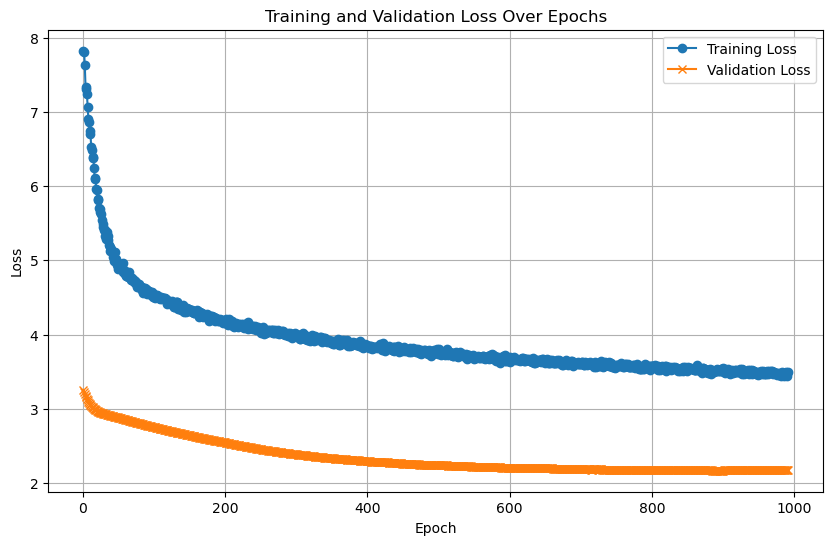

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/209], Loss: 5.1590
Test Batch [20/209], Loss: 4.9214
Test Batch [30/209], Loss: 4.7489
Test Batch [40/209], Loss: 4.4511
Test Batch [50/209], Loss: 5.0439
Test Batch [60/209], Loss: 4.8570
Test Batch [70/209], Loss: 4.6978
Test Batch [80/209], Loss: 4.8423
Test Batch [90/209], Loss: 4.7939
Test Batch [100/209], Loss: 4.7973
Test Batch [110/209], Loss: 4.8882
Test Batch [120/209], Loss: 4.9512
Test Batch [130/209], Loss: 4.7941
Test Batch [140/209], Loss: 4.8576
Test Batch [150/209], Loss: 4.7308


Test Batch [160/209], Loss: 4.8441
Test Batch [170/209], Loss: 5.0148
Test Batch [180/209], Loss: 5.0822
Test Batch [190/209], Loss: 5.1050
Test Batch [200/209], Loss: 5.2160

Test Loss: 4.8771


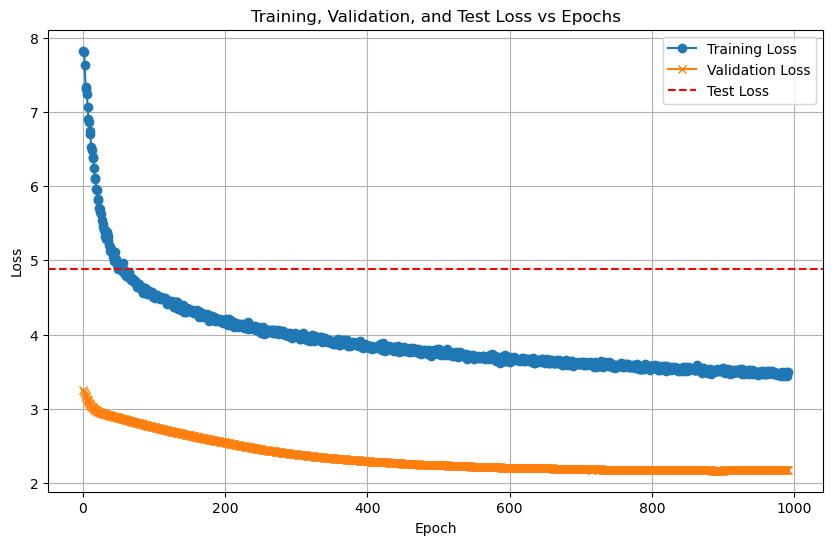

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...


  Processed batch 10/209 for test dataset.
  Processed batch 20/209 for test dataset.
  Processed batch 30/209 for test dataset.


  Processed batch 40/209 for test dataset.
  Processed batch 50/209 for test dataset.
  Processed batch 60/209 for test dataset.
  Processed batch 70/209 for test dataset.


  Processed batch 80/209 for test dataset.
  Processed batch 90/209 for test dataset.


  Processed batch 100/209 for test dataset.
  Processed batch 110/209 for test dataset.
  Processed batch 120/209 for test dataset.
  Processed batch 130/209 for test dataset.
  Processed batch 140/209 for test dataset.


  Processed batch 150/209 for test dataset.
  Processed batch 160/209 for test dataset.


  Processed batch 170/209 for test dataset.
  Processed batch 180/209 for test dataset.
  Processed batch 190/209 for test dataset.
  Processed batch 200/209 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (640, 128)
Train labels shape: (640,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53409, 128)
Test labels shape: (53409,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 91.25%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      0.80      0.89         5
           6       0.83      1.00      0.91         5
           7       0.83      1.00      0.91         5
           8       0.80      0.80      0.80         5
           9       1.00      0.80      0.89         5
          10       0.67      0.80      0.73         5
          11       0.83      1.00      0.91         5
          12       1.00      0.80      0.89         5
          13       0.8

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (640, 128)
Train labels shape: (640,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53409, 128)
Test labels shape: (53409,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8487  |  Val Loss: 2.7939
Validation loss improved from inf to 2.7939.
[Epoch 2/1000] Train Loss: 2.7832  |  Val Loss: 2.7385
Validation loss improved from 2.7939 to 2.7385.
[Epoch 3/1000] Train Loss: 2.7269  |  Val Loss: 2.6912
Validation loss improved from 2.7385 to 2.6912.
[Epoch 4/1000] Train Loss: 2.6771  |  Val Loss: 2.6486
Validation loss improved from 2.6912 to 2.6486.
[Epoch 5/1000] Train Loss: 2.6334  |  Val Loss: 2.6116
Validation loss improved from 2.6486 to 2.6116.
[Epoch 6/1000] Train Loss: 2.5955  |  Val Loss: 2.5808
Validation loss improved from 2.6116 to 2.5808.
[Epoch 7/1000] Train Loss: 2.5623  |  Val Loss: 2.5499
Validation loss improved from 2.5808 to 2.5499.
[Epoch 8/1000] Train Loss: 2.5295  |  Val Loss: 2.5187
Validation loss improved from 2.5499 to 2.5187.


[Epoch 9/1000] Train Loss: 2.4957  |  Val Loss: 2.4874
Validation loss improved from 2.5187 to 2.4874.
[Epoch 10/1000] Train Loss: 2.4610  |  Val Loss: 2.4539
Validation loss improved from 2.4874 to 2.4539.


[Epoch 11/1000] Train Loss: 2.4240  |  Val Loss: 2.4182
Validation loss improved from 2.4539 to 2.4182.
[Epoch 12/1000] Train Loss: 2.3854  |  Val Loss: 2.3804
Validation loss improved from 2.4182 to 2.3804.
[Epoch 13/1000] Train Loss: 2.3460  |  Val Loss: 2.3446
Validation loss improved from 2.3804 to 2.3446.
[Epoch 14/1000] Train Loss: 2.3081  |  Val Loss: 2.3076
Validation loss improved from 2.3446 to 2.3076.
[Epoch 15/1000] Train Loss: 2.2696  |  Val Loss: 2.2707
Validation loss improved from 2.3076 to 2.2707.
[Epoch 16/1000] Train Loss: 2.2296  |  Val Loss: 2.2315
Validation loss improved from 2.2707 to 2.2315.
[Epoch 17/1000] Train Loss: 2.1880  |  Val Loss: 2.1902
Validation loss improved from 2.2315 to 2.1902.
[Epoch 18/1000] Train Loss: 2.1444  |  Val Loss: 2.1481
Validation loss improved from 2.1902 to 2.1481.
[Epoch 19/1000] Train Loss: 2.1003  |  Val Loss: 2.1039
Validation loss improved from 2.1481 to 2.1039.


[Epoch 20/1000] Train Loss: 2.0539  |  Val Loss: 2.0593
Validation loss improved from 2.1039 to 2.0593.


[Epoch 21/1000] Train Loss: 2.0063  |  Val Loss: 2.0147
Validation loss improved from 2.0593 to 2.0147.
[Epoch 22/1000] Train Loss: 1.9609  |  Val Loss: 1.9700
Validation loss improved from 2.0147 to 1.9700.
[Epoch 23/1000] Train Loss: 1.9147  |  Val Loss: 1.9266
Validation loss improved from 1.9700 to 1.9266.
[Epoch 24/1000] Train Loss: 1.8696  |  Val Loss: 1.8842
Validation loss improved from 1.9266 to 1.8842.
[Epoch 25/1000] Train Loss: 1.8244  |  Val Loss: 1.8428
Validation loss improved from 1.8842 to 1.8428.
[Epoch 26/1000] Train Loss: 1.7814  |  Val Loss: 1.8023
Validation loss improved from 1.8428 to 1.8023.
[Epoch 27/1000] Train Loss: 1.7386  |  Val Loss: 1.7621
Validation loss improved from 1.8023 to 1.7621.
[Epoch 28/1000] Train Loss: 1.6965  |  Val Loss: 1.7227
Validation loss improved from 1.7621 to 1.7227.
[Epoch 29/1000] Train Loss: 1.6545  |  Val Loss: 1.6842
Validation loss improved from 1.7227 to 1.6842.


[Epoch 30/1000] Train Loss: 1.6137  |  Val Loss: 1.6458
Validation loss improved from 1.6842 to 1.6458.
[Epoch 31/1000] Train Loss: 1.5733  |  Val Loss: 1.6069
Validation loss improved from 1.6458 to 1.6069.
[Epoch 32/1000] Train Loss: 1.5327  |  Val Loss: 1.5686
Validation loss improved from 1.6069 to 1.5686.


[Epoch 33/1000] Train Loss: 1.4931  |  Val Loss: 1.5308
Validation loss improved from 1.5686 to 1.5308.
[Epoch 34/1000] Train Loss: 1.4524  |  Val Loss: 1.4928
Validation loss improved from 1.5308 to 1.4928.
[Epoch 35/1000] Train Loss: 1.4125  |  Val Loss: 1.4542
Validation loss improved from 1.4928 to 1.4542.
[Epoch 36/1000] Train Loss: 1.3738  |  Val Loss: 1.4179
Validation loss improved from 1.4542 to 1.4179.
[Epoch 37/1000] Train Loss: 1.3363  |  Val Loss: 1.3838
Validation loss improved from 1.4179 to 1.3838.
[Epoch 38/1000] Train Loss: 1.2993  |  Val Loss: 1.3504
Validation loss improved from 1.3838 to 1.3504.
[Epoch 39/1000] Train Loss: 1.2642  |  Val Loss: 1.3171
Validation loss improved from 1.3504 to 1.3171.


[Epoch 40/1000] Train Loss: 1.2299  |  Val Loss: 1.2854
Validation loss improved from 1.3171 to 1.2854.
[Epoch 41/1000] Train Loss: 1.1962  |  Val Loss: 1.2556
Validation loss improved from 1.2854 to 1.2556.
[Epoch 42/1000] Train Loss: 1.1641  |  Val Loss: 1.2251
Validation loss improved from 1.2556 to 1.2251.
[Epoch 43/1000] Train Loss: 1.1318  |  Val Loss: 1.1979
Validation loss improved from 1.2251 to 1.1979.


[Epoch 44/1000] Train Loss: 1.1012  |  Val Loss: 1.1695
Validation loss improved from 1.1979 to 1.1695.
[Epoch 45/1000] Train Loss: 1.0707  |  Val Loss: 1.1428
Validation loss improved from 1.1695 to 1.1428.
[Epoch 46/1000] Train Loss: 1.0415  |  Val Loss: 1.1170
Validation loss improved from 1.1428 to 1.1170.
[Epoch 47/1000] Train Loss: 1.0127  |  Val Loss: 1.0908
Validation loss improved from 1.1170 to 1.0908.
[Epoch 48/1000] Train Loss: 0.9845  |  Val Loss: 1.0659
Validation loss improved from 1.0908 to 1.0659.
[Epoch 49/1000] Train Loss: 0.9562  |  Val Loss: 1.0414
Validation loss improved from 1.0659 to 1.0414.


[Epoch 50/1000] Train Loss: 0.9291  |  Val Loss: 1.0152
Validation loss improved from 1.0414 to 1.0152.
[Epoch 51/1000] Train Loss: 0.9018  |  Val Loss: 0.9933
Validation loss improved from 1.0152 to 0.9933.
[Epoch 52/1000] Train Loss: 0.8734  |  Val Loss: 0.9681
Validation loss improved from 0.9933 to 0.9681.
[Epoch 53/1000] Train Loss: 0.8461  |  Val Loss: 0.9420
Validation loss improved from 0.9681 to 0.9420.
[Epoch 54/1000] Train Loss: 0.8186  |  Val Loss: 0.9168
Validation loss improved from 0.9420 to 0.9168.


[Epoch 55/1000] Train Loss: 0.7919  |  Val Loss: 0.8927
Validation loss improved from 0.9168 to 0.8927.
[Epoch 56/1000] Train Loss: 0.7661  |  Val Loss: 0.8692
Validation loss improved from 0.8927 to 0.8692.
[Epoch 57/1000] Train Loss: 0.7410  |  Val Loss: 0.8475
Validation loss improved from 0.8692 to 0.8475.
[Epoch 58/1000] Train Loss: 0.7162  |  Val Loss: 0.8257
Validation loss improved from 0.8475 to 0.8257.


[Epoch 59/1000] Train Loss: 0.6924  |  Val Loss: 0.8047
Validation loss improved from 0.8257 to 0.8047.
[Epoch 60/1000] Train Loss: 0.6686  |  Val Loss: 0.7838
Validation loss improved from 0.8047 to 0.7838.
[Epoch 61/1000] Train Loss: 0.6449  |  Val Loss: 0.7641
Validation loss improved from 0.7838 to 0.7641.
[Epoch 62/1000] Train Loss: 0.6228  |  Val Loss: 0.7442
Validation loss improved from 0.7641 to 0.7442.
[Epoch 63/1000] Train Loss: 0.6008  |  Val Loss: 0.7264
Validation loss improved from 0.7442 to 0.7264.
[Epoch 64/1000] Train Loss: 0.5804  |  Val Loss: 0.7096
Validation loss improved from 0.7264 to 0.7096.


[Epoch 65/1000] Train Loss: 0.5596  |  Val Loss: 0.6913
Validation loss improved from 0.7096 to 0.6913.
[Epoch 66/1000] Train Loss: 0.5405  |  Val Loss: 0.6730
Validation loss improved from 0.6913 to 0.6730.
[Epoch 67/1000] Train Loss: 0.5218  |  Val Loss: 0.6589
Validation loss improved from 0.6730 to 0.6589.
[Epoch 68/1000] Train Loss: 0.5040  |  Val Loss: 0.6448
Validation loss improved from 0.6589 to 0.6448.


[Epoch 69/1000] Train Loss: 0.4869  |  Val Loss: 0.6291
Validation loss improved from 0.6448 to 0.6291.
[Epoch 70/1000] Train Loss: 0.4704  |  Val Loss: 0.6152
Validation loss improved from 0.6291 to 0.6152.
[Epoch 71/1000] Train Loss: 0.4549  |  Val Loss: 0.6021
Validation loss improved from 0.6152 to 0.6021.
[Epoch 72/1000] Train Loss: 0.4408  |  Val Loss: 0.5917
Validation loss improved from 0.6021 to 0.5917.
[Epoch 73/1000] Train Loss: 0.4263  |  Val Loss: 0.5793
Validation loss improved from 0.5917 to 0.5793.
[Epoch 74/1000] Train Loss: 0.4129  |  Val Loss: 0.5674
Validation loss improved from 0.5793 to 0.5674.


[Epoch 75/1000] Train Loss: 0.4006  |  Val Loss: 0.5574
Validation loss improved from 0.5674 to 0.5574.
[Epoch 76/1000] Train Loss: 0.3902  |  Val Loss: 0.5473
Validation loss improved from 0.5574 to 0.5473.
[Epoch 77/1000] Train Loss: 0.3779  |  Val Loss: 0.5385
Validation loss improved from 0.5473 to 0.5385.
[Epoch 78/1000] Train Loss: 0.3676  |  Val Loss: 0.5310
Validation loss improved from 0.5385 to 0.5310.
[Epoch 79/1000] Train Loss: 0.3573  |  Val Loss: 0.5242
Validation loss improved from 0.5310 to 0.5242.


[Epoch 80/1000] Train Loss: 0.3477  |  Val Loss: 0.5157
Validation loss improved from 0.5242 to 0.5157.
[Epoch 81/1000] Train Loss: 0.3387  |  Val Loss: 0.5087
Validation loss improved from 0.5157 to 0.5087.
[Epoch 82/1000] Train Loss: 0.3301  |  Val Loss: 0.5011
Validation loss improved from 0.5087 to 0.5011.
[Epoch 83/1000] Train Loss: 0.3219  |  Val Loss: 0.4955
Validation loss improved from 0.5011 to 0.4955.
[Epoch 84/1000] Train Loss: 0.3144  |  Val Loss: 0.4894
Validation loss improved from 0.4955 to 0.4894.
[Epoch 85/1000] Train Loss: 0.3070  |  Val Loss: 0.4851
Validation loss improved from 0.4894 to 0.4851.


[Epoch 86/1000] Train Loss: 0.2999  |  Val Loss: 0.4793
Validation loss improved from 0.4851 to 0.4793.
[Epoch 87/1000] Train Loss: 0.2932  |  Val Loss: 0.4732
Validation loss improved from 0.4793 to 0.4732.
[Epoch 88/1000] Train Loss: 0.2876  |  Val Loss: 0.4687
Validation loss improved from 0.4732 to 0.4687.
[Epoch 89/1000] Train Loss: 0.2815  |  Val Loss: 0.4653
Validation loss improved from 0.4687 to 0.4653.
[Epoch 90/1000] Train Loss: 0.2756  |  Val Loss: 0.4618
Validation loss improved from 0.4653 to 0.4618.


[Epoch 91/1000] Train Loss: 0.2704  |  Val Loss: 0.4580
Validation loss improved from 0.4618 to 0.4580.
[Epoch 92/1000] Train Loss: 0.2645  |  Val Loss: 0.4540
Validation loss improved from 0.4580 to 0.4540.
[Epoch 93/1000] Train Loss: 0.2598  |  Val Loss: 0.4500
Validation loss improved from 0.4540 to 0.4500.
[Epoch 94/1000] Train Loss: 0.2548  |  Val Loss: 0.4464
Validation loss improved from 0.4500 to 0.4464.
[Epoch 95/1000] Train Loss: 0.2511  |  Val Loss: 0.4430
Validation loss improved from 0.4464 to 0.4430.


[Epoch 96/1000] Train Loss: 0.2464  |  Val Loss: 0.4412
Validation loss improved from 0.4430 to 0.4412.
[Epoch 97/1000] Train Loss: 0.2422  |  Val Loss: 0.4395
Validation loss improved from 0.4412 to 0.4395.
[Epoch 98/1000] Train Loss: 0.2380  |  Val Loss: 0.4364
Validation loss improved from 0.4395 to 0.4364.
[Epoch 99/1000] Train Loss: 0.2342  |  Val Loss: 0.4351
Validation loss improved from 0.4364 to 0.4351.
[Epoch 100/1000] Train Loss: 0.2305  |  Val Loss: 0.4303
Validation loss improved from 0.4351 to 0.4303.


[Epoch 101/1000] Train Loss: 0.2271  |  Val Loss: 0.4283
Validation loss improved from 0.4303 to 0.4283.
[Epoch 102/1000] Train Loss: 0.2245  |  Val Loss: 0.4253
Validation loss improved from 0.4283 to 0.4253.
[Epoch 103/1000] Train Loss: 0.2201  |  Val Loss: 0.4234
Validation loss improved from 0.4253 to 0.4234.
[Epoch 104/1000] Train Loss: 0.2178  |  Val Loss: 0.4230
Validation loss improved from 0.4234 to 0.4230.


[Epoch 105/1000] Train Loss: 0.2142  |  Val Loss: 0.4218
Validation loss improved from 0.4230 to 0.4218.
[Epoch 106/1000] Train Loss: 0.2117  |  Val Loss: 0.4186
Validation loss improved from 0.4218 to 0.4186.
[Epoch 107/1000] Train Loss: 0.2082  |  Val Loss: 0.4178
Validation loss improved from 0.4186 to 0.4178.
[Epoch 108/1000] Train Loss: 0.2061  |  Val Loss: 0.4156
Validation loss improved from 0.4178 to 0.4156.
[Epoch 109/1000] Train Loss: 0.2032  |  Val Loss: 0.4124
Validation loss improved from 0.4156 to 0.4124.
[Epoch 110/1000] Train Loss: 0.2005  |  Val Loss: 0.4106
Validation loss improved from 0.4124 to 0.4106.


[Epoch 111/1000] Train Loss: 0.1980  |  Val Loss: 0.4079
Validation loss improved from 0.4106 to 0.4079.
[Epoch 112/1000] Train Loss: 0.1954  |  Val Loss: 0.4069
Validation loss improved from 0.4079 to 0.4069.
[Epoch 113/1000] Train Loss: 0.1935  |  Val Loss: 0.4028
Validation loss improved from 0.4069 to 0.4028.
[Epoch 114/1000] Train Loss: 0.1912  |  Val Loss: 0.4043
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 115/1000] Train Loss: 0.1890  |  Val Loss: 0.4012
Validation loss improved from 0.4028 to 0.4012.
[Epoch 116/1000] Train Loss: 0.1873  |  Val Loss: 0.4011
Validation loss improved from 0.4012 to 0.4011.
[Epoch 117/1000] Train Loss: 0.1859  |  Val Loss: 0.3999
Validation loss improved from 0.4011 to 0.3999.
[Epoch 118/1000] Train Loss: 0.1835  |  Val Loss: 0.3985
Validation loss improved from 0.3999 to 0.3985.
[Epoch 119/1000] Train Loss: 0.1811  |  Val Loss: 0.3982
Validation loss improved from 0.3985 to 0.3982.
[Epoch 120/1000] Train Loss: 0.1796  |  Val Loss: 0.3974
Validation loss improved from 0.3982 to 0.3974.


[Epoch 121/1000] Train Loss: 0.1778  |  Val Loss: 0.3978
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 122/1000] Train Loss: 0.1759  |  Val Loss: 0.3960
Validation loss improved from 0.3974 to 0.3960.
[Epoch 123/1000] Train Loss: 0.1743  |  Val Loss: 0.3936
Validation loss improved from 0.3960 to 0.3936.
[Epoch 124/1000] Train Loss: 0.1726  |  Val Loss: 0.3938
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 125/1000] Train Loss: 0.1712  |  Val Loss: 0.3925
Validation loss improved from 0.3936 to 0.3925.


[Epoch 126/1000] Train Loss: 0.1696  |  Val Loss: 0.3929
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 127/1000] Train Loss: 0.1681  |  Val Loss: 0.3932
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 128/1000] Train Loss: 0.1666  |  Val Loss: 0.3917
Validation loss improved from 0.3925 to 0.3917.
[Epoch 129/1000] Train Loss: 0.1657  |  Val Loss: 0.3910
Validation loss improved from 0.3917 to 0.3910.
[Epoch 130/1000] Train Loss: 0.1648  |  Val Loss: 0.3902
Validation loss improved from 0.3910 to 0.3902.


[Epoch 131/1000] Train Loss: 0.1631  |  Val Loss: 0.3883
Validation loss improved from 0.3902 to 0.3883.
[Epoch 132/1000] Train Loss: 0.1619  |  Val Loss: 0.3910
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 133/1000] Train Loss: 0.1609  |  Val Loss: 0.3924
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 134/1000] Train Loss: 0.1594  |  Val Loss: 0.3904
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 135/1000] Train Loss: 0.1584  |  Val Loss: 0.3900
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 136/1000] Train Loss: 0.1572  |  Val Loss: 0.3876
Validation loss improved from 0.3883 to 0.3876.
[Epoch 137/1000] Train Loss: 0.1560  |  Val Loss: 0.3890
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 138/1000] Train Loss: 0.1552  |  Val Loss: 0.3879
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 139/1000] Train Loss: 0.1537  |  Val Loss: 0.3879
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 140/1000] Train Loss: 0.1528  |  Val Loss: 0.3878
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 141/1000] Train Loss: 0.1525  |  Val Loss: 0.3873
Validation loss improved from 0.3876 to 0.3873.
[Epoch 142/1000] Train Loss: 0.1509  |  Val Loss: 0.3885
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 143/1000] Train Loss: 0.1509  |  Val Loss: 0.3901
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 144/1000] Train Loss: 0.1496  |  Val Loss: 0.3875
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 145/1000] Train Loss: 0.1488  |  Val Loss: 0.3879
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 146/1000] Train Loss: 0.1475  |  Val Loss: 0.3886
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 147/1000] Train Loss: 0.1471  |  Val Loss: 0.3890
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 148/1000] Train Loss: 0.1462  |  Val Loss: 0.3878
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 149/1000] Train Loss: 0.1451  |  Val Loss: 0.3868
Validation loss improved from 0.3873 to 0.3868.
[Epoch 150/1000] Train Loss: 0.1445  |  Val Loss: 0.3871
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 151/1000] Train Loss: 0.1436  |  Val Loss: 0.3869
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 152/1000] Train Loss: 0.1426  |  Val Loss: 0.3892
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 153/1000] Train Loss: 0.1422  |  Val Loss: 0.3894
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 154/1000] Train Loss: 0.1408  |  Val Loss: 0.3875
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 155/1000] Train Loss: 0.1403  |  Val Loss: 0.3882
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 156/1000] Train Loss: 0.1394  |  Val Loss: 0.3872
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 157/1000] Train Loss: 0.1391  |  Val Loss: 0.3882
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 158/1000] Train Loss: 0.1383  |  Val Loss: 0.3876
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 159/1000] Train Loss: 0.1377  |  Val Loss: 0.3897
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 160/1000] Train Loss: 0.1371  |  Val Loss: 0.3885
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 161/1000] Train Loss: 0.1361  |  Val Loss: 0.3886
!! Validation loss did NOT improve !! Patience: 12/100


[Epoch 162/1000] Train Loss: 0.1358  |  Val Loss: 0.3894
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 163/1000] Train Loss: 0.1356  |  Val Loss: 0.3880
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 164/1000] Train Loss: 0.1344  |  Val Loss: 0.3888
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 165/1000] Train Loss: 0.1337  |  Val Loss: 0.3900
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 166/1000] Train Loss: 0.1334  |  Val Loss: 0.3898
!! Validation loss did NOT improve !! Patience: 17/100


[Epoch 167/1000] Train Loss: 0.1330  |  Val Loss: 0.3882
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 168/1000] Train Loss: 0.1321  |  Val Loss: 0.3908
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 169/1000] Train Loss: 0.1313  |  Val Loss: 0.3931
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 170/1000] Train Loss: 0.1325  |  Val Loss: 0.3903
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 171/1000] Train Loss: 0.1313  |  Val Loss: 0.3887
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 172/1000] Train Loss: 0.1303  |  Val Loss: 0.3926
!! Validation loss did NOT improve !! Patience: 23/100


[Epoch 173/1000] Train Loss: 0.1293  |  Val Loss: 0.3922
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 174/1000] Train Loss: 0.1292  |  Val Loss: 0.3930
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 175/1000] Train Loss: 0.1288  |  Val Loss: 0.3912
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 176/1000] Train Loss: 0.1279  |  Val Loss: 0.3903
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 177/1000] Train Loss: 0.1275  |  Val Loss: 0.3900
!! Validation loss did NOT improve !! Patience: 28/100


[Epoch 178/1000] Train Loss: 0.1272  |  Val Loss: 0.3927
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 179/1000] Train Loss: 0.1263  |  Val Loss: 0.3938
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 180/1000] Train Loss: 0.1257  |  Val Loss: 0.3933
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 181/1000] Train Loss: 0.1256  |  Val Loss: 0.3926
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 182/1000] Train Loss: 0.1251  |  Val Loss: 0.3914
!! Validation loss did NOT improve !! Patience: 33/100


[Epoch 183/1000] Train Loss: 0.1245  |  Val Loss: 0.3926
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 184/1000] Train Loss: 0.1240  |  Val Loss: 0.3940
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 185/1000] Train Loss: 0.1237  |  Val Loss: 0.3935
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 186/1000] Train Loss: 0.1234  |  Val Loss: 0.3936
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 187/1000] Train Loss: 0.1228  |  Val Loss: 0.3941
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 188/1000] Train Loss: 0.1226  |  Val Loss: 0.3943
!! Validation loss did NOT improve !! Patience: 39/100


[Epoch 189/1000] Train Loss: 0.1234  |  Val Loss: 0.3967
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 190/1000] Train Loss: 0.1226  |  Val Loss: 0.3938
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 191/1000] Train Loss: 0.1224  |  Val Loss: 0.3943
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 192/1000] Train Loss: 0.1208  |  Val Loss: 0.3956
!! Validation loss did NOT improve !! Patience: 43/100


[Epoch 193/1000] Train Loss: 0.1209  |  Val Loss: 0.3968
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 194/1000] Train Loss: 0.1199  |  Val Loss: 0.3955
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 195/1000] Train Loss: 0.1196  |  Val Loss: 0.3964
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 196/1000] Train Loss: 0.1195  |  Val Loss: 0.3965
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 197/1000] Train Loss: 0.1186  |  Val Loss: 0.3973
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 198/1000] Train Loss: 0.1186  |  Val Loss: 0.3956
!! Validation loss did NOT improve !! Patience: 49/100


[Epoch 199/1000] Train Loss: 0.1193  |  Val Loss: 0.3964
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 200/1000] Train Loss: 0.1176  |  Val Loss: 0.3971
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 201/1000] Train Loss: 0.1173  |  Val Loss: 0.3990
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 202/1000] Train Loss: 0.1168  |  Val Loss: 0.3993
!! Validation loss did NOT improve !! Patience: 53/100


[Epoch 203/1000] Train Loss: 0.1167  |  Val Loss: 0.3999
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 204/1000] Train Loss: 0.1163  |  Val Loss: 0.4009
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 205/1000] Train Loss: 0.1157  |  Val Loss: 0.3991
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 206/1000] Train Loss: 0.1160  |  Val Loss: 0.3982
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 207/1000] Train Loss: 0.1148  |  Val Loss: 0.3993
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 208/1000] Train Loss: 0.1150  |  Val Loss: 0.4005
!! Validation loss did NOT improve !! Patience: 59/100


[Epoch 209/1000] Train Loss: 0.1143  |  Val Loss: 0.4012
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 210/1000] Train Loss: 0.1150  |  Val Loss: 0.3992
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 211/1000] Train Loss: 0.1143  |  Val Loss: 0.3989
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 212/1000] Train Loss: 0.1134  |  Val Loss: 0.3998
!! Validation loss did NOT improve !! Patience: 63/100


[Epoch 213/1000] Train Loss: 0.1132  |  Val Loss: 0.4011
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 214/1000] Train Loss: 0.1128  |  Val Loss: 0.3999
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 215/1000] Train Loss: 0.1128  |  Val Loss: 0.4015
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 216/1000] Train Loss: 0.1121  |  Val Loss: 0.4038
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 217/1000] Train Loss: 0.1119  |  Val Loss: 0.4021
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 218/1000] Train Loss: 0.1117  |  Val Loss: 0.4061
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 219/1000] Train Loss: 0.1113  |  Val Loss: 0.4023
!! Validation loss did NOT improve !! Patience: 70/100


[Epoch 220/1000] Train Loss: 0.1108  |  Val Loss: 0.4041
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 221/1000] Train Loss: 0.1109  |  Val Loss: 0.4012
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 222/1000] Train Loss: 0.1110  |  Val Loss: 0.4018
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 223/1000] Train Loss: 0.1100  |  Val Loss: 0.4038
!! Validation loss did NOT improve !! Patience: 74/100


[Epoch 224/1000] Train Loss: 0.1099  |  Val Loss: 0.4027
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 225/1000] Train Loss: 0.1096  |  Val Loss: 0.4035
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 226/1000] Train Loss: 0.1094  |  Val Loss: 0.4040
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 227/1000] Train Loss: 0.1088  |  Val Loss: 0.4042
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 228/1000] Train Loss: 0.1091  |  Val Loss: 0.4060
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 229/1000] Train Loss: 0.1088  |  Val Loss: 0.4043
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 230/1000] Train Loss: 0.1080  |  Val Loss: 0.4042
!! Validation loss did NOT improve !! Patience: 81/100


[Epoch 231/1000] Train Loss: 0.1079  |  Val Loss: 0.4044
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 232/1000] Train Loss: 0.1079  |  Val Loss: 0.4060
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 233/1000] Train Loss: 0.1079  |  Val Loss: 0.4042
!! Validation loss did NOT improve !! Patience: 84/100


[Epoch 234/1000] Train Loss: 0.1073  |  Val Loss: 0.4094
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 235/1000] Train Loss: 0.1066  |  Val Loss: 0.4091
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 236/1000] Train Loss: 0.1068  |  Val Loss: 0.4061
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 237/1000] Train Loss: 0.1063  |  Val Loss: 0.4046
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 238/1000] Train Loss: 0.1062  |  Val Loss: 0.4095
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 239/1000] Train Loss: 0.1058  |  Val Loss: 0.4074
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 240/1000] Train Loss: 0.1056  |  Val Loss: 0.4077
!! Validation loss did NOT improve !! Patience: 91/100


[Epoch 241/1000] Train Loss: 0.1051  |  Val Loss: 0.4098
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 242/1000] Train Loss: 0.1050  |  Val Loss: 0.4083
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 243/1000] Train Loss: 0.1047  |  Val Loss: 0.4070
!! Validation loss did NOT improve !! Patience: 94/100


[Epoch 244/1000] Train Loss: 0.1047  |  Val Loss: 0.4084
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 245/1000] Train Loss: 0.1044  |  Val Loss: 0.4090
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 246/1000] Train Loss: 0.1044  |  Val Loss: 0.4084
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 247/1000] Train Loss: 0.1037  |  Val Loss: 0.4092
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 248/1000] Train Loss: 0.1039  |  Val Loss: 0.4091
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 249/1000] Train Loss: 0.1054  |  Val Loss: 0.4126
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 249 !!
No improvement for 100 epochs.


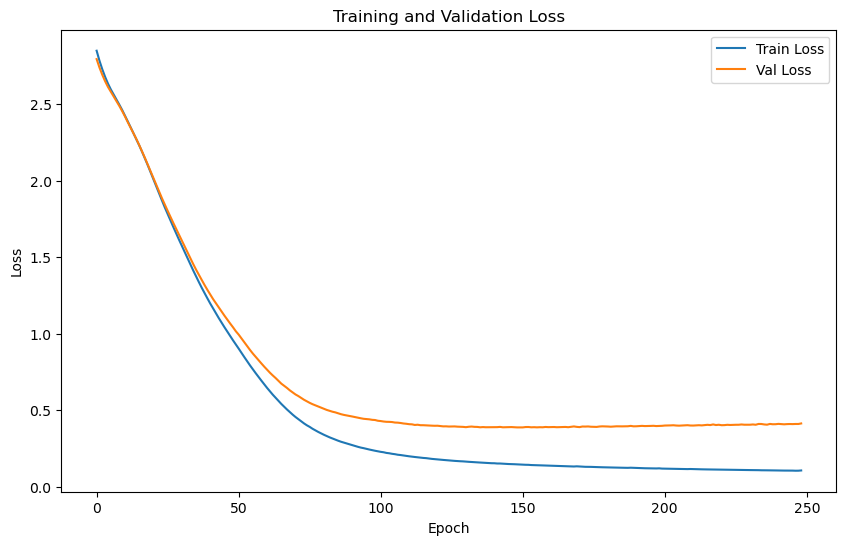

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.6399 | Test Accuracy: 82.05%


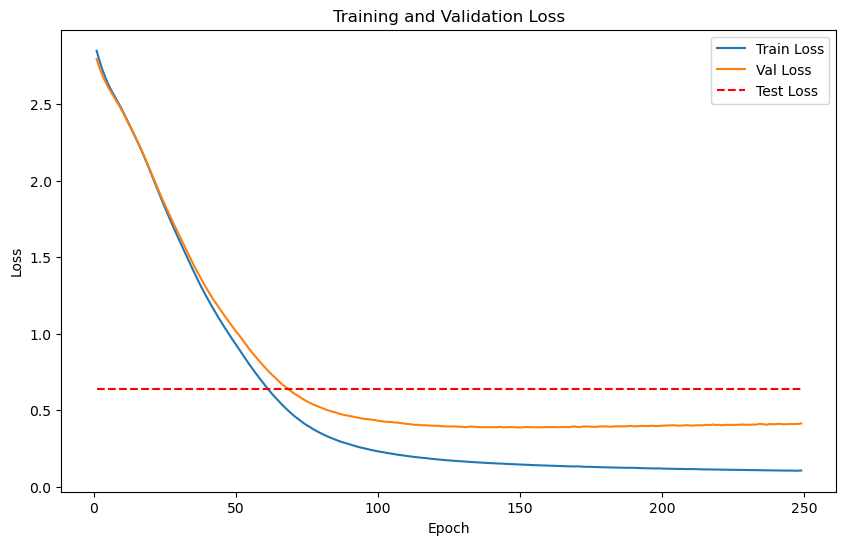

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 640 samples with 64 features each
LOG: Labels shape: (640,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53409 samples with 64 features each
LOG: Labels shape: (53409,)


Train embeddings shape: (640, 64), 
Train labels shape: (640,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53409, 64), 
Test labels shape: (53409,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 0.4642


    Batch [2/2], Train Loss: 0.4674
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.3444
    Batch [2/2], Val Loss: 0.3311
Epoch [1/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.3377

Validation loss improved from inf to 0.3377. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/2], Train Loss: 0.4621


    Batch [2/2], Train Loss: 0.4599
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.3326
Epoch [2/2000], Avg Train Loss: 0.4610, Avg Val Loss: 0.3382

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/2], Train Loss: 0.4618


    Batch [2/2], Train Loss: 0.4605
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.3449
    Batch [2/2], Val Loss: 0.3349
Epoch [3/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.3399

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training


    Batch [1/2], Train Loss: 0.4574


    Batch [2/2], Train Loss: 0.4587
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.3464
    Batch [2/2], Val Loss: 0.3376
Epoch [4/2000], Avg Train Loss: 0.4580, Avg Val Loss: 0.3420

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training


    Batch [1/2], Train Loss: 0.4591


    Batch [2/2], Train Loss: 0.4600
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.3477
    Batch [2/2], Val Loss: 0.3405
Epoch [5/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.3441

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training


    Batch [1/2], Train Loss: 0.4555


    Batch [2/2], Train Loss: 0.4504
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.3488
    Batch [2/2], Val Loss: 0.3416
Epoch [6/2000], Avg Train Loss: 0.4529, Avg Val Loss: 0.3452

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training


    Batch [1/2], Train Loss: 0.4553
    Batch [2/2], Train Loss: 0.4513
LOG: Epoch [7/2000] - Validation


    Batch [1/2], Val Loss: 0.3490
    Batch [2/2], Val Loss: 0.3422
Epoch [7/2000], Avg Train Loss: 0.4533, Avg Val Loss: 0.3456

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [8/2000] - Training


    Batch [1/2], Train Loss: 0.4505


    Batch [2/2], Train Loss: 0.4521
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.3424
Epoch [8/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.3454

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [9/2000] - Training


    Batch [1/2], Train Loss: 0.4491


    Batch [2/2], Train Loss: 0.4513
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.3472
    Batch [2/2], Val Loss: 0.3426
Epoch [9/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.3449

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [10/2000] - Training


    Batch [1/2], Train Loss: 0.4477


    Batch [2/2], Train Loss: 0.4467
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.3457
    Batch [2/2], Val Loss: 0.3419
Epoch [10/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [11/2000] - Training


    Batch [1/2], Train Loss: 0.4506


    Batch [2/2], Train Loss: 0.4483
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.3439
    Batch [2/2], Val Loss: 0.3414
Epoch [11/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.3427

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [12/2000] - Training


    Batch [1/2], Train Loss: 0.4436


    Batch [2/2], Train Loss: 0.4454
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.3419
    Batch [2/2], Val Loss: 0.3404
Epoch [12/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.3411

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [13/2000] - Training


    Batch [1/2], Train Loss: 0.4451


    Batch [2/2], Train Loss: 0.4415
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.3398
    Batch [2/2], Val Loss: 0.3392
Epoch [13/2000], Avg Train Loss: 0.4433, Avg Val Loss: 0.3395

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [14/2000] - Training


    Batch [1/2], Train Loss: 0.4414


    Batch [2/2], Train Loss: 0.4412
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3381
Epoch [14/2000], Avg Train Loss: 0.4413, Avg Val Loss: 0.3380

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [15/2000] - Training


    Batch [1/2], Train Loss: 0.4459


    Batch [2/2], Train Loss: 0.4384
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.3360
    Batch [2/2], Val Loss: 0.3368
Epoch [15/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.3364

Validation loss improved from 0.3377 to 0.3364. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/2], Train Loss: 0.4441


    Batch [2/2], Train Loss: 0.4399
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.3343
    Batch [2/2], Val Loss: 0.3360
Epoch [16/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.3351

Validation loss improved from 0.3364 to 0.3351. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/2], Train Loss: 0.4408


    Batch [2/2], Train Loss: 0.4382
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.3326
    Batch [2/2], Val Loss: 0.3349
Epoch [17/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.3338

Validation loss improved from 0.3351 to 0.3338. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/2], Train Loss: 0.4383


    Batch [2/2], Train Loss: 0.4391
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.3310
    Batch [2/2], Val Loss: 0.3337
Epoch [18/2000], Avg Train Loss: 0.4387, Avg Val Loss: 0.3324

Validation loss improved from 0.3338 to 0.3324. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/2], Train Loss: 0.4398


    Batch [2/2], Train Loss: 0.4388
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.3297
    Batch [2/2], Val Loss: 0.3323
Epoch [19/2000], Avg Train Loss: 0.4393, Avg Val Loss: 0.3310

Validation loss improved from 0.3324 to 0.3310. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/2], Train Loss: 0.4439


    Batch [2/2], Train Loss: 0.4383
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.3284
    Batch [2/2], Val Loss: 0.3306
Epoch [20/2000], Avg Train Loss: 0.4411, Avg Val Loss: 0.3295

Validation loss improved from 0.3310 to 0.3295. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/2], Train Loss: 0.4349


    Batch [2/2], Train Loss: 0.4307
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.3272
    Batch [2/2], Val Loss: 0.3291
Epoch [21/2000], Avg Train Loss: 0.4328, Avg Val Loss: 0.3281

Validation loss improved from 0.3295 to 0.3281. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/2], Train Loss: 0.4286


    Batch [2/2], Train Loss: 0.4363
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.3261
    Batch [2/2], Val Loss: 0.3279
Epoch [22/2000], Avg Train Loss: 0.4325, Avg Val Loss: 0.3270

Validation loss improved from 0.3281 to 0.3270. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/2], Train Loss: 0.4341


    Batch [2/2], Train Loss: 0.4272
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.3249
    Batch [2/2], Val Loss: 0.3266
Epoch [23/2000], Avg Train Loss: 0.4307, Avg Val Loss: 0.3257

Validation loss improved from 0.3270 to 0.3257. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/2], Train Loss: 0.4324


    Batch [2/2], Train Loss: 0.4324
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.3236
    Batch [2/2], Val Loss: 0.3252
Epoch [24/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.3244

Validation loss improved from 0.3257 to 0.3244. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/2], Train Loss: 0.4265
    Batch [2/2], Train Loss: 0.4336
LOG: Epoch [25/2000] - Validation


    Batch [1/2], Val Loss: 0.3224
    Batch [2/2], Val Loss: 0.3236
Epoch [25/2000], Avg Train Loss: 0.4301, Avg Val Loss: 0.3230

Validation loss improved from 0.3244 to 0.3230. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/2], Train Loss: 0.4218


    Batch [2/2], Train Loss: 0.4245
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.3213
    Batch [2/2], Val Loss: 0.3222
Epoch [26/2000], Avg Train Loss: 0.4232, Avg Val Loss: 0.3218

Validation loss improved from 0.3230 to 0.3218. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/2], Train Loss: 0.4276


    Batch [2/2], Train Loss: 0.4265
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.3202
    Batch [2/2], Val Loss: 0.3209
Epoch [27/2000], Avg Train Loss: 0.4270, Avg Val Loss: 0.3205

Validation loss improved from 0.3218 to 0.3205. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/2], Train Loss: 0.4259


    Batch [2/2], Train Loss: 0.4265
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.3191
    Batch [2/2], Val Loss: 0.3195
Epoch [28/2000], Avg Train Loss: 0.4262, Avg Val Loss: 0.3193

Validation loss improved from 0.3205 to 0.3193. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/2], Train Loss: 0.4232
    Batch [2/2], Train Loss: 0.4190
LOG: Epoch [29/2000] - Validation


    Batch [1/2], Val Loss: 0.3178
    Batch [2/2], Val Loss: 0.3176
Epoch [29/2000], Avg Train Loss: 0.4211, Avg Val Loss: 0.3177

Validation loss improved from 0.3193 to 0.3177. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/2], Train Loss: 0.4184


    Batch [2/2], Train Loss: 0.4166
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.3166
    Batch [2/2], Val Loss: 0.3162
Epoch [30/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.3164

Validation loss improved from 0.3177 to 0.3164. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/2], Train Loss: 0.4231


    Batch [2/2], Train Loss: 0.4209
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.3155
    Batch [2/2], Val Loss: 0.3149
Epoch [31/2000], Avg Train Loss: 0.4220, Avg Val Loss: 0.3152

Validation loss improved from 0.3164 to 0.3152. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/2], Train Loss: 0.4239


    Batch [2/2], Train Loss: 0.4226
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.3143
    Batch [2/2], Val Loss: 0.3138
Epoch [32/2000], Avg Train Loss: 0.4232, Avg Val Loss: 0.3141

Validation loss improved from 0.3152 to 0.3141. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/2], Train Loss: 0.4125


    Batch [2/2], Train Loss: 0.4109
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.3131
    Batch [2/2], Val Loss: 0.3126
Epoch [33/2000], Avg Train Loss: 0.4117, Avg Val Loss: 0.3129

Validation loss improved from 0.3141 to 0.3129. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/2], Train Loss: 0.4173


    Batch [2/2], Train Loss: 0.4099
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.3120
    Batch [2/2], Val Loss: 0.3112
Epoch [34/2000], Avg Train Loss: 0.4136, Avg Val Loss: 0.3116

Validation loss improved from 0.3129 to 0.3116. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/2], Train Loss: 0.4089


    Batch [2/2], Train Loss: 0.4109
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.3106
    Batch [2/2], Val Loss: 0.3097
Epoch [35/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.3102

Validation loss improved from 0.3116 to 0.3102. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/2], Train Loss: 0.4110


    Batch [2/2], Train Loss: 0.4128
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.3094
    Batch [2/2], Val Loss: 0.3083
Epoch [36/2000], Avg Train Loss: 0.4119, Avg Val Loss: 0.3088

Validation loss improved from 0.3102 to 0.3088. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/2], Train Loss: 0.4228


    Batch [2/2], Train Loss: 0.4096
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.3081
    Batch [2/2], Val Loss: 0.3067
Epoch [37/2000], Avg Train Loss: 0.4162, Avg Val Loss: 0.3074

Validation loss improved from 0.3088 to 0.3074. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/2], Train Loss: 0.4118


    Batch [2/2], Train Loss: 0.4118
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.3068
    Batch [2/2], Val Loss: 0.3052
Epoch [38/2000], Avg Train Loss: 0.4118, Avg Val Loss: 0.3060

Validation loss improved from 0.3074 to 0.3060. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/2], Train Loss: 0.4080


    Batch [2/2], Train Loss: 0.4139
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.3057
    Batch [2/2], Val Loss: 0.3034
Epoch [39/2000], Avg Train Loss: 0.4110, Avg Val Loss: 0.3046

Validation loss improved from 0.3060 to 0.3046. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/2], Train Loss: 0.4080


    Batch [2/2], Train Loss: 0.4079
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.3045
    Batch [2/2], Val Loss: 0.3021
Epoch [40/2000], Avg Train Loss: 0.4079, Avg Val Loss: 0.3033

Validation loss improved from 0.3046 to 0.3033. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/2], Train Loss: 0.4075


    Batch [2/2], Train Loss: 0.4058
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.3032
    Batch [2/2], Val Loss: 0.3006
Epoch [41/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.3019

Validation loss improved from 0.3033 to 0.3019. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/2], Train Loss: 0.4049


    Batch [2/2], Train Loss: 0.4107
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.3021
    Batch [2/2], Val Loss: 0.2992
Epoch [42/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.3006

Validation loss improved from 0.3019 to 0.3006. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/2], Train Loss: 0.4075


    Batch [2/2], Train Loss: 0.4023
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.3009
    Batch [2/2], Val Loss: 0.2983
Epoch [43/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.2996

Validation loss improved from 0.3006 to 0.2996. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/2], Train Loss: 0.3981


    Batch [2/2], Train Loss: 0.4054
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.2996
    Batch [2/2], Val Loss: 0.2971
Epoch [44/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2984

Validation loss improved from 0.2996 to 0.2984. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/2], Train Loss: 0.4033


    Batch [2/2], Train Loss: 0.3951
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.2984
    Batch [2/2], Val Loss: 0.2964
Epoch [45/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.2974

Validation loss improved from 0.2984 to 0.2974. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/2], Train Loss: 0.3954


    Batch [2/2], Train Loss: 0.3956
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.2976
    Batch [2/2], Val Loss: 0.2954
Epoch [46/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.2965

Validation loss improved from 0.2974 to 0.2965. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/2], Train Loss: 0.3971


    Batch [2/2], Train Loss: 0.3963
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.2967
    Batch [2/2], Val Loss: 0.2943
Epoch [47/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.2955

Validation loss improved from 0.2965 to 0.2955. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/2], Train Loss: 0.3966


    Batch [2/2], Train Loss: 0.4009
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.2957
    Batch [2/2], Val Loss: 0.2933
Epoch [48/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.2945

Validation loss improved from 0.2955 to 0.2945. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/2], Train Loss: 0.3985


    Batch [2/2], Train Loss: 0.4062
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.2947
    Batch [2/2], Val Loss: 0.2921
Epoch [49/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.2934

Validation loss improved from 0.2945 to 0.2934. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/2], Train Loss: 0.3994


    Batch [2/2], Train Loss: 0.3948
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.2938
    Batch [2/2], Val Loss: 0.2911
Epoch [50/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.2925

Validation loss improved from 0.2934 to 0.2925. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/2], Train Loss: 0.4022


    Batch [2/2], Train Loss: 0.3942
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.2898
Epoch [51/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.2914

Validation loss improved from 0.2925 to 0.2914. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/2], Train Loss: 0.3972


    Batch [2/2], Train Loss: 0.3993
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.2921
    Batch [2/2], Val Loss: 0.2888
Epoch [52/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.2904

Validation loss improved from 0.2914 to 0.2904. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/2], Train Loss: 0.3943


    Batch [2/2], Train Loss: 0.3850
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.2914
    Batch [2/2], Val Loss: 0.2876
Epoch [53/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.2895

Validation loss improved from 0.2904 to 0.2895. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/2], Train Loss: 0.3923


    Batch [2/2], Train Loss: 0.3960
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.2907
    Batch [2/2], Val Loss: 0.2867
Epoch [54/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.2887

Validation loss improved from 0.2895 to 0.2887. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/2], Train Loss: 0.3821


    Batch [2/2], Train Loss: 0.3941
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.2901
    Batch [2/2], Val Loss: 0.2855
Epoch [55/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.2878

Validation loss improved from 0.2887 to 0.2878. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/2], Train Loss: 0.3962


    Batch [2/2], Train Loss: 0.3978
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.2894
    Batch [2/2], Val Loss: 0.2841
Epoch [56/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.2867

Validation loss improved from 0.2878 to 0.2867. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/2], Train Loss: 0.3993


    Batch [2/2], Train Loss: 0.3821
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.2830
Epoch [57/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2858

Validation loss improved from 0.2867 to 0.2858. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/2], Train Loss: 0.3878


    Batch [2/2], Train Loss: 0.3946
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.2879
    Batch [2/2], Val Loss: 0.2821
Epoch [58/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2850

Validation loss improved from 0.2858 to 0.2850. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/2], Train Loss: 0.3866


    Batch [2/2], Train Loss: 0.3837
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.2871
    Batch [2/2], Val Loss: 0.2809
Epoch [59/2000], Avg Train Loss: 0.3851, Avg Val Loss: 0.2840

Validation loss improved from 0.2850 to 0.2840. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/2], Train Loss: 0.3861


    Batch [2/2], Train Loss: 0.3774
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.2863
    Batch [2/2], Val Loss: 0.2795
Epoch [60/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.2829

Validation loss improved from 0.2840 to 0.2829. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/2], Train Loss: 0.3828


    Batch [2/2], Train Loss: 0.3864
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.2855
    Batch [2/2], Val Loss: 0.2781
Epoch [61/2000], Avg Train Loss: 0.3846, Avg Val Loss: 0.2818

Validation loss improved from 0.2829 to 0.2818. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/2], Train Loss: 0.3810


    Batch [2/2], Train Loss: 0.3837
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.2845
    Batch [2/2], Val Loss: 0.2772
Epoch [62/2000], Avg Train Loss: 0.3823, Avg Val Loss: 0.2809

Validation loss improved from 0.2818 to 0.2809. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/2], Train Loss: 0.3834


    Batch [2/2], Train Loss: 0.3859
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.2836
    Batch [2/2], Val Loss: 0.2760
Epoch [63/2000], Avg Train Loss: 0.3847, Avg Val Loss: 0.2798

Validation loss improved from 0.2809 to 0.2798. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/2], Train Loss: 0.3823


    Batch [2/2], Train Loss: 0.3837
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.2827
    Batch [2/2], Val Loss: 0.2748
Epoch [64/2000], Avg Train Loss: 0.3830, Avg Val Loss: 0.2788

Validation loss improved from 0.2798 to 0.2788. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/2], Train Loss: 0.3810


    Batch [2/2], Train Loss: 0.3785
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.2818
    Batch [2/2], Val Loss: 0.2743
Epoch [65/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.2780

Validation loss improved from 0.2788 to 0.2780. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/2], Train Loss: 0.3727


    Batch [2/2], Train Loss: 0.3823
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.2809
    Batch [2/2], Val Loss: 0.2732
Epoch [66/2000], Avg Train Loss: 0.3775, Avg Val Loss: 0.2770

Validation loss improved from 0.2780 to 0.2770. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/2], Train Loss: 0.3731


    Batch [2/2], Train Loss: 0.3754
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.2799
    Batch [2/2], Val Loss: 0.2725
Epoch [67/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.2762

Validation loss improved from 0.2770 to 0.2762. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/2], Train Loss: 0.3770
    Batch [2/2], Train Loss: 0.3812
LOG: Epoch [68/2000] - Validation


    Batch [1/2], Val Loss: 0.2791
    Batch [2/2], Val Loss: 0.2719
Epoch [68/2000], Avg Train Loss: 0.3791, Avg Val Loss: 0.2755

Validation loss improved from 0.2762 to 0.2755. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/2], Train Loss: 0.3723
    Batch [2/2], Train Loss: 0.3806
LOG: Epoch [69/2000] - Validation


    Batch [1/2], Val Loss: 0.2783
    Batch [2/2], Val Loss: 0.2709
Epoch [69/2000], Avg Train Loss: 0.3765, Avg Val Loss: 0.2746

Validation loss improved from 0.2755 to 0.2746. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/2], Train Loss: 0.3746


    Batch [2/2], Train Loss: 0.3800
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.2776
    Batch [2/2], Val Loss: 0.2699
Epoch [70/2000], Avg Train Loss: 0.3773, Avg Val Loss: 0.2737

Validation loss improved from 0.2746 to 0.2737. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/2], Train Loss: 0.3777


    Batch [2/2], Train Loss: 0.3696
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.2769
    Batch [2/2], Val Loss: 0.2693
Epoch [71/2000], Avg Train Loss: 0.3737, Avg Val Loss: 0.2731

Validation loss improved from 0.2737 to 0.2731. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/2], Train Loss: 0.3782


    Batch [2/2], Train Loss: 0.3759
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.2761
    Batch [2/2], Val Loss: 0.2684
Epoch [72/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.2722

Validation loss improved from 0.2731 to 0.2722. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/2], Train Loss: 0.3744


    Batch [2/2], Train Loss: 0.3724
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.2753
    Batch [2/2], Val Loss: 0.2676
Epoch [73/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.2715

Validation loss improved from 0.2722 to 0.2715. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/2], Train Loss: 0.3707


    Batch [2/2], Train Loss: 0.3679
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.2748
    Batch [2/2], Val Loss: 0.2668
Epoch [74/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2708

Validation loss improved from 0.2715 to 0.2708. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/2], Train Loss: 0.3679


    Batch [2/2], Train Loss: 0.3602
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.2740
    Batch [2/2], Val Loss: 0.2659
Epoch [75/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.2699

Validation loss improved from 0.2708 to 0.2699. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/2], Train Loss: 0.3663


    Batch [2/2], Train Loss: 0.3683
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.2732
    Batch [2/2], Val Loss: 0.2650
Epoch [76/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.2691

Validation loss improved from 0.2699 to 0.2691. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/2], Train Loss: 0.3688


    Batch [2/2], Train Loss: 0.3652
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.2725
    Batch [2/2], Val Loss: 0.2643
Epoch [77/2000], Avg Train Loss: 0.3670, Avg Val Loss: 0.2684

Validation loss improved from 0.2691 to 0.2684. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/2], Train Loss: 0.3615


    Batch [2/2], Train Loss: 0.3583
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.2717
    Batch [2/2], Val Loss: 0.2633
Epoch [78/2000], Avg Train Loss: 0.3599, Avg Val Loss: 0.2675

Validation loss improved from 0.2684 to 0.2675. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/2], Train Loss: 0.3586


    Batch [2/2], Train Loss: 0.3598
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.2711
    Batch [2/2], Val Loss: 0.2628
Epoch [79/2000], Avg Train Loss: 0.3592, Avg Val Loss: 0.2669

Validation loss improved from 0.2675 to 0.2669. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/2], Train Loss: 0.3618


    Batch [2/2], Train Loss: 0.3580
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.2705
    Batch [2/2], Val Loss: 0.2618
Epoch [80/2000], Avg Train Loss: 0.3599, Avg Val Loss: 0.2661

Validation loss improved from 0.2669 to 0.2661. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/2], Train Loss: 0.3597


    Batch [2/2], Train Loss: 0.3646
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.2698
    Batch [2/2], Val Loss: 0.2604
Epoch [81/2000], Avg Train Loss: 0.3621, Avg Val Loss: 0.2651

Validation loss improved from 0.2661 to 0.2651. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/2], Train Loss: 0.3569


    Batch [2/2], Train Loss: 0.3590
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.2692
    Batch [2/2], Val Loss: 0.2593
Epoch [82/2000], Avg Train Loss: 0.3580, Avg Val Loss: 0.2643

Validation loss improved from 0.2651 to 0.2643. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/2], Train Loss: 0.3505


    Batch [2/2], Train Loss: 0.3598
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.2686
    Batch [2/2], Val Loss: 0.2581
Epoch [83/2000], Avg Train Loss: 0.3552, Avg Val Loss: 0.2634

Validation loss improved from 0.2643 to 0.2634. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/2], Train Loss: 0.3517


    Batch [2/2], Train Loss: 0.3566
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.2680
    Batch [2/2], Val Loss: 0.2569
Epoch [84/2000], Avg Train Loss: 0.3542, Avg Val Loss: 0.2624

Validation loss improved from 0.2634 to 0.2624. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/2], Train Loss: 0.3581


    Batch [2/2], Train Loss: 0.3578
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.2674
    Batch [2/2], Val Loss: 0.2557
Epoch [85/2000], Avg Train Loss: 0.3580, Avg Val Loss: 0.2616

Validation loss improved from 0.2624 to 0.2616. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/2], Train Loss: 0.3515


    Batch [2/2], Train Loss: 0.3598
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.2668
    Batch [2/2], Val Loss: 0.2553
Epoch [86/2000], Avg Train Loss: 0.3557, Avg Val Loss: 0.2610

Validation loss improved from 0.2616 to 0.2610. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/2], Train Loss: 0.3555


    Batch [2/2], Train Loss: 0.3541
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.2661
    Batch [2/2], Val Loss: 0.2542
Epoch [87/2000], Avg Train Loss: 0.3548, Avg Val Loss: 0.2602

Validation loss improved from 0.2610 to 0.2602. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/2], Train Loss: 0.3575


    Batch [2/2], Train Loss: 0.3560
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.2653
    Batch [2/2], Val Loss: 0.2534
Epoch [88/2000], Avg Train Loss: 0.3568, Avg Val Loss: 0.2593

Validation loss improved from 0.2602 to 0.2593. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/2], Train Loss: 0.3586


    Batch [2/2], Train Loss: 0.3594
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.2644
    Batch [2/2], Val Loss: 0.2526
Epoch [89/2000], Avg Train Loss: 0.3590, Avg Val Loss: 0.2585

Validation loss improved from 0.2593 to 0.2585. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/2], Train Loss: 0.3551


    Batch [2/2], Train Loss: 0.3445
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.2635
    Batch [2/2], Val Loss: 0.2518
Epoch [90/2000], Avg Train Loss: 0.3498, Avg Val Loss: 0.2576

Validation loss improved from 0.2585 to 0.2576. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/2], Train Loss: 0.3434


    Batch [2/2], Train Loss: 0.3463
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.2629
    Batch [2/2], Val Loss: 0.2515
Epoch [91/2000], Avg Train Loss: 0.3448, Avg Val Loss: 0.2572

Validation loss improved from 0.2576 to 0.2572. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/2], Train Loss: 0.3534


    Batch [2/2], Train Loss: 0.3484
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.2623
    Batch [2/2], Val Loss: 0.2509
Epoch [92/2000], Avg Train Loss: 0.3509, Avg Val Loss: 0.2566

Validation loss improved from 0.2572 to 0.2566. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/2], Train Loss: 0.3503


    Batch [2/2], Train Loss: 0.3498
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.2617
    Batch [2/2], Val Loss: 0.2502
Epoch [93/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.2560

Validation loss improved from 0.2566 to 0.2560. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/2], Train Loss: 0.3525


    Batch [2/2], Train Loss: 0.3472
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.2611
    Batch [2/2], Val Loss: 0.2499
Epoch [94/2000], Avg Train Loss: 0.3499, Avg Val Loss: 0.2555

Validation loss improved from 0.2560 to 0.2555. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/2], Train Loss: 0.3541


    Batch [2/2], Train Loss: 0.3479
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.2605
    Batch [2/2], Val Loss: 0.2490
Epoch [95/2000], Avg Train Loss: 0.3510, Avg Val Loss: 0.2547

Validation loss improved from 0.2555 to 0.2547. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/2], Train Loss: 0.3472


    Batch [2/2], Train Loss: 0.3545
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.2600
    Batch [2/2], Val Loss: 0.2480
Epoch [96/2000], Avg Train Loss: 0.3508, Avg Val Loss: 0.2540

Validation loss improved from 0.2547 to 0.2540. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/2], Train Loss: 0.3461


    Batch [2/2], Train Loss: 0.3447
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.2594
    Batch [2/2], Val Loss: 0.2472
Epoch [97/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2533

Validation loss improved from 0.2540 to 0.2533. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/2], Train Loss: 0.3472


    Batch [2/2], Train Loss: 0.3560
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.2588
    Batch [2/2], Val Loss: 0.2463
Epoch [98/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.2525

Validation loss improved from 0.2533 to 0.2525. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/2], Train Loss: 0.3442


    Batch [2/2], Train Loss: 0.3435
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.2582
    Batch [2/2], Val Loss: 0.2454
Epoch [99/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2518

Validation loss improved from 0.2525 to 0.2518. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/2], Train Loss: 0.3378


    Batch [2/2], Train Loss: 0.3383
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.2577
    Batch [2/2], Val Loss: 0.2447
Epoch [100/2000], Avg Train Loss: 0.3380, Avg Val Loss: 0.2512

Validation loss improved from 0.2518 to 0.2512. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/2], Train Loss: 0.3405


    Batch [2/2], Train Loss: 0.3442
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.2571
    Batch [2/2], Val Loss: 0.2442
Epoch [101/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.2506

Validation loss improved from 0.2512 to 0.2506. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/2], Train Loss: 0.3401


    Batch [2/2], Train Loss: 0.3382
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.2565
    Batch [2/2], Val Loss: 0.2435
Epoch [102/2000], Avg Train Loss: 0.3391, Avg Val Loss: 0.2500

Validation loss improved from 0.2506 to 0.2500. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/2], Train Loss: 0.3500


    Batch [2/2], Train Loss: 0.3464
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.2559
    Batch [2/2], Val Loss: 0.2427
Epoch [103/2000], Avg Train Loss: 0.3482, Avg Val Loss: 0.2493

Validation loss improved from 0.2500 to 0.2493. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/2], Train Loss: 0.3447


    Batch [2/2], Train Loss: 0.3455
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.2554
    Batch [2/2], Val Loss: 0.2419
Epoch [104/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.2487

Validation loss improved from 0.2493 to 0.2487. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/2], Train Loss: 0.3426


    Batch [2/2], Train Loss: 0.3507
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.2549
    Batch [2/2], Val Loss: 0.2409
Epoch [105/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2479

Validation loss improved from 0.2487 to 0.2479. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/2], Train Loss: 0.3400


    Batch [2/2], Train Loss: 0.3379
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.2544
    Batch [2/2], Val Loss: 0.2397
Epoch [106/2000], Avg Train Loss: 0.3390, Avg Val Loss: 0.2471

Validation loss improved from 0.2479 to 0.2471. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/2], Train Loss: 0.3381


    Batch [2/2], Train Loss: 0.3415
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.2537
    Batch [2/2], Val Loss: 0.2389
Epoch [107/2000], Avg Train Loss: 0.3398, Avg Val Loss: 0.2463

Validation loss improved from 0.2471 to 0.2463. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/2], Train Loss: 0.3416


    Batch [2/2], Train Loss: 0.3381
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.2532
    Batch [2/2], Val Loss: 0.2384
Epoch [108/2000], Avg Train Loss: 0.3399, Avg Val Loss: 0.2458

Validation loss improved from 0.2463 to 0.2458. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/2], Train Loss: 0.3321


    Batch [2/2], Train Loss: 0.3332
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.2527
    Batch [2/2], Val Loss: 0.2376
Epoch [109/2000], Avg Train Loss: 0.3326, Avg Val Loss: 0.2451

Validation loss improved from 0.2458 to 0.2451. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/2], Train Loss: 0.3331
    Batch [2/2], Train Loss: 0.3397
LOG: Epoch [110/2000] - Validation


    Batch [1/2], Val Loss: 0.2522
    Batch [2/2], Val Loss: 0.2370
Epoch [110/2000], Avg Train Loss: 0.3364, Avg Val Loss: 0.2446

Validation loss improved from 0.2451 to 0.2446. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/2], Train Loss: 0.3363
    Batch [2/2], Train Loss: 0.3475
LOG: Epoch [111/2000] - Validation


    Batch [1/2], Val Loss: 0.2516
    Batch [2/2], Val Loss: 0.2364
Epoch [111/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.2440

Validation loss improved from 0.2446 to 0.2440. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/2], Train Loss: 0.3367


    Batch [2/2], Train Loss: 0.3296
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.2511
    Batch [2/2], Val Loss: 0.2357
Epoch [112/2000], Avg Train Loss: 0.3331, Avg Val Loss: 0.2434

Validation loss improved from 0.2440 to 0.2434. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/2], Train Loss: 0.3339


    Batch [2/2], Train Loss: 0.3356
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.2351
Epoch [113/2000], Avg Train Loss: 0.3348, Avg Val Loss: 0.2429

Validation loss improved from 0.2434 to 0.2429. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/2], Train Loss: 0.3406


    Batch [2/2], Train Loss: 0.3384
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.2500
    Batch [2/2], Val Loss: 0.2343
Epoch [114/2000], Avg Train Loss: 0.3395, Avg Val Loss: 0.2421

Validation loss improved from 0.2429 to 0.2421. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/2], Train Loss: 0.3282


    Batch [2/2], Train Loss: 0.3290
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.2494
    Batch [2/2], Val Loss: 0.2337
Epoch [115/2000], Avg Train Loss: 0.3286, Avg Val Loss: 0.2415

Validation loss improved from 0.2421 to 0.2415. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/2], Train Loss: 0.3351


    Batch [2/2], Train Loss: 0.3346
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.2489
    Batch [2/2], Val Loss: 0.2330
Epoch [116/2000], Avg Train Loss: 0.3349, Avg Val Loss: 0.2409

Validation loss improved from 0.2415 to 0.2409. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/2], Train Loss: 0.3274


    Batch [2/2], Train Loss: 0.3282
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.2484
    Batch [2/2], Val Loss: 0.2323
Epoch [117/2000], Avg Train Loss: 0.3278, Avg Val Loss: 0.2404

Validation loss improved from 0.2409 to 0.2404. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/2], Train Loss: 0.3268
    Batch [2/2], Train Loss: 0.3262
LOG: Epoch [118/2000] - Validation


    Batch [1/2], Val Loss: 0.2479
    Batch [2/2], Val Loss: 0.2313
Epoch [118/2000], Avg Train Loss: 0.3265, Avg Val Loss: 0.2396

Validation loss improved from 0.2404 to 0.2396. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/2], Train Loss: 0.3273


    Batch [2/2], Train Loss: 0.3298
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.2472
    Batch [2/2], Val Loss: 0.2303
Epoch [119/2000], Avg Train Loss: 0.3286, Avg Val Loss: 0.2387

Validation loss improved from 0.2396 to 0.2387. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/2], Train Loss: 0.3376


    Batch [2/2], Train Loss: 0.3273
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.2466
    Batch [2/2], Val Loss: 0.2294
Epoch [120/2000], Avg Train Loss: 0.3325, Avg Val Loss: 0.2380

Validation loss improved from 0.2387 to 0.2380. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/2], Train Loss: 0.3294


    Batch [2/2], Train Loss: 0.3294
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.2462
    Batch [2/2], Val Loss: 0.2288
Epoch [121/2000], Avg Train Loss: 0.3294, Avg Val Loss: 0.2375

Validation loss improved from 0.2380 to 0.2375. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/2], Train Loss: 0.3263


    Batch [2/2], Train Loss: 0.3235
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.2458
    Batch [2/2], Val Loss: 0.2281
Epoch [122/2000], Avg Train Loss: 0.3249, Avg Val Loss: 0.2370

Validation loss improved from 0.2375 to 0.2370. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/2], Train Loss: 0.3311


    Batch [2/2], Train Loss: 0.3243
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.2453
    Batch [2/2], Val Loss: 0.2274
Epoch [123/2000], Avg Train Loss: 0.3277, Avg Val Loss: 0.2364

Validation loss improved from 0.2370 to 0.2364. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/2], Train Loss: 0.3263


    Batch [2/2], Train Loss: 0.3145
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.2449
    Batch [2/2], Val Loss: 0.2271
Epoch [124/2000], Avg Train Loss: 0.3204, Avg Val Loss: 0.2360

Validation loss improved from 0.2364 to 0.2360. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/2], Train Loss: 0.3270


    Batch [2/2], Train Loss: 0.3278
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.2445
    Batch [2/2], Val Loss: 0.2267
Epoch [125/2000], Avg Train Loss: 0.3274, Avg Val Loss: 0.2356

Validation loss improved from 0.2360 to 0.2356. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/2], Train Loss: 0.3238


    Batch [2/2], Train Loss: 0.3214
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.2441
    Batch [2/2], Val Loss: 0.2264
Epoch [126/2000], Avg Train Loss: 0.3226, Avg Val Loss: 0.2353

Validation loss improved from 0.2356 to 0.2353. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/2], Train Loss: 0.3235
    Batch [2/2], Train Loss: 0.3246
LOG: Epoch [127/2000] - Validation


    Batch [1/2], Val Loss: 0.2438
    Batch [2/2], Val Loss: 0.2262
Epoch [127/2000], Avg Train Loss: 0.3240, Avg Val Loss: 0.2350

Validation loss improved from 0.2353 to 0.2350. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/2], Train Loss: 0.3236


    Batch [2/2], Train Loss: 0.3299
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.2431
    Batch [2/2], Val Loss: 0.2254
Epoch [128/2000], Avg Train Loss: 0.3268, Avg Val Loss: 0.2343

Validation loss improved from 0.2350 to 0.2343. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/2], Train Loss: 0.3217


    Batch [2/2], Train Loss: 0.3164
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.2425
    Batch [2/2], Val Loss: 0.2254
Epoch [129/2000], Avg Train Loss: 0.3191, Avg Val Loss: 0.2339

Validation loss improved from 0.2343 to 0.2339. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/2], Train Loss: 0.3175


    Batch [2/2], Train Loss: 0.3212
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.2419
    Batch [2/2], Val Loss: 0.2253
Epoch [130/2000], Avg Train Loss: 0.3194, Avg Val Loss: 0.2336

Validation loss improved from 0.2339 to 0.2336. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/2], Train Loss: 0.3119


    Batch [2/2], Train Loss: 0.3200
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.2412
    Batch [2/2], Val Loss: 0.2249
Epoch [131/2000], Avg Train Loss: 0.3159, Avg Val Loss: 0.2330

Validation loss improved from 0.2336 to 0.2330. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/2], Train Loss: 0.3181


    Batch [2/2], Train Loss: 0.3208
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.2405
    Batch [2/2], Val Loss: 0.2242
Epoch [132/2000], Avg Train Loss: 0.3194, Avg Val Loss: 0.2323

Validation loss improved from 0.2330 to 0.2323. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/2], Train Loss: 0.3178


    Batch [2/2], Train Loss: 0.3160
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.2399
    Batch [2/2], Val Loss: 0.2236
Epoch [133/2000], Avg Train Loss: 0.3169, Avg Val Loss: 0.2318

Validation loss improved from 0.2323 to 0.2318. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/2], Train Loss: 0.3111


    Batch [2/2], Train Loss: 0.3132
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.2392
    Batch [2/2], Val Loss: 0.2230
Epoch [134/2000], Avg Train Loss: 0.3121, Avg Val Loss: 0.2311

Validation loss improved from 0.2318 to 0.2311. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/2], Train Loss: 0.3206


    Batch [2/2], Train Loss: 0.3122
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.2388
    Batch [2/2], Val Loss: 0.2223
Epoch [135/2000], Avg Train Loss: 0.3164, Avg Val Loss: 0.2305

Validation loss improved from 0.2311 to 0.2305. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/2], Train Loss: 0.3205


    Batch [2/2], Train Loss: 0.3178
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.2384
    Batch [2/2], Val Loss: 0.2217
Epoch [136/2000], Avg Train Loss: 0.3192, Avg Val Loss: 0.2300

Validation loss improved from 0.2305 to 0.2300. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/2], Train Loss: 0.3215
    Batch [2/2], Train Loss: 0.3170
LOG: Epoch [137/2000] - Validation


    Batch [1/2], Val Loss: 0.2380
    Batch [2/2], Val Loss: 0.2210
Epoch [137/2000], Avg Train Loss: 0.3193, Avg Val Loss: 0.2295

Validation loss improved from 0.2300 to 0.2295. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/2], Train Loss: 0.3137


    Batch [2/2], Train Loss: 0.3111
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.2376
    Batch [2/2], Val Loss: 0.2204
Epoch [138/2000], Avg Train Loss: 0.3124, Avg Val Loss: 0.2290

Validation loss improved from 0.2295 to 0.2290. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/2], Train Loss: 0.3168


    Batch [2/2], Train Loss: 0.3135
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.2373
    Batch [2/2], Val Loss: 0.2197
Epoch [139/2000], Avg Train Loss: 0.3151, Avg Val Loss: 0.2285

Validation loss improved from 0.2290 to 0.2285. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/2], Train Loss: 0.3128


    Batch [2/2], Train Loss: 0.3149
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.2371
    Batch [2/2], Val Loss: 0.2194
Epoch [140/2000], Avg Train Loss: 0.3138, Avg Val Loss: 0.2282

Validation loss improved from 0.2285 to 0.2282. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/2], Train Loss: 0.3175


    Batch [2/2], Train Loss: 0.3163
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.2369
    Batch [2/2], Val Loss: 0.2192
Epoch [141/2000], Avg Train Loss: 0.3169, Avg Val Loss: 0.2280

Validation loss improved from 0.2282 to 0.2280. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/2], Train Loss: 0.3091


    Batch [2/2], Train Loss: 0.3173
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.2367
    Batch [2/2], Val Loss: 0.2192
Epoch [142/2000], Avg Train Loss: 0.3132, Avg Val Loss: 0.2279

Validation loss improved from 0.2280 to 0.2279. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/2], Train Loss: 0.3135


    Batch [2/2], Train Loss: 0.3213
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.2362
    Batch [2/2], Val Loss: 0.2182
Epoch [143/2000], Avg Train Loss: 0.3174, Avg Val Loss: 0.2272

Validation loss improved from 0.2279 to 0.2272. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/2], Train Loss: 0.3113


    Batch [2/2], Train Loss: 0.3143
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.2359
    Batch [2/2], Val Loss: 0.2181
Epoch [144/2000], Avg Train Loss: 0.3128, Avg Val Loss: 0.2270

Validation loss improved from 0.2272 to 0.2270. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/2], Train Loss: 0.3094


    Batch [2/2], Train Loss: 0.3090
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.2356
    Batch [2/2], Val Loss: 0.2179
Epoch [145/2000], Avg Train Loss: 0.3092, Avg Val Loss: 0.2267

Validation loss improved from 0.2270 to 0.2267. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/2], Train Loss: 0.3136


    Batch [2/2], Train Loss: 0.3142
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.2351
    Batch [2/2], Val Loss: 0.2173
Epoch [146/2000], Avg Train Loss: 0.3139, Avg Val Loss: 0.2262

Validation loss improved from 0.2267 to 0.2262. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/2], Train Loss: 0.3180


    Batch [2/2], Train Loss: 0.3058
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.2344
    Batch [2/2], Val Loss: 0.2168
Epoch [147/2000], Avg Train Loss: 0.3119, Avg Val Loss: 0.2256

Validation loss improved from 0.2262 to 0.2256. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/2], Train Loss: 0.3074


    Batch [2/2], Train Loss: 0.3098
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.2337
    Batch [2/2], Val Loss: 0.2162
Epoch [148/2000], Avg Train Loss: 0.3086, Avg Val Loss: 0.2250

Validation loss improved from 0.2256 to 0.2250. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/2], Train Loss: 0.3046


    Batch [2/2], Train Loss: 0.3072
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.2329
    Batch [2/2], Val Loss: 0.2158
Epoch [149/2000], Avg Train Loss: 0.3059, Avg Val Loss: 0.2244

Validation loss improved from 0.2250 to 0.2244. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/2], Train Loss: 0.3028


    Batch [2/2], Train Loss: 0.3057
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.2322
    Batch [2/2], Val Loss: 0.2158
Epoch [150/2000], Avg Train Loss: 0.3043, Avg Val Loss: 0.2240

Validation loss improved from 0.2244 to 0.2240. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/2], Train Loss: 0.3081


    Batch [2/2], Train Loss: 0.3058
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.2315
    Batch [2/2], Val Loss: 0.2152
Epoch [151/2000], Avg Train Loss: 0.3069, Avg Val Loss: 0.2233

Validation loss improved from 0.2240 to 0.2233. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/2], Train Loss: 0.3090


    Batch [2/2], Train Loss: 0.2987
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.2308
    Batch [2/2], Val Loss: 0.2149
Epoch [152/2000], Avg Train Loss: 0.3038, Avg Val Loss: 0.2228

Validation loss improved from 0.2233 to 0.2228. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/2], Train Loss: 0.3069


    Batch [2/2], Train Loss: 0.3029
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.2303
    Batch [2/2], Val Loss: 0.2145
Epoch [153/2000], Avg Train Loss: 0.3049, Avg Val Loss: 0.2224

Validation loss improved from 0.2228 to 0.2224. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/2], Train Loss: 0.3119


    Batch [2/2], Train Loss: 0.3104
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.2297
    Batch [2/2], Val Loss: 0.2140
Epoch [154/2000], Avg Train Loss: 0.3111, Avg Val Loss: 0.2218

Validation loss improved from 0.2224 to 0.2218. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/2], Train Loss: 0.3155


    Batch [2/2], Train Loss: 0.3015
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.2293
    Batch [2/2], Val Loss: 0.2134
Epoch [155/2000], Avg Train Loss: 0.3085, Avg Val Loss: 0.2214

Validation loss improved from 0.2218 to 0.2214. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/2], Train Loss: 0.3052


    Batch [2/2], Train Loss: 0.3099
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.2290
    Batch [2/2], Val Loss: 0.2130
Epoch [156/2000], Avg Train Loss: 0.3075, Avg Val Loss: 0.2210

Validation loss improved from 0.2214 to 0.2210. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/2], Train Loss: 0.3061


    Batch [2/2], Train Loss: 0.3122
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.2288
    Batch [2/2], Val Loss: 0.2125
Epoch [157/2000], Avg Train Loss: 0.3092, Avg Val Loss: 0.2207

Validation loss improved from 0.2210 to 0.2207. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/2], Train Loss: 0.3073


    Batch [2/2], Train Loss: 0.3016
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.2287
    Batch [2/2], Val Loss: 0.2118
Epoch [158/2000], Avg Train Loss: 0.3044, Avg Val Loss: 0.2202

Validation loss improved from 0.2207 to 0.2202. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/2], Train Loss: 0.3064


    Batch [2/2], Train Loss: 0.3016
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.2285
    Batch [2/2], Val Loss: 0.2116
Epoch [159/2000], Avg Train Loss: 0.3040, Avg Val Loss: 0.2200

Validation loss improved from 0.2202 to 0.2200. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/2], Train Loss: 0.2972


    Batch [2/2], Train Loss: 0.3140
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.2283
    Batch [2/2], Val Loss: 0.2110
Epoch [160/2000], Avg Train Loss: 0.3056, Avg Val Loss: 0.2197

Validation loss improved from 0.2200 to 0.2197. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/2], Train Loss: 0.3022


    Batch [2/2], Train Loss: 0.2963
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.2281
    Batch [2/2], Val Loss: 0.2105
Epoch [161/2000], Avg Train Loss: 0.2992, Avg Val Loss: 0.2193

Validation loss improved from 0.2197 to 0.2193. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/2], Train Loss: 0.2980


    Batch [2/2], Train Loss: 0.3005
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.2277
    Batch [2/2], Val Loss: 0.2098
Epoch [162/2000], Avg Train Loss: 0.2993, Avg Val Loss: 0.2187

Validation loss improved from 0.2193 to 0.2187. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/2], Train Loss: 0.3013


    Batch [2/2], Train Loss: 0.3031
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.2273
    Batch [2/2], Val Loss: 0.2094
Epoch [163/2000], Avg Train Loss: 0.3022, Avg Val Loss: 0.2184

Validation loss improved from 0.2187 to 0.2184. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/2], Train Loss: 0.2989


    Batch [2/2], Train Loss: 0.3032
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.2270
    Batch [2/2], Val Loss: 0.2094
Epoch [164/2000], Avg Train Loss: 0.3010, Avg Val Loss: 0.2182

Validation loss improved from 0.2184 to 0.2182. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/2], Train Loss: 0.3070


    Batch [2/2], Train Loss: 0.2942
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.2266
    Batch [2/2], Val Loss: 0.2095
Epoch [165/2000], Avg Train Loss: 0.3006, Avg Val Loss: 0.2180

Validation loss improved from 0.2182 to 0.2180. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/2], Train Loss: 0.2980


    Batch [2/2], Train Loss: 0.2900
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.2260
    Batch [2/2], Val Loss: 0.2094
Epoch [166/2000], Avg Train Loss: 0.2940, Avg Val Loss: 0.2177

Validation loss improved from 0.2180 to 0.2177. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/2], Train Loss: 0.2993


    Batch [2/2], Train Loss: 0.3030
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.2255
    Batch [2/2], Val Loss: 0.2090
Epoch [167/2000], Avg Train Loss: 0.3011, Avg Val Loss: 0.2173

Validation loss improved from 0.2177 to 0.2173. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/2], Train Loss: 0.3015


    Batch [2/2], Train Loss: 0.2965
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.2251
    Batch [2/2], Val Loss: 0.2087
Epoch [168/2000], Avg Train Loss: 0.2990, Avg Val Loss: 0.2169

Validation loss improved from 0.2173 to 0.2169. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/2], Train Loss: 0.2972


    Batch [2/2], Train Loss: 0.2963
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.2246
    Batch [2/2], Val Loss: 0.2082
Epoch [169/2000], Avg Train Loss: 0.2967, Avg Val Loss: 0.2164

Validation loss improved from 0.2169 to 0.2164. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/2], Train Loss: 0.2985


    Batch [2/2], Train Loss: 0.3053
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.2242
    Batch [2/2], Val Loss: 0.2080
Epoch [170/2000], Avg Train Loss: 0.3019, Avg Val Loss: 0.2161

Validation loss improved from 0.2164 to 0.2161. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/2], Train Loss: 0.3034


    Batch [2/2], Train Loss: 0.2995
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.2241
    Batch [2/2], Val Loss: 0.2078
Epoch [171/2000], Avg Train Loss: 0.3014, Avg Val Loss: 0.2159

Validation loss improved from 0.2161 to 0.2159. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/2], Train Loss: 0.2955


    Batch [2/2], Train Loss: 0.2903
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.2238
    Batch [2/2], Val Loss: 0.2080
Epoch [172/2000], Avg Train Loss: 0.2929, Avg Val Loss: 0.2159

Validation loss improved from 0.2159 to 0.2159. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/2], Train Loss: 0.2958


    Batch [2/2], Train Loss: 0.2882
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.2235
    Batch [2/2], Val Loss: 0.2083
Epoch [173/2000], Avg Train Loss: 0.2920, Avg Val Loss: 0.2159

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [174/2000] - Training


    Batch [1/2], Train Loss: 0.2939


    Batch [2/2], Train Loss: 0.2998
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.2234
    Batch [2/2], Val Loss: 0.2083
Epoch [174/2000], Avg Train Loss: 0.2969, Avg Val Loss: 0.2158

Validation loss improved from 0.2159 to 0.2158. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/2], Train Loss: 0.2903


    Batch [2/2], Train Loss: 0.2886
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.2233
    Batch [2/2], Val Loss: 0.2086
Epoch [175/2000], Avg Train Loss: 0.2895, Avg Val Loss: 0.2160

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [176/2000] - Training


    Batch [1/2], Train Loss: 0.2853


    Batch [2/2], Train Loss: 0.2960
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.2231
    Batch [2/2], Val Loss: 0.2083
Epoch [176/2000], Avg Train Loss: 0.2906, Avg Val Loss: 0.2157

Validation loss improved from 0.2158 to 0.2157. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/2], Train Loss: 0.2885
    Batch [2/2], Train Loss: 0.2961
LOG: Epoch [177/2000] - Validation


    Batch [1/2], Val Loss: 0.2227
    Batch [2/2], Val Loss: 0.2082
Epoch [177/2000], Avg Train Loss: 0.2923, Avg Val Loss: 0.2154

Validation loss improved from 0.2157 to 0.2154. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/2], Train Loss: 0.2899


    Batch [2/2], Train Loss: 0.2961
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.2222
    Batch [2/2], Val Loss: 0.2076
Epoch [178/2000], Avg Train Loss: 0.2930, Avg Val Loss: 0.2149

Validation loss improved from 0.2154 to 0.2149. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/2], Train Loss: 0.2936


    Batch [2/2], Train Loss: 0.2975
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.2217
    Batch [2/2], Val Loss: 0.2074
Epoch [179/2000], Avg Train Loss: 0.2956, Avg Val Loss: 0.2145

Validation loss improved from 0.2149 to 0.2145. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/2], Train Loss: 0.2874


    Batch [2/2], Train Loss: 0.2901
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.2213
    Batch [2/2], Val Loss: 0.2071
Epoch [180/2000], Avg Train Loss: 0.2888, Avg Val Loss: 0.2142

Validation loss improved from 0.2145 to 0.2142. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/2], Train Loss: 0.2820


    Batch [2/2], Train Loss: 0.2869
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.2210
    Batch [2/2], Val Loss: 0.2069
Epoch [181/2000], Avg Train Loss: 0.2845, Avg Val Loss: 0.2140

Validation loss improved from 0.2142 to 0.2140. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/2], Train Loss: 0.2908


    Batch [2/2], Train Loss: 0.2875
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.2210
    Batch [2/2], Val Loss: 0.2068
Epoch [182/2000], Avg Train Loss: 0.2891, Avg Val Loss: 0.2139

Validation loss improved from 0.2140 to 0.2139. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/2], Train Loss: 0.3003


    Batch [2/2], Train Loss: 0.2796
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.2209
    Batch [2/2], Val Loss: 0.2058
Epoch [183/2000], Avg Train Loss: 0.2899, Avg Val Loss: 0.2134

Validation loss improved from 0.2139 to 0.2134. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/2], Train Loss: 0.2874


    Batch [2/2], Train Loss: 0.2915
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.2209
    Batch [2/2], Val Loss: 0.2059
Epoch [184/2000], Avg Train Loss: 0.2895, Avg Val Loss: 0.2134

Validation loss improved from 0.2134 to 0.2134. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/2], Train Loss: 0.2858


    Batch [2/2], Train Loss: 0.2959
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.2207
    Batch [2/2], Val Loss: 0.2056
Epoch [185/2000], Avg Train Loss: 0.2909, Avg Val Loss: 0.2132

Validation loss improved from 0.2134 to 0.2132. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/2], Train Loss: 0.2860


    Batch [2/2], Train Loss: 0.2893
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.2204
    Batch [2/2], Val Loss: 0.2044
Epoch [186/2000], Avg Train Loss: 0.2877, Avg Val Loss: 0.2124

Validation loss improved from 0.2132 to 0.2124. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/2], Train Loss: 0.2887


    Batch [2/2], Train Loss: 0.2860
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.2200
    Batch [2/2], Val Loss: 0.2037
Epoch [187/2000], Avg Train Loss: 0.2874, Avg Val Loss: 0.2118

Validation loss improved from 0.2124 to 0.2118. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/2], Train Loss: 0.2835


    Batch [2/2], Train Loss: 0.2845
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.2198
    Batch [2/2], Val Loss: 0.2032
Epoch [188/2000], Avg Train Loss: 0.2840, Avg Val Loss: 0.2115

Validation loss improved from 0.2118 to 0.2115. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/2], Train Loss: 0.2856


    Batch [2/2], Train Loss: 0.2866
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.2194
    Batch [2/2], Val Loss: 0.2032
Epoch [189/2000], Avg Train Loss: 0.2861, Avg Val Loss: 0.2113

Validation loss improved from 0.2115 to 0.2113. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/2], Train Loss: 0.2890


    Batch [2/2], Train Loss: 0.2822
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.2188
    Batch [2/2], Val Loss: 0.2033
Epoch [190/2000], Avg Train Loss: 0.2856, Avg Val Loss: 0.2111

Validation loss improved from 0.2113 to 0.2111. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/2], Train Loss: 0.2830


    Batch [2/2], Train Loss: 0.2909
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.2184
    Batch [2/2], Val Loss: 0.2033
Epoch [191/2000], Avg Train Loss: 0.2869, Avg Val Loss: 0.2108

Validation loss improved from 0.2111 to 0.2108. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/2], Train Loss: 0.2912


    Batch [2/2], Train Loss: 0.2902
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.2180
    Batch [2/2], Val Loss: 0.2033
Epoch [192/2000], Avg Train Loss: 0.2907, Avg Val Loss: 0.2107

Validation loss improved from 0.2108 to 0.2107. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/2], Train Loss: 0.2713


    Batch [2/2], Train Loss: 0.2840
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.2178
    Batch [2/2], Val Loss: 0.2035
Epoch [193/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.2106

Validation loss improved from 0.2107 to 0.2106. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/2], Train Loss: 0.2925


    Batch [2/2], Train Loss: 0.2714
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.2176
    Batch [2/2], Val Loss: 0.2028
Epoch [194/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.2102

Validation loss improved from 0.2106 to 0.2102. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/2], Train Loss: 0.2855


    Batch [2/2], Train Loss: 0.2788
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.2172
    Batch [2/2], Val Loss: 0.2027
Epoch [195/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.2100

Validation loss improved from 0.2102 to 0.2100. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/2], Train Loss: 0.2898


    Batch [2/2], Train Loss: 0.2919
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.2169
    Batch [2/2], Val Loss: 0.2021
Epoch [196/2000], Avg Train Loss: 0.2908, Avg Val Loss: 0.2095

Validation loss improved from 0.2100 to 0.2095. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/2], Train Loss: 0.2812


    Batch [2/2], Train Loss: 0.2851
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.2165
    Batch [2/2], Val Loss: 0.2014
Epoch [197/2000], Avg Train Loss: 0.2832, Avg Val Loss: 0.2090

Validation loss improved from 0.2095 to 0.2090. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/2], Train Loss: 0.2813


    Batch [2/2], Train Loss: 0.2847
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.2162
    Batch [2/2], Val Loss: 0.2009
Epoch [198/2000], Avg Train Loss: 0.2830, Avg Val Loss: 0.2085

Validation loss improved from 0.2090 to 0.2085. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/2], Train Loss: 0.2877


    Batch [2/2], Train Loss: 0.2912
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.2157
    Batch [2/2], Val Loss: 0.2004
Epoch [199/2000], Avg Train Loss: 0.2895, Avg Val Loss: 0.2080

Validation loss improved from 0.2085 to 0.2080. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/2], Train Loss: 0.2832


    Batch [2/2], Train Loss: 0.2812
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.2152
    Batch [2/2], Val Loss: 0.2003
Epoch [200/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.2078

Validation loss improved from 0.2080 to 0.2078. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/2], Train Loss: 0.2784


    Batch [2/2], Train Loss: 0.2908
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.2152
    Batch [2/2], Val Loss: 0.1999
Epoch [201/2000], Avg Train Loss: 0.2846, Avg Val Loss: 0.2076

Validation loss improved from 0.2078 to 0.2076. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/2], Train Loss: 0.2886


    Batch [2/2], Train Loss: 0.2773
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.2149
    Batch [2/2], Val Loss: 0.1996
Epoch [202/2000], Avg Train Loss: 0.2830, Avg Val Loss: 0.2073

Validation loss improved from 0.2076 to 0.2073. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/2], Train Loss: 0.2820


    Batch [2/2], Train Loss: 0.2782
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.2147
    Batch [2/2], Val Loss: 0.1994
Epoch [203/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.2070

Validation loss improved from 0.2073 to 0.2070. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/2], Train Loss: 0.2796


    Batch [2/2], Train Loss: 0.2824
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.2145
    Batch [2/2], Val Loss: 0.1993
Epoch [204/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.2069

Validation loss improved from 0.2070 to 0.2069. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/2], Train Loss: 0.2775


    Batch [2/2], Train Loss: 0.2831
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.2142
    Batch [2/2], Val Loss: 0.1992
Epoch [205/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.2067

Validation loss improved from 0.2069 to 0.2067. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/2], Train Loss: 0.2841


    Batch [2/2], Train Loss: 0.2743
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.2142
    Batch [2/2], Val Loss: 0.1985
Epoch [206/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2064

Validation loss improved from 0.2067 to 0.2064. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/2], Train Loss: 0.2835


    Batch [2/2], Train Loss: 0.2739
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.2139
    Batch [2/2], Val Loss: 0.1981
Epoch [207/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.2060

Validation loss improved from 0.2064 to 0.2060. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/2], Train Loss: 0.2807


    Batch [2/2], Train Loss: 0.2761
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.2135
    Batch [2/2], Val Loss: 0.1976
Epoch [208/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.2056

Validation loss improved from 0.2060 to 0.2056. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/2], Train Loss: 0.2814


    Batch [2/2], Train Loss: 0.2747
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.2133
    Batch [2/2], Val Loss: 0.1974
Epoch [209/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.2054

Validation loss improved from 0.2056 to 0.2054. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/2], Train Loss: 0.2842


    Batch [2/2], Train Loss: 0.2734
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.2129
    Batch [2/2], Val Loss: 0.1974
Epoch [210/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.2052

Validation loss improved from 0.2054 to 0.2052. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/2], Train Loss: 0.2772


    Batch [2/2], Train Loss: 0.2736
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.2123
    Batch [2/2], Val Loss: 0.1975
Epoch [211/2000], Avg Train Loss: 0.2754, Avg Val Loss: 0.2049

Validation loss improved from 0.2052 to 0.2049. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/2], Train Loss: 0.2765


    Batch [2/2], Train Loss: 0.2751
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.2119
    Batch [2/2], Val Loss: 0.1978
Epoch [212/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.2049

Validation loss improved from 0.2049 to 0.2049. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/2], Train Loss: 0.2771


    Batch [2/2], Train Loss: 0.2800
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.2114
    Batch [2/2], Val Loss: 0.1978
Epoch [213/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.2046

Validation loss improved from 0.2049 to 0.2046. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/2], Train Loss: 0.2738


    Batch [2/2], Train Loss: 0.2713
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.2111
    Batch [2/2], Val Loss: 0.1982
Epoch [214/2000], Avg Train Loss: 0.2726, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [215/2000] - Training


    Batch [1/2], Train Loss: 0.2707


    Batch [2/2], Train Loss: 0.2817
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.2107
    Batch [2/2], Val Loss: 0.1975
Epoch [215/2000], Avg Train Loss: 0.2762, Avg Val Loss: 0.2041

Validation loss improved from 0.2046 to 0.2041. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/2], Train Loss: 0.2840


    Batch [2/2], Train Loss: 0.2752
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.2105
    Batch [2/2], Val Loss: 0.1974
Epoch [216/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2039

Validation loss improved from 0.2041 to 0.2039. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/2], Train Loss: 0.2770


    Batch [2/2], Train Loss: 0.2807
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.2103
    Batch [2/2], Val Loss: 0.1970
Epoch [217/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.2037

Validation loss improved from 0.2039 to 0.2037. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/2], Train Loss: 0.2748


    Batch [2/2], Train Loss: 0.2761
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.2104
    Batch [2/2], Val Loss: 0.1968
Epoch [218/2000], Avg Train Loss: 0.2754, Avg Val Loss: 0.2036

Validation loss improved from 0.2037 to 0.2036. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/2], Train Loss: 0.2817


    Batch [2/2], Train Loss: 0.2863
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.2105
    Batch [2/2], Val Loss: 0.1961
Epoch [219/2000], Avg Train Loss: 0.2840, Avg Val Loss: 0.2033

Validation loss improved from 0.2036 to 0.2033. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/2], Train Loss: 0.2681


    Batch [2/2], Train Loss: 0.2754
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.2108
    Batch [2/2], Val Loss: 0.1958
Epoch [220/2000], Avg Train Loss: 0.2717, Avg Val Loss: 0.2033

Validation loss improved from 0.2033 to 0.2033. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/2], Train Loss: 0.2762
    Batch [2/2], Train Loss: 0.2796
LOG: Epoch [221/2000] - Validation


    Batch [1/2], Val Loss: 0.2108
    Batch [2/2], Val Loss: 0.1960
Epoch [221/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2034

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [222/2000] - Training


    Batch [1/2], Train Loss: 0.2782


    Batch [2/2], Train Loss: 0.2721
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.2105
    Batch [2/2], Val Loss: 0.1962
Epoch [222/2000], Avg Train Loss: 0.2752, Avg Val Loss: 0.2033

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [223/2000] - Training


    Batch [1/2], Train Loss: 0.2648


    Batch [2/2], Train Loss: 0.2757
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.2102
    Batch [2/2], Val Loss: 0.1962
Epoch [223/2000], Avg Train Loss: 0.2702, Avg Val Loss: 0.2032

Validation loss improved from 0.2033 to 0.2032. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/2], Train Loss: 0.2811


    Batch [2/2], Train Loss: 0.2678
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.2099
    Batch [2/2], Val Loss: 0.1962
Epoch [224/2000], Avg Train Loss: 0.2745, Avg Val Loss: 0.2030

Validation loss improved from 0.2032 to 0.2030. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/2], Train Loss: 0.2735


    Batch [2/2], Train Loss: 0.2562
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.2096
    Batch [2/2], Val Loss: 0.1962
Epoch [225/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.2029

Validation loss improved from 0.2030 to 0.2029. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/2], Train Loss: 0.2760


    Batch [2/2], Train Loss: 0.2675
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.2094
    Batch [2/2], Val Loss: 0.1956
Epoch [226/2000], Avg Train Loss: 0.2718, Avg Val Loss: 0.2025

Validation loss improved from 0.2029 to 0.2025. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/2], Train Loss: 0.2742


    Batch [2/2], Train Loss: 0.2682
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.2092
    Batch [2/2], Val Loss: 0.1955
Epoch [227/2000], Avg Train Loss: 0.2712, Avg Val Loss: 0.2023

Validation loss improved from 0.2025 to 0.2023. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/2], Train Loss: 0.2701


    Batch [2/2], Train Loss: 0.2639
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.2089
    Batch [2/2], Val Loss: 0.1955
Epoch [228/2000], Avg Train Loss: 0.2670, Avg Val Loss: 0.2022

Validation loss improved from 0.2023 to 0.2022. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/2], Train Loss: 0.2632


    Batch [2/2], Train Loss: 0.2693
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.2087
    Batch [2/2], Val Loss: 0.1958
Epoch [229/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.2022

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [230/2000] - Training


    Batch [1/2], Train Loss: 0.2768


    Batch [2/2], Train Loss: 0.2769
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.2085
    Batch [2/2], Val Loss: 0.1955
Epoch [230/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.2020

Validation loss improved from 0.2022 to 0.2020. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/2], Train Loss: 0.2715


    Batch [2/2], Train Loss: 0.2672
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.2082
    Batch [2/2], Val Loss: 0.1953
Epoch [231/2000], Avg Train Loss: 0.2693, Avg Val Loss: 0.2017

Validation loss improved from 0.2020 to 0.2017. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/2], Train Loss: 0.2731


    Batch [2/2], Train Loss: 0.2753
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.2079
    Batch [2/2], Val Loss: 0.1952
Epoch [232/2000], Avg Train Loss: 0.2742, Avg Val Loss: 0.2016

Validation loss improved from 0.2017 to 0.2016. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/2], Train Loss: 0.2639


    Batch [2/2], Train Loss: 0.2698
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.2074
    Batch [2/2], Val Loss: 0.1947
Epoch [233/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.2011

Validation loss improved from 0.2016 to 0.2011. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/2], Train Loss: 0.2660


    Batch [2/2], Train Loss: 0.2703
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.2069
    Batch [2/2], Val Loss: 0.1944
Epoch [234/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.2007

Validation loss improved from 0.2011 to 0.2007. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/2], Train Loss: 0.2610


    Batch [2/2], Train Loss: 0.2643
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.2066
    Batch [2/2], Val Loss: 0.1939
Epoch [235/2000], Avg Train Loss: 0.2626, Avg Val Loss: 0.2002

Validation loss improved from 0.2007 to 0.2002. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/2], Train Loss: 0.2693


    Batch [2/2], Train Loss: 0.2694
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.2063
    Batch [2/2], Val Loss: 0.1937
Epoch [236/2000], Avg Train Loss: 0.2693, Avg Val Loss: 0.2000

Validation loss improved from 0.2002 to 0.2000. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/2], Train Loss: 0.2643


    Batch [2/2], Train Loss: 0.2607
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.2061
    Batch [2/2], Val Loss: 0.1937
Epoch [237/2000], Avg Train Loss: 0.2625, Avg Val Loss: 0.1999

Validation loss improved from 0.2000 to 0.1999. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/2], Train Loss: 0.2654


    Batch [2/2], Train Loss: 0.2621
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.2059
    Batch [2/2], Val Loss: 0.1933
Epoch [238/2000], Avg Train Loss: 0.2638, Avg Val Loss: 0.1996

Validation loss improved from 0.1999 to 0.1996. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/2], Train Loss: 0.2671


    Batch [2/2], Train Loss: 0.2502
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.2059
    Batch [2/2], Val Loss: 0.1939
Epoch [239/2000], Avg Train Loss: 0.2586, Avg Val Loss: 0.1999

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [240/2000] - Training


    Batch [1/2], Train Loss: 0.2646


    Batch [2/2], Train Loss: 0.2688
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.2058
    Batch [2/2], Val Loss: 0.1942
Epoch [240/2000], Avg Train Loss: 0.2667, Avg Val Loss: 0.2000

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [241/2000] - Training


    Batch [1/2], Train Loss: 0.2675


    Batch [2/2], Train Loss: 0.2688
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.2057
    Batch [2/2], Val Loss: 0.1939
Epoch [241/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.1998

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [242/2000] - Training


    Batch [1/2], Train Loss: 0.2652


    Batch [2/2], Train Loss: 0.2667
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.2058
    Batch [2/2], Val Loss: 0.1940
Epoch [242/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.1999

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [243/2000] - Training


    Batch [1/2], Train Loss: 0.2744
    Batch [2/2], Train Loss: 0.2609
LOG: Epoch [243/2000] - Validation


    Batch [1/2], Val Loss: 0.2058
    Batch [2/2], Val Loss: 0.1938
Epoch [243/2000], Avg Train Loss: 0.2677, Avg Val Loss: 0.1998

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [244/2000] - Training


    Batch [1/2], Train Loss: 0.2656


    Batch [2/2], Train Loss: 0.2642
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.2059
    Batch [2/2], Val Loss: 0.1934
Epoch [244/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.1996

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [245/2000] - Training


    Batch [1/2], Train Loss: 0.2653


    Batch [2/2], Train Loss: 0.2693
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.2055
    Batch [2/2], Val Loss: 0.1938
Epoch [245/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.1996

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [246/2000] - Training


    Batch [1/2], Train Loss: 0.2678


    Batch [2/2], Train Loss: 0.2668
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.2050
    Batch [2/2], Val Loss: 0.1933
Epoch [246/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.1992

Validation loss improved from 0.1996 to 0.1992. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/2], Train Loss: 0.2678


    Batch [2/2], Train Loss: 0.2515
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.2047
    Batch [2/2], Val Loss: 0.1937
Epoch [247/2000], Avg Train Loss: 0.2596, Avg Val Loss: 0.1992

Validation loss improved from 0.1992 to 0.1992. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/2], Train Loss: 0.2563
    Batch [2/2], Train Loss: 0.2550
LOG: Epoch [248/2000] - Validation


    Batch [1/2], Val Loss: 0.2045
    Batch [2/2], Val Loss: 0.1940
Epoch [248/2000], Avg Train Loss: 0.2557, Avg Val Loss: 0.1993

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [249/2000] - Training


    Batch [1/2], Train Loss: 0.2580


    Batch [2/2], Train Loss: 0.2634
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.2042
    Batch [2/2], Val Loss: 0.1938
Epoch [249/2000], Avg Train Loss: 0.2607, Avg Val Loss: 0.1990

Validation loss improved from 0.1992 to 0.1990. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/2], Train Loss: 0.2610


    Batch [2/2], Train Loss: 0.2514
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.2041
    Batch [2/2], Val Loss: 0.1936
Epoch [250/2000], Avg Train Loss: 0.2562, Avg Val Loss: 0.1988

Validation loss improved from 0.1990 to 0.1988. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/2], Train Loss: 0.2618


    Batch [2/2], Train Loss: 0.2544
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.2040
    Batch [2/2], Val Loss: 0.1935
Epoch [251/2000], Avg Train Loss: 0.2581, Avg Val Loss: 0.1987

Validation loss improved from 0.1988 to 0.1987. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/2], Train Loss: 0.2565


    Batch [2/2], Train Loss: 0.2594
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.2037
    Batch [2/2], Val Loss: 0.1930
Epoch [252/2000], Avg Train Loss: 0.2579, Avg Val Loss: 0.1983

Validation loss improved from 0.1987 to 0.1983. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/2], Train Loss: 0.2647


    Batch [2/2], Train Loss: 0.2597
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.2036
    Batch [2/2], Val Loss: 0.1924
Epoch [253/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.1980

Validation loss improved from 0.1983 to 0.1980. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/2], Train Loss: 0.2515


    Batch [2/2], Train Loss: 0.2523
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.2036
    Batch [2/2], Val Loss: 0.1927
Epoch [254/2000], Avg Train Loss: 0.2519, Avg Val Loss: 0.1982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [255/2000] - Training


    Batch [1/2], Train Loss: 0.2632


    Batch [2/2], Train Loss: 0.2627
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.2037
    Batch [2/2], Val Loss: 0.1918
Epoch [255/2000], Avg Train Loss: 0.2630, Avg Val Loss: 0.1977

Validation loss improved from 0.1980 to 0.1977. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/2], Train Loss: 0.2586


    Batch [2/2], Train Loss: 0.2542
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.2036
    Batch [2/2], Val Loss: 0.1921
Epoch [256/2000], Avg Train Loss: 0.2564, Avg Val Loss: 0.1979

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [257/2000] - Training


    Batch [1/2], Train Loss: 0.2586


    Batch [2/2], Train Loss: 0.2620
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.2036
    Batch [2/2], Val Loss: 0.1921
Epoch [257/2000], Avg Train Loss: 0.2603, Avg Val Loss: 0.1979

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [258/2000] - Training


    Batch [1/2], Train Loss: 0.2670


    Batch [2/2], Train Loss: 0.2541
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.2036
    Batch [2/2], Val Loss: 0.1919
Epoch [258/2000], Avg Train Loss: 0.2605, Avg Val Loss: 0.1977

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [259/2000] - Training


    Batch [1/2], Train Loss: 0.2524


    Batch [2/2], Train Loss: 0.2659
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.2035
    Batch [2/2], Val Loss: 0.1919
Epoch [259/2000], Avg Train Loss: 0.2591, Avg Val Loss: 0.1977

Validation loss improved from 0.1977 to 0.1977. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/2], Train Loss: 0.2595


    Batch [2/2], Train Loss: 0.2648
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.2032
    Batch [2/2], Val Loss: 0.1920
Epoch [260/2000], Avg Train Loss: 0.2621, Avg Val Loss: 0.1976

Validation loss improved from 0.1977 to 0.1976. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/2], Train Loss: 0.2517


    Batch [2/2], Train Loss: 0.2644
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.2029
    Batch [2/2], Val Loss: 0.1917
Epoch [261/2000], Avg Train Loss: 0.2580, Avg Val Loss: 0.1973

Validation loss improved from 0.1976 to 0.1973. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/2], Train Loss: 0.2666


    Batch [2/2], Train Loss: 0.2596
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.2026
    Batch [2/2], Val Loss: 0.1916
Epoch [262/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.1971

Validation loss improved from 0.1973 to 0.1971. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/2], Train Loss: 0.2573


    Batch [2/2], Train Loss: 0.2492
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.2024
    Batch [2/2], Val Loss: 0.1917
Epoch [263/2000], Avg Train Loss: 0.2533, Avg Val Loss: 0.1971

Validation loss improved from 0.1971 to 0.1971. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/2], Train Loss: 0.2573


    Batch [2/2], Train Loss: 0.2594
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.2021
    Batch [2/2], Val Loss: 0.1911
Epoch [264/2000], Avg Train Loss: 0.2584, Avg Val Loss: 0.1966

Validation loss improved from 0.1971 to 0.1966. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/2], Train Loss: 0.2515


    Batch [2/2], Train Loss: 0.2562
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.2019
    Batch [2/2], Val Loss: 0.1916
Epoch [265/2000], Avg Train Loss: 0.2539, Avg Val Loss: 0.1968

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [266/2000] - Training


    Batch [1/2], Train Loss: 0.2620


    Batch [2/2], Train Loss: 0.2584
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.2017
    Batch [2/2], Val Loss: 0.1913
Epoch [266/2000], Avg Train Loss: 0.2602, Avg Val Loss: 0.1965

Validation loss improved from 0.1966 to 0.1965. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/2], Train Loss: 0.2484


    Batch [2/2], Train Loss: 0.2510
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.2017
    Batch [2/2], Val Loss: 0.1911
Epoch [267/2000], Avg Train Loss: 0.2497, Avg Val Loss: 0.1964

Validation loss improved from 0.1965 to 0.1964. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/2], Train Loss: 0.2597


    Batch [2/2], Train Loss: 0.2543
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.2017
    Batch [2/2], Val Loss: 0.1908
Epoch [268/2000], Avg Train Loss: 0.2570, Avg Val Loss: 0.1963

Validation loss improved from 0.1964 to 0.1963. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/2], Train Loss: 0.2507


    Batch [2/2], Train Loss: 0.2631
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.2016
    Batch [2/2], Val Loss: 0.1904
Epoch [269/2000], Avg Train Loss: 0.2569, Avg Val Loss: 0.1960

Validation loss improved from 0.1963 to 0.1960. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/2], Train Loss: 0.2422


    Batch [2/2], Train Loss: 0.2461
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.2017
    Batch [2/2], Val Loss: 0.1905
Epoch [270/2000], Avg Train Loss: 0.2441, Avg Val Loss: 0.1961

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [271/2000] - Training


    Batch [1/2], Train Loss: 0.2560


    Batch [2/2], Train Loss: 0.2481
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.2016
    Batch [2/2], Val Loss: 0.1902
Epoch [271/2000], Avg Train Loss: 0.2520, Avg Val Loss: 0.1959

Validation loss improved from 0.1960 to 0.1959. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/2], Train Loss: 0.2551


    Batch [2/2], Train Loss: 0.2496
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.2014
    Batch [2/2], Val Loss: 0.1897
Epoch [272/2000], Avg Train Loss: 0.2524, Avg Val Loss: 0.1956

Validation loss improved from 0.1959 to 0.1956. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/2], Train Loss: 0.2469


    Batch [2/2], Train Loss: 0.2472
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.2014
    Batch [2/2], Val Loss: 0.1894
Epoch [273/2000], Avg Train Loss: 0.2470, Avg Val Loss: 0.1954

Validation loss improved from 0.1956 to 0.1954. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/2], Train Loss: 0.2592


    Batch [2/2], Train Loss: 0.2566
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.2011
    Batch [2/2], Val Loss: 0.1888
Epoch [274/2000], Avg Train Loss: 0.2579, Avg Val Loss: 0.1950

Validation loss improved from 0.1954 to 0.1950. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/2], Train Loss: 0.2515


    Batch [2/2], Train Loss: 0.2464
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.2009
    Batch [2/2], Val Loss: 0.1886
Epoch [275/2000], Avg Train Loss: 0.2490, Avg Val Loss: 0.1948

Validation loss improved from 0.1950 to 0.1948. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/2], Train Loss: 0.2495


    Batch [2/2], Train Loss: 0.2532
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.2007
    Batch [2/2], Val Loss: 0.1888
Epoch [276/2000], Avg Train Loss: 0.2513, Avg Val Loss: 0.1948

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [277/2000] - Training


    Batch [1/2], Train Loss: 0.2462


    Batch [2/2], Train Loss: 0.2531
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.2006
    Batch [2/2], Val Loss: 0.1883
Epoch [277/2000], Avg Train Loss: 0.2496, Avg Val Loss: 0.1945

Validation loss improved from 0.1948 to 0.1945. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/2], Train Loss: 0.2457


    Batch [2/2], Train Loss: 0.2531
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.2005
    Batch [2/2], Val Loss: 0.1880
Epoch [278/2000], Avg Train Loss: 0.2494, Avg Val Loss: 0.1943

Validation loss improved from 0.1945 to 0.1943. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/2], Train Loss: 0.2568


    Batch [2/2], Train Loss: 0.2431
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.2001
    Batch [2/2], Val Loss: 0.1877
Epoch [279/2000], Avg Train Loss: 0.2499, Avg Val Loss: 0.1939

Validation loss improved from 0.1943 to 0.1939. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/2], Train Loss: 0.2490


    Batch [2/2], Train Loss: 0.2473
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.1995
    Batch [2/2], Val Loss: 0.1870
Epoch [280/2000], Avg Train Loss: 0.2481, Avg Val Loss: 0.1933

Validation loss improved from 0.1939 to 0.1933. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/2], Train Loss: 0.2485


    Batch [2/2], Train Loss: 0.2482
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.1989
    Batch [2/2], Val Loss: 0.1870
Epoch [281/2000], Avg Train Loss: 0.2484, Avg Val Loss: 0.1930

Validation loss improved from 0.1933 to 0.1930. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/2], Train Loss: 0.2516


    Batch [2/2], Train Loss: 0.2499
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.1984
    Batch [2/2], Val Loss: 0.1875
Epoch [282/2000], Avg Train Loss: 0.2508, Avg Val Loss: 0.1929

Validation loss improved from 0.1930 to 0.1929. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/2], Train Loss: 0.2487


    Batch [2/2], Train Loss: 0.2460
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.1980
    Batch [2/2], Val Loss: 0.1877
Epoch [283/2000], Avg Train Loss: 0.2474, Avg Val Loss: 0.1928

Validation loss improved from 0.1929 to 0.1928. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/2], Train Loss: 0.2474


    Batch [2/2], Train Loss: 0.2418
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.1978
    Batch [2/2], Val Loss: 0.1874
Epoch [284/2000], Avg Train Loss: 0.2446, Avg Val Loss: 0.1926

Validation loss improved from 0.1928 to 0.1926. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/2], Train Loss: 0.2490


    Batch [2/2], Train Loss: 0.2417
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.1980
    Batch [2/2], Val Loss: 0.1871
Epoch [285/2000], Avg Train Loss: 0.2454, Avg Val Loss: 0.1925

Validation loss improved from 0.1926 to 0.1925. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/2], Train Loss: 0.2510


    Batch [2/2], Train Loss: 0.2405
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.1981
    Batch [2/2], Val Loss: 0.1866
Epoch [286/2000], Avg Train Loss: 0.2458, Avg Val Loss: 0.1924

Validation loss improved from 0.1925 to 0.1924. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/2], Train Loss: 0.2477


    Batch [2/2], Train Loss: 0.2540
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.1984
    Batch [2/2], Val Loss: 0.1867
Epoch [287/2000], Avg Train Loss: 0.2508, Avg Val Loss: 0.1925

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [288/2000] - Training


    Batch [1/2], Train Loss: 0.2500


    Batch [2/2], Train Loss: 0.2500
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.1984
    Batch [2/2], Val Loss: 0.1857
Epoch [288/2000], Avg Train Loss: 0.2500, Avg Val Loss: 0.1920

Validation loss improved from 0.1924 to 0.1920. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/2], Train Loss: 0.2502


    Batch [2/2], Train Loss: 0.2488
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.1985
    Batch [2/2], Val Loss: 0.1858
Epoch [289/2000], Avg Train Loss: 0.2495, Avg Val Loss: 0.1922

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [290/2000] - Training


    Batch [1/2], Train Loss: 0.2402


    Batch [2/2], Train Loss: 0.2477
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.1986
    Batch [2/2], Val Loss: 0.1855
Epoch [290/2000], Avg Train Loss: 0.2440, Avg Val Loss: 0.1921

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [291/2000] - Training


    Batch [1/2], Train Loss: 0.2451


    Batch [2/2], Train Loss: 0.2512
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.1984
    Batch [2/2], Val Loss: 0.1847
Epoch [291/2000], Avg Train Loss: 0.2481, Avg Val Loss: 0.1916

Validation loss improved from 0.1920 to 0.1916. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/2], Train Loss: 0.2452


    Batch [2/2], Train Loss: 0.2415
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.1982
    Batch [2/2], Val Loss: 0.1846
Epoch [292/2000], Avg Train Loss: 0.2434, Avg Val Loss: 0.1914

Validation loss improved from 0.1916 to 0.1914. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/2], Train Loss: 0.2531


    Batch [2/2], Train Loss: 0.2553
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.1980
    Batch [2/2], Val Loss: 0.1838
Epoch [293/2000], Avg Train Loss: 0.2542, Avg Val Loss: 0.1909

Validation loss improved from 0.1914 to 0.1909. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/2], Train Loss: 0.2395


    Batch [2/2], Train Loss: 0.2577
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.1980
    Batch [2/2], Val Loss: 0.1842
Epoch [294/2000], Avg Train Loss: 0.2486, Avg Val Loss: 0.1911

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [295/2000] - Training


    Batch [1/2], Train Loss: 0.2422


    Batch [2/2], Train Loss: 0.2458
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.1978
    Batch [2/2], Val Loss: 0.1843
Epoch [295/2000], Avg Train Loss: 0.2440, Avg Val Loss: 0.1910

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [296/2000] - Training


    Batch [1/2], Train Loss: 0.2410


    Batch [2/2], Train Loss: 0.2544
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.1978
    Batch [2/2], Val Loss: 0.1843
Epoch [296/2000], Avg Train Loss: 0.2477, Avg Val Loss: 0.1910

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [297/2000] - Training


    Batch [1/2], Train Loss: 0.2500


    Batch [2/2], Train Loss: 0.2409
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.1977
    Batch [2/2], Val Loss: 0.1846
Epoch [297/2000], Avg Train Loss: 0.2455, Avg Val Loss: 0.1912

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [298/2000] - Training


    Batch [1/2], Train Loss: 0.2530


    Batch [2/2], Train Loss: 0.2470
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.1975
    Batch [2/2], Val Loss: 0.1854
Epoch [298/2000], Avg Train Loss: 0.2500, Avg Val Loss: 0.1914

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [299/2000] - Training


    Batch [1/2], Train Loss: 0.2498
    Batch [2/2], Train Loss: 0.2387
LOG: Epoch [299/2000] - Validation


    Batch [1/2], Val Loss: 0.1975
    Batch [2/2], Val Loss: 0.1861
Epoch [299/2000], Avg Train Loss: 0.2442, Avg Val Loss: 0.1918

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [300/2000] - Training


    Batch [1/2], Train Loss: 0.2337


    Batch [2/2], Train Loss: 0.2410
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.1973
    Batch [2/2], Val Loss: 0.1871
Epoch [300/2000], Avg Train Loss: 0.2373, Avg Val Loss: 0.1922

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [301/2000] - Training


    Batch [1/2], Train Loss: 0.2319


    Batch [2/2], Train Loss: 0.2406
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.1972
    Batch [2/2], Val Loss: 0.1869
Epoch [301/2000], Avg Train Loss: 0.2362, Avg Val Loss: 0.1921

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [302/2000] - Training


    Batch [1/2], Train Loss: 0.2374


    Batch [2/2], Train Loss: 0.2462
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.1971
    Batch [2/2], Val Loss: 0.1873
Epoch [302/2000], Avg Train Loss: 0.2418, Avg Val Loss: 0.1922

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [303/2000] - Training


    Batch [1/2], Train Loss: 0.2444


    Batch [2/2], Train Loss: 0.2440
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.1970
    Batch [2/2], Val Loss: 0.1872
Epoch [303/2000], Avg Train Loss: 0.2442, Avg Val Loss: 0.1921

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [304/2000] - Training


    Batch [1/2], Train Loss: 0.2377


    Batch [2/2], Train Loss: 0.2346
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.1969
    Batch [2/2], Val Loss: 0.1869
Epoch [304/2000], Avg Train Loss: 0.2362, Avg Val Loss: 0.1919

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [305/2000] - Training


    Batch [1/2], Train Loss: 0.2440


    Batch [2/2], Train Loss: 0.2426
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.1970
    Batch [2/2], Val Loss: 0.1867
Epoch [305/2000], Avg Train Loss: 0.2433, Avg Val Loss: 0.1918

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [306/2000] - Training


    Batch [1/2], Train Loss: 0.2468


    Batch [2/2], Train Loss: 0.2343
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.1971
    Batch [2/2], Val Loss: 0.1866
Epoch [306/2000], Avg Train Loss: 0.2406, Avg Val Loss: 0.1919

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [307/2000] - Training


    Batch [1/2], Train Loss: 0.2441


    Batch [2/2], Train Loss: 0.2292
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.1970
    Batch [2/2], Val Loss: 0.1852
Epoch [307/2000], Avg Train Loss: 0.2366, Avg Val Loss: 0.1911

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [308/2000] - Training


    Batch [1/2], Train Loss: 0.2370


    Batch [2/2], Train Loss: 0.2433
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.1968
    Batch [2/2], Val Loss: 0.1847
Epoch [308/2000], Avg Train Loss: 0.2402, Avg Val Loss: 0.1908

Validation loss improved from 0.1909 to 0.1908. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/2], Train Loss: 0.2426


    Batch [2/2], Train Loss: 0.2289
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.1965
    Batch [2/2], Val Loss: 0.1842
Epoch [309/2000], Avg Train Loss: 0.2357, Avg Val Loss: 0.1904

Validation loss improved from 0.1908 to 0.1904. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/2], Train Loss: 0.2396


    Batch [2/2], Train Loss: 0.2386
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.1959
    Batch [2/2], Val Loss: 0.1843
Epoch [310/2000], Avg Train Loss: 0.2391, Avg Val Loss: 0.1901

Validation loss improved from 0.1904 to 0.1901. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/2], Train Loss: 0.2268


    Batch [2/2], Train Loss: 0.2426
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.1954
    Batch [2/2], Val Loss: 0.1841
Epoch [311/2000], Avg Train Loss: 0.2347, Avg Val Loss: 0.1897

Validation loss improved from 0.1901 to 0.1897. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/2], Train Loss: 0.2385


    Batch [2/2], Train Loss: 0.2383
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.1951
    Batch [2/2], Val Loss: 0.1844
Epoch [312/2000], Avg Train Loss: 0.2384, Avg Val Loss: 0.1897

Validation loss improved from 0.1897 to 0.1897. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/2], Train Loss: 0.2438


    Batch [2/2], Train Loss: 0.2325
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.1949
    Batch [2/2], Val Loss: 0.1847
Epoch [313/2000], Avg Train Loss: 0.2382, Avg Val Loss: 0.1898

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [314/2000] - Training


    Batch [1/2], Train Loss: 0.2360


    Batch [2/2], Train Loss: 0.2374
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.1946
    Batch [2/2], Val Loss: 0.1847
Epoch [314/2000], Avg Train Loss: 0.2367, Avg Val Loss: 0.1896

Validation loss improved from 0.1897 to 0.1896. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/2], Train Loss: 0.2364


    Batch [2/2], Train Loss: 0.2365
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.1947
    Batch [2/2], Val Loss: 0.1841
Epoch [315/2000], Avg Train Loss: 0.2364, Avg Val Loss: 0.1894

Validation loss improved from 0.1896 to 0.1894. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/2], Train Loss: 0.2408


    Batch [2/2], Train Loss: 0.2356
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.1951
    Batch [2/2], Val Loss: 0.1842
Epoch [316/2000], Avg Train Loss: 0.2382, Avg Val Loss: 0.1897

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [317/2000] - Training


    Batch [1/2], Train Loss: 0.2381


    Batch [2/2], Train Loss: 0.2414
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.1951
    Batch [2/2], Val Loss: 0.1836
Epoch [317/2000], Avg Train Loss: 0.2397, Avg Val Loss: 0.1894

Validation loss improved from 0.1894 to 0.1894. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/2], Train Loss: 0.2336


    Batch [2/2], Train Loss: 0.2335
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.1952
    Batch [2/2], Val Loss: 0.1834
Epoch [318/2000], Avg Train Loss: 0.2335, Avg Val Loss: 0.1893

Validation loss improved from 0.1894 to 0.1893. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/2], Train Loss: 0.2296


    Batch [2/2], Train Loss: 0.2246
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.1953
    Batch [2/2], Val Loss: 0.1839
Epoch [319/2000], Avg Train Loss: 0.2271, Avg Val Loss: 0.1896

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [320/2000] - Training


    Batch [1/2], Train Loss: 0.2340


    Batch [2/2], Train Loss: 0.2299
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.1952
    Batch [2/2], Val Loss: 0.1835
Epoch [320/2000], Avg Train Loss: 0.2319, Avg Val Loss: 0.1894

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [321/2000] - Training


    Batch [1/2], Train Loss: 0.2296


    Batch [2/2], Train Loss: 0.2423
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.1951
    Batch [2/2], Val Loss: 0.1831
Epoch [321/2000], Avg Train Loss: 0.2360, Avg Val Loss: 0.1891

Validation loss improved from 0.1893 to 0.1891. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/2], Train Loss: 0.2346


    Batch [2/2], Train Loss: 0.2342
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.1951
    Batch [2/2], Val Loss: 0.1838
Epoch [322/2000], Avg Train Loss: 0.2344, Avg Val Loss: 0.1894

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [323/2000] - Training


    Batch [1/2], Train Loss: 0.2280


    Batch [2/2], Train Loss: 0.2344
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.1949
    Batch [2/2], Val Loss: 0.1836
Epoch [323/2000], Avg Train Loss: 0.2312, Avg Val Loss: 0.1893

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [324/2000] - Training


    Batch [1/2], Train Loss: 0.2376


    Batch [2/2], Train Loss: 0.2381
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.1948
    Batch [2/2], Val Loss: 0.1828
Epoch [324/2000], Avg Train Loss: 0.2378, Avg Val Loss: 0.1888

Validation loss improved from 0.1891 to 0.1888. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/2], Train Loss: 0.2315


    Batch [2/2], Train Loss: 0.2297
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.1947
    Batch [2/2], Val Loss: 0.1832
Epoch [325/2000], Avg Train Loss: 0.2306, Avg Val Loss: 0.1890

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [326/2000] - Training


    Batch [1/2], Train Loss: 0.2338


    Batch [2/2], Train Loss: 0.2322
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.1949
    Batch [2/2], Val Loss: 0.1832
Epoch [326/2000], Avg Train Loss: 0.2330, Avg Val Loss: 0.1890

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [327/2000] - Training


    Batch [1/2], Train Loss: 0.2283


    Batch [2/2], Train Loss: 0.2397
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.1950
    Batch [2/2], Val Loss: 0.1833
Epoch [327/2000], Avg Train Loss: 0.2340, Avg Val Loss: 0.1892

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [328/2000] - Training


    Batch [1/2], Train Loss: 0.2385


    Batch [2/2], Train Loss: 0.2331
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.1951
    Batch [2/2], Val Loss: 0.1822
Epoch [328/2000], Avg Train Loss: 0.2358, Avg Val Loss: 0.1887

Validation loss improved from 0.1888 to 0.1887. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/2], Train Loss: 0.2364


    Batch [2/2], Train Loss: 0.2426
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.1953
    Batch [2/2], Val Loss: 0.1821
Epoch [329/2000], Avg Train Loss: 0.2395, Avg Val Loss: 0.1887

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [330/2000] - Training


    Batch [1/2], Train Loss: 0.2348


    Batch [2/2], Train Loss: 0.2312
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.1949
    Batch [2/2], Val Loss: 0.1816
Epoch [330/2000], Avg Train Loss: 0.2330, Avg Val Loss: 0.1883

Validation loss improved from 0.1887 to 0.1883. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/2], Train Loss: 0.2380


    Batch [2/2], Train Loss: 0.2333
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.1947
    Batch [2/2], Val Loss: 0.1810
Epoch [331/2000], Avg Train Loss: 0.2356, Avg Val Loss: 0.1879

Validation loss improved from 0.1883 to 0.1879. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/2], Train Loss: 0.2310


    Batch [2/2], Train Loss: 0.2290
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.1946
    Batch [2/2], Val Loss: 0.1816
Epoch [332/2000], Avg Train Loss: 0.2300, Avg Val Loss: 0.1881

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [333/2000] - Training


    Batch [1/2], Train Loss: 0.2361


    Batch [2/2], Train Loss: 0.2330
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.1945
    Batch [2/2], Val Loss: 0.1819
Epoch [333/2000], Avg Train Loss: 0.2345, Avg Val Loss: 0.1882

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [334/2000] - Training


    Batch [1/2], Train Loss: 0.2367


    Batch [2/2], Train Loss: 0.2336
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.1942
    Batch [2/2], Val Loss: 0.1810
Epoch [334/2000], Avg Train Loss: 0.2352, Avg Val Loss: 0.1876

Validation loss improved from 0.1879 to 0.1876. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/2], Train Loss: 0.2297


    Batch [2/2], Train Loss: 0.2384
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.1942
    Batch [2/2], Val Loss: 0.1804
Epoch [335/2000], Avg Train Loss: 0.2340, Avg Val Loss: 0.1873

Validation loss improved from 0.1876 to 0.1873. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/2], Train Loss: 0.2357


    Batch [2/2], Train Loss: 0.2352
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.1943
    Batch [2/2], Val Loss: 0.1802
Epoch [336/2000], Avg Train Loss: 0.2355, Avg Val Loss: 0.1873

Validation loss improved from 0.1873 to 0.1873. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/2], Train Loss: 0.2294


    Batch [2/2], Train Loss: 0.2300
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.1940
    Batch [2/2], Val Loss: 0.1806
Epoch [337/2000], Avg Train Loss: 0.2297, Avg Val Loss: 0.1873

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [338/2000] - Training


    Batch [1/2], Train Loss: 0.2311


    Batch [2/2], Train Loss: 0.2232
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.1939
    Batch [2/2], Val Loss: 0.1805
Epoch [338/2000], Avg Train Loss: 0.2272, Avg Val Loss: 0.1872

Validation loss improved from 0.1873 to 0.1872. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/2], Train Loss: 0.2303


    Batch [2/2], Train Loss: 0.2264
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.1939
    Batch [2/2], Val Loss: 0.1804
Epoch [339/2000], Avg Train Loss: 0.2284, Avg Val Loss: 0.1871

Validation loss improved from 0.1872 to 0.1871. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/2], Train Loss: 0.2305


    Batch [2/2], Train Loss: 0.2339
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.1938
    Batch [2/2], Val Loss: 0.1802
Epoch [340/2000], Avg Train Loss: 0.2322, Avg Val Loss: 0.1870

Validation loss improved from 0.1871 to 0.1870. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/2], Train Loss: 0.2326


    Batch [2/2], Train Loss: 0.2323
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.1939
    Batch [2/2], Val Loss: 0.1804
Epoch [341/2000], Avg Train Loss: 0.2324, Avg Val Loss: 0.1871

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [342/2000] - Training


    Batch [1/2], Train Loss: 0.2254


    Batch [2/2], Train Loss: 0.2306
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.1938
    Batch [2/2], Val Loss: 0.1802
Epoch [342/2000], Avg Train Loss: 0.2280, Avg Val Loss: 0.1870

Validation loss improved from 0.1870 to 0.1870. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/2], Train Loss: 0.2407


    Batch [2/2], Train Loss: 0.2305
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.1936
    Batch [2/2], Val Loss: 0.1800
Epoch [343/2000], Avg Train Loss: 0.2356, Avg Val Loss: 0.1868

Validation loss improved from 0.1870 to 0.1868. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/2], Train Loss: 0.2366


    Batch [2/2], Train Loss: 0.2357
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.1936
    Batch [2/2], Val Loss: 0.1800
Epoch [344/2000], Avg Train Loss: 0.2361, Avg Val Loss: 0.1868

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [345/2000] - Training


    Batch [1/2], Train Loss: 0.2363


    Batch [2/2], Train Loss: 0.2278
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.1935
    Batch [2/2], Val Loss: 0.1796
Epoch [345/2000], Avg Train Loss: 0.2320, Avg Val Loss: 0.1866

Validation loss improved from 0.1868 to 0.1866. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/2], Train Loss: 0.2299


    Batch [2/2], Train Loss: 0.2256
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.1936
    Batch [2/2], Val Loss: 0.1800
Epoch [346/2000], Avg Train Loss: 0.2277, Avg Val Loss: 0.1868

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [347/2000] - Training


    Batch [1/2], Train Loss: 0.2282


    Batch [2/2], Train Loss: 0.2236
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.1933
    Batch [2/2], Val Loss: 0.1800
Epoch [347/2000], Avg Train Loss: 0.2259, Avg Val Loss: 0.1867

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [348/2000] - Training


    Batch [1/2], Train Loss: 0.2219


    Batch [2/2], Train Loss: 0.2289
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.1930
    Batch [2/2], Val Loss: 0.1799
Epoch [348/2000], Avg Train Loss: 0.2254, Avg Val Loss: 0.1865

Validation loss improved from 0.1866 to 0.1865. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/2], Train Loss: 0.2217


    Batch [2/2], Train Loss: 0.2214
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.1929
    Batch [2/2], Val Loss: 0.1800
Epoch [349/2000], Avg Train Loss: 0.2215, Avg Val Loss: 0.1864

Validation loss improved from 0.1865 to 0.1864. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/2], Train Loss: 0.2286


    Batch [2/2], Train Loss: 0.2338
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.1928
    Batch [2/2], Val Loss: 0.1800
Epoch [350/2000], Avg Train Loss: 0.2312, Avg Val Loss: 0.1864

Validation loss improved from 0.1864 to 0.1864. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/2], Train Loss: 0.2266


    Batch [2/2], Train Loss: 0.2220
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.1927
    Batch [2/2], Val Loss: 0.1803
Epoch [351/2000], Avg Train Loss: 0.2243, Avg Val Loss: 0.1865

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [352/2000] - Training


    Batch [1/2], Train Loss: 0.2319


    Batch [2/2], Train Loss: 0.2256
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.1926
    Batch [2/2], Val Loss: 0.1806
Epoch [352/2000], Avg Train Loss: 0.2288, Avg Val Loss: 0.1866

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [353/2000] - Training


    Batch [1/2], Train Loss: 0.2227


    Batch [2/2], Train Loss: 0.2282
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.1928
    Batch [2/2], Val Loss: 0.1804
Epoch [353/2000], Avg Train Loss: 0.2255, Avg Val Loss: 0.1866

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [354/2000] - Training


    Batch [1/2], Train Loss: 0.2359


    Batch [2/2], Train Loss: 0.2256
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.1930
    Batch [2/2], Val Loss: 0.1802
Epoch [354/2000], Avg Train Loss: 0.2308, Avg Val Loss: 0.1866

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [355/2000] - Training


    Batch [1/2], Train Loss: 0.2258


    Batch [2/2], Train Loss: 0.2282
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.1930
    Batch [2/2], Val Loss: 0.1802
Epoch [355/2000], Avg Train Loss: 0.2270, Avg Val Loss: 0.1866

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [356/2000] - Training


    Batch [1/2], Train Loss: 0.2201


    Batch [2/2], Train Loss: 0.2343
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.1931
    Batch [2/2], Val Loss: 0.1806
Epoch [356/2000], Avg Train Loss: 0.2272, Avg Val Loss: 0.1869

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [357/2000] - Training


    Batch [1/2], Train Loss: 0.2190


    Batch [2/2], Train Loss: 0.2315
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.1930
    Batch [2/2], Val Loss: 0.1800
Epoch [357/2000], Avg Train Loss: 0.2252, Avg Val Loss: 0.1865

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [358/2000] - Training


    Batch [1/2], Train Loss: 0.2216


    Batch [2/2], Train Loss: 0.2173
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.1927
    Batch [2/2], Val Loss: 0.1803
Epoch [358/2000], Avg Train Loss: 0.2195, Avg Val Loss: 0.1865

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [359/2000] - Training


    Batch [1/2], Train Loss: 0.2167


    Batch [2/2], Train Loss: 0.2205
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.1924
    Batch [2/2], Val Loss: 0.1804
Epoch [359/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.1864

Validation loss improved from 0.1864 to 0.1864. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/2], Train Loss: 0.2227


    Batch [2/2], Train Loss: 0.2242
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.1921
    Batch [2/2], Val Loss: 0.1802
Epoch [360/2000], Avg Train Loss: 0.2235, Avg Val Loss: 0.1861

Validation loss improved from 0.1864 to 0.1861. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/2], Train Loss: 0.2242


    Batch [2/2], Train Loss: 0.2330
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.1922
    Batch [2/2], Val Loss: 0.1804
Epoch [361/2000], Avg Train Loss: 0.2286, Avg Val Loss: 0.1863

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [362/2000] - Training


    Batch [1/2], Train Loss: 0.2345


    Batch [2/2], Train Loss: 0.2253
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.1925
    Batch [2/2], Val Loss: 0.1802
Epoch [362/2000], Avg Train Loss: 0.2299, Avg Val Loss: 0.1864

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [363/2000] - Training


    Batch [1/2], Train Loss: 0.2249


    Batch [2/2], Train Loss: 0.2222
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.1930
    Batch [2/2], Val Loss: 0.1802
Epoch [363/2000], Avg Train Loss: 0.2235, Avg Val Loss: 0.1866

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [364/2000] - Training


    Batch [1/2], Train Loss: 0.2238


    Batch [2/2], Train Loss: 0.2267
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.1935
    Batch [2/2], Val Loss: 0.1797
Epoch [364/2000], Avg Train Loss: 0.2252, Avg Val Loss: 0.1866

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [365/2000] - Training


    Batch [1/2], Train Loss: 0.2269


    Batch [2/2], Train Loss: 0.2089
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.1930
    Batch [2/2], Val Loss: 0.1797
Epoch [365/2000], Avg Train Loss: 0.2179, Avg Val Loss: 0.1863

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [366/2000] - Training


    Batch [1/2], Train Loss: 0.2316


    Batch [2/2], Train Loss: 0.2300
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.1923
    Batch [2/2], Val Loss: 0.1804
Epoch [366/2000], Avg Train Loss: 0.2308, Avg Val Loss: 0.1864

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [367/2000] - Training


    Batch [1/2], Train Loss: 0.2255


    Batch [2/2], Train Loss: 0.2243
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.1918
    Batch [2/2], Val Loss: 0.1808
Epoch [367/2000], Avg Train Loss: 0.2249, Avg Val Loss: 0.1863

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [368/2000] - Training


    Batch [1/2], Train Loss: 0.2200


    Batch [2/2], Train Loss: 0.2252
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.1914
    Batch [2/2], Val Loss: 0.1814
Epoch [368/2000], Avg Train Loss: 0.2226, Avg Val Loss: 0.1864

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [369/2000] - Training


    Batch [1/2], Train Loss: 0.2290


    Batch [2/2], Train Loss: 0.2300
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.1910
    Batch [2/2], Val Loss: 0.1816
Epoch [369/2000], Avg Train Loss: 0.2295, Avg Val Loss: 0.1863

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [370/2000] - Training


    Batch [1/2], Train Loss: 0.2248


    Batch [2/2], Train Loss: 0.2339
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.1907
    Batch [2/2], Val Loss: 0.1816
Epoch [370/2000], Avg Train Loss: 0.2294, Avg Val Loss: 0.1861

Validation loss improved from 0.1861 to 0.1861. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/2], Train Loss: 0.2242


    Batch [2/2], Train Loss: 0.2315
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.1906
    Batch [2/2], Val Loss: 0.1812
Epoch [371/2000], Avg Train Loss: 0.2278, Avg Val Loss: 0.1859

Validation loss improved from 0.1861 to 0.1859. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/2], Train Loss: 0.2197


    Batch [2/2], Train Loss: 0.2214
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.1903
    Batch [2/2], Val Loss: 0.1809
Epoch [372/2000], Avg Train Loss: 0.2206, Avg Val Loss: 0.1856

Validation loss improved from 0.1859 to 0.1856. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/2], Train Loss: 0.2252


    Batch [2/2], Train Loss: 0.2238
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.1902
    Batch [2/2], Val Loss: 0.1806
Epoch [373/2000], Avg Train Loss: 0.2245, Avg Val Loss: 0.1854

Validation loss improved from 0.1856 to 0.1854. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/2], Train Loss: 0.2221


    Batch [2/2], Train Loss: 0.2245
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.1902
    Batch [2/2], Val Loss: 0.1796
Epoch [374/2000], Avg Train Loss: 0.2233, Avg Val Loss: 0.1849

Validation loss improved from 0.1854 to 0.1849. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/2], Train Loss: 0.2262


    Batch [2/2], Train Loss: 0.2205
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.1905
    Batch [2/2], Val Loss: 0.1788
Epoch [375/2000], Avg Train Loss: 0.2234, Avg Val Loss: 0.1846

Validation loss improved from 0.1849 to 0.1846. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/2], Train Loss: 0.2253


    Batch [2/2], Train Loss: 0.2221
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.1905
    Batch [2/2], Val Loss: 0.1785
Epoch [376/2000], Avg Train Loss: 0.2237, Avg Val Loss: 0.1845

Validation loss improved from 0.1846 to 0.1845. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/2], Train Loss: 0.2231


    Batch [2/2], Train Loss: 0.2152
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.1905
    Batch [2/2], Val Loss: 0.1780
Epoch [377/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.1843

Validation loss improved from 0.1845 to 0.1843. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/2], Train Loss: 0.2214


    Batch [2/2], Train Loss: 0.2141
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.1907
    Batch [2/2], Val Loss: 0.1783
Epoch [378/2000], Avg Train Loss: 0.2178, Avg Val Loss: 0.1845

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [379/2000] - Training


    Batch [1/2], Train Loss: 0.2213


    Batch [2/2], Train Loss: 0.2221
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.1907
    Batch [2/2], Val Loss: 0.1776
Epoch [379/2000], Avg Train Loss: 0.2217, Avg Val Loss: 0.1841

Validation loss improved from 0.1843 to 0.1841. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/2], Train Loss: 0.2236


    Batch [2/2], Train Loss: 0.2247
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.1905
    Batch [2/2], Val Loss: 0.1772
Epoch [380/2000], Avg Train Loss: 0.2241, Avg Val Loss: 0.1838

Validation loss improved from 0.1841 to 0.1838. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/2], Train Loss: 0.2239


    Batch [2/2], Train Loss: 0.2202
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.1903
    Batch [2/2], Val Loss: 0.1774
Epoch [381/2000], Avg Train Loss: 0.2220, Avg Val Loss: 0.1838

Validation loss improved from 0.1838 to 0.1838. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/2], Train Loss: 0.2199
    Batch [2/2], Train Loss: 0.2093
LOG: Epoch [382/2000] - Validation


    Batch [1/2], Val Loss: 0.1898
    Batch [2/2], Val Loss: 0.1783
Epoch [382/2000], Avg Train Loss: 0.2146, Avg Val Loss: 0.1840

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [383/2000] - Training


    Batch [1/2], Train Loss: 0.2220


    Batch [2/2], Train Loss: 0.2185
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.1895
    Batch [2/2], Val Loss: 0.1794
Epoch [383/2000], Avg Train Loss: 0.2203, Avg Val Loss: 0.1844

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [384/2000] - Training


    Batch [1/2], Train Loss: 0.2176


    Batch [2/2], Train Loss: 0.2291
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.1893
    Batch [2/2], Val Loss: 0.1798
Epoch [384/2000], Avg Train Loss: 0.2234, Avg Val Loss: 0.1846

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [385/2000] - Training


    Batch [1/2], Train Loss: 0.2145


    Batch [2/2], Train Loss: 0.2192
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.1892
    Batch [2/2], Val Loss: 0.1796
Epoch [385/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.1844

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [386/2000] - Training


    Batch [1/2], Train Loss: 0.2178


    Batch [2/2], Train Loss: 0.2175
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.1893
    Batch [2/2], Val Loss: 0.1798
Epoch [386/2000], Avg Train Loss: 0.2177, Avg Val Loss: 0.1845

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [387/2000] - Training


    Batch [1/2], Train Loss: 0.2138


    Batch [2/2], Train Loss: 0.2143
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.1897
    Batch [2/2], Val Loss: 0.1788
Epoch [387/2000], Avg Train Loss: 0.2140, Avg Val Loss: 0.1843

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [388/2000] - Training


    Batch [1/2], Train Loss: 0.2139


    Batch [2/2], Train Loss: 0.2122
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.1901
    Batch [2/2], Val Loss: 0.1791
Epoch [388/2000], Avg Train Loss: 0.2131, Avg Val Loss: 0.1846

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [389/2000] - Training


    Batch [1/2], Train Loss: 0.2139


    Batch [2/2], Train Loss: 0.2204
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.1903
    Batch [2/2], Val Loss: 0.1785
Epoch [389/2000], Avg Train Loss: 0.2172, Avg Val Loss: 0.1844

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [390/2000] - Training


    Batch [1/2], Train Loss: 0.2228


    Batch [2/2], Train Loss: 0.2168
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.1906
    Batch [2/2], Val Loss: 0.1779
Epoch [390/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.1843

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [391/2000] - Training


    Batch [1/2], Train Loss: 0.2105


    Batch [2/2], Train Loss: 0.2218
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.1908
    Batch [2/2], Val Loss: 0.1782
Epoch [391/2000], Avg Train Loss: 0.2161, Avg Val Loss: 0.1845

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [392/2000] - Training


    Batch [1/2], Train Loss: 0.2231


    Batch [2/2], Train Loss: 0.2149
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.1905
    Batch [2/2], Val Loss: 0.1781
Epoch [392/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.1843

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [393/2000] - Training


    Batch [1/2], Train Loss: 0.2089


    Batch [2/2], Train Loss: 0.2255
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.1895
    Batch [2/2], Val Loss: 0.1779
Epoch [393/2000], Avg Train Loss: 0.2172, Avg Val Loss: 0.1837

Validation loss improved from 0.1838 to 0.1837. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/2], Train Loss: 0.2261


    Batch [2/2], Train Loss: 0.2118
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.1889
    Batch [2/2], Val Loss: 0.1774
Epoch [394/2000], Avg Train Loss: 0.2189, Avg Val Loss: 0.1832

Validation loss improved from 0.1837 to 0.1832. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/2], Train Loss: 0.2195
    Batch [2/2], Train Loss: 0.2162
LOG: Epoch [395/2000] - Validation


    Batch [1/2], Val Loss: 0.1885
    Batch [2/2], Val Loss: 0.1776
Epoch [395/2000], Avg Train Loss: 0.2178, Avg Val Loss: 0.1831

Validation loss improved from 0.1832 to 0.1831. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/2], Train Loss: 0.2148


    Batch [2/2], Train Loss: 0.2141
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.1881
    Batch [2/2], Val Loss: 0.1775
Epoch [396/2000], Avg Train Loss: 0.2145, Avg Val Loss: 0.1828

Validation loss improved from 0.1831 to 0.1828. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/2], Train Loss: 0.2165


    Batch [2/2], Train Loss: 0.2136
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.1877
    Batch [2/2], Val Loss: 0.1776
Epoch [397/2000], Avg Train Loss: 0.2150, Avg Val Loss: 0.1826

Validation loss improved from 0.1828 to 0.1826. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/2], Train Loss: 0.2208


    Batch [2/2], Train Loss: 0.2106
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.1875
    Batch [2/2], Val Loss: 0.1773
Epoch [398/2000], Avg Train Loss: 0.2157, Avg Val Loss: 0.1824

Validation loss improved from 0.1826 to 0.1824. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/2], Train Loss: 0.2095


    Batch [2/2], Train Loss: 0.2173
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.1874
    Batch [2/2], Val Loss: 0.1772
Epoch [399/2000], Avg Train Loss: 0.2134, Avg Val Loss: 0.1823

Validation loss improved from 0.1824 to 0.1823. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/2], Train Loss: 0.2131


    Batch [2/2], Train Loss: 0.2191
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.1876
    Batch [2/2], Val Loss: 0.1765
Epoch [400/2000], Avg Train Loss: 0.2161, Avg Val Loss: 0.1820

Validation loss improved from 0.1823 to 0.1820. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/2], Train Loss: 0.2094


    Batch [2/2], Train Loss: 0.2164
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.1878
    Batch [2/2], Val Loss: 0.1766
Epoch [401/2000], Avg Train Loss: 0.2129, Avg Val Loss: 0.1822

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [402/2000] - Training


    Batch [1/2], Train Loss: 0.2116


    Batch [2/2], Train Loss: 0.2178
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.1879
    Batch [2/2], Val Loss: 0.1767
Epoch [402/2000], Avg Train Loss: 0.2147, Avg Val Loss: 0.1823

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [403/2000] - Training


    Batch [1/2], Train Loss: 0.2168


    Batch [2/2], Train Loss: 0.2060
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.1881
    Batch [2/2], Val Loss: 0.1758
Epoch [403/2000], Avg Train Loss: 0.2114, Avg Val Loss: 0.1820

Validation loss improved from 0.1820 to 0.1820. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/2], Train Loss: 0.2121


    Batch [2/2], Train Loss: 0.2139
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.1881
    Batch [2/2], Val Loss: 0.1755
Epoch [404/2000], Avg Train Loss: 0.2130, Avg Val Loss: 0.1818

Validation loss improved from 0.1820 to 0.1818. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/2], Train Loss: 0.2114


    Batch [2/2], Train Loss: 0.2152
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.1878
    Batch [2/2], Val Loss: 0.1758
Epoch [405/2000], Avg Train Loss: 0.2133, Avg Val Loss: 0.1818

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [406/2000] - Training


    Batch [1/2], Train Loss: 0.2210


    Batch [2/2], Train Loss: 0.2112
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.1875
    Batch [2/2], Val Loss: 0.1761
Epoch [406/2000], Avg Train Loss: 0.2161, Avg Val Loss: 0.1818

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [407/2000] - Training


    Batch [1/2], Train Loss: 0.2106


    Batch [2/2], Train Loss: 0.2156
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.1869
    Batch [2/2], Val Loss: 0.1765
Epoch [407/2000], Avg Train Loss: 0.2131, Avg Val Loss: 0.1817

Validation loss improved from 0.1818 to 0.1817. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/2], Train Loss: 0.2186


    Batch [2/2], Train Loss: 0.2192
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.1864
    Batch [2/2], Val Loss: 0.1767
Epoch [408/2000], Avg Train Loss: 0.2189, Avg Val Loss: 0.1815

Validation loss improved from 0.1817 to 0.1815. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/2], Train Loss: 0.2108


    Batch [2/2], Train Loss: 0.2149
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.1860
    Batch [2/2], Val Loss: 0.1769
Epoch [409/2000], Avg Train Loss: 0.2129, Avg Val Loss: 0.1815

Validation loss improved from 0.1815 to 0.1815. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/2], Train Loss: 0.2148


    Batch [2/2], Train Loss: 0.2047
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.1860
    Batch [2/2], Val Loss: 0.1772
Epoch [410/2000], Avg Train Loss: 0.2097, Avg Val Loss: 0.1816

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [411/2000] - Training


    Batch [1/2], Train Loss: 0.2120


    Batch [2/2], Train Loss: 0.2165
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.1863
    Batch [2/2], Val Loss: 0.1769
Epoch [411/2000], Avg Train Loss: 0.2142, Avg Val Loss: 0.1816

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [412/2000] - Training


    Batch [1/2], Train Loss: 0.2160


    Batch [2/2], Train Loss: 0.2093
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.1867
    Batch [2/2], Val Loss: 0.1771
Epoch [412/2000], Avg Train Loss: 0.2126, Avg Val Loss: 0.1819

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [413/2000] - Training


    Batch [1/2], Train Loss: 0.2234


    Batch [2/2], Train Loss: 0.2109
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.1871
    Batch [2/2], Val Loss: 0.1769
Epoch [413/2000], Avg Train Loss: 0.2172, Avg Val Loss: 0.1820

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [414/2000] - Training


    Batch [1/2], Train Loss: 0.2041


    Batch [2/2], Train Loss: 0.2154
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.1872
    Batch [2/2], Val Loss: 0.1772
Epoch [414/2000], Avg Train Loss: 0.2098, Avg Val Loss: 0.1822

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [415/2000] - Training


    Batch [1/2], Train Loss: 0.2115


    Batch [2/2], Train Loss: 0.2158
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.1874
    Batch [2/2], Val Loss: 0.1776
Epoch [415/2000], Avg Train Loss: 0.2137, Avg Val Loss: 0.1825

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [416/2000] - Training


    Batch [1/2], Train Loss: 0.2079


    Batch [2/2], Train Loss: 0.2110
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.1876
    Batch [2/2], Val Loss: 0.1772
Epoch [416/2000], Avg Train Loss: 0.2095, Avg Val Loss: 0.1824

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [417/2000] - Training


    Batch [1/2], Train Loss: 0.2169


    Batch [2/2], Train Loss: 0.2187
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.1877
    Batch [2/2], Val Loss: 0.1768
Epoch [417/2000], Avg Train Loss: 0.2178, Avg Val Loss: 0.1822

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [418/2000] - Training


    Batch [1/2], Train Loss: 0.2060


    Batch [2/2], Train Loss: 0.2108
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.1874
    Batch [2/2], Val Loss: 0.1772
Epoch [418/2000], Avg Train Loss: 0.2084, Avg Val Loss: 0.1823

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [419/2000] - Training


    Batch [1/2], Train Loss: 0.2110


    Batch [2/2], Train Loss: 0.2060
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.1869
    Batch [2/2], Val Loss: 0.1773
Epoch [419/2000], Avg Train Loss: 0.2085, Avg Val Loss: 0.1821

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [420/2000] - Training


    Batch [1/2], Train Loss: 0.2132


    Batch [2/2], Train Loss: 0.2039
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.1867
    Batch [2/2], Val Loss: 0.1779
Epoch [420/2000], Avg Train Loss: 0.2086, Avg Val Loss: 0.1823

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [421/2000] - Training


    Batch [1/2], Train Loss: 0.2082
    Batch [2/2], Train Loss: 0.2113
LOG: Epoch [421/2000] - Validation


    Batch [1/2], Val Loss: 0.1865
    Batch [2/2], Val Loss: 0.1780
Epoch [421/2000], Avg Train Loss: 0.2097, Avg Val Loss: 0.1823

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [422/2000] - Training


    Batch [1/2], Train Loss: 0.2090


    Batch [2/2], Train Loss: 0.2105
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.1862
    Batch [2/2], Val Loss: 0.1772
Epoch [422/2000], Avg Train Loss: 0.2098, Avg Val Loss: 0.1817

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [423/2000] - Training


    Batch [1/2], Train Loss: 0.2142


    Batch [2/2], Train Loss: 0.1994
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.1859
    Batch [2/2], Val Loss: 0.1776
Epoch [423/2000], Avg Train Loss: 0.2068, Avg Val Loss: 0.1818

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [424/2000] - Training


    Batch [1/2], Train Loss: 0.2100


    Batch [2/2], Train Loss: 0.2114
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.1855
    Batch [2/2], Val Loss: 0.1772
Epoch [424/2000], Avg Train Loss: 0.2107, Avg Val Loss: 0.1814

Validation loss improved from 0.1815 to 0.1814. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/2], Train Loss: 0.2053


    Batch [2/2], Train Loss: 0.2120
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.1849
    Batch [2/2], Val Loss: 0.1781
Epoch [425/2000], Avg Train Loss: 0.2086, Avg Val Loss: 0.1815

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [426/2000] - Training


    Batch [1/2], Train Loss: 0.2176


    Batch [2/2], Train Loss: 0.2120
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.1848
    Batch [2/2], Val Loss: 0.1785
Epoch [426/2000], Avg Train Loss: 0.2148, Avg Val Loss: 0.1816

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [427/2000] - Training


    Batch [1/2], Train Loss: 0.2040


    Batch [2/2], Train Loss: 0.2045
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.1847
    Batch [2/2], Val Loss: 0.1773
Epoch [427/2000], Avg Train Loss: 0.2043, Avg Val Loss: 0.1810

Validation loss improved from 0.1814 to 0.1810. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/2], Train Loss: 0.2069


    Batch [2/2], Train Loss: 0.2139
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.1847
    Batch [2/2], Val Loss: 0.1774
Epoch [428/2000], Avg Train Loss: 0.2104, Avg Val Loss: 0.1810

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [429/2000] - Training


    Batch [1/2], Train Loss: 0.2069


    Batch [2/2], Train Loss: 0.2115
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.1851
    Batch [2/2], Val Loss: 0.1774
Epoch [429/2000], Avg Train Loss: 0.2092, Avg Val Loss: 0.1812

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [430/2000] - Training


    Batch [1/2], Train Loss: 0.2159


    Batch [2/2], Train Loss: 0.2048
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.1856
    Batch [2/2], Val Loss: 0.1770
Epoch [430/2000], Avg Train Loss: 0.2104, Avg Val Loss: 0.1813

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [431/2000] - Training


    Batch [1/2], Train Loss: 0.2123


    Batch [2/2], Train Loss: 0.2000
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.1863
    Batch [2/2], Val Loss: 0.1756
Epoch [431/2000], Avg Train Loss: 0.2062, Avg Val Loss: 0.1809

Validation loss improved from 0.1810 to 0.1809. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/2], Train Loss: 0.2101


    Batch [2/2], Train Loss: 0.2157
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.1867
    Batch [2/2], Val Loss: 0.1750
Epoch [432/2000], Avg Train Loss: 0.2129, Avg Val Loss: 0.1809

Validation loss improved from 0.1809 to 0.1809. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/2], Train Loss: 0.2072


    Batch [2/2], Train Loss: 0.2105
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.1867
    Batch [2/2], Val Loss: 0.1751
Epoch [433/2000], Avg Train Loss: 0.2089, Avg Val Loss: 0.1809

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [434/2000] - Training


    Batch [1/2], Train Loss: 0.2102


    Batch [2/2], Train Loss: 0.2157
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.1863
    Batch [2/2], Val Loss: 0.1748
Epoch [434/2000], Avg Train Loss: 0.2130, Avg Val Loss: 0.1806

Validation loss improved from 0.1809 to 0.1806. Saving model...
LOG: Epoch [435/2000] - Training


    Batch [1/2], Train Loss: 0.2111


    Batch [2/2], Train Loss: 0.2116
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.1857
    Batch [2/2], Val Loss: 0.1754
Epoch [435/2000], Avg Train Loss: 0.2114, Avg Val Loss: 0.1806

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [436/2000] - Training


    Batch [1/2], Train Loss: 0.2142


    Batch [2/2], Train Loss: 0.2052
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.1856
    Batch [2/2], Val Loss: 0.1759
Epoch [436/2000], Avg Train Loss: 0.2097, Avg Val Loss: 0.1808

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [437/2000] - Training


    Batch [1/2], Train Loss: 0.2069


    Batch [2/2], Train Loss: 0.2082
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.1854
    Batch [2/2], Val Loss: 0.1757
Epoch [437/2000], Avg Train Loss: 0.2075, Avg Val Loss: 0.1806

Validation loss improved from 0.1806 to 0.1806. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/2], Train Loss: 0.2203


    Batch [2/2], Train Loss: 0.2049
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.1856
    Batch [2/2], Val Loss: 0.1755
Epoch [438/2000], Avg Train Loss: 0.2126, Avg Val Loss: 0.1806

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [439/2000] - Training


    Batch [1/2], Train Loss: 0.2051


    Batch [2/2], Train Loss: 0.2026
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.1857
    Batch [2/2], Val Loss: 0.1763
Epoch [439/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.1810

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [440/2000] - Training


    Batch [1/2], Train Loss: 0.2062


    Batch [2/2], Train Loss: 0.2161
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.1859
    Batch [2/2], Val Loss: 0.1758
Epoch [440/2000], Avg Train Loss: 0.2111, Avg Val Loss: 0.1809

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [441/2000] - Training


    Batch [1/2], Train Loss: 0.2083


    Batch [2/2], Train Loss: 0.2115
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.1861
    Batch [2/2], Val Loss: 0.1758
Epoch [441/2000], Avg Train Loss: 0.2099, Avg Val Loss: 0.1810

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [442/2000] - Training


    Batch [1/2], Train Loss: 0.2021


    Batch [2/2], Train Loss: 0.2086
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.1866
    Batch [2/2], Val Loss: 0.1763
Epoch [442/2000], Avg Train Loss: 0.2054, Avg Val Loss: 0.1814

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [443/2000] - Training


    Batch [1/2], Train Loss: 0.2061


    Batch [2/2], Train Loss: 0.2053
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.1869
    Batch [2/2], Val Loss: 0.1761
Epoch [443/2000], Avg Train Loss: 0.2057, Avg Val Loss: 0.1815

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [444/2000] - Training


    Batch [1/2], Train Loss: 0.2004


    Batch [2/2], Train Loss: 0.2129
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.1872
    Batch [2/2], Val Loss: 0.1757
Epoch [444/2000], Avg Train Loss: 0.2066, Avg Val Loss: 0.1815

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [445/2000] - Training


    Batch [1/2], Train Loss: 0.2042


    Batch [2/2], Train Loss: 0.2022
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.1876
    Batch [2/2], Val Loss: 0.1762
Epoch [445/2000], Avg Train Loss: 0.2032, Avg Val Loss: 0.1819

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [446/2000] - Training


    Batch [1/2], Train Loss: 0.2015
    Batch [2/2], Train Loss: 0.2089
LOG: Epoch [446/2000] - Validation


    Batch [1/2], Val Loss: 0.1876
    Batch [2/2], Val Loss: 0.1765
Epoch [446/2000], Avg Train Loss: 0.2052, Avg Val Loss: 0.1821

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [447/2000] - Training


    Batch [1/2], Train Loss: 0.2066


    Batch [2/2], Train Loss: 0.2071
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.1875
    Batch [2/2], Val Loss: 0.1762
Epoch [447/2000], Avg Train Loss: 0.2068, Avg Val Loss: 0.1818

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [448/2000] - Training


    Batch [1/2], Train Loss: 0.1982


    Batch [2/2], Train Loss: 0.2009
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.1871
    Batch [2/2], Val Loss: 0.1764
Epoch [448/2000], Avg Train Loss: 0.1996, Avg Val Loss: 0.1817

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [449/2000] - Training


    Batch [1/2], Train Loss: 0.2041


    Batch [2/2], Train Loss: 0.2063
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.1867
    Batch [2/2], Val Loss: 0.1765
Epoch [449/2000], Avg Train Loss: 0.2052, Avg Val Loss: 0.1816

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [450/2000] - Training


    Batch [1/2], Train Loss: 0.1980
    Batch [2/2], Train Loss: 0.1991
LOG: Epoch [450/2000] - Validation


    Batch [1/2], Val Loss: 0.1864
    Batch [2/2], Val Loss: 0.1765
Epoch [450/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.1814

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [451/2000] - Training


    Batch [1/2], Train Loss: 0.2086


    Batch [2/2], Train Loss: 0.2148
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.1862
    Batch [2/2], Val Loss: 0.1766
Epoch [451/2000], Avg Train Loss: 0.2117, Avg Val Loss: 0.1814

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [452/2000] - Training


    Batch [1/2], Train Loss: 0.2020


    Batch [2/2], Train Loss: 0.2089
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.1861
    Batch [2/2], Val Loss: 0.1770
Epoch [452/2000], Avg Train Loss: 0.2054, Avg Val Loss: 0.1815

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [453/2000] - Training


    Batch [1/2], Train Loss: 0.2096


    Batch [2/2], Train Loss: 0.2069
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.1857
    Batch [2/2], Val Loss: 0.1771
Epoch [453/2000], Avg Train Loss: 0.2082, Avg Val Loss: 0.1814

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [454/2000] - Training


    Batch [1/2], Train Loss: 0.2008


    Batch [2/2], Train Loss: 0.2017
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.1856
    Batch [2/2], Val Loss: 0.1774
Epoch [454/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.1815

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [455/2000] - Training


    Batch [1/2], Train Loss: 0.2089


    Batch [2/2], Train Loss: 0.2000
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.1858
    Batch [2/2], Val Loss: 0.1768
Epoch [455/2000], Avg Train Loss: 0.2045, Avg Val Loss: 0.1813

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [456/2000] - Training


    Batch [1/2], Train Loss: 0.2057


    Batch [2/2], Train Loss: 0.1928
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.1858
    Batch [2/2], Val Loss: 0.1766
Epoch [456/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.1812

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [457/2000] - Training


    Batch [1/2], Train Loss: 0.2027


    Batch [2/2], Train Loss: 0.2047
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.1855
    Batch [2/2], Val Loss: 0.1760
Epoch [457/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.1808

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [458/2000] - Training


    Batch [1/2], Train Loss: 0.2046


    Batch [2/2], Train Loss: 0.2001
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.1852
    Batch [2/2], Val Loss: 0.1761
Epoch [458/2000], Avg Train Loss: 0.2023, Avg Val Loss: 0.1807

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [459/2000] - Training


    Batch [1/2], Train Loss: 0.2011


    Batch [2/2], Train Loss: 0.2057
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.1850
    Batch [2/2], Val Loss: 0.1757
Epoch [459/2000], Avg Train Loss: 0.2034, Avg Val Loss: 0.1804

Validation loss improved from 0.1806 to 0.1804. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/2], Train Loss: 0.2046


    Batch [2/2], Train Loss: 0.2023
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.1851
    Batch [2/2], Val Loss: 0.1754
Epoch [460/2000], Avg Train Loss: 0.2035, Avg Val Loss: 0.1802

Validation loss improved from 0.1804 to 0.1802. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/2], Train Loss: 0.2016


    Batch [2/2], Train Loss: 0.2095
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.1851
    Batch [2/2], Val Loss: 0.1755
Epoch [461/2000], Avg Train Loss: 0.2055, Avg Val Loss: 0.1803

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [462/2000] - Training


    Batch [1/2], Train Loss: 0.1963


    Batch [2/2], Train Loss: 0.1956
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.1851
    Batch [2/2], Val Loss: 0.1753
Epoch [462/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.1802

Validation loss improved from 0.1802 to 0.1802. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/2], Train Loss: 0.1959


    Batch [2/2], Train Loss: 0.2008
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.1850
    Batch [2/2], Val Loss: 0.1752
Epoch [463/2000], Avg Train Loss: 0.1984, Avg Val Loss: 0.1801

Validation loss improved from 0.1802 to 0.1801. Saving model...
LOG: Epoch [464/2000] - Training


    Batch [1/2], Train Loss: 0.2071


    Batch [2/2], Train Loss: 0.1972
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.1848
    Batch [2/2], Val Loss: 0.1748
Epoch [464/2000], Avg Train Loss: 0.2022, Avg Val Loss: 0.1798

Validation loss improved from 0.1801 to 0.1798. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/2], Train Loss: 0.1981


    Batch [2/2], Train Loss: 0.2051
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.1846
    Batch [2/2], Val Loss: 0.1745
Epoch [465/2000], Avg Train Loss: 0.2016, Avg Val Loss: 0.1796

Validation loss improved from 0.1798 to 0.1796. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/2], Train Loss: 0.1935


    Batch [2/2], Train Loss: 0.2054
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.1845
    Batch [2/2], Val Loss: 0.1749
Epoch [466/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.1797

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [467/2000] - Training


    Batch [1/2], Train Loss: 0.2002


    Batch [2/2], Train Loss: 0.2033
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.1844
    Batch [2/2], Val Loss: 0.1744
Epoch [467/2000], Avg Train Loss: 0.2017, Avg Val Loss: 0.1794

Validation loss improved from 0.1796 to 0.1794. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/2], Train Loss: 0.1906


    Batch [2/2], Train Loss: 0.2095
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.1844
    Batch [2/2], Val Loss: 0.1743
Epoch [468/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.1794

Validation loss improved from 0.1794 to 0.1794. Saving model...
LOG: Epoch [469/2000] - Training


    Batch [1/2], Train Loss: 0.2074


    Batch [2/2], Train Loss: 0.1980
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.1847
    Batch [2/2], Val Loss: 0.1746
Epoch [469/2000], Avg Train Loss: 0.2027, Avg Val Loss: 0.1797

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [470/2000] - Training


    Batch [1/2], Train Loss: 0.2024


    Batch [2/2], Train Loss: 0.1959
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.1851
    Batch [2/2], Val Loss: 0.1741
Epoch [470/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.1796

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [471/2000] - Training


    Batch [1/2], Train Loss: 0.2045


    Batch [2/2], Train Loss: 0.1949
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.1853
    Batch [2/2], Val Loss: 0.1738
Epoch [471/2000], Avg Train Loss: 0.1997, Avg Val Loss: 0.1796

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [472/2000] - Training


    Batch [1/2], Train Loss: 0.2018


    Batch [2/2], Train Loss: 0.2093
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.1854
    Batch [2/2], Val Loss: 0.1736
Epoch [472/2000], Avg Train Loss: 0.2056, Avg Val Loss: 0.1795

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [473/2000] - Training


    Batch [1/2], Train Loss: 0.1966


    Batch [2/2], Train Loss: 0.2010
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.1853
    Batch [2/2], Val Loss: 0.1735
Epoch [473/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.1794

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [474/2000] - Training


    Batch [1/2], Train Loss: 0.1983


    Batch [2/2], Train Loss: 0.2047
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.1852
    Batch [2/2], Val Loss: 0.1735
Epoch [474/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.1794

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [475/2000] - Training


    Batch [1/2], Train Loss: 0.2015


    Batch [2/2], Train Loss: 0.2075
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.1852
    Batch [2/2], Val Loss: 0.1732
Epoch [475/2000], Avg Train Loss: 0.2045, Avg Val Loss: 0.1792

Validation loss improved from 0.1794 to 0.1792. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/2], Train Loss: 0.1975


    Batch [2/2], Train Loss: 0.1975
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.1849
    Batch [2/2], Val Loss: 0.1739
Epoch [476/2000], Avg Train Loss: 0.1975, Avg Val Loss: 0.1794

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [477/2000] - Training


    Batch [1/2], Train Loss: 0.1934


    Batch [2/2], Train Loss: 0.1995
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.1844
    Batch [2/2], Val Loss: 0.1740
Epoch [477/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.1792

Validation loss improved from 0.1792 to 0.1792. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/2], Train Loss: 0.1970


    Batch [2/2], Train Loss: 0.2088
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.1841
    Batch [2/2], Val Loss: 0.1738
Epoch [478/2000], Avg Train Loss: 0.2029, Avg Val Loss: 0.1790

Validation loss improved from 0.1792 to 0.1790. Saving model...
LOG: Epoch [479/2000] - Training


    Batch [1/2], Train Loss: 0.1940


    Batch [2/2], Train Loss: 0.1955
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.1837
    Batch [2/2], Val Loss: 0.1746
Epoch [479/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.1792

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [480/2000] - Training


    Batch [1/2], Train Loss: 0.1993


    Batch [2/2], Train Loss: 0.1930
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1739
Epoch [480/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.1786

Validation loss improved from 0.1790 to 0.1786. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/2], Train Loss: 0.1982


    Batch [2/2], Train Loss: 0.1989
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1730
Epoch [481/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.1783

Validation loss improved from 0.1786 to 0.1783. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/2], Train Loss: 0.1952


    Batch [2/2], Train Loss: 0.1928
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1730
Epoch [482/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.1782

Validation loss improved from 0.1783 to 0.1782. Saving model...
LOG: Epoch [483/2000] - Training


    Batch [1/2], Train Loss: 0.1970


    Batch [2/2], Train Loss: 0.2046
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.1833
    Batch [2/2], Val Loss: 0.1730
Epoch [483/2000], Avg Train Loss: 0.2008, Avg Val Loss: 0.1782

Validation loss improved from 0.1782 to 0.1782. Saving model...
LOG: Epoch [484/2000] - Training


    Batch [1/2], Train Loss: 0.1913


    Batch [2/2], Train Loss: 0.2073
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1737
Epoch [484/2000], Avg Train Loss: 0.1993, Avg Val Loss: 0.1786

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [485/2000] - Training


    Batch [1/2], Train Loss: 0.1978


    Batch [2/2], Train Loss: 0.1982
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1731
Epoch [485/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.1784

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [486/2000] - Training


    Batch [1/2], Train Loss: 0.2057


    Batch [2/2], Train Loss: 0.1975
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.1837
    Batch [2/2], Val Loss: 0.1735
Epoch [486/2000], Avg Train Loss: 0.2016, Avg Val Loss: 0.1786

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [487/2000] - Training


    Batch [1/2], Train Loss: 0.1983


    Batch [2/2], Train Loss: 0.1907
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1739
Epoch [487/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.1787

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [488/2000] - Training


    Batch [1/2], Train Loss: 0.1948


    Batch [2/2], Train Loss: 0.1899
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.1832
    Batch [2/2], Val Loss: 0.1745
Epoch [488/2000], Avg Train Loss: 0.1924, Avg Val Loss: 0.1788

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [489/2000] - Training


    Batch [1/2], Train Loss: 0.1973


    Batch [2/2], Train Loss: 0.1893
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.1829
    Batch [2/2], Val Loss: 0.1749
Epoch [489/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.1789

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [490/2000] - Training


    Batch [1/2], Train Loss: 0.1917


    Batch [2/2], Train Loss: 0.1963
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.1826
    Batch [2/2], Val Loss: 0.1757
Epoch [490/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.1791

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [491/2000] - Training


    Batch [1/2], Train Loss: 0.1924


    Batch [2/2], Train Loss: 0.1981
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.1822
    Batch [2/2], Val Loss: 0.1756
Epoch [491/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.1789

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [492/2000] - Training


    Batch [1/2], Train Loss: 0.2043


    Batch [2/2], Train Loss: 0.1954
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.1820
    Batch [2/2], Val Loss: 0.1759
Epoch [492/2000], Avg Train Loss: 0.1999, Avg Val Loss: 0.1790

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [493/2000] - Training


    Batch [1/2], Train Loss: 0.1968


    Batch [2/2], Train Loss: 0.2017
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.1821
    Batch [2/2], Val Loss: 0.1759
Epoch [493/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.1790

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [494/2000] - Training


    Batch [1/2], Train Loss: 0.1928


    Batch [2/2], Train Loss: 0.1961
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.1823
    Batch [2/2], Val Loss: 0.1756
Epoch [494/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.1789

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [495/2000] - Training


    Batch [1/2], Train Loss: 0.1948


    Batch [2/2], Train Loss: 0.1868
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.1826
    Batch [2/2], Val Loss: 0.1759
Epoch [495/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.1792

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [496/2000] - Training


    Batch [1/2], Train Loss: 0.1925


    Batch [2/2], Train Loss: 0.1982
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.1830
    Batch [2/2], Val Loss: 0.1759
Epoch [496/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.1795

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [497/2000] - Training


    Batch [1/2], Train Loss: 0.1966


    Batch [2/2], Train Loss: 0.1952
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1750
Epoch [497/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.1792

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [498/2000] - Training


    Batch [1/2], Train Loss: 0.1989


    Batch [2/2], Train Loss: 0.1884
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.1839
    Batch [2/2], Val Loss: 0.1748
Epoch [498/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.1794

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [499/2000] - Training


    Batch [1/2], Train Loss: 0.1976


    Batch [2/2], Train Loss: 0.1849
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.1839
    Batch [2/2], Val Loss: 0.1749
Epoch [499/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.1794

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [500/2000] - Training


    Batch [1/2], Train Loss: 0.2032


    Batch [2/2], Train Loss: 0.1963
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1748
Epoch [500/2000], Avg Train Loss: 0.1997, Avg Val Loss: 0.1792

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [501/2000] - Training


    Batch [1/2], Train Loss: 0.1982


    Batch [2/2], Train Loss: 0.2037
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.1837
    Batch [2/2], Val Loss: 0.1738
Epoch [501/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.1788

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [502/2000] - Training


    Batch [1/2], Train Loss: 0.1966


    Batch [2/2], Train Loss: 0.1922
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.1838
    Batch [2/2], Val Loss: 0.1737
Epoch [502/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.1787

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [503/2000] - Training


    Batch [1/2], Train Loss: 0.1990


    Batch [2/2], Train Loss: 0.2011
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1742
Epoch [503/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.1788

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [504/2000] - Training


    Batch [1/2], Train Loss: 0.1926


    Batch [2/2], Train Loss: 0.1911
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.1832
    Batch [2/2], Val Loss: 0.1743
Epoch [504/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.1787

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [505/2000] - Training


    Batch [1/2], Train Loss: 0.1931


    Batch [2/2], Train Loss: 0.1911
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.1830
    Batch [2/2], Val Loss: 0.1745
Epoch [505/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.1787

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [506/2000] - Training


    Batch [1/2], Train Loss: 0.1847


    Batch [2/2], Train Loss: 0.1929
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.1828
    Batch [2/2], Val Loss: 0.1742
Epoch [506/2000], Avg Train Loss: 0.1888, Avg Val Loss: 0.1785

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [507/2000] - Training


    Batch [1/2], Train Loss: 0.1989


    Batch [2/2], Train Loss: 0.1960
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.1827
    Batch [2/2], Val Loss: 0.1738
Epoch [507/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.1783

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [508/2000] - Training


    Batch [1/2], Train Loss: 0.1881


    Batch [2/2], Train Loss: 0.1952
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.1826
    Batch [2/2], Val Loss: 0.1733
Epoch [508/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.1779

Validation loss improved from 0.1782 to 0.1779. Saving model...
LOG: Epoch [509/2000] - Training


    Batch [1/2], Train Loss: 0.1981


    Batch [2/2], Train Loss: 0.1948
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.1826
    Batch [2/2], Val Loss: 0.1734
Epoch [509/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.1780

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [510/2000] - Training


    Batch [1/2], Train Loss: 0.1984


    Batch [2/2], Train Loss: 0.1906
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.1822
    Batch [2/2], Val Loss: 0.1731
Epoch [510/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.1776

Validation loss improved from 0.1779 to 0.1776. Saving model...
LOG: Epoch [511/2000] - Training


    Batch [1/2], Train Loss: 0.1889


    Batch [2/2], Train Loss: 0.2048
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.1820
    Batch [2/2], Val Loss: 0.1724
Epoch [511/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.1772

Validation loss improved from 0.1776 to 0.1772. Saving model...
LOG: Epoch [512/2000] - Training


    Batch [1/2], Train Loss: 0.1896


    Batch [2/2], Train Loss: 0.1930
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.1818
    Batch [2/2], Val Loss: 0.1725
Epoch [512/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.1771

Validation loss improved from 0.1772 to 0.1771. Saving model...
LOG: Epoch [513/2000] - Training


    Batch [1/2], Train Loss: 0.1932


    Batch [2/2], Train Loss: 0.1939
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.1818
    Batch [2/2], Val Loss: 0.1727
Epoch [513/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [514/2000] - Training


    Batch [1/2], Train Loss: 0.1894


    Batch [2/2], Train Loss: 0.1866
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.1818
    Batch [2/2], Val Loss: 0.1730
Epoch [514/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [515/2000] - Training


    Batch [1/2], Train Loss: 0.1954


    Batch [2/2], Train Loss: 0.1976
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.1820
    Batch [2/2], Val Loss: 0.1734
Epoch [515/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.1777

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [516/2000] - Training


    Batch [1/2], Train Loss: 0.2049


    Batch [2/2], Train Loss: 0.1930
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.1819
    Batch [2/2], Val Loss: 0.1733
Epoch [516/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [517/2000] - Training


    Batch [1/2], Train Loss: 0.1869


    Batch [2/2], Train Loss: 0.1874
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.1816
    Batch [2/2], Val Loss: 0.1737
Epoch [517/2000], Avg Train Loss: 0.1872, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [518/2000] - Training


    Batch [1/2], Train Loss: 0.1929


    Batch [2/2], Train Loss: 0.1880
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.1813
    Batch [2/2], Val Loss: 0.1740
Epoch [518/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.1777

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [519/2000] - Training


    Batch [1/2], Train Loss: 0.1841


    Batch [2/2], Train Loss: 0.1914
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.1813
    Batch [2/2], Val Loss: 0.1734
Epoch [519/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [520/2000] - Training


    Batch [1/2], Train Loss: 0.1871


    Batch [2/2], Train Loss: 0.2026
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.1816
    Batch [2/2], Val Loss: 0.1720
Epoch [520/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.1768

Validation loss improved from 0.1771 to 0.1768. Saving model...
LOG: Epoch [521/2000] - Training


    Batch [1/2], Train Loss: 0.1870


    Batch [2/2], Train Loss: 0.1917
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.1819
    Batch [2/2], Val Loss: 0.1717
Epoch [521/2000], Avg Train Loss: 0.1893, Avg Val Loss: 0.1768

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [522/2000] - Training


    Batch [1/2], Train Loss: 0.1882


    Batch [2/2], Train Loss: 0.1872
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.1825
    Batch [2/2], Val Loss: 0.1707
Epoch [522/2000], Avg Train Loss: 0.1877, Avg Val Loss: 0.1766

Validation loss improved from 0.1768 to 0.1766. Saving model...
LOG: Epoch [523/2000] - Training


    Batch [1/2], Train Loss: 0.1918


    Batch [2/2], Train Loss: 0.1945
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.1829
    Batch [2/2], Val Loss: 0.1704
Epoch [523/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.1766

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [524/2000] - Training


    Batch [1/2], Train Loss: 0.1892


    Batch [2/2], Train Loss: 0.1898
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.1828
    Batch [2/2], Val Loss: 0.1704
Epoch [524/2000], Avg Train Loss: 0.1895, Avg Val Loss: 0.1766

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [525/2000] - Training


    Batch [1/2], Train Loss: 0.1846


    Batch [2/2], Train Loss: 0.1981
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.1825
    Batch [2/2], Val Loss: 0.1706
Epoch [525/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.1766

Validation loss improved from 0.1766 to 0.1766. Saving model...
LOG: Epoch [526/2000] - Training


    Batch [1/2], Train Loss: 0.1929


    Batch [2/2], Train Loss: 0.1945
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.1820
    Batch [2/2], Val Loss: 0.1705
Epoch [526/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.1762

Validation loss improved from 0.1766 to 0.1762. Saving model...
LOG: Epoch [527/2000] - Training


    Batch [1/2], Train Loss: 0.1882


    Batch [2/2], Train Loss: 0.1864
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.1816
    Batch [2/2], Val Loss: 0.1709
Epoch [527/2000], Avg Train Loss: 0.1873, Avg Val Loss: 0.1763

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [528/2000] - Training


    Batch [1/2], Train Loss: 0.1914


    Batch [2/2], Train Loss: 0.1854
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.1814
    Batch [2/2], Val Loss: 0.1715
Epoch [528/2000], Avg Train Loss: 0.1884, Avg Val Loss: 0.1764

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [529/2000] - Training


    Batch [1/2], Train Loss: 0.2022


    Batch [2/2], Train Loss: 0.1922
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.1814
    Batch [2/2], Val Loss: 0.1721
Epoch [529/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.1768

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [530/2000] - Training


    Batch [1/2], Train Loss: 0.1849


    Batch [2/2], Train Loss: 0.1969
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.1815
    Batch [2/2], Val Loss: 0.1719
Epoch [530/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.1767

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [531/2000] - Training


    Batch [1/2], Train Loss: 0.1861


    Batch [2/2], Train Loss: 0.1928
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.1818
    Batch [2/2], Val Loss: 0.1724
Epoch [531/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.1771

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [532/2000] - Training


    Batch [1/2], Train Loss: 0.1913


    Batch [2/2], Train Loss: 0.1945
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.1820
    Batch [2/2], Val Loss: 0.1725
Epoch [532/2000], Avg Train Loss: 0.1929, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [533/2000] - Training


    Batch [1/2], Train Loss: 0.1884


    Batch [2/2], Train Loss: 0.1893
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.1820
    Batch [2/2], Val Loss: 0.1728
Epoch [533/2000], Avg Train Loss: 0.1889, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [534/2000] - Training


    Batch [1/2], Train Loss: 0.1913


    Batch [2/2], Train Loss: 0.1947
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.1820
    Batch [2/2], Val Loss: 0.1725
Epoch [534/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [535/2000] - Training


    Batch [1/2], Train Loss: 0.1958


    Batch [2/2], Train Loss: 0.1866
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.1819
    Batch [2/2], Val Loss: 0.1728
Epoch [535/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [536/2000] - Training


    Batch [1/2], Train Loss: 0.1936


    Batch [2/2], Train Loss: 0.1949
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.1819
    Batch [2/2], Val Loss: 0.1724
Epoch [536/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [537/2000] - Training


    Batch [1/2], Train Loss: 0.1905


    Batch [2/2], Train Loss: 0.1893
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.1817
    Batch [2/2], Val Loss: 0.1726
Epoch [537/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [538/2000] - Training


    Batch [1/2], Train Loss: 0.1867


    Batch [2/2], Train Loss: 0.1901
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.1817
    Batch [2/2], Val Loss: 0.1720
Epoch [538/2000], Avg Train Loss: 0.1884, Avg Val Loss: 0.1768

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [539/2000] - Training


    Batch [1/2], Train Loss: 0.1855


    Batch [2/2], Train Loss: 0.1887
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.1817
    Batch [2/2], Val Loss: 0.1724
Epoch [539/2000], Avg Train Loss: 0.1871, Avg Val Loss: 0.1770

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [540/2000] - Training


    Batch [1/2], Train Loss: 0.1901


    Batch [2/2], Train Loss: 0.1881
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.1819
    Batch [2/2], Val Loss: 0.1725
Epoch [540/2000], Avg Train Loss: 0.1891, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [541/2000] - Training


    Batch [1/2], Train Loss: 0.1933


    Batch [2/2], Train Loss: 0.1823
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.1822
    Batch [2/2], Val Loss: 0.1729
Epoch [541/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [542/2000] - Training


    Batch [1/2], Train Loss: 0.1920


    Batch [2/2], Train Loss: 0.1832
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.1825
    Batch [2/2], Val Loss: 0.1728
Epoch [542/2000], Avg Train Loss: 0.1876, Avg Val Loss: 0.1777

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [543/2000] - Training


    Batch [1/2], Train Loss: 0.1860


    Batch [2/2], Train Loss: 0.1981
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.1824
    Batch [2/2], Val Loss: 0.1729
Epoch [543/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.1777

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [544/2000] - Training


    Batch [1/2], Train Loss: 0.1928


    Batch [2/2], Train Loss: 0.1929
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.1822
    Batch [2/2], Val Loss: 0.1730
Epoch [544/2000], Avg Train Loss: 0.1929, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [545/2000] - Training


    Batch [1/2], Train Loss: 0.1820


    Batch [2/2], Train Loss: 0.1900
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.1818
    Batch [2/2], Val Loss: 0.1730
Epoch [545/2000], Avg Train Loss: 0.1860, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [546/2000] - Training


    Batch [1/2], Train Loss: 0.1867


    Batch [2/2], Train Loss: 0.1852
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.1814
    Batch [2/2], Val Loss: 0.1724
Epoch [546/2000], Avg Train Loss: 0.1860, Avg Val Loss: 0.1769

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [547/2000] - Training


    Batch [1/2], Train Loss: 0.1931


    Batch [2/2], Train Loss: 0.1851
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.1811
    Batch [2/2], Val Loss: 0.1728
Epoch [547/2000], Avg Train Loss: 0.1891, Avg Val Loss: 0.1769

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [548/2000] - Training


    Batch [1/2], Train Loss: 0.1887


    Batch [2/2], Train Loss: 0.1789
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.1811
    Batch [2/2], Val Loss: 0.1730
Epoch [548/2000], Avg Train Loss: 0.1838, Avg Val Loss: 0.1771

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [549/2000] - Training


    Batch [1/2], Train Loss: 0.1817
    Batch [2/2], Train Loss: 0.1825
LOG: Epoch [549/2000] - Validation


    Batch [1/2], Val Loss: 0.1812
    Batch [2/2], Val Loss: 0.1729
Epoch [549/2000], Avg Train Loss: 0.1821, Avg Val Loss: 0.1771

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [550/2000] - Training


    Batch [1/2], Train Loss: 0.1879


    Batch [2/2], Train Loss: 0.1869
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.1817
    Batch [2/2], Val Loss: 0.1725
Epoch [550/2000], Avg Train Loss: 0.1874, Avg Val Loss: 0.1771

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [551/2000] - Training


    Batch [1/2], Train Loss: 0.1843


    Batch [2/2], Train Loss: 0.1889
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.1821
    Batch [2/2], Val Loss: 0.1719
Epoch [551/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.1770

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [552/2000] - Training


    Batch [1/2], Train Loss: 0.1880


    Batch [2/2], Train Loss: 0.1894
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.1823
    Batch [2/2], Val Loss: 0.1712
Epoch [552/2000], Avg Train Loss: 0.1887, Avg Val Loss: 0.1767

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [553/2000] - Training


    Batch [1/2], Train Loss: 0.1888


    Batch [2/2], Train Loss: 0.1941
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.1822
    Batch [2/2], Val Loss: 0.1709
Epoch [553/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.1766

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [554/2000] - Training


    Batch [1/2], Train Loss: 0.1929


    Batch [2/2], Train Loss: 0.1927
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.1821
    Batch [2/2], Val Loss: 0.1709
Epoch [554/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.1765

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [555/2000] - Training


    Batch [1/2], Train Loss: 0.1729


    Batch [2/2], Train Loss: 0.1811
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.1821
    Batch [2/2], Val Loss: 0.1715
Epoch [555/2000], Avg Train Loss: 0.1770, Avg Val Loss: 0.1768

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [556/2000] - Training


    Batch [1/2], Train Loss: 0.1826


    Batch [2/2], Train Loss: 0.1798
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.1821
    Batch [2/2], Val Loss: 0.1714
Epoch [556/2000], Avg Train Loss: 0.1812, Avg Val Loss: 0.1768

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [557/2000] - Training


    Batch [1/2], Train Loss: 0.1793


    Batch [2/2], Train Loss: 0.1873
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.1820
    Batch [2/2], Val Loss: 0.1721
Epoch [557/2000], Avg Train Loss: 0.1833, Avg Val Loss: 0.1771

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [558/2000] - Training


    Batch [1/2], Train Loss: 0.1824


    Batch [2/2], Train Loss: 0.1915
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.1822
    Batch [2/2], Val Loss: 0.1716
Epoch [558/2000], Avg Train Loss: 0.1869, Avg Val Loss: 0.1769

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [559/2000] - Training


    Batch [1/2], Train Loss: 0.1922


    Batch [2/2], Train Loss: 0.1853
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.1822
    Batch [2/2], Val Loss: 0.1708
Epoch [559/2000], Avg Train Loss: 0.1888, Avg Val Loss: 0.1765

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [560/2000] - Training


    Batch [1/2], Train Loss: 0.1884


    Batch [2/2], Train Loss: 0.1786
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.1820
    Batch [2/2], Val Loss: 0.1714
Epoch [560/2000], Avg Train Loss: 0.1835, Avg Val Loss: 0.1767

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [561/2000] - Training


    Batch [1/2], Train Loss: 0.1864


    Batch [2/2], Train Loss: 0.1917
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.1819
    Batch [2/2], Val Loss: 0.1717
Epoch [561/2000], Avg Train Loss: 0.1890, Avg Val Loss: 0.1768

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [562/2000] - Training


    Batch [1/2], Train Loss: 0.1816


    Batch [2/2], Train Loss: 0.1852
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.1819
    Batch [2/2], Val Loss: 0.1712
Epoch [562/2000], Avg Train Loss: 0.1834, Avg Val Loss: 0.1765

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [563/2000] - Training


    Batch [1/2], Train Loss: 0.1872


    Batch [2/2], Train Loss: 0.1809
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.1818
    Batch [2/2], Val Loss: 0.1717
Epoch [563/2000], Avg Train Loss: 0.1841, Avg Val Loss: 0.1767

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [564/2000] - Training


    Batch [1/2], Train Loss: 0.1832


    Batch [2/2], Train Loss: 0.1822
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.1818
    Batch [2/2], Val Loss: 0.1717
Epoch [564/2000], Avg Train Loss: 0.1827, Avg Val Loss: 0.1768

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [565/2000] - Training


    Batch [1/2], Train Loss: 0.1879


    Batch [2/2], Train Loss: 0.1914
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.1817
    Batch [2/2], Val Loss: 0.1713
Epoch [565/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.1765

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [566/2000] - Training


    Batch [1/2], Train Loss: 0.1842


    Batch [2/2], Train Loss: 0.1844
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.1818
    Batch [2/2], Val Loss: 0.1705
Epoch [566/2000], Avg Train Loss: 0.1843, Avg Val Loss: 0.1761

Validation loss improved from 0.1762 to 0.1761. Saving model...
LOG: Epoch [567/2000] - Training


    Batch [1/2], Train Loss: 0.2000


    Batch [2/2], Train Loss: 0.1918
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.1816
    Batch [2/2], Val Loss: 0.1709
Epoch [567/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.1763

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [568/2000] - Training


    Batch [1/2], Train Loss: 0.1921


    Batch [2/2], Train Loss: 0.1940
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.1815
    Batch [2/2], Val Loss: 0.1709
Epoch [568/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [569/2000] - Training


    Batch [1/2], Train Loss: 0.1880


    Batch [2/2], Train Loss: 0.1849
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.1815
    Batch [2/2], Val Loss: 0.1715
Epoch [569/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.1765

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [570/2000] - Training


    Batch [1/2], Train Loss: 0.1760


    Batch [2/2], Train Loss: 0.1810
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.1816
    Batch [2/2], Val Loss: 0.1714
Epoch [570/2000], Avg Train Loss: 0.1785, Avg Val Loss: 0.1765

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [571/2000] - Training


    Batch [1/2], Train Loss: 0.1952


    Batch [2/2], Train Loss: 0.1911
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.1816
    Batch [2/2], Val Loss: 0.1712
Epoch [571/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.1764

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [572/2000] - Training


    Batch [1/2], Train Loss: 0.1924


    Batch [2/2], Train Loss: 0.1835
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.1815
    Batch [2/2], Val Loss: 0.1712
Epoch [572/2000], Avg Train Loss: 0.1879, Avg Val Loss: 0.1764

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [573/2000] - Training


    Batch [1/2], Train Loss: 0.1918


    Batch [2/2], Train Loss: 0.1837
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.1815
    Batch [2/2], Val Loss: 0.1715
Epoch [573/2000], Avg Train Loss: 0.1877, Avg Val Loss: 0.1765

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [574/2000] - Training


    Batch [1/2], Train Loss: 0.1886


    Batch [2/2], Train Loss: 0.1862
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.1814
    Batch [2/2], Val Loss: 0.1713
Epoch [574/2000], Avg Train Loss: 0.1874, Avg Val Loss: 0.1763

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [575/2000] - Training


    Batch [1/2], Train Loss: 0.1888


    Batch [2/2], Train Loss: 0.1921
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.1812
    Batch [2/2], Val Loss: 0.1711
Epoch [575/2000], Avg Train Loss: 0.1904, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [576/2000] - Training


    Batch [1/2], Train Loss: 0.1949


    Batch [2/2], Train Loss: 0.1875
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.1810
    Batch [2/2], Val Loss: 0.1707
Epoch [576/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.1759

Validation loss improved from 0.1761 to 0.1759. Saving model...
LOG: Epoch [577/2000] - Training


    Batch [1/2], Train Loss: 0.1888


    Batch [2/2], Train Loss: 0.1914
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.1810
    Batch [2/2], Val Loss: 0.1708
Epoch [577/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.1759

Validation loss improved from 0.1759 to 0.1759. Saving model...
LOG: Epoch [578/2000] - Training


    Batch [1/2], Train Loss: 0.1892


    Batch [2/2], Train Loss: 0.1970
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.1811
    Batch [2/2], Val Loss: 0.1708
Epoch [578/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [579/2000] - Training


    Batch [1/2], Train Loss: 0.1762


    Batch [2/2], Train Loss: 0.1842
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.1812
    Batch [2/2], Val Loss: 0.1710
Epoch [579/2000], Avg Train Loss: 0.1802, Avg Val Loss: 0.1761

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [580/2000] - Training


    Batch [1/2], Train Loss: 0.1860


    Batch [2/2], Train Loss: 0.1846
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.1812
    Batch [2/2], Val Loss: 0.1715
Epoch [580/2000], Avg Train Loss: 0.1853, Avg Val Loss: 0.1764

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [581/2000] - Training


    Batch [1/2], Train Loss: 0.1889


    Batch [2/2], Train Loss: 0.1845
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.1814
    Batch [2/2], Val Loss: 0.1710
Epoch [581/2000], Avg Train Loss: 0.1867, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [582/2000] - Training


    Batch [1/2], Train Loss: 0.1825


    Batch [2/2], Train Loss: 0.1762
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.1815
    Batch [2/2], Val Loss: 0.1706
Epoch [582/2000], Avg Train Loss: 0.1794, Avg Val Loss: 0.1761

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [583/2000] - Training


    Batch [1/2], Train Loss: 0.1809


    Batch [2/2], Train Loss: 0.1904
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.1813
    Batch [2/2], Val Loss: 0.1706
Epoch [583/2000], Avg Train Loss: 0.1856, Avg Val Loss: 0.1760

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [584/2000] - Training


    Batch [1/2], Train Loss: 0.1881


    Batch [2/2], Train Loss: 0.1804
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.1815
    Batch [2/2], Val Loss: 0.1709
Epoch [584/2000], Avg Train Loss: 0.1843, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [585/2000] - Training


    Batch [1/2], Train Loss: 0.1788


    Batch [2/2], Train Loss: 0.1853
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.1817
    Batch [2/2], Val Loss: 0.1706
Epoch [585/2000], Avg Train Loss: 0.1821, Avg Val Loss: 0.1761

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [586/2000] - Training


    Batch [1/2], Train Loss: 0.1851


    Batch [2/2], Train Loss: 0.1911
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.1820
    Batch [2/2], Val Loss: 0.1705
Epoch [586/2000], Avg Train Loss: 0.1881, Avg Val Loss: 0.1763

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [587/2000] - Training


    Batch [1/2], Train Loss: 0.1935


    Batch [2/2], Train Loss: 0.1826
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.1818
    Batch [2/2], Val Loss: 0.1705
Epoch [587/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.1761

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [588/2000] - Training


    Batch [1/2], Train Loss: 0.1818


    Batch [2/2], Train Loss: 0.1872
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.1816
    Batch [2/2], Val Loss: 0.1711
Epoch [588/2000], Avg Train Loss: 0.1845, Avg Val Loss: 0.1764

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [589/2000] - Training


    Batch [1/2], Train Loss: 0.1847


    Batch [2/2], Train Loss: 0.1816
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.1816
    Batch [2/2], Val Loss: 0.1713
Epoch [589/2000], Avg Train Loss: 0.1832, Avg Val Loss: 0.1765

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [590/2000] - Training


    Batch [1/2], Train Loss: 0.1855


    Batch [2/2], Train Loss: 0.1847
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.1816
    Batch [2/2], Val Loss: 0.1709
Epoch [590/2000], Avg Train Loss: 0.1851, Avg Val Loss: 0.1763

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [591/2000] - Training


    Batch [1/2], Train Loss: 0.1829
    Batch [2/2], Train Loss: 0.1843
LOG: Epoch [591/2000] - Validation


    Batch [1/2], Val Loss: 0.1815
    Batch [2/2], Val Loss: 0.1710
Epoch [591/2000], Avg Train Loss: 0.1836, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [592/2000] - Training


    Batch [1/2], Train Loss: 0.1902


    Batch [2/2], Train Loss: 0.1786
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.1811
    Batch [2/2], Val Loss: 0.1716
Epoch [592/2000], Avg Train Loss: 0.1844, Avg Val Loss: 0.1763

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [593/2000] - Training


    Batch [1/2], Train Loss: 0.1859


    Batch [2/2], Train Loss: 0.1799
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.1811
    Batch [2/2], Val Loss: 0.1718
Epoch [593/2000], Avg Train Loss: 0.1829, Avg Val Loss: 0.1764

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [594/2000] - Training


    Batch [1/2], Train Loss: 0.1871


    Batch [2/2], Train Loss: 0.1902
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.1811
    Batch [2/2], Val Loss: 0.1713
Epoch [594/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [595/2000] - Training


    Batch [1/2], Train Loss: 0.1779


    Batch [2/2], Train Loss: 0.1931
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.1812
    Batch [2/2], Val Loss: 0.1714
Epoch [595/2000], Avg Train Loss: 0.1855, Avg Val Loss: 0.1763

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [596/2000] - Training


    Batch [1/2], Train Loss: 0.1846


    Batch [2/2], Train Loss: 0.1841
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.1811
    Batch [2/2], Val Loss: 0.1718
Epoch [596/2000], Avg Train Loss: 0.1844, Avg Val Loss: 0.1764

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [597/2000] - Training


    Batch [1/2], Train Loss: 0.1841


    Batch [2/2], Train Loss: 0.1851
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.1809
    Batch [2/2], Val Loss: 0.1721
Epoch [597/2000], Avg Train Loss: 0.1846, Avg Val Loss: 0.1765

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [598/2000] - Training


    Batch [1/2], Train Loss: 0.1808


    Batch [2/2], Train Loss: 0.1826
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.1810
    Batch [2/2], Val Loss: 0.1718
Epoch [598/2000], Avg Train Loss: 0.1817, Avg Val Loss: 0.1764

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [599/2000] - Training


    Batch [1/2], Train Loss: 0.1923


    Batch [2/2], Train Loss: 0.1926
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.1810
    Batch [2/2], Val Loss: 0.1711
Epoch [599/2000], Avg Train Loss: 0.1924, Avg Val Loss: 0.1761

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [600/2000] - Training


    Batch [1/2], Train Loss: 0.1942


    Batch [2/2], Train Loss: 0.1863
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.1808
    Batch [2/2], Val Loss: 0.1715
Epoch [600/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [601/2000] - Training


    Batch [1/2], Train Loss: 0.1848


    Batch [2/2], Train Loss: 0.1853
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.1809
    Batch [2/2], Val Loss: 0.1711
Epoch [601/2000], Avg Train Loss: 0.1851, Avg Val Loss: 0.1760

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [602/2000] - Training


    Batch [1/2], Train Loss: 0.1931


    Batch [2/2], Train Loss: 0.1869
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.1810
    Batch [2/2], Val Loss: 0.1711
Epoch [602/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.1760

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [603/2000] - Training


    Batch [1/2], Train Loss: 0.1817


    Batch [2/2], Train Loss: 0.1862
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.1811
    Batch [2/2], Val Loss: 0.1705
Epoch [603/2000], Avg Train Loss: 0.1839, Avg Val Loss: 0.1758

Validation loss improved from 0.1759 to 0.1758. Saving model...
LOG: Epoch [604/2000] - Training


    Batch [1/2], Train Loss: 0.1863


    Batch [2/2], Train Loss: 0.1785
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.1812
    Batch [2/2], Val Loss: 0.1703
Epoch [604/2000], Avg Train Loss: 0.1824, Avg Val Loss: 0.1758

Validation loss improved from 0.1758 to 0.1758. Saving model...
LOG: Epoch [605/2000] - Training


    Batch [1/2], Train Loss: 0.1813


    Batch [2/2], Train Loss: 0.1921
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.1811
    Batch [2/2], Val Loss: 0.1706
Epoch [605/2000], Avg Train Loss: 0.1867, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [606/2000] - Training


    Batch [1/2], Train Loss: 0.1826


    Batch [2/2], Train Loss: 0.1819
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.1811
    Batch [2/2], Val Loss: 0.1707
Epoch [606/2000], Avg Train Loss: 0.1823, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [607/2000] - Training


    Batch [1/2], Train Loss: 0.1882


    Batch [2/2], Train Loss: 0.1895
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.1811
    Batch [2/2], Val Loss: 0.1704
Epoch [607/2000], Avg Train Loss: 0.1889, Avg Val Loss: 0.1758

Validation loss improved from 0.1758 to 0.1758. Saving model...
LOG: Epoch [608/2000] - Training


    Batch [1/2], Train Loss: 0.1884


    Batch [2/2], Train Loss: 0.1891
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.1812
    Batch [2/2], Val Loss: 0.1706
Epoch [608/2000], Avg Train Loss: 0.1888, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [609/2000] - Training


    Batch [1/2], Train Loss: 0.1880


    Batch [2/2], Train Loss: 0.1857
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.1812
    Batch [2/2], Val Loss: 0.1702
Epoch [609/2000], Avg Train Loss: 0.1868, Avg Val Loss: 0.1757

Validation loss improved from 0.1758 to 0.1757. Saving model...
LOG: Epoch [610/2000] - Training


    Batch [1/2], Train Loss: 0.1818


    Batch [2/2], Train Loss: 0.1894
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.1814
    Batch [2/2], Val Loss: 0.1699
Epoch [610/2000], Avg Train Loss: 0.1856, Avg Val Loss: 0.1757

Validation loss improved from 0.1757 to 0.1757. Saving model...
LOG: Epoch [611/2000] - Training


    Batch [1/2], Train Loss: 0.1934


    Batch [2/2], Train Loss: 0.1866
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.1813
    Batch [2/2], Val Loss: 0.1705
Epoch [611/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [612/2000] - Training


    Batch [1/2], Train Loss: 0.1863


    Batch [2/2], Train Loss: 0.1913
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.1816
    Batch [2/2], Val Loss: 0.1701
Epoch [612/2000], Avg Train Loss: 0.1888, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [613/2000] - Training


    Batch [1/2], Train Loss: 0.1819


    Batch [2/2], Train Loss: 0.1819
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.1814
    Batch [2/2], Val Loss: 0.1698
Epoch [613/2000], Avg Train Loss: 0.1819, Avg Val Loss: 0.1756

Validation loss improved from 0.1757 to 0.1756. Saving model...
LOG: Epoch [614/2000] - Training


    Batch [1/2], Train Loss: 0.1929


    Batch [2/2], Train Loss: 0.1878
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.1813
    Batch [2/2], Val Loss: 0.1698
Epoch [614/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.1755

Validation loss improved from 0.1756 to 0.1755. Saving model...
LOG: Epoch [615/2000] - Training


    Batch [1/2], Train Loss: 0.1866


    Batch [2/2], Train Loss: 0.1828
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.1811
    Batch [2/2], Val Loss: 0.1703
Epoch [615/2000], Avg Train Loss: 0.1847, Avg Val Loss: 0.1757

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [616/2000] - Training


    Batch [1/2], Train Loss: 0.1975


    Batch [2/2], Train Loss: 0.1850
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.1812
    Batch [2/2], Val Loss: 0.1704
Epoch [616/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.1758

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [617/2000] - Training


    Batch [1/2], Train Loss: 0.1864


    Batch [2/2], Train Loss: 0.1873
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.1810
    Batch [2/2], Val Loss: 0.1704
Epoch [617/2000], Avg Train Loss: 0.1868, Avg Val Loss: 0.1757

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [618/2000] - Training


    Batch [1/2], Train Loss: 0.1908


    Batch [2/2], Train Loss: 0.1870
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.1810
    Batch [2/2], Val Loss: 0.1702
Epoch [618/2000], Avg Train Loss: 0.1889, Avg Val Loss: 0.1756

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [619/2000] - Training


    Batch [1/2], Train Loss: 0.1867


    Batch [2/2], Train Loss: 0.1896
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.1811
    Batch [2/2], Val Loss: 0.1701
Epoch [619/2000], Avg Train Loss: 0.1881, Avg Val Loss: 0.1756

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [620/2000] - Training


    Batch [1/2], Train Loss: 0.1822


    Batch [2/2], Train Loss: 0.1853
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.1811
    Batch [2/2], Val Loss: 0.1702
Epoch [620/2000], Avg Train Loss: 0.1838, Avg Val Loss: 0.1756

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [621/2000] - Training


    Batch [1/2], Train Loss: 0.1870


    Batch [2/2], Train Loss: 0.1761
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.1812
    Batch [2/2], Val Loss: 0.1706
Epoch [621/2000], Avg Train Loss: 0.1816, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [622/2000] - Training


    Batch [1/2], Train Loss: 0.1769


    Batch [2/2], Train Loss: 0.1911
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.1811
    Batch [2/2], Val Loss: 0.1706
Epoch [622/2000], Avg Train Loss: 0.1840, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [623/2000] - Training


    Batch [1/2], Train Loss: 0.1839


    Batch [2/2], Train Loss: 0.1815
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.1813
    Batch [2/2], Val Loss: 0.1704
Epoch [623/2000], Avg Train Loss: 0.1827, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [624/2000] - Training


    Batch [1/2], Train Loss: 0.1901


    Batch [2/2], Train Loss: 0.1872
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.1813
    Batch [2/2], Val Loss: 0.1708
Epoch [624/2000], Avg Train Loss: 0.1887, Avg Val Loss: 0.1761

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [625/2000] - Training


    Batch [1/2], Train Loss: 0.1827


    Batch [2/2], Train Loss: 0.1900
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.1813
    Batch [2/2], Val Loss: 0.1710
Epoch [625/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.1761

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [626/2000] - Training


    Batch [1/2], Train Loss: 0.1908


    Batch [2/2], Train Loss: 0.1844
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.1812
    Batch [2/2], Val Loss: 0.1711
Epoch [626/2000], Avg Train Loss: 0.1876, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [627/2000] - Training


    Batch [1/2], Train Loss: 0.1837


    Batch [2/2], Train Loss: 0.1873
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.1810
    Batch [2/2], Val Loss: 0.1717
Epoch [627/2000], Avg Train Loss: 0.1855, Avg Val Loss: 0.1764

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [628/2000] - Training


    Batch [1/2], Train Loss: 0.1864


    Batch [2/2], Train Loss: 0.1802
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.1810
    Batch [2/2], Val Loss: 0.1711
Epoch [628/2000], Avg Train Loss: 0.1833, Avg Val Loss: 0.1761

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [629/2000] - Training


    Batch [1/2], Train Loss: 0.1882


    Batch [2/2], Train Loss: 0.1930
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.1810
    Batch [2/2], Val Loss: 0.1717
Epoch [629/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.1763

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [630/2000] - Training


    Batch [1/2], Train Loss: 0.1871


    Batch [2/2], Train Loss: 0.1954
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.1810
    Batch [2/2], Val Loss: 0.1714
Epoch [630/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [631/2000] - Training


    Batch [1/2], Train Loss: 0.1895


    Batch [2/2], Train Loss: 0.1849
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.1810
    Batch [2/2], Val Loss: 0.1711
Epoch [631/2000], Avg Train Loss: 0.1872, Avg Val Loss: 0.1761

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [632/2000] - Training


    Batch [1/2], Train Loss: 0.1952


    Batch [2/2], Train Loss: 0.1769
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.1810
    Batch [2/2], Val Loss: 0.1709
Epoch [632/2000], Avg Train Loss: 0.1861, Avg Val Loss: 0.1760

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [633/2000] - Training


    Batch [1/2], Train Loss: 0.1892


    Batch [2/2], Train Loss: 0.1840
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.1809
    Batch [2/2], Val Loss: 0.1712
Epoch [633/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.1760

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [634/2000] - Training


    Batch [1/2], Train Loss: 0.1873


    Batch [2/2], Train Loss: 0.1757
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.1809
    Batch [2/2], Val Loss: 0.1715
Epoch [634/2000], Avg Train Loss: 0.1815, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [635/2000] - Training


    Batch [1/2], Train Loss: 0.1928


    Batch [2/2], Train Loss: 0.1827
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.1808
    Batch [2/2], Val Loss: 0.1715
Epoch [635/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [636/2000] - Training


    Batch [1/2], Train Loss: 0.1830


    Batch [2/2], Train Loss: 0.1924
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.1807
    Batch [2/2], Val Loss: 0.1714
Epoch [636/2000], Avg Train Loss: 0.1877, Avg Val Loss: 0.1760

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [637/2000] - Training


    Batch [1/2], Train Loss: 0.1819


    Batch [2/2], Train Loss: 0.1857
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.1806
    Batch [2/2], Val Loss: 0.1712
Epoch [637/2000], Avg Train Loss: 0.1838, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [638/2000] - Training


    Batch [1/2], Train Loss: 0.1946


    Batch [2/2], Train Loss: 0.1923
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.1805
    Batch [2/2], Val Loss: 0.1713
Epoch [638/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [639/2000] - Training


    Batch [1/2], Train Loss: 0.1893


    Batch [2/2], Train Loss: 0.1730
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.1808
    Batch [2/2], Val Loss: 0.1715
Epoch [639/2000], Avg Train Loss: 0.1811, Avg Val Loss: 0.1761

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [640/2000] - Training


    Batch [1/2], Train Loss: 0.1883


    Batch [2/2], Train Loss: 0.1864
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.1808
    Batch [2/2], Val Loss: 0.1719
Epoch [640/2000], Avg Train Loss: 0.1873, Avg Val Loss: 0.1763

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [641/2000] - Training


    Batch [1/2], Train Loss: 0.1920


    Batch [2/2], Train Loss: 0.1858
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.1807
    Batch [2/2], Val Loss: 0.1725
Epoch [641/2000], Avg Train Loss: 0.1889, Avg Val Loss: 0.1766

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [642/2000] - Training


    Batch [1/2], Train Loss: 0.1897


    Batch [2/2], Train Loss: 0.1832
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.1809
    Batch [2/2], Val Loss: 0.1718
Epoch [642/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.1764

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [643/2000] - Training


    Batch [1/2], Train Loss: 0.1961


    Batch [2/2], Train Loss: 0.1902
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.1807
    Batch [2/2], Val Loss: 0.1720
Epoch [643/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.1763

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [644/2000] - Training


    Batch [1/2], Train Loss: 0.1813


    Batch [2/2], Train Loss: 0.1844
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.1807
    Batch [2/2], Val Loss: 0.1717
Epoch [644/2000], Avg Train Loss: 0.1829, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [645/2000] - Training


    Batch [1/2], Train Loss: 0.1924


    Batch [2/2], Train Loss: 0.1826
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.1808
    Batch [2/2], Val Loss: 0.1714
Epoch [645/2000], Avg Train Loss: 0.1875, Avg Val Loss: 0.1761

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [646/2000] - Training


    Batch [1/2], Train Loss: 0.1835


    Batch [2/2], Train Loss: 0.1934
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.1809
    Batch [2/2], Val Loss: 0.1710
Epoch [646/2000], Avg Train Loss: 0.1884, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [647/2000] - Training


    Batch [1/2], Train Loss: 0.1901


    Batch [2/2], Train Loss: 0.1721
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.1808
    Batch [2/2], Val Loss: 0.1712
Epoch [647/2000], Avg Train Loss: 0.1811, Avg Val Loss: 0.1760

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [648/2000] - Training


    Batch [1/2], Train Loss: 0.1885


    Batch [2/2], Train Loss: 0.1860
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.1808
    Batch [2/2], Val Loss: 0.1715
Epoch [648/2000], Avg Train Loss: 0.1872, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [649/2000] - Training


    Batch [1/2], Train Loss: 0.1773


    Batch [2/2], Train Loss: 0.1859
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.1807
    Batch [2/2], Val Loss: 0.1710
Epoch [649/2000], Avg Train Loss: 0.1816, Avg Val Loss: 0.1758

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [650/2000] - Training


    Batch [1/2], Train Loss: 0.1843


    Batch [2/2], Train Loss: 0.1962
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.1807
    Batch [2/2], Val Loss: 0.1710
Epoch [650/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [651/2000] - Training


    Batch [1/2], Train Loss: 0.1855


    Batch [2/2], Train Loss: 0.1903
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.1806
    Batch [2/2], Val Loss: 0.1709
Epoch [651/2000], Avg Train Loss: 0.1879, Avg Val Loss: 0.1757

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [652/2000] - Training


    Batch [1/2], Train Loss: 0.1879


    Batch [2/2], Train Loss: 0.1848
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.1806
    Batch [2/2], Val Loss: 0.1715
Epoch [652/2000], Avg Train Loss: 0.1863, Avg Val Loss: 0.1760

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [653/2000] - Training


    Batch [1/2], Train Loss: 0.1811


    Batch [2/2], Train Loss: 0.1840
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.1806
    Batch [2/2], Val Loss: 0.1713
Epoch [653/2000], Avg Train Loss: 0.1825, Avg Val Loss: 0.1760

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [654/2000] - Training


    Batch [1/2], Train Loss: 0.1749


    Batch [2/2], Train Loss: 0.1810
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.1808
    Batch [2/2], Val Loss: 0.1710
Epoch [654/2000], Avg Train Loss: 0.1779, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [655/2000] - Training


    Batch [1/2], Train Loss: 0.1852


    Batch [2/2], Train Loss: 0.1861
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.1808
    Batch [2/2], Val Loss: 0.1713
Epoch [655/2000], Avg Train Loss: 0.1856, Avg Val Loss: 0.1760

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [656/2000] - Training


    Batch [1/2], Train Loss: 0.1795


    Batch [2/2], Train Loss: 0.1869
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.1807
    Batch [2/2], Val Loss: 0.1719
Epoch [656/2000], Avg Train Loss: 0.1832, Avg Val Loss: 0.1763

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [657/2000] - Training


    Batch [1/2], Train Loss: 0.1850


    Batch [2/2], Train Loss: 0.1909
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.1808
    Batch [2/2], Val Loss: 0.1717
Epoch [657/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [658/2000] - Training


    Batch [1/2], Train Loss: 0.1711


    Batch [2/2], Train Loss: 0.1798
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.1806
    Batch [2/2], Val Loss: 0.1718
Epoch [658/2000], Avg Train Loss: 0.1754, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [659/2000] - Training


    Batch [1/2], Train Loss: 0.1797


    Batch [2/2], Train Loss: 0.1927
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.1807
    Batch [2/2], Val Loss: 0.1721
Epoch [659/2000], Avg Train Loss: 0.1862, Avg Val Loss: 0.1764

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [660/2000] - Training


    Batch [1/2], Train Loss: 0.1851


    Batch [2/2], Train Loss: 0.1869
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.1806
    Batch [2/2], Val Loss: 0.1720
Epoch [660/2000], Avg Train Loss: 0.1860, Avg Val Loss: 0.1763

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [661/2000] - Training


    Batch [1/2], Train Loss: 0.1840


    Batch [2/2], Train Loss: 0.1830
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.1808
    Batch [2/2], Val Loss: 0.1720
Epoch [661/2000], Avg Train Loss: 0.1835, Avg Val Loss: 0.1764

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [662/2000] - Training


    Batch [1/2], Train Loss: 0.1856


    Batch [2/2], Train Loss: 0.1806
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.1808
    Batch [2/2], Val Loss: 0.1718
Epoch [662/2000], Avg Train Loss: 0.1831, Avg Val Loss: 0.1763

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [663/2000] - Training


    Batch [1/2], Train Loss: 0.1841


    Batch [2/2], Train Loss: 0.1865
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.1809
    Batch [2/2], Val Loss: 0.1715
Epoch [663/2000], Avg Train Loss: 0.1853, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [664/2000] - Training


    Batch [1/2], Train Loss: 0.1894


    Batch [2/2], Train Loss: 0.1797
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.1808
    Batch [2/2], Val Loss: 0.1715
Epoch [664/2000], Avg Train Loss: 0.1845, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [665/2000] - Training


    Batch [1/2], Train Loss: 0.1915


    Batch [2/2], Train Loss: 0.1837
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.1809
    Batch [2/2], Val Loss: 0.1711
Epoch [665/2000], Avg Train Loss: 0.1876, Avg Val Loss: 0.1760

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [666/2000] - Training


    Batch [1/2], Train Loss: 0.1866


    Batch [2/2], Train Loss: 0.1881
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.1811
    Batch [2/2], Val Loss: 0.1708
Epoch [666/2000], Avg Train Loss: 0.1873, Avg Val Loss: 0.1760

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [667/2000] - Training


    Batch [1/2], Train Loss: 0.1873


    Batch [2/2], Train Loss: 0.1936
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.1811
    Batch [2/2], Val Loss: 0.1705
Epoch [667/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.1758

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [668/2000] - Training


    Batch [1/2], Train Loss: 0.1850


    Batch [2/2], Train Loss: 0.1866
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.1811
    Batch [2/2], Val Loss: 0.1703
Epoch [668/2000], Avg Train Loss: 0.1858, Avg Val Loss: 0.1757

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [669/2000] - Training


    Batch [1/2], Train Loss: 0.1804
    Batch [2/2], Train Loss: 0.1934
LOG: Epoch [669/2000] - Validation


    Batch [1/2], Val Loss: 0.1810
    Batch [2/2], Val Loss: 0.1710
Epoch [669/2000], Avg Train Loss: 0.1869, Avg Val Loss: 0.1760

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [670/2000] - Training


    Batch [1/2], Train Loss: 0.1848


    Batch [2/2], Train Loss: 0.1849
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.1811
    Batch [2/2], Val Loss: 0.1711
Epoch [670/2000], Avg Train Loss: 0.1849, Avg Val Loss: 0.1761

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [671/2000] - Training


    Batch [1/2], Train Loss: 0.1828


    Batch [2/2], Train Loss: 0.1871
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.1810
    Batch [2/2], Val Loss: 0.1713
Epoch [671/2000], Avg Train Loss: 0.1850, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [672/2000] - Training


    Batch [1/2], Train Loss: 0.1826


    Batch [2/2], Train Loss: 0.1884
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.1809
    Batch [2/2], Val Loss: 0.1719
Epoch [672/2000], Avg Train Loss: 0.1855, Avg Val Loss: 0.1764

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [673/2000] - Training


    Batch [1/2], Train Loss: 0.1833


    Batch [2/2], Train Loss: 0.1900
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.1810
    Batch [2/2], Val Loss: 0.1711
Epoch [673/2000], Avg Train Loss: 0.1867, Avg Val Loss: 0.1761

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [674/2000] - Training


    Batch [1/2], Train Loss: 0.1814


    Batch [2/2], Train Loss: 0.1905
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.1810
    Batch [2/2], Val Loss: 0.1709
Epoch [674/2000], Avg Train Loss: 0.1859, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [675/2000] - Training


    Batch [1/2], Train Loss: 0.1848


    Batch [2/2], Train Loss: 0.1674
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.1809
    Batch [2/2], Val Loss: 0.1709
Epoch [675/2000], Avg Train Loss: 0.1761, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [676/2000] - Training


    Batch [1/2], Train Loss: 0.1906


    Batch [2/2], Train Loss: 0.1878
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.1809
    Batch [2/2], Val Loss: 0.1708
Epoch [676/2000], Avg Train Loss: 0.1892, Avg Val Loss: 0.1758

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [677/2000] - Training


    Batch [1/2], Train Loss: 0.1925


    Batch [2/2], Train Loss: 0.1908
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.1810
    Batch [2/2], Val Loss: 0.1708
Epoch [677/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [678/2000] - Training


    Batch [1/2], Train Loss: 0.1884


    Batch [2/2], Train Loss: 0.1795
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.1811
    Batch [2/2], Val Loss: 0.1713
Epoch [678/2000], Avg Train Loss: 0.1840, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [679/2000] - Training


    Batch [1/2], Train Loss: 0.1860


    Batch [2/2], Train Loss: 0.1963
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.1811
    Batch [2/2], Val Loss: 0.1713
Epoch [679/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [680/2000] - Training


    Batch [1/2], Train Loss: 0.1846


    Batch [2/2], Train Loss: 0.1854
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.1809
    Batch [2/2], Val Loss: 0.1716
Epoch [680/2000], Avg Train Loss: 0.1850, Avg Val Loss: 0.1763

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [681/2000] - Training


    Batch [1/2], Train Loss: 0.1809


    Batch [2/2], Train Loss: 0.1916
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.1810
    Batch [2/2], Val Loss: 0.1712
Epoch [681/2000], Avg Train Loss: 0.1863, Avg Val Loss: 0.1761

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [682/2000] - Training


    Batch [1/2], Train Loss: 0.1831


    Batch [2/2], Train Loss: 0.1756
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.1809
    Batch [2/2], Val Loss: 0.1714
Epoch [682/2000], Avg Train Loss: 0.1793, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [683/2000] - Training


    Batch [1/2], Train Loss: 0.1941


    Batch [2/2], Train Loss: 0.1808
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.1809
    Batch [2/2], Val Loss: 0.1713
Epoch [683/2000], Avg Train Loss: 0.1875, Avg Val Loss: 0.1761

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [684/2000] - Training


    Batch [1/2], Train Loss: 0.1859


    Batch [2/2], Train Loss: 0.1906
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.1810
    Batch [2/2], Val Loss: 0.1714
Epoch [684/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [685/2000] - Training


    Batch [1/2], Train Loss: 0.1965


    Batch [2/2], Train Loss: 0.1870
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.1809
    Batch [2/2], Val Loss: 0.1721
Epoch [685/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.1765

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [686/2000] - Training


    Batch [1/2], Train Loss: 0.1841


    Batch [2/2], Train Loss: 0.1838
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.1808
    Batch [2/2], Val Loss: 0.1723
Epoch [686/2000], Avg Train Loss: 0.1839, Avg Val Loss: 0.1765

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [687/2000] - Training


    Batch [1/2], Train Loss: 0.1780


    Batch [2/2], Train Loss: 0.1889
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.1808
    Batch [2/2], Val Loss: 0.1726
Epoch [687/2000], Avg Train Loss: 0.1834, Avg Val Loss: 0.1767

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [688/2000] - Training


    Batch [1/2], Train Loss: 0.1845


    Batch [2/2], Train Loss: 0.1878
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.1810
    Batch [2/2], Val Loss: 0.1722
Epoch [688/2000], Avg Train Loss: 0.1861, Avg Val Loss: 0.1766

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [689/2000] - Training


    Batch [1/2], Train Loss: 0.1904


    Batch [2/2], Train Loss: 0.1775
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.1810
    Batch [2/2], Val Loss: 0.1720
Epoch [689/2000], Avg Train Loss: 0.1839, Avg Val Loss: 0.1765

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [690/2000] - Training


    Batch [1/2], Train Loss: 0.1801


    Batch [2/2], Train Loss: 0.1806
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.1809
    Batch [2/2], Val Loss: 0.1718
Epoch [690/2000], Avg Train Loss: 0.1804, Avg Val Loss: 0.1763

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [691/2000] - Training


    Batch [1/2], Train Loss: 0.1819


    Batch [2/2], Train Loss: 0.1796
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.1809
    Batch [2/2], Val Loss: 0.1725
Epoch [691/2000], Avg Train Loss: 0.1808, Avg Val Loss: 0.1767

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [692/2000] - Training


    Batch [1/2], Train Loss: 0.1902


    Batch [2/2], Train Loss: 0.1831
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.1809
    Batch [2/2], Val Loss: 0.1725
Epoch [692/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.1767

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [693/2000] - Training


    Batch [1/2], Train Loss: 0.1889


    Batch [2/2], Train Loss: 0.1911
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.1809
    Batch [2/2], Val Loss: 0.1716
Epoch [693/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [694/2000] - Training


    Batch [1/2], Train Loss: 0.1888


    Batch [2/2], Train Loss: 0.1764
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.1809
    Batch [2/2], Val Loss: 0.1719
Epoch [694/2000], Avg Train Loss: 0.1826, Avg Val Loss: 0.1764

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [695/2000] - Training


    Batch [1/2], Train Loss: 0.1920


    Batch [2/2], Train Loss: 0.1794
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.1809
    Batch [2/2], Val Loss: 0.1716
Epoch [695/2000], Avg Train Loss: 0.1857, Avg Val Loss: 0.1763

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [696/2000] - Training


    Batch [1/2], Train Loss: 0.1807


    Batch [2/2], Train Loss: 0.1916
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.1809
    Batch [2/2], Val Loss: 0.1714
Epoch [696/2000], Avg Train Loss: 0.1862, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [697/2000] - Training


    Batch [1/2], Train Loss: 0.1887


    Batch [2/2], Train Loss: 0.1855
LOG: Epoch [697/2000] - Validation
    Batch [1/2], Val Loss: 0.1809
    Batch [2/2], Val Loss: 0.1713
Epoch [697/2000], Avg Train Loss: 0.1871, Avg Val Loss: 0.1761

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [698/2000] - Training


    Batch [1/2], Train Loss: 0.1880


    Batch [2/2], Train Loss: 0.1819
LOG: Epoch [698/2000] - Validation
    Batch [1/2], Val Loss: 0.1807
    Batch [2/2], Val Loss: 0.1718
Epoch [698/2000], Avg Train Loss: 0.1850, Avg Val Loss: 0.1763

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [699/2000] - Training


    Batch [1/2], Train Loss: 0.1848


    Batch [2/2], Train Loss: 0.1927
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.1807
    Batch [2/2], Val Loss: 0.1717
Epoch [699/2000], Avg Train Loss: 0.1888, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [700/2000] - Training


    Batch [1/2], Train Loss: 0.2004


    Batch [2/2], Train Loss: 0.1860
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.1808
    Batch [2/2], Val Loss: 0.1725
Epoch [700/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.1766

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [701/2000] - Training


    Batch [1/2], Train Loss: 0.1944


    Batch [2/2], Train Loss: 0.1882
LOG: Epoch [701/2000] - Validation
    Batch [1/2], Val Loss: 0.1808
    Batch [2/2], Val Loss: 0.1723
Epoch [701/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.1765

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [702/2000] - Training


    Batch [1/2], Train Loss: 0.1877


    Batch [2/2], Train Loss: 0.1798
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.1808
    Batch [2/2], Val Loss: 0.1721
Epoch [702/2000], Avg Train Loss: 0.1838, Avg Val Loss: 0.1764

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [703/2000] - Training


    Batch [1/2], Train Loss: 0.1899


    Batch [2/2], Train Loss: 0.1860
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.1806
    Batch [2/2], Val Loss: 0.1722
Epoch [703/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.1764

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [704/2000] - Training


    Batch [1/2], Train Loss: 0.1839


    Batch [2/2], Train Loss: 0.1940
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.1806
    Batch [2/2], Val Loss: 0.1722
Epoch [704/2000], Avg Train Loss: 0.1890, Avg Val Loss: 0.1764

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [705/2000] - Training


    Batch [1/2], Train Loss: 0.1864


    Batch [2/2], Train Loss: 0.1836
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.1805
    Batch [2/2], Val Loss: 0.1721
Epoch [705/2000], Avg Train Loss: 0.1850, Avg Val Loss: 0.1763

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [706/2000] - Training


    Batch [1/2], Train Loss: 0.1855


    Batch [2/2], Train Loss: 0.1867
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.1805
    Batch [2/2], Val Loss: 0.1723
Epoch [706/2000], Avg Train Loss: 0.1861, Avg Val Loss: 0.1764

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [707/2000] - Training


    Batch [1/2], Train Loss: 0.1790


    Batch [2/2], Train Loss: 0.1870
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.1806
    Batch [2/2], Val Loss: 0.1717
Epoch [707/2000], Avg Train Loss: 0.1830, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [708/2000] - Training


    Batch [1/2], Train Loss: 0.1842


    Batch [2/2], Train Loss: 0.1883
LOG: Epoch [708/2000] - Validation
    Batch [1/2], Val Loss: 0.1808
    Batch [2/2], Val Loss: 0.1711
Epoch [708/2000], Avg Train Loss: 0.1862, Avg Val Loss: 0.1760

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [709/2000] - Training


    Batch [1/2], Train Loss: 0.1743


    Batch [2/2], Train Loss: 0.1860
LOG: Epoch [709/2000] - Validation
    Batch [1/2], Val Loss: 0.1807
    Batch [2/2], Val Loss: 0.1709
Epoch [709/2000], Avg Train Loss: 0.1802, Avg Val Loss: 0.1758

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [710/2000] - Training


    Batch [1/2], Train Loss: 0.1854


    Batch [2/2], Train Loss: 0.1866
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.1807
    Batch [2/2], Val Loss: 0.1706
Epoch [710/2000], Avg Train Loss: 0.1860, Avg Val Loss: 0.1756

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [711/2000] - Training


    Batch [1/2], Train Loss: 0.1888


    Batch [2/2], Train Loss: 0.1879
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.1807
    Batch [2/2], Val Loss: 0.1707
Epoch [711/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.1757

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [712/2000] - Training


    Batch [1/2], Train Loss: 0.1803


    Batch [2/2], Train Loss: 0.1844
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.1806
    Batch [2/2], Val Loss: 0.1709
Epoch [712/2000], Avg Train Loss: 0.1823, Avg Val Loss: 0.1757

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [713/2000] - Training


    Batch [1/2], Train Loss: 0.1848


    Batch [2/2], Train Loss: 0.1858
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.1805
    Batch [2/2], Val Loss: 0.1708
Epoch [713/2000], Avg Train Loss: 0.1853, Avg Val Loss: 0.1757

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [714/2000] - Training


    Batch [1/2], Train Loss: 0.1945


    Batch [2/2], Train Loss: 0.1820
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.1807
    Batch [2/2], Val Loss: 0.1710
Epoch [714/2000], Avg Train Loss: 0.1882, Avg Val Loss: 0.1758

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 714!!
No improvement for 100 epochs


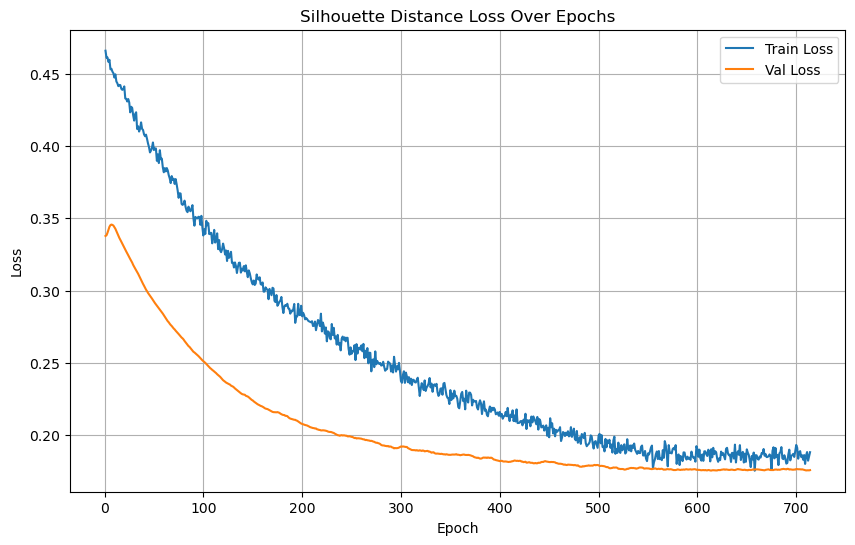

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/835], Loss: 0.0711


Test Batch [20/835], Loss: 0.1323
Test Batch [30/835], Loss: 0.1361
Test Batch [40/835], Loss: 0.5000
Test Batch [50/835], Loss: 0.5000
Test Batch [60/835], Loss: 0.1138
Test Batch [70/835], Loss: 0.1177


Test Batch [80/835], Loss: 0.1423


Test Batch [90/835], Loss: 0.0826
Test Batch [100/835], Loss: 0.1407
Test Batch [110/835], Loss: 0.1171
Test Batch [120/835], Loss: 0.1039
Test Batch [130/835], Loss: 0.1660
Test Batch [140/835], Loss: 0.1178
Test Batch [150/835], Loss: 0.1126


Test Batch [160/835], Loss: 0.1065
Test Batch [170/835], Loss: 0.1301
Test Batch [180/835], Loss: 0.1382
Test Batch [190/835], Loss: 0.1155
Test Batch [200/835], Loss: 0.0662


Test Batch [210/835], Loss: 0.0357
Test Batch [220/835], Loss: 0.0470
Test Batch [230/835], Loss: 0.0704
Test Batch [240/835], Loss: 0.0803


Test Batch [250/835], Loss: 0.1286
Test Batch [260/835], Loss: 0.1094
Test Batch [270/835], Loss: 0.0841


Test Batch [280/835], Loss: 0.1218
Test Batch [290/835], Loss: 0.1554
Test Batch [300/835], Loss: 0.1632
Test Batch [310/835], Loss: 0.1760
Test Batch [320/835], Loss: 0.1542


Test Batch [330/835], Loss: 0.1805
Test Batch [340/835], Loss: 0.5000
Test Batch [350/835], Loss: 0.5000
Test Batch [360/835], Loss: 0.5000
Test Batch [370/835], Loss: 0.5000
Test Batch [380/835], Loss: 0.5000
Test Batch [390/835], Loss: 0.5000
Test Batch [400/835], Loss: 0.5000
Test Batch [410/835], Loss: 0.5000
Test Batch [420/835], Loss: 0.1388
Test Batch [430/835], Loss: 0.0768


Test Batch [440/835], Loss: 0.0649
Test Batch [450/835], Loss: 0.1435
Test Batch [460/835], Loss: 0.0948
Test Batch [470/835], Loss: 0.0928
Test Batch [480/835], Loss: 0.0841
Test Batch [490/835], Loss: 0.5000
Test Batch [500/835], Loss: 0.0566


Test Batch [510/835], Loss: 0.0550
Test Batch [520/835], Loss: 0.0726
Test Batch [530/835], Loss: 0.0685
Test Batch [540/835], Loss: 0.0704
Test Batch [550/835], Loss: 0.0710


Test Batch [560/835], Loss: 0.0872
Test Batch [570/835], Loss: 0.0806
Test Batch [580/835], Loss: 0.1223
Test Batch [590/835], Loss: 0.0525
Test Batch [600/835], Loss: 0.0821
Test Batch [610/835], Loss: 0.5000


Test Batch [620/835], Loss: 0.2431
Test Batch [630/835], Loss: 0.5000
Test Batch [640/835], Loss: 0.1437
Test Batch [650/835], Loss: 0.1254
Test Batch [660/835], Loss: 0.1052


Test Batch [670/835], Loss: 0.2730
Test Batch [680/835], Loss: 0.1115
Test Batch [690/835], Loss: 0.0577
Test Batch [700/835], Loss: 0.4006
Test Batch [710/835], Loss: 0.1458


Test Batch [720/835], Loss: 0.3439
Test Batch [730/835], Loss: 0.2979
Test Batch [740/835], Loss: 0.5000
Test Batch [750/835], Loss: 0.0695
Test Batch [760/835], Loss: 0.1274
Test Batch [770/835], Loss: 0.1564


Test Batch [780/835], Loss: 0.5000
Test Batch [790/835], Loss: 0.1249
Test Batch [800/835], Loss: 0.1848
Test Batch [810/835], Loss: 0.5000
Test Batch [820/835], Loss: 0.1093
Test Batch [830/835], Loss: 0.5000

Test Loss: 0.1889


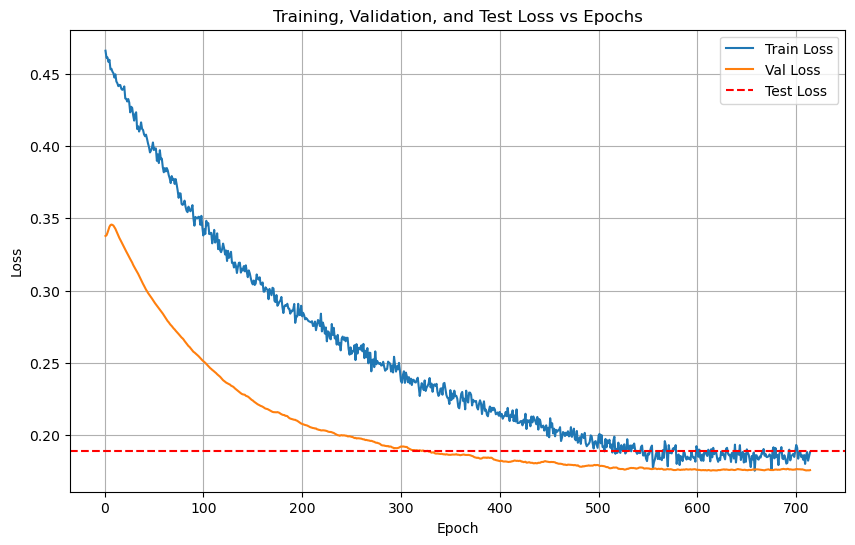

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/835 for test dataset.
  Processed batch 20/835 for test dataset.


  Processed batch 30/835 for test dataset.
  Processed batch 40/835 for test dataset.
  Processed batch 50/835 for test dataset.


  Processed batch 60/835 for test dataset.
  Processed batch 70/835 for test dataset.
  Processed batch 80/835 for test dataset.
  Processed batch 90/835 for test dataset.


  Processed batch 100/835 for test dataset.
  Processed batch 110/835 for test dataset.
  Processed batch 120/835 for test dataset.


  Processed batch 130/835 for test dataset.
  Processed batch 140/835 for test dataset.
  Processed batch 150/835 for test dataset.


  Processed batch 160/835 for test dataset.
  Processed batch 170/835 for test dataset.
  Processed batch 180/835 for test dataset.


  Processed batch 190/835 for test dataset.
  Processed batch 200/835 for test dataset.
  Processed batch 210/835 for test dataset.


  Processed batch 220/835 for test dataset.
  Processed batch 230/835 for test dataset.
  Processed batch 240/835 for test dataset.


  Processed batch 250/835 for test dataset.
  Processed batch 260/835 for test dataset.
  Processed batch 270/835 for test dataset.


  Processed batch 280/835 for test dataset.
  Processed batch 290/835 for test dataset.
  Processed batch 300/835 for test dataset.


  Processed batch 310/835 for test dataset.
  Processed batch 320/835 for test dataset.
  Processed batch 330/835 for test dataset.


  Processed batch 340/835 for test dataset.
  Processed batch 350/835 for test dataset.
  Processed batch 360/835 for test dataset.
  Processed batch 370/835 for test dataset.


  Processed batch 380/835 for test dataset.
  Processed batch 390/835 for test dataset.
  Processed batch 400/835 for test dataset.


  Processed batch 410/835 for test dataset.
  Processed batch 420/835 for test dataset.
  Processed batch 430/835 for test dataset.


  Processed batch 440/835 for test dataset.
  Processed batch 450/835 for test dataset.
  Processed batch 460/835 for test dataset.


  Processed batch 470/835 for test dataset.
  Processed batch 480/835 for test dataset.
  Processed batch 490/835 for test dataset.
  Processed batch 500/835 for test dataset.


  Processed batch 510/835 for test dataset.
  Processed batch 520/835 for test dataset.
  Processed batch 530/835 for test dataset.


  Processed batch 540/835 for test dataset.
  Processed batch 550/835 for test dataset.
  Processed batch 560/835 for test dataset.
  Processed batch 570/835 for test dataset.


  Processed batch 580/835 for test dataset.
  Processed batch 590/835 for test dataset.
  Processed batch 600/835 for test dataset.
  Processed batch 610/835 for test dataset.


  Processed batch 620/835 for test dataset.
  Processed batch 630/835 for test dataset.
  Processed batch 640/835 for test dataset.
  Processed batch 650/835 for test dataset.


  Processed batch 660/835 for test dataset.
  Processed batch 670/835 for test dataset.
  Processed batch 680/835 for test dataset.


  Processed batch 690/835 for test dataset.
  Processed batch 700/835 for test dataset.
  Processed batch 710/835 for test dataset.


  Processed batch 720/835 for test dataset.
  Processed batch 730/835 for test dataset.
  Processed batch 740/835 for test dataset.


  Processed batch 750/835 for test dataset.
  Processed batch 760/835 for test dataset.
  Processed batch 770/835 for test dataset.


  Processed batch 780/835 for test dataset.
  Processed batch 790/835 for test dataset.
  Processed batch 800/835 for test dataset.


  Processed batch 810/835 for test dataset.
  Processed batch 820/835 for test dataset.
  Processed batch 830/835 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (640, 128)
Train labels shape: (640,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53409, 128)
Test labels shape: (53409,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 86.25%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      0.80      0.89         5
           6       1.00      1.00      1.00         5
           7       0.50      0.60      0.55         5
           8       0.80      0.80      0.80         5
           9       1.00      0.80      0.89         5
          10       0.80      0.80      0.80         5
          11       0.83      1.00      0.91         5
          12       1.00      0.80      0.89         5
          13       0.7

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (640, 128)
Train labels shape: (640,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53409, 128)
Test labels shape: (53409,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7519  |  Val Loss: 2.6881
Validation loss improved from inf to 2.6881.
[Epoch 2/1000] Train Loss: 2.6269  |  Val Loss: 2.5866
Validation loss improved from 2.6881 to 2.5866.
[Epoch 3/1000] Train Loss: 2.5273  |  Val Loss: 2.4990
Validation loss improved from 2.5866 to 2.4990.
[Epoch 4/1000] Train Loss: 2.4369  |  Val Loss: 2.4176
Validation loss improved from 2.4990 to 2.4176.
[Epoch 5/1000] Train Loss: 2.3551  |  Val Loss: 2.3397
Validation loss improved from 2.4176 to 2.3397.
[Epoch 6/1000] Train Loss: 2.2745  |  Val Loss: 2.2694
Validation loss improved from 2.3397 to 2.2694.
[Epoch 7/1000] Train Loss: 2.2005  |  Val Loss: 2.2023
Validation loss improved from 2.2694 to 2.2023.
[Epoch 8/1000] Train Loss: 2.1312  |  Val Loss: 2.1356
Validation loss improved from 2.2023 to 2.1356.


[Epoch 9/1000] Train Loss: 2.0638  |  Val Loss: 2.0737
Validation loss improved from 2.1356 to 2.0737.
[Epoch 10/1000] Train Loss: 2.0013  |  Val Loss: 2.0151
Validation loss improved from 2.0737 to 2.0151.
[Epoch 11/1000] Train Loss: 1.9412  |  Val Loss: 1.9605
Validation loss improved from 2.0151 to 1.9605.


[Epoch 12/1000] Train Loss: 1.8857  |  Val Loss: 1.9083
Validation loss improved from 1.9605 to 1.9083.
[Epoch 13/1000] Train Loss: 1.8317  |  Val Loss: 1.8582
Validation loss improved from 1.9083 to 1.8582.
[Epoch 14/1000] Train Loss: 1.7804  |  Val Loss: 1.8104
Validation loss improved from 1.8582 to 1.8104.
[Epoch 15/1000] Train Loss: 1.7323  |  Val Loss: 1.7644
Validation loss improved from 1.8104 to 1.7644.
[Epoch 16/1000] Train Loss: 1.6861  |  Val Loss: 1.7197
Validation loss improved from 1.7644 to 1.7197.
[Epoch 17/1000] Train Loss: 1.6408  |  Val Loss: 1.6787
Validation loss improved from 1.7197 to 1.6787.
[Epoch 18/1000] Train Loss: 1.5992  |  Val Loss: 1.6389
Validation loss improved from 1.6787 to 1.6389.


[Epoch 19/1000] Train Loss: 1.5591  |  Val Loss: 1.6008
Validation loss improved from 1.6389 to 1.6008.
[Epoch 20/1000] Train Loss: 1.5195  |  Val Loss: 1.5640
Validation loss improved from 1.6008 to 1.5640.
[Epoch 21/1000] Train Loss: 1.4828  |  Val Loss: 1.5283
Validation loss improved from 1.5640 to 1.5283.


[Epoch 22/1000] Train Loss: 1.4459  |  Val Loss: 1.4950
Validation loss improved from 1.5283 to 1.4950.
[Epoch 23/1000] Train Loss: 1.4115  |  Val Loss: 1.4623
Validation loss improved from 1.4950 to 1.4623.
[Epoch 24/1000] Train Loss: 1.3778  |  Val Loss: 1.4306
Validation loss improved from 1.4623 to 1.4306.
[Epoch 25/1000] Train Loss: 1.3450  |  Val Loss: 1.3992
Validation loss improved from 1.4306 to 1.3992.
[Epoch 26/1000] Train Loss: 1.3123  |  Val Loss: 1.3674
Validation loss improved from 1.3992 to 1.3674.
[Epoch 27/1000] Train Loss: 1.2794  |  Val Loss: 1.3360
Validation loss improved from 1.3674 to 1.3360.
[Epoch 28/1000] Train Loss: 1.2460  |  Val Loss: 1.3038
Validation loss improved from 1.3360 to 1.3038.


[Epoch 29/1000] Train Loss: 1.2127  |  Val Loss: 1.2728
Validation loss improved from 1.3038 to 1.2728.
[Epoch 30/1000] Train Loss: 1.1803  |  Val Loss: 1.2435
Validation loss improved from 1.2728 to 1.2435.
[Epoch 31/1000] Train Loss: 1.1490  |  Val Loss: 1.2152
Validation loss improved from 1.2435 to 1.2152.


[Epoch 32/1000] Train Loss: 1.1187  |  Val Loss: 1.1883
Validation loss improved from 1.2152 to 1.1883.
[Epoch 33/1000] Train Loss: 1.0903  |  Val Loss: 1.1617
Validation loss improved from 1.1883 to 1.1617.
[Epoch 34/1000] Train Loss: 1.0620  |  Val Loss: 1.1362
Validation loss improved from 1.1617 to 1.1362.
[Epoch 35/1000] Train Loss: 1.0345  |  Val Loss: 1.1119
Validation loss improved from 1.1362 to 1.1119.
[Epoch 36/1000] Train Loss: 1.0080  |  Val Loss: 1.0885
Validation loss improved from 1.1119 to 1.0885.
[Epoch 37/1000] Train Loss: 0.9824  |  Val Loss: 1.0658
Validation loss improved from 1.0885 to 1.0658.
[Epoch 38/1000] Train Loss: 0.9573  |  Val Loss: 1.0440
Validation loss improved from 1.0658 to 1.0440.


[Epoch 39/1000] Train Loss: 0.9331  |  Val Loss: 1.0230
Validation loss improved from 1.0440 to 1.0230.
[Epoch 40/1000] Train Loss: 0.9093  |  Val Loss: 1.0029
Validation loss improved from 1.0230 to 1.0029.
[Epoch 41/1000] Train Loss: 0.8852  |  Val Loss: 0.9832
Validation loss improved from 1.0029 to 0.9832.


[Epoch 42/1000] Train Loss: 0.8624  |  Val Loss: 0.9630
Validation loss improved from 0.9832 to 0.9630.
[Epoch 43/1000] Train Loss: 0.8383  |  Val Loss: 0.9439
Validation loss improved from 0.9630 to 0.9439.
[Epoch 44/1000] Train Loss: 0.8148  |  Val Loss: 0.9253
Validation loss improved from 0.9439 to 0.9253.
[Epoch 45/1000] Train Loss: 0.7914  |  Val Loss: 0.9068
Validation loss improved from 0.9253 to 0.9068.
[Epoch 46/1000] Train Loss: 0.7686  |  Val Loss: 0.8887
Validation loss improved from 0.9068 to 0.8887.
[Epoch 47/1000] Train Loss: 0.7460  |  Val Loss: 0.8714
Validation loss improved from 0.8887 to 0.8714.
[Epoch 48/1000] Train Loss: 0.7244  |  Val Loss: 0.8545
Validation loss improved from 0.8714 to 0.8545.
[Epoch 49/1000] Train Loss: 0.7025  |  Val Loss: 0.8373
Validation loss improved from 0.8545 to 0.8373.


[Epoch 50/1000] Train Loss: 0.6804  |  Val Loss: 0.8214
Validation loss improved from 0.8373 to 0.8214.
[Epoch 51/1000] Train Loss: 0.6577  |  Val Loss: 0.8047
Validation loss improved from 0.8214 to 0.8047.


[Epoch 52/1000] Train Loss: 0.6347  |  Val Loss: 0.7877
Validation loss improved from 0.8047 to 0.7877.
[Epoch 53/1000] Train Loss: 0.6119  |  Val Loss: 0.7726
Validation loss improved from 0.7877 to 0.7726.
[Epoch 54/1000] Train Loss: 0.5896  |  Val Loss: 0.7597
Validation loss improved from 0.7726 to 0.7597.
[Epoch 55/1000] Train Loss: 0.5690  |  Val Loss: 0.7470
Validation loss improved from 0.7597 to 0.7470.
[Epoch 56/1000] Train Loss: 0.5466  |  Val Loss: 0.7313
Validation loss improved from 0.7470 to 0.7313.
[Epoch 57/1000] Train Loss: 0.5248  |  Val Loss: 0.7174
Validation loss improved from 0.7313 to 0.7174.
[Epoch 58/1000] Train Loss: 0.5028  |  Val Loss: 0.7046
Validation loss improved from 0.7174 to 0.7046.
[Epoch 59/1000] Train Loss: 0.4808  |  Val Loss: 0.6921
Validation loss improved from 0.7046 to 0.6921.


[Epoch 60/1000] Train Loss: 0.4598  |  Val Loss: 0.6808
Validation loss improved from 0.6921 to 0.6808.
[Epoch 61/1000] Train Loss: 0.4404  |  Val Loss: 0.6708
Validation loss improved from 0.6808 to 0.6708.


[Epoch 62/1000] Train Loss: 0.4216  |  Val Loss: 0.6606
Validation loss improved from 0.6708 to 0.6606.
[Epoch 63/1000] Train Loss: 0.4037  |  Val Loss: 0.6494
Validation loss improved from 0.6606 to 0.6494.
[Epoch 64/1000] Train Loss: 0.3863  |  Val Loss: 0.6391
Validation loss improved from 0.6494 to 0.6391.
[Epoch 65/1000] Train Loss: 0.3704  |  Val Loss: 0.6307
Validation loss improved from 0.6391 to 0.6307.
[Epoch 66/1000] Train Loss: 0.3537  |  Val Loss: 0.6211
Validation loss improved from 0.6307 to 0.6211.
[Epoch 67/1000] Train Loss: 0.3393  |  Val Loss: 0.6111
Validation loss improved from 0.6211 to 0.6111.
[Epoch 68/1000] Train Loss: 0.3243  |  Val Loss: 0.6014
Validation loss improved from 0.6111 to 0.6014.
[Epoch 69/1000] Train Loss: 0.3104  |  Val Loss: 0.5941
Validation loss improved from 0.6014 to 0.5941.


[Epoch 70/1000] Train Loss: 0.2977  |  Val Loss: 0.5860
Validation loss improved from 0.5941 to 0.5860.
[Epoch 71/1000] Train Loss: 0.2853  |  Val Loss: 0.5797
Validation loss improved from 0.5860 to 0.5797.


[Epoch 72/1000] Train Loss: 0.2732  |  Val Loss: 0.5711
Validation loss improved from 0.5797 to 0.5711.
[Epoch 73/1000] Train Loss: 0.2632  |  Val Loss: 0.5658
Validation loss improved from 0.5711 to 0.5658.
[Epoch 74/1000] Train Loss: 0.2537  |  Val Loss: 0.5571
Validation loss improved from 0.5658 to 0.5571.
[Epoch 75/1000] Train Loss: 0.2435  |  Val Loss: 0.5532
Validation loss improved from 0.5571 to 0.5532.
[Epoch 76/1000] Train Loss: 0.2356  |  Val Loss: 0.5524
Validation loss improved from 0.5532 to 0.5524.
[Epoch 77/1000] Train Loss: 0.2263  |  Val Loss: 0.5427
Validation loss improved from 0.5524 to 0.5427.
[Epoch 78/1000] Train Loss: 0.2189  |  Val Loss: 0.5371
Validation loss improved from 0.5427 to 0.5371.
[Epoch 79/1000] Train Loss: 0.2118  |  Val Loss: 0.5368
Validation loss improved from 0.5371 to 0.5368.


[Epoch 80/1000] Train Loss: 0.2044  |  Val Loss: 0.5327
Validation loss improved from 0.5368 to 0.5327.
[Epoch 81/1000] Train Loss: 0.1983  |  Val Loss: 0.5294
Validation loss improved from 0.5327 to 0.5294.


[Epoch 82/1000] Train Loss: 0.1920  |  Val Loss: 0.5262
Validation loss improved from 0.5294 to 0.5262.
[Epoch 83/1000] Train Loss: 0.1864  |  Val Loss: 0.5218
Validation loss improved from 0.5262 to 0.5218.
[Epoch 84/1000] Train Loss: 0.1816  |  Val Loss: 0.5221
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 85/1000] Train Loss: 0.1754  |  Val Loss: 0.5204
Validation loss improved from 0.5218 to 0.5204.
[Epoch 86/1000] Train Loss: 0.1715  |  Val Loss: 0.5156
Validation loss improved from 0.5204 to 0.5156.
[Epoch 87/1000] Train Loss: 0.1667  |  Val Loss: 0.5160
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 88/1000] Train Loss: 0.1624  |  Val Loss: 0.5145
Validation loss improved from 0.5156 to 0.5145.


[Epoch 89/1000] Train Loss: 0.1583  |  Val Loss: 0.5138
Validation loss improved from 0.5145 to 0.5138.
[Epoch 90/1000] Train Loss: 0.1546  |  Val Loss: 0.5132
Validation loss improved from 0.5138 to 0.5132.
[Epoch 91/1000] Train Loss: 0.1514  |  Val Loss: 0.5128
Validation loss improved from 0.5132 to 0.5128.


[Epoch 92/1000] Train Loss: 0.1482  |  Val Loss: 0.5127
Validation loss improved from 0.5128 to 0.5127.
[Epoch 93/1000] Train Loss: 0.1455  |  Val Loss: 0.5124
Validation loss improved from 0.5127 to 0.5124.
[Epoch 94/1000] Train Loss: 0.1427  |  Val Loss: 0.5101
Validation loss improved from 0.5124 to 0.5101.
[Epoch 95/1000] Train Loss: 0.1398  |  Val Loss: 0.5096
Validation loss improved from 0.5101 to 0.5096.
[Epoch 96/1000] Train Loss: 0.1375  |  Val Loss: 0.5104
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 97/1000] Train Loss: 0.1355  |  Val Loss: 0.5093
Validation loss improved from 0.5096 to 0.5093.
[Epoch 98/1000] Train Loss: 0.1333  |  Val Loss: 0.5065
Validation loss improved from 0.5093 to 0.5065.


[Epoch 99/1000] Train Loss: 0.1308  |  Val Loss: 0.5078
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 100/1000] Train Loss: 0.1285  |  Val Loss: 0.5093
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 101/1000] Train Loss: 0.1270  |  Val Loss: 0.5077
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 102/1000] Train Loss: 0.1251  |  Val Loss: 0.5051
Validation loss improved from 0.5065 to 0.5051.
[Epoch 103/1000] Train Loss: 0.1229  |  Val Loss: 0.5053
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 104/1000] Train Loss: 0.1216  |  Val Loss: 0.5071
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 105/1000] Train Loss: 0.1201  |  Val Loss: 0.5043
Validation loss improved from 0.5051 to 0.5043.
[Epoch 106/1000] Train Loss: 0.1180  |  Val Loss: 0.5047
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 107/1000] Train Loss: 0.1163  |  Val Loss: 0.5042
Validation loss improved from 0.5043 to 0.5042.
[Epoch 108/1000] Train Loss: 0.1150  |  Val Loss: 0.5019
Validation loss improved from 0.5042 to 0.5019.


[Epoch 109/1000] Train Loss: 0.1137  |  Val Loss: 0.5042
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 110/1000] Train Loss: 0.1120  |  Val Loss: 0.5044
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 111/1000] Train Loss: 0.1108  |  Val Loss: 0.5036
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 112/1000] Train Loss: 0.1098  |  Val Loss: 0.5026
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 113/1000] Train Loss: 0.1084  |  Val Loss: 0.5029
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 114/1000] Train Loss: 0.1079  |  Val Loss: 0.5032
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 115/1000] Train Loss: 0.1062  |  Val Loss: 0.5026
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 116/1000] Train Loss: 0.1048  |  Val Loss: 0.5022
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 117/1000] Train Loss: 0.1039  |  Val Loss: 0.5028
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 118/1000] Train Loss: 0.1026  |  Val Loss: 0.5042
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 119/1000] Train Loss: 0.1016  |  Val Loss: 0.5045
!! Validation loss did NOT improve !! Patience: 11/100


[Epoch 120/1000] Train Loss: 0.1005  |  Val Loss: 0.5036
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 121/1000] Train Loss: 0.1006  |  Val Loss: 0.5017
Validation loss improved from 0.5019 to 0.5017.


[Epoch 122/1000] Train Loss: 0.0995  |  Val Loss: 0.5077
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 123/1000] Train Loss: 0.0978  |  Val Loss: 0.5042
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 124/1000] Train Loss: 0.0976  |  Val Loss: 0.5000
Validation loss improved from 0.5017 to 0.5000.
[Epoch 125/1000] Train Loss: 0.0963  |  Val Loss: 0.5050
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 126/1000] Train Loss: 0.0954  |  Val Loss: 0.5068
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 127/1000] Train Loss: 0.0944  |  Val Loss: 0.5042
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 128/1000] Train Loss: 0.0939  |  Val Loss: 0.5030
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 129/1000] Train Loss: 0.0929  |  Val Loss: 0.5040
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 130/1000] Train Loss: 0.0921  |  Val Loss: 0.5031
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 131/1000] Train Loss: 0.0918  |  Val Loss: 0.5079
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 132/1000] Train Loss: 0.0911  |  Val Loss: 0.5020
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 133/1000] Train Loss: 0.0898  |  Val Loss: 0.5033
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 134/1000] Train Loss: 0.0889  |  Val Loss: 0.5093
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 135/1000] Train Loss: 0.0885  |  Val Loss: 0.5076
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 136/1000] Train Loss: 0.0877  |  Val Loss: 0.5055
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 137/1000] Train Loss: 0.0868  |  Val Loss: 0.5048
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 138/1000] Train Loss: 0.0862  |  Val Loss: 0.5087
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 139/1000] Train Loss: 0.0857  |  Val Loss: 0.5083
!! Validation loss did NOT improve !! Patience: 15

[Epoch 140/1000] Train Loss: 0.0849  |  Val Loss: 0.5070
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 141/1000] Train Loss: 0.0853  |  Val Loss: 0.5112
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 142/1000] Train Loss: 0.0836  |  Val Loss: 0.5058
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 143/1000] Train Loss: 0.0835  |  Val Loss: 0.5062
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 144/1000] Train Loss: 0.0827  |  Val Loss: 0.5070
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 145/1000] Train Loss: 0.0818  |  Val Loss: 0.5070
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 146/1000] Train Loss: 0.0816  |  Val Loss: 0.5113
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 147/1000] Train Loss: 0.0806  |  Val Loss: 0.5104
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 148/1000] Train Loss: 0.0803  |  Val Loss: 0.5080
!! Validation loss did NOT improve !! Patience:

[Epoch 150/1000] Train Loss: 0.0795  |  Val Loss: 0.5120
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 151/1000] Train Loss: 0.0786  |  Val Loss: 0.5131
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 152/1000] Train Loss: 0.0780  |  Val Loss: 0.5103
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 153/1000] Train Loss: 0.0776  |  Val Loss: 0.5104
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 154/1000] Train Loss: 0.0774  |  Val Loss: 0.5160
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 155/1000] Train Loss: 0.0770  |  Val Loss: 0.5084
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 156/1000] Train Loss: 0.0760  |  Val Loss: 0.5142
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 157/1000] Train Loss: 0.0756  |  Val Loss: 0.5137
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 158/1000] Train Loss: 0.0751  |  Val Loss: 0.5139
!! Validation loss did NOT improve !! Patience:

[Epoch 160/1000] Train Loss: 0.0740  |  Val Loss: 0.5174
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 161/1000] Train Loss: 0.0744  |  Val Loss: 0.5131
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 162/1000] Train Loss: 0.0733  |  Val Loss: 0.5169
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 163/1000] Train Loss: 0.0727  |  Val Loss: 0.5183
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 164/1000] Train Loss: 0.0721  |  Val Loss: 0.5198
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 165/1000] Train Loss: 0.0720  |  Val Loss: 0.5144
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 166/1000] Train Loss: 0.0717  |  Val Loss: 0.5202
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 167/1000] Train Loss: 0.0710  |  Val Loss: 0.5195
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 168/1000] Train Loss: 0.0705  |  Val Loss: 0.5209
!! Validation loss did NOT improve !! Patience:

[Epoch 170/1000] Train Loss: 0.0713  |  Val Loss: 0.5152
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 171/1000] Train Loss: 0.0694  |  Val Loss: 0.5215
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 172/1000] Train Loss: 0.0691  |  Val Loss: 0.5215
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 173/1000] Train Loss: 0.0687  |  Val Loss: 0.5212
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 174/1000] Train Loss: 0.0683  |  Val Loss: 0.5222
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 175/1000] Train Loss: 0.0675  |  Val Loss: 0.5204
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 176/1000] Train Loss: 0.0681  |  Val Loss: 0.5204
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 177/1000] Train Loss: 0.0669  |  Val Loss: 0.5256
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 178/1000] Train Loss: 0.0667  |  Val Loss: 0.5272
!! Validation loss did NOT improve !! Patience:

[Epoch 180/1000] Train Loss: 0.0661  |  Val Loss: 0.5268
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 181/1000] Train Loss: 0.0659  |  Val Loss: 0.5247
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 182/1000] Train Loss: 0.0652  |  Val Loss: 0.5265
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 183/1000] Train Loss: 0.0651  |  Val Loss: 0.5300
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 184/1000] Train Loss: 0.0644  |  Val Loss: 0.5294
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 185/1000] Train Loss: 0.0643  |  Val Loss: 0.5283
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 186/1000] Train Loss: 0.0639  |  Val Loss: 0.5296
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 187/1000] Train Loss: 0.0634  |  Val Loss: 0.5312
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 188/1000] Train Loss: 0.0631  |  Val Loss: 0.5310
!! Validation loss did NOT improve !! Patience:

[Epoch 191/1000] Train Loss: 0.0625  |  Val Loss: 0.5349
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 192/1000] Train Loss: 0.0637  |  Val Loss: 0.5299
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 193/1000] Train Loss: 0.0613  |  Val Loss: 0.5397
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 194/1000] Train Loss: 0.0613  |  Val Loss: 0.5389
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 195/1000] Train Loss: 0.0616  |  Val Loss: 0.5346
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 196/1000] Train Loss: 0.0606  |  Val Loss: 0.5373
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 197/1000] Train Loss: 0.0602  |  Val Loss: 0.5364
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 198/1000] Train Loss: 0.0606  |  Val Loss: 0.5366
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 199/1000] Train Loss: 0.0603  |  Val Loss: 0.5391
!! Validation loss did NOT improve !! Patience:

[Epoch 201/1000] Train Loss: 0.0596  |  Val Loss: 0.5399
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 202/1000] Train Loss: 0.0588  |  Val Loss: 0.5415
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 203/1000] Train Loss: 0.0585  |  Val Loss: 0.5393
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 204/1000] Train Loss: 0.0583  |  Val Loss: 0.5421
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 205/1000] Train Loss: 0.0579  |  Val Loss: 0.5412
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 206/1000] Train Loss: 0.0586  |  Val Loss: 0.5477
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 207/1000] Train Loss: 0.0578  |  Val Loss: 0.5421
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 208/1000] Train Loss: 0.0572  |  Val Loss: 0.5459
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 209/1000] Train Loss: 0.0564  |  Val Loss: 0.5451
!! Validation loss did NOT improve !! Patience:

[Epoch 212/1000] Train Loss: 0.0559  |  Val Loss: 0.5478
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 213/1000] Train Loss: 0.0563  |  Val Loss: 0.5503
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 214/1000] Train Loss: 0.0556  |  Val Loss: 0.5447
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 215/1000] Train Loss: 0.0552  |  Val Loss: 0.5483
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 216/1000] Train Loss: 0.0546  |  Val Loss: 0.5505
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 217/1000] Train Loss: 0.0550  |  Val Loss: 0.5555
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 218/1000] Train Loss: 0.0544  |  Val Loss: 0.5519
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 219/1000] Train Loss: 0.0546  |  Val Loss: 0.5465
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 220/1000] Train Loss: 0.0542  |  Val Loss: 0.5559
!! Validation loss did NOT improve !! Patience:

[Epoch 223/1000] Train Loss: 0.0531  |  Val Loss: 0.5533
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 224/1000] Train Loss: 0.0528  |  Val Loss: 0.5561
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 224 !!
No improvement for 100 epochs.


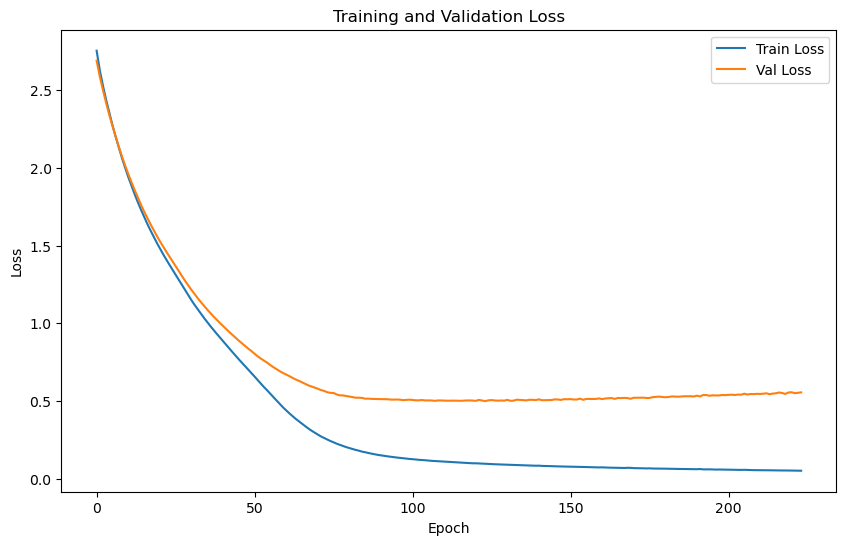

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.9630 | Test Accuracy: 85.16%


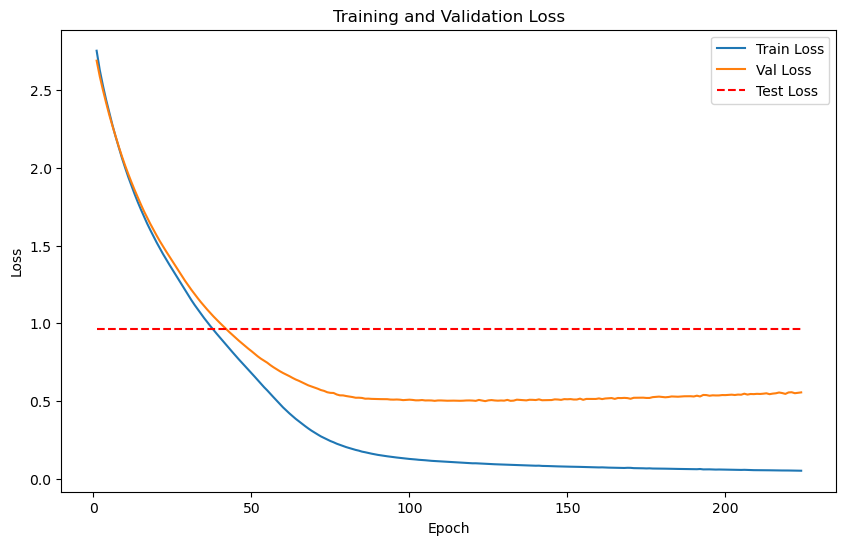

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


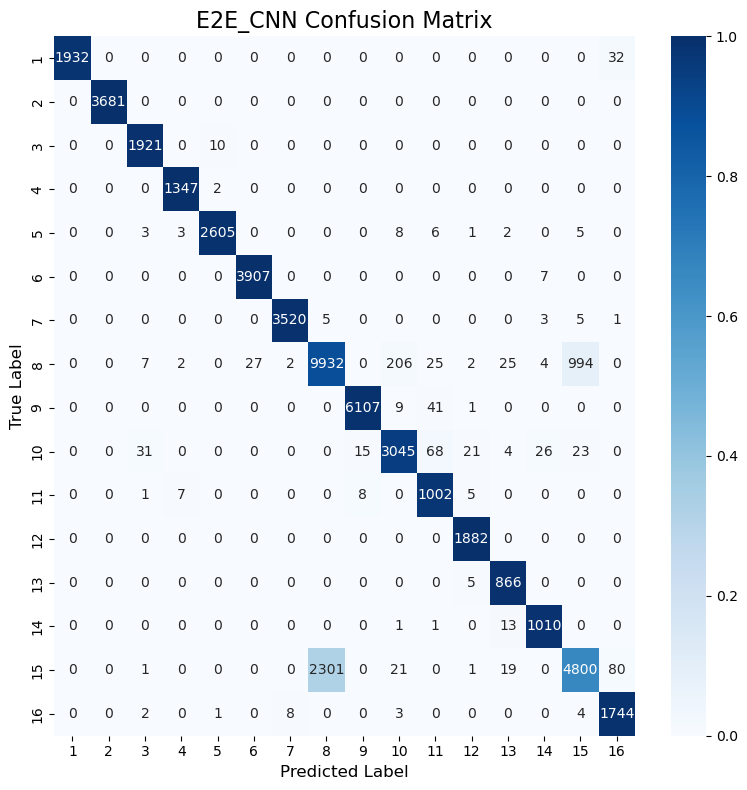

Classification Accuracy: 92.31%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


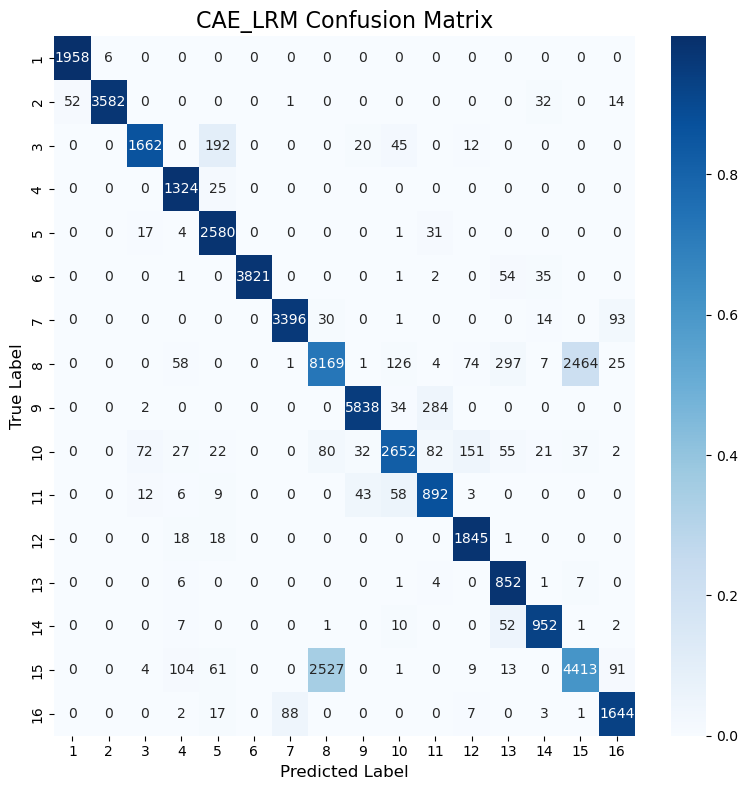

Classification Accuracy: 85.34%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


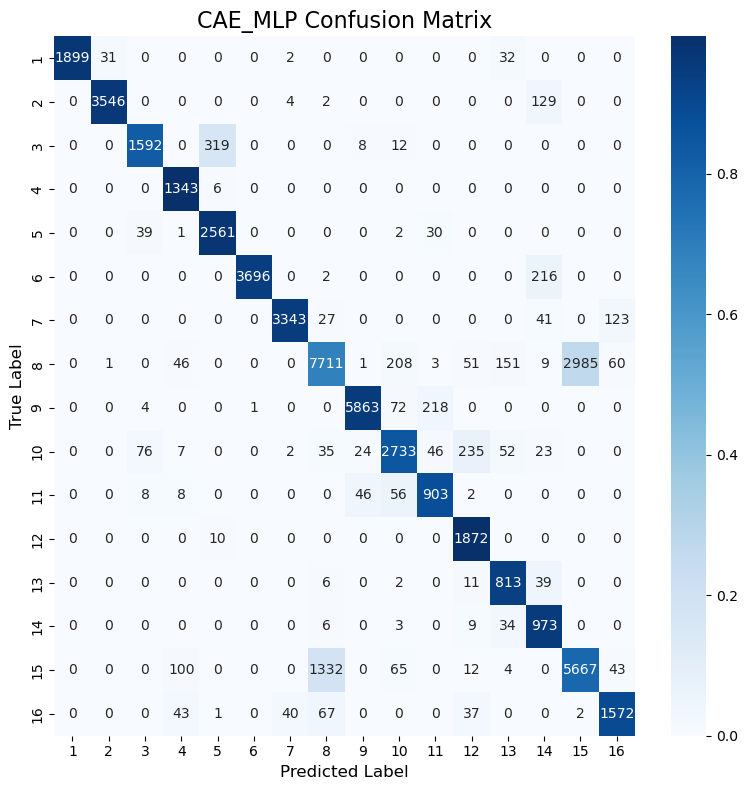

Classification Accuracy: 86.29%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


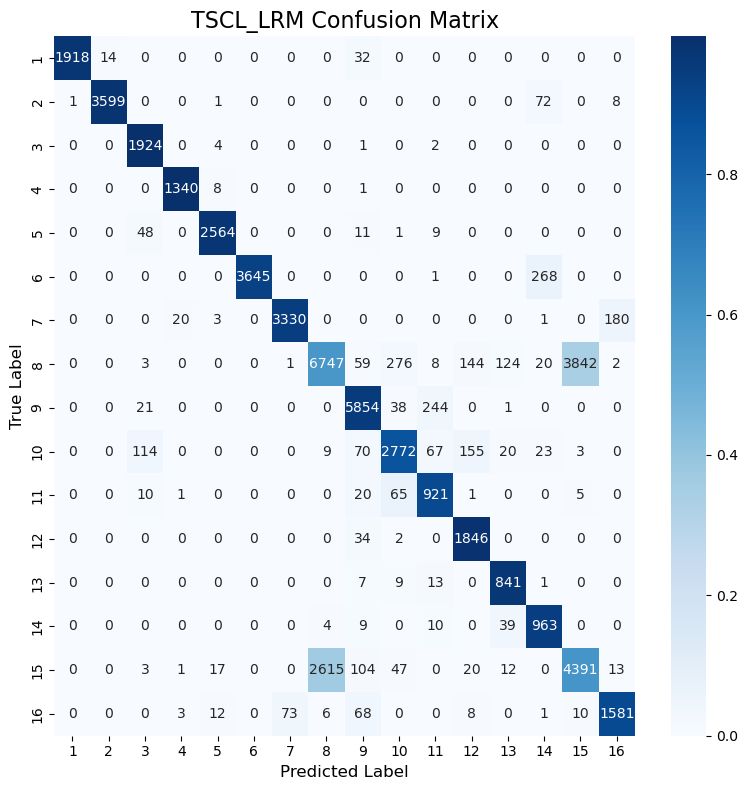

Classification Accuracy: 82.82%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


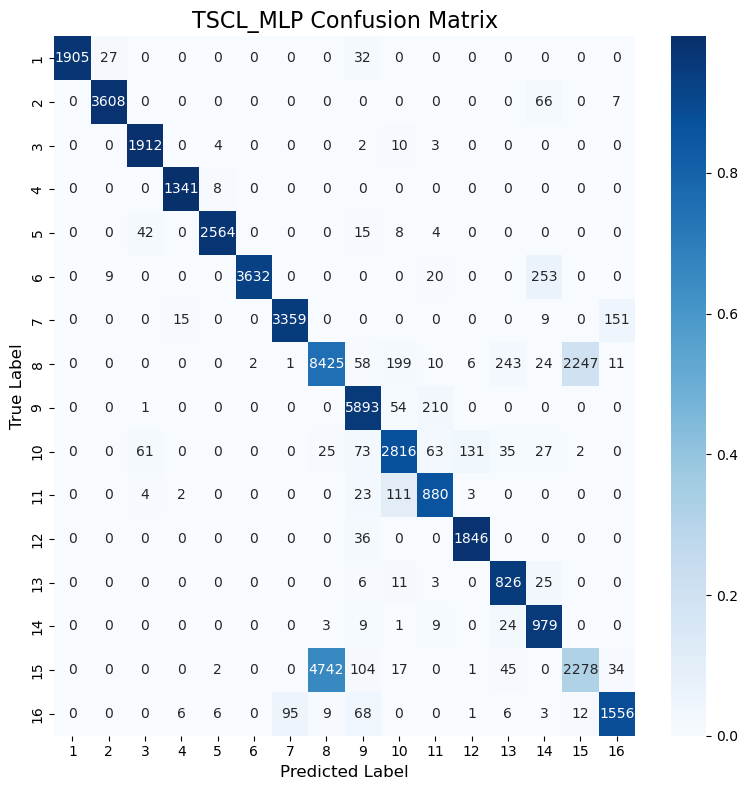

Classification Accuracy: 82.05%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


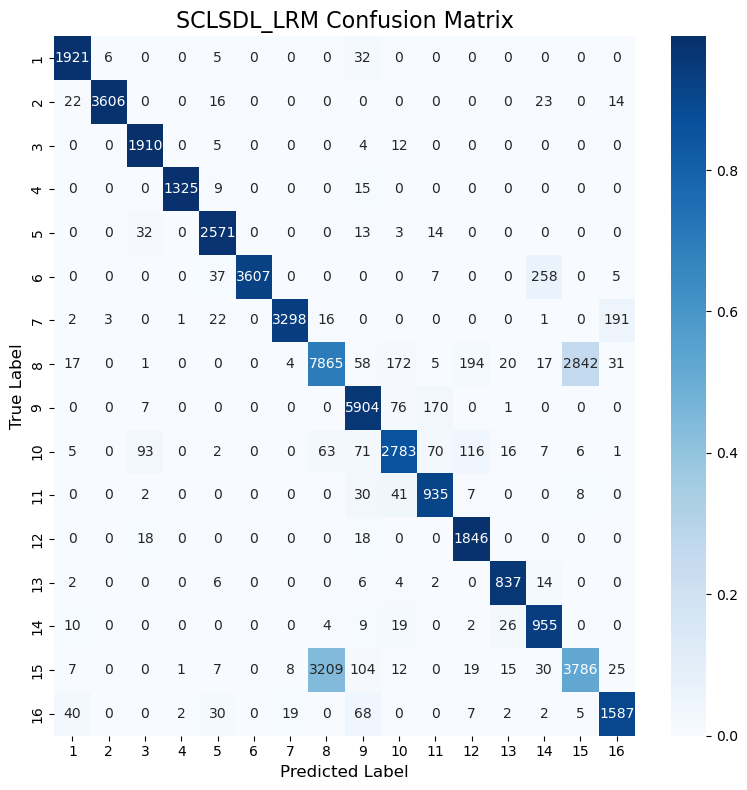

Classification Accuracy: 83.76%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


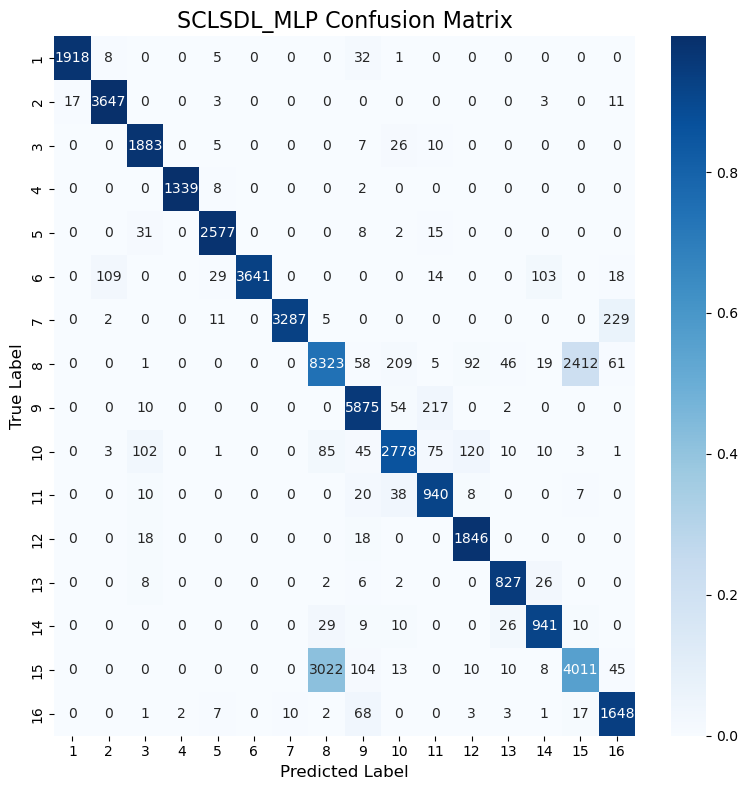

Classification Accuracy: 85.16%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          92.31
1    LRM (CAE)          85.34
2    MLP (CAE)          86.29
3     TSCL LRM          82.82
4     TSCL MLP          82.05
5  SCL_SDL LRM          83.76
6  SCL_SDL MLP          85.16

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          92.31
2    MLP (CAE)          86.29
1    LRM (CAE)          85.34
6  SCL_SDL MLP          85.16
5  SCL_SDL LRM          83.76
3     TSCL LRM          82.82
4     TSCL MLP          82.05
